TP1 - Recalage d'images
=============

In [1]:
import numpy as np
from scipy import signal
from scipy import interpolate
from PIL import Image
import matplotlib.pyplot as plt

Un problème fréquemment rencontré dans le domaine du traitement d’images est celui du recalage. On dispose de plusieurs images prises à des temps différents, ou par des appareils différents, et on aimerait les mettre en correspondence, c’est-à-dire trouver une déformation du plan, qui assure une correspondence point à point des objets sous-jacents. Donnons quelques exemples d’applications :
* Traitements/retouches d’images. Par exemple, on peut vouloir construire un panoramique à partir d’images de petite taille. Il faut les recaler préalablement.
* Evaluation des déplacements d’objets dans des séquences vidéos (e.g. trouver un défaut de fonctionnement d’un organe, caméras de surveillance, design de robots intelligents ou de systèmes de navigation automatiques ...)
* Couplage d’informations. Par exemple, en imagerie médicale, on obtient une information plus riche en utilisant à la fois une radio et une angiographie. L’une apporte des informations structurelles, l’autre des informations fonctionnelles. Le couplage des deux images donne plus d’information au praticien.
* Beaucoup d’autres applications...

Dans ce TP, nous allons proposer un modèle de recalage assez élémentaire. Les idées constitutives se retrouvent cependant dans presque toutes les techniques récentes.

In [2]:
def get_images() :
    n=21
    sigma=0.3
    [X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,n), indexing='xy')
    Z=np.sqrt(X*X+Y*Y)
    im1=np.zeros((n,n))
    im1[Z<=.7]=1.
    im1[Z<=.3]=.5
    im1[Z<=.1]=.7
    im2=np.zeros((n,n));
    Z=np.sqrt((X-.3)**2+(Y+.2)**2)
    im2[Z<=.7]=1
    im2[Z<=.3]=.5
    im2[Z<=.1]=.7
    G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
    f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
    g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
    f=f/np.max(f)
    g=g/np.max(g)
    return f,g

In [3]:
f,g=get_images()

1. Formalisation du problème
-----------------------------

1.1 Formalisme continu
---------------------

On modélise les images en niveaux de gris comme des fonctions d’un ensemble borné $\Omega\subset \mathbb{R}$ (typiquement un carré) dans $\mathbb{R}$. La valeur de la fonction en chaque point représente l’intensité lumineuse de l’image. 

Soient $f$ et $g$ deux images. On a donc :
$$
f:\Omega\subset \mathbb{R}^2 \to \mathbb{R},  g:\Omega\subset \mathbb{R}^2 \to \mathbb{R} 
$$
En supposant que les images $f$ et $g$ dépendent seulement d’une transformation géométrique qui conserve la luminosité, le problème de recalage peut être formulé comme suit:

> Problème inverse $(P_1)$ : 

> Etant donnés $f$ et $g$ dans $H_1(\Omega)$ (les images ont une amplitude bornée et une énergie finie), trouver un champ de vecteurs $u = (u_1, u_2) \in H_1(\Omega)^2$ tel que:
$$f(x + u(x)) = g(x), \forall x\in \Omega.$$


Le problème inverse est mal posé: tout d'abord, l'existence d'une solution n'est pas garantie, et dans le cas où il existe une solution, on n'a pas nécessairement unicité de cette solution. Par exemple, si $f$ et $g$ sont des fonctions constantes, n'importe quel déplacement $u$ est solution

Pour le résoudre, on se propose de le reformuler comme un problème d'optimisation: 

> $(P_2)$ On cherche une déformation $u$ du plan qui minimise:
$$
E(u)=\displaystyle\frac{1}{2}\int_\Omega (f(x+u(x))-g(x))^2 dx=\frac{1}{2}\|f\circ (id+u)-g\|^2.
$$

Sans hypothèse supplémentaire, le problème $\displaystyle \min_{u \in H^1(\Omega)^2} E(u)$ n'est a priori pas convexe, toujours mal posé et même éventuellement non différentiable si $u$ et $f$ ne sont pas assez régulières. On pourrait facilement rendre $f$ différentiable (en ajoutant du bruit par exemple à l'image, ce qui revient à convoler $f$ avec une gaussienne) mais il faut également "forcer" $u$ à être différentiable. Pour cela on propose de régulariser le problème de façon à assurer la convexité du problème d'optimisation considéré ainsi que l'existence et l'unicité des solutions.

Pour régulariser le problème inverse, nous allons faire une analogie avec l’élasticité linéaire. La fonction $u = (u_x,u_y)$ représente un champ de déformations. En notant $\partial x$ et $\partial y$ les opérateurs de dérivation partielle par rapport à chacun des axes du plan, on peut définir un potentiel élastique linéarisé :
$$
R(u)= \frac{\mu}{2}\int_{\Omega} \underbrace{ (\partial_x u_y + \partial_y u_x)^2(x,y) dxdy}_{R_1(u)=\textrm{cisaillement}} +\frac{\lambda+\mu}{2}\int_{\Omega} \underbrace{(\partial_x u_x + \partial_y u_y)^2(x,y) dxdy}_{R_2(u)=\textrm{variations \ de \ volume}}.
$$ 
En mécanique des structures, $\mu$ et $\lambda$ sont appelées constantes de Lamé. Le paramètre $\lambda$ n’a pas d’interprétation directe, tandis que le paramètre $\mu$ est appelé module de cisaillement.

Le problème d'optimisation à résoudre dans ce TP est le suivant:
> $$(P)\qquad \min_{u} E(u)+R(u).$$

Q1. A l'aide d'un développement de Taylor, vérifier que le gradient de $E$ s'écrit:

$$\nabla E(u) = \left(f\circ (id+u) -g\right)\nabla f\circ (id+u)$$

au sens où la différentielle de $E$ est définie par:

$$\langle \nabla E(u),h\rangle = \displaystyle\int_\Omega \langle (f(x+u(x))-g(x))\nabla f(x+u(x)),h(x)\rangle dx.$$

2. Discrétisation
==================
Pour pouvoir résoudre numériquement le problème $(P)$ (dont les variables de l'optimisation sont des fonctions !), on propose de le discrétiser au préalable. 

Soit $1\le i \le n$ and $1\le j\le m$. Notons $(x_i,y_j)$ le point de la grille $(i,j)$ et $f_{i,j}$ la valeur de $f$ au point $(x_i,y_j)$. Le produit scalaire sur $V=\mathbb{R}^n\times \mathbb{R}^m$ est défini par:
$$\langle f,g\rangle_V=\sum_{i=1}^n\sum_{j=1}^m f_{i,j}g_{i,j},$$
défini sur $\mathbb{R}^n\times \mathbb{R}^m$. 

2.1. Calcul du $E$ et de son gradient
-----------------------------------

Pour pouvoir calculer $E$ et son gradient, on va avoir besoin d'évaluer $f\circ (Id+u)$ et $\nabla f\circ(id+u)$. C'est ce que fait la fonciton interpol ci-dessous.

In [4]:
def interpol(f,ux,uy) :
    # function that computes f \circ Id+u and interpolates it on a mesh
    nx,ny=f.shape
    ip=interpolate.RectBivariateSpline(np.arange(nx),np.arange(ny),f)
    [X,Y]=np.meshgrid(np.arange(nx),np.arange(ny), indexing='ij')
    X=X+ux
    Y=Y+uy
    return np.reshape(ip.ev(X.ravel(),Y.ravel()),(nx,ny))

2.2. Calcul de $R$ et de son gradient
-------------------------------------
On discrétise également les opérateurs de dérivation partielles par différences finies ; par exemple la dérivée partielle par rapport à $x$ est donnée par:
$$\begin{cases}(\partial_x f)_{i,j}=f_{i+1,j}-f_{i,j} \text{ si } i<n \\
(\partial_x f)_{n,j}=0 \end{cases} $$

On peut alors écrire :
$$
R(u)= \frac{\mu}{2}\sum_{i}(\partial_x u_y + \partial_y u_x)^2(i) + \frac{\lambda+\mu}{2} \sum_i(\partial_x u_x + \partial_y u_y)^2(i).
$$ 
où:
* $u_x\in\mathbb{R}^n$ et $u_y\in\mathbb{R}^n$ sont les discrétisations des composantes du champ de vecteurs $u$ sur la grille choisie et $\partial_x:\mathbb{R}^n\rightarrow\mathbb{R}^n$
* $\partial_y:\mathbb{R}^n\rightarrow\mathbb{R}^n$ représentent des opérateurs de différences finies.

On peut ré-écrire $R(u)=\frac{1}{2}R_1(u)+ \frac{1}{2} R_2(u)$ avec : 
$$
R_1(u)=\langle A_1 u , A_1 u\rangle,\qquad R_2(u)=\langle A_2 u , A_2 u\rangle.
$$

Q2. Donner les formules de discrétisation des opérateurs $\partial_y$, $\partial_x^\top$ et $\partial_y^\top$. Implémenter ces opérateurs ci-après.

In [5]:
def dx(im) :
    d=np.zeros(im.shape)
    d[:-1,:]=im[1:,:]-im[:-1,:]
    return d
def dy(im) :
    d=np.zeros(im.shape)
    d[:,:-1]=im[:,1:]-im[:,:-1]
    return d
def dyT(im) :
    d=np.zeros(im.shape)
    d[:,1:-1]=im[:,:-2]-im[:,1:-1]
    d[:,0]=-im[:,0]
    d[:,-1]=im[:,-2]
    return d  
def dxT(im) :
    d=np.zeros(im.shape)
    d[1:-1,:]=im[:-2,:]-im[1:-1,:]
    d[0,:]=-im[0,:]
    d[-1,:]=im[-2,:]
    return d

Q3. On écrit $R(u)$ comme un opérateur de $V^2$ dans $\mathbb{R}$. Montrer que $R(u)$ peut s'écrire sous la forme:
$$R(u)=\frac{1}{2} \langle A\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right),\left(\begin{array}{c}
u_x\\
u_y
\end{array}\right)\rangle_{V^2},$$
et donnez l'expression des matrices $A_1$ et $A_2$ en fonction des opérateurs $\partial_x$, $\partial_x^\top$, $\partial_y$ et $\partial_y^\top$.

Q4. Donner l'expression du gradient de $R$.

2.3. Implémentation de la fonction objectif $E+R$ et de son gradient
----------------------------------------------------------------

In [6]:
def objective_function(f,g,ux,uy,lamb,mu) :
    f_int = interpol(f,ux,uy)
    R1 = mu*np.linalg.norm(dy(ux)+dx(uy))**2
    R2 = (lamb + mu) * np.linalg.norm(dx(ux) + dy(uy))**2
    E = 0.5*np.linalg.norm(f_int-g)**2 
    obj=E + 0.5 *(R1+R2)
    return obj,f_int

3. Algorithme de gradient à pas fixe
====================================

Une itération de la méthode de descente de gradient est de la forme:

$$
u_{k+1}=u_k-s_k(\nabla E(u) + \nabla R(u))
$$

Q5. Compléter la fonction RecalageDG implémentant la descente de gradient et utilisant l'algorithme de recherche linéaire proposé ci-dessous.

In [7]:
def linesearch(ux,uy,step,descentx,descenty,obj_old,f,g,lamb,mu) :
    step=2*step
    tmpx=ux-step*descentx
    tmpy=uy-step*descenty
    obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    while obj >obj_old and step > 1.e-8:
        step=0.5*step
        tmpx=ux-step*descentx
        tmpy=uy-step*descenty
        obj,fu=objective_function(f,g,tmpx,tmpy,lamb,mu)
    return tmpx,tmpy,step

In [8]:
def RecalageDG(f,g,lamb,mu,nitermax,stepini) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    
    dfx = dx(f)
    dfy = dy(f)
    
    
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)   
        # Gradient of E at point u
        dfux = interpol(dfx,ux,uy)
        dfuy = interpol(dfy,ux,uy)
        gradEx = (fu-g)*dfux
        gradEy = (fu-g)*dfuy
        
        # Gradient of R at point u
        gradR1x = mu * (dyT(dy(ux)) + dyT(dx(uy)))
        gradR1y = mu * (dxT(dy(ux)) + dxT(dx(uy)))
        gradR2x = (mu + lamb) * (dxT(dx(ux)) + dxT(dy(uy)))
        gradR2y = (mu + lamb) * (dyT(dx(ux)) + dyT(dy(uy)))
        gradRx = gradR1x + gradR2x
        gradRy = gradR1y + gradR2y
        
        # Gradient of E+R at point u
        gradx = gradRx + gradEx
        grady = gradRy + gradEy
        
        ux,uy,step=linesearch(ux,uy,step,gradx,grady,obj,f,g,lamb,mu)
        step_list.append(step)
        if (niter % 2 ==0) :
            print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter,obj

Q5. Ecrire un compte-rendu des expériences réalisées et des résultats obtenus. Commentez.

iteration : 2  cost function : 18.947623157508986 step : 0.4
iteration : 4  cost function : 17.95248213851679 step : 1.6
iteration : 6  cost function : 14.380985837092105 step : 6.4
iteration : 8  cost function : 6.286833434784914 step : 25.6
iteration : 10  cost function : 2.6324167494653286 step : 51.2
iteration : 12  cost function : 2.3733485167297754 step : 25.6
iteration : 14  cost function : 1.469075359121992 step : 25.6
iteration : 16  cost function : 1.2238890604694868 step : 51.2
iteration : 18  cost function : 1.1453040464148598 step : 25.6
iteration : 20  cost function : 1.0893166453816445 step : 51.2
iteration : 22  cost function : 1.0046526725367875 step : 25.6
iteration : 24  cost function : 0.9451081283313723 step : 51.2
iteration : 26  cost function : 0.9016698729664968 step : 25.6
iteration : 28  cost function : 0.8456959051476765 step : 25.6
iteration : 30  cost function : 0.7979564780957096 step : 51.2
iteration : 32  cost function : 0.7623776645999983 step : 25.6
it

iteration : 24  cost function : 0.9744056792018765 step : 12.8
iteration : 26  cost function : 0.9148306605256397 step : 25.6
iteration : 28  cost function : 0.8781665464562924 step : 12.8
iteration : 30  cost function : 0.851298469138168 step : 12.8
iteration : 32  cost function : 0.8221288245838025 step : 25.6
iteration : 34  cost function : 0.7985366679089654 step : 25.6
iteration : 36  cost function : 0.7794418510079701 step : 12.8
iteration : 38  cost function : 0.7667939888346034 step : 12.8
iteration : 40  cost function : 0.7406023612475184 step : 25.6
iteration : 42  cost function : 0.7256861358870927 step : 12.8
iteration : 44  cost function : 0.7086627122089117 step : 25.6
iteration : 46  cost function : 0.6944968864127119 step : 12.8
iteration : 48  cost function : 0.684837758777828 step : 12.8
iteration : 50  cost function : 0.6695816741931453 step : 25.6
iteration : 52  cost function : 0.6600235132449397 step : 12.8
iteration : 54  cost function : 0.6493160420429922 step :

iteration : 58  cost function : 0.8798382402186323 step : 6.4
iteration : 60  cost function : 0.8777160462847893 step : 3.2
iteration : 62  cost function : 0.7743202398056982 step : 12.8
iteration : 64  cost function : 0.7487481706753816 step : 6.4
iteration : 66  cost function : 0.7364226088180827 step : 6.4
iteration : 68  cost function : 0.7266960028606407 step : 6.4
iteration : 70  cost function : 0.7200355660798408 step : 6.4
iteration : 72  cost function : 0.7171503491017619 step : 3.2
iteration : 74  cost function : 0.6705554487017894 step : 12.8
iteration : 76  cost function : 0.6563673276532044 step : 6.4
iteration : 78  cost function : 0.6498886357478006 step : 6.4
iteration : 80  cost function : 0.6455359071478979 step : 6.4
iteration : 82  cost function : 0.6438700252843441 step : 3.2
iteration : 84  cost function : 0.6147767613507389 step : 12.8
iteration : 86  cost function : 0.6062019608547364 step : 6.4
iteration : 88  cost function : 0.602323730283725 step : 6.4
iterat

iteration : 352  cost function : 0.36247444029804177 step : 6.4
iteration : 354  cost function : 0.36235111172423634 step : 3.2
iteration : 356  cost function : 0.36041759852415234 step : 12.8
iteration : 358  cost function : 0.359723082672649 step : 6.4
iteration : 360  cost function : 0.35937155633977746 step : 6.4
iteration : 362  cost function : 0.35913004419808936 step : 6.4
iteration : 364  cost function : 0.3590468599821316 step : 3.2
iteration : 366  cost function : 0.3571513981075767 step : 12.8
iteration : 368  cost function : 0.35663672952628744 step : 6.4
iteration : 370  cost function : 0.3563802611407087 step : 6.4
iteration : 372  cost function : 0.35623584468047936 step : 6.4
iteration : 374  cost function : 0.3548517125228711 step : 6.4
iteration : 376  cost function : 0.3541968516895282 step : 12.8
iteration : 378  cost function : 0.3539688868630766 step : 6.4
iteration : 380  cost function : 0.3537541890492069 step : 6.4
iteration : 382  cost function : 0.35365215625

iteration : 644  cost function : 0.32790580477567366 step : 6.4
iteration : 646  cost function : 0.32766320895648854 step : 12.8
iteration : 648  cost function : 0.3275747857492165 step : 6.4
iteration : 650  cost function : 0.32749369051078897 step : 6.4
iteration : 652  cost function : 0.327452815481391 step : 6.4
iteration : 654  cost function : 0.32696130461851314 step : 6.4
iteration : 656  cost function : 0.32674007742643446 step : 12.8
iteration : 658  cost function : 0.32667612007900726 step : 6.4
iteration : 660  cost function : 0.3266105925992039 step : 6.4
iteration : 662  cost function : 0.32658752165409055 step : 3.2
iteration : 664  cost function : 0.3260882372594378 step : 12.8
iteration : 666  cost function : 0.3259299531638375 step : 6.4
iteration : 668  cost function : 0.32585145058943593 step : 6.4
iteration : 670  cost function : 0.3258041681046365 step : 6.4
iteration : 672  cost function : 0.3254264128571724 step : 6.4
iteration : 674  cost function : 0.3252400648

iteration : 212  cost function : 0.6144336859186457 step : 3.2
iteration : 214  cost function : 0.6118035997744458 step : 3.2
iteration : 216  cost function : 0.6092453298946505 step : 3.2
iteration : 218  cost function : 0.6067635297696884 step : 3.2
iteration : 220  cost function : 0.6043652458199493 step : 1.6
iteration : 222  cost function : 0.6020606862471309 step : 1.6
iteration : 224  cost function : 0.5998642152459335 step : 1.6
iteration : 226  cost function : 0.5977957479889486 step : 1.6
iteration : 228  cost function : 0.5958825503223986 step : 1.6
iteration : 230  cost function : 0.592669348958194 step : 3.2
iteration : 232  cost function : 0.5904183170236786 step : 3.2
iteration : 234  cost function : 0.5882224775597348 step : 3.2
iteration : 236  cost function : 0.5860868188088695 step : 3.2
iteration : 238  cost function : 0.5840185185868788 step : 1.6
iteration : 240  cost function : 0.5820291596584048 step : 1.6
iteration : 242  cost function : 0.5801336589044255 step

iteration : 520  cost function : 0.41822727048666186 step : 3.2
iteration : 522  cost function : 0.41754149815403 step : 3.2
iteration : 524  cost function : 0.4168699236378085 step : 1.6
iteration : 526  cost function : 0.4162158339914215 step : 1.6
iteration : 528  cost function : 0.41558363457599135 step : 1.6
iteration : 530  cost function : 0.41497923987014984 step : 1.6
iteration : 532  cost function : 0.41441057701467965 step : 1.6
iteration : 534  cost function : 0.41350474383060587 step : 3.2
iteration : 536  cost function : 0.41283450783738573 step : 3.2
iteration : 538  cost function : 0.4121736300948699 step : 3.2
iteration : 540  cost function : 0.4115238335664702 step : 3.2
iteration : 542  cost function : 0.41088743535204647 step : 1.6
iteration : 544  cost function : 0.4102675505359608 step : 1.6
iteration : 546  cost function : 0.40966835449638245 step : 1.6
iteration : 548  cost function : 0.4090954531172164 step : 1.6
iteration : 550  cost function : 0.40855636020281

iteration : 818  cost function : 0.34818957583482923 step : 1.6
iteration : 820  cost function : 0.3479219826111703 step : 1.6
iteration : 822  cost function : 0.34751698206161535 step : 3.2
iteration : 824  cost function : 0.3472053653881138 step : 3.2
iteration : 826  cost function : 0.34689773655378575 step : 3.2
iteration : 828  cost function : 0.34659484369861177 step : 3.2
iteration : 830  cost function : 0.3462976917610988 step : 1.6
iteration : 832  cost function : 0.34600763021873937 step : 1.6
iteration : 834  cost function : 0.3457264678226978 step : 1.6
iteration : 836  cost function : 0.3454566312799396 step : 1.6
iteration : 838  cost function : 0.3452013728580778 step : 1.6
iteration : 840  cost function : 0.34481604541681826 step : 3.2
iteration : 842  cost function : 0.3445189961234862 step : 3.2
iteration : 844  cost function : 0.34422574035946335 step : 3.2
iteration : 846  cost function : 0.34393698841680287 step : 3.2
iteration : 848  cost function : 0.343653694489

iteration : 1110  cost function : 0.3184857698246115 step : 3.2
iteration : 1112  cost function : 0.31836618635524405 step : 3.2
iteration : 1114  cost function : 0.3182485666387377 step : 3.2
iteration : 1116  cost function : 0.31813323879686306 step : 3.2
iteration : 1118  cost function : 0.3180206436778168 step : 1.6
iteration : 1120  cost function : 0.31791137331961783 step : 1.6
iteration : 1122  cost function : 0.31780622148474447 step : 1.6
iteration : 1124  cost function : 0.3177062530873267 step : 1.6
iteration : 1126  cost function : 0.31761289555963657 step : 1.6
iteration : 1128  cost function : 0.31745651700054245 step : 3.2
iteration : 1130  cost function : 0.31734518649847215 step : 3.2
iteration : 1132  cost function : 0.31723573237673675 step : 3.2
iteration : 1134  cost function : 0.3171284657059142 step : 3.2
iteration : 1136  cost function : 0.31702380461197305 step : 1.6
iteration : 1138  cost function : 0.31692231085138156 step : 1.6
iteration : 1140  cost functio

iteration : 1408  cost function : 0.3087373490144876 step : 1.6
iteration : 1410  cost function : 0.3087121929348162 step : 1.6
iteration : 1412  cost function : 0.30867273003283463 step : 3.2
iteration : 1414  cost function : 0.3086433831104691 step : 3.2
iteration : 1416  cost function : 0.30861457916017515 step : 3.2
iteration : 1418  cost function : 0.30858639065430415 step : 3.2
iteration : 1420  cost function : 0.3085589160659743 step : 1.6
iteration : 1422  cost function : 0.3085322891749448 step : 1.6
iteration : 1424  cost function : 0.3085066886372978 step : 1.6
iteration : 1426  cost function : 0.3084823563791122 step : 1.6
iteration : 1428  cost function : 0.30845961731475025 step : 1.6
iteration : 1430  cost function : 0.3084229364975319 step : 3.2
iteration : 1432  cost function : 0.3083961985212486 step : 3.2
iteration : 1434  cost function : 0.308369960002598 step : 3.2
iteration : 1436  cost function : 0.3083442896367053 step : 3.2
iteration : 1438  cost function : 0.3

iteration : 1704  cost function : 0.30392698757035397 step : 1.6
iteration : 1706  cost function : 0.3038926405787565 step : 1.6
iteration : 1708  cost function : 0.30383914585184446 step : 3.2
iteration : 1710  cost function : 0.3037987092348943 step : 3.2
iteration : 1712  cost function : 0.3037587243628681 step : 3.2
iteration : 1714  cost function : 0.3037192908173773 step : 3.2
iteration : 1716  cost function : 0.30368054607569883 step : 1.6
iteration : 1718  cost function : 0.30364267438934583 step : 1.6
iteration : 1720  cost function : 0.3036059207320058 step : 1.6
iteration : 1722  cost function : 0.30357061400534685 step : 1.6
iteration : 1724  cost function : 0.30353719403588386 step : 1.6
iteration : 1726  cost function : 0.3034860075582639 step : 3.2
iteration : 1728  cost function : 0.3034468434922687 step : 3.2
iteration : 1730  cost function : 0.30340811787016114 step : 3.2
iteration : 1732  cost function : 0.30336992778764876 step : 3.2
iteration : 1734  cost function 

iteration : 2002  cost function : 0.29951220480586255 step : 3.2
iteration : 2004  cost function : 0.29949189832833856 step : 3.2
iteration : 2006  cost function : 0.29947200072653346 step : 1.6
iteration : 2008  cost function : 0.2994526082854157 step : 1.6
iteration : 2010  cost function : 0.29943447997558925 step : 1.6
iteration : 2012  cost function : 0.2994185661300369 step : 1.6
iteration : 2014  cost function : 0.2994037083798711 step : 1.6
iteration : 2016  cost function : 0.2993786858654509 step : 3.2
iteration : 2018  cost function : 0.2993608877567496 step : 3.2
iteration : 2020  cost function : 0.2993433603591327 step : 3.2
iteration : 2022  cost function : 0.2993261550453579 step : 3.2
iteration : 2024  cost function : 0.2993093411847492 step : 1.6
iteration : 2026  cost function : 0.29929301156395655 step : 1.6
iteration : 2028  cost function : 0.2992772891708908 step : 1.6
iteration : 2030  cost function : 0.29926233824527215 step : 1.6
iteration : 2032  cost function : 

iteration : 2280  cost function : 0.296665905468699 step : 5.960464477539063e-09
iteration : 2  cost function : 18.94925903273511 step : 0.4
iteration : 4  cost function : 18.060175845785967 step : 1.6
iteration : 6  cost function : 15.63331253566317 step : 6.4
iteration : 8  cost function : 10.758215226206984 step : 3.2
iteration : 10  cost function : 10.097433057638556 step : 1.6
iteration : 12  cost function : 9.949415905660137 step : 0.8
iteration : 14  cost function : 9.515100624239206 step : 0.8
iteration : 16  cost function : 9.345258942701843 step : 0.4
iteration : 18  cost function : 9.002773099557922 step : 1.6
iteration : 20  cost function : 8.724619475691982 step : 0.8
iteration : 22  cost function : 8.55474700171639 step : 0.4
iteration : 24  cost function : 8.263300755334127 step : 1.6
iteration : 26  cost function : 8.011367564876988 step : 0.8
iteration : 28  cost function : 7.881049093383017 step : 0.4
iteration : 30  cost function : 7.594366545323022 step : 1.6
iterat

iteration : 302  cost function : 1.054152978539523 step : 0.8
iteration : 304  cost function : 1.0497912585148061 step : 0.8
iteration : 306  cost function : 1.0435062546311493 step : 0.8
iteration : 308  cost function : 1.0402507725567474 step : 0.4
iteration : 310  cost function : 1.0309734801978678 step : 0.8
iteration : 312  cost function : 1.0269464349873487 step : 0.8
iteration : 314  cost function : 1.0210033843997897 step : 0.8
iteration : 316  cost function : 1.0181259858038625 step : 0.4
iteration : 318  cost function : 1.009274343432757 step : 0.8
iteration : 320  cost function : 1.0055448903296327 step : 0.8
iteration : 322  cost function : 0.999913546789983 step : 0.8
iteration : 324  cost function : 0.9973654407620651 step : 0.4
iteration : 326  cost function : 0.9889080996016625 step : 0.8
iteration : 328  cost function : 0.9854440649931482 step : 0.8
iteration : 330  cost function : 0.9800978194619253 step : 0.8
iteration : 332  cost function : 0.9778358930074386 step :

iteration : 598  cost function : 0.6356796770491608 step : 0.4
iteration : 600  cost function : 0.6336783286660719 step : 1.6
iteration : 602  cost function : 0.6317699087205024 step : 0.8
iteration : 604  cost function : 0.6304476441437643 step : 0.8
iteration : 606  cost function : 0.6296581689745567 step : 0.4
iteration : 608  cost function : 0.6277098976938815 step : 1.6
iteration : 610  cost function : 0.6258427561752543 step : 0.8
iteration : 612  cost function : 0.624546741326876 step : 0.8
iteration : 614  cost function : 0.6237658605866542 step : 0.4
iteration : 616  cost function : 0.621868937132842 step : 1.6
iteration : 618  cost function : 0.6200416829601578 step : 0.8
iteration : 620  cost function : 0.618771026714455 step : 0.8
iteration : 622  cost function : 0.6179983049441748 step : 0.4
iteration : 624  cost function : 0.616150935222066 step : 1.6
iteration : 626  cost function : 0.6143619604125703 step : 0.8
iteration : 628  cost function : 0.6137078459937879 step : 

iteration : 882  cost function : 0.48044236228104964 step : 0.8
iteration : 884  cost function : 0.4800512703409774 step : 0.4
iteration : 886  cost function : 0.4790402575681399 step : 1.6
iteration : 888  cost function : 0.47808375339380904 step : 0.8
iteration : 890  cost function : 0.477421483674179 step : 0.8
iteration : 892  cost function : 0.47703019465937985 step : 0.4
iteration : 894  cost function : 0.4760444976763829 step : 1.6
iteration : 896  cost function : 0.4751044224629436 step : 0.8
iteration : 898  cost function : 0.4744516936549963 step : 0.8
iteration : 900  cost function : 0.4740603806236999 step : 0.4
iteration : 902  cost function : 0.4730992616027762 step : 1.6
iteration : 904  cost function : 0.47217526267289256 step : 0.8
iteration : 906  cost function : 0.4715319150467318 step : 0.8
iteration : 908  cost function : 0.4711407441276684 step : 0.4
iteration : 910  cost function : 0.4702034881305477 step : 1.6
iteration : 912  cost function : 0.4692952225486049 

iteration : 1176  cost function : 0.3962760202528939 step : 0.4
iteration : 1178  cost function : 0.3955961545887633 step : 0.8
iteration : 1180  cost function : 0.3952875915431955 step : 0.8
iteration : 1182  cost function : 0.39484257791746213 step : 0.8
iteration : 1184  cost function : 0.39459276101234364 step : 0.4
iteration : 1186  cost function : 0.3939312010978305 step : 0.8
iteration : 1188  cost function : 0.39362484400660025 step : 0.8
iteration : 1190  cost function : 0.39318945118359044 step : 0.8
iteration : 1192  cost function : 0.3929351030809567 step : 0.4
iteration : 1194  cost function : 0.39229127398787167 step : 0.8
iteration : 1196  cost function : 0.3919871589022887 step : 0.8
iteration : 1198  cost function : 0.3915611252619843 step : 0.8
iteration : 1200  cost function : 0.3913025827383112 step : 0.4
iteration : 1202  cost function : 0.390675928420166 step : 0.8
iteration : 1204  cost function : 0.3903740885018111 step : 0.8
iteration : 1206  cost function : 0.

iteration : 1474  cost function : 0.3475392055260739 step : 0.8
iteration : 1476  cost function : 0.3473252962871786 step : 0.8
iteration : 1478  cost function : 0.3472068903034815 step : 0.4
iteration : 1480  cost function : 0.34687306981888 step : 1.6
iteration : 1482  cost function : 0.34656495804017534 step : 0.8
iteration : 1484  cost function : 0.3463531856935939 step : 0.8
iteration : 1486  cost function : 0.34623325547111483 step : 0.4
iteration : 1488  cost function : 0.3459077435396977 step : 1.6
iteration : 1490  cost function : 0.3456039365624497 step : 0.8
iteration : 1492  cost function : 0.3453942917117506 step : 0.8
iteration : 1494  cost function : 0.345272965618068 step : 0.4
iteration : 1496  cost function : 0.34495550196096847 step : 1.6
iteration : 1498  cost function : 0.34465592549607704 step : 0.8
iteration : 1500  cost function : 0.3444483980905925 step : 0.8
iteration : 1502  cost function : 0.34432579878378183 step : 0.4
iteration : 1504  cost function : 0.34

iteration : 1778  cost function : 0.3183047385350621 step : 0.4
iteration : 1780  cost function : 0.3180868740328895 step : 1.6
iteration : 1782  cost function : 0.3178987509672364 step : 0.8
iteration : 1784  cost function : 0.3177725295939876 step : 0.8
iteration : 1786  cost function : 0.31771092222343733 step : 0.4
iteration : 1788  cost function : 0.3174987140298235 step : 1.6
iteration : 1790  cost function : 0.31731304786200604 step : 0.8
iteration : 1792  cost function : 0.31718783485824037 step : 0.8
iteration : 1794  cost function : 0.3171246686803748 step : 0.4
iteration : 1796  cost function : 0.31691792972612354 step : 1.6
iteration : 1798  cost function : 0.3167346815817331 step : 0.8
iteration : 1800  cost function : 0.3166104832186323 step : 0.8
iteration : 1802  cost function : 0.31654586496121095 step : 0.4
iteration : 1804  cost function : 0.31634441491312315 step : 1.6
iteration : 1806  cost function : 0.316163546646811 step : 0.8
iteration : 1808  cost function : 0

iteration : 2082  cost function : 0.30049697380904394 step : 0.8
iteration : 2084  cost function : 0.3004040500755584 step : 0.8
iteration : 2086  cost function : 0.30034498773734436 step : 0.4
iteration : 2088  cost function : 0.3002092832998129 step : 0.8
iteration : 2090  cost function : 0.3001421486818121 step : 0.8
iteration : 2092  cost function : 0.3000511064017382 step : 0.8
iteration : 2094  cost function : 0.2999906420442178 step : 0.4
iteration : 2096  cost function : 0.29985858241432917 step : 0.8
iteration : 2098  cost function : 0.29979166355485426 step : 0.8
iteration : 2100  cost function : 0.29970244941024665 step : 0.8
iteration : 2102  cost function : 0.29964068453331194 step : 0.4
iteration : 2104  cost function : 0.2995121450519087 step : 1.6
iteration : 2106  cost function : 0.2994026265236165 step : 0.8
iteration : 2108  cost function : 0.29932958191029213 step : 0.8
iteration : 2110  cost function : 0.29929505676979506 step : 0.4
iteration : 2112  cost function 

iteration : 2386  cost function : 0.289657742039784 step : 0.4
iteration : 2388  cost function : 0.2895710855133316 step : 0.8
iteration : 2390  cost function : 0.2895293880541709 step : 0.8
iteration : 2392  cost function : 0.2894716811087825 step : 0.8
iteration : 2394  cost function : 0.28943518660396655 step : 0.4
iteration : 2396  cost function : 0.289350920640807 step : 0.8
iteration : 2398  cost function : 0.28930933257788094 step : 0.8
iteration : 2400  cost function : 0.28925281243272655 step : 0.8
iteration : 2402  cost function : 0.28921540785144445 step : 0.4
iteration : 2404  cost function : 0.2891334487601353 step : 0.8
iteration : 2406  cost function : 0.28909198561435406 step : 0.8
iteration : 2408  cost function : 0.2890366182558175 step : 0.8
iteration : 2410  cost function : 0.28899837114664656 step : 0.4
iteration : 2412  cost function : 0.288918638490352 step : 1.6
iteration : 2414  cost function : 0.2888507307261399 step : 0.8
iteration : 2416  cost function : 0.2

iteration : 2688  cost function : 0.2829014035214124 step : 0.8
iteration : 2690  cost function : 0.28287550146051843 step : 0.8
iteration : 2692  cost function : 0.2828394772380436 step : 0.8
iteration : 2694  cost function : 0.28281693499077437 step : 0.4
iteration : 2696  cost function : 0.28276432235186816 step : 0.8
iteration : 2698  cost function : 0.28273849946039226 step : 0.8
iteration : 2700  cost function : 0.28270324068123154 step : 0.8
iteration : 2702  cost function : 0.2826801323899413 step : 0.4
iteration : 2704  cost function : 0.2826289990163432 step : 0.8
iteration : 2706  cost function : 0.28260326559510435 step : 0.8
iteration : 2708  cost function : 0.2825687502069808 step : 0.8
iteration : 2710  cost function : 0.28254512013576905 step : 0.4
iteration : 2712  cost function : 0.2824954137376132 step : 1.6
iteration : 2714  cost function : 0.282453192417009 step : 0.8
iteration : 2716  cost function : 0.28242510069434096 step : 0.8
iteration : 2718  cost function :

iteration : 2996  cost function : 0.27862150312492695 step : 0.8
iteration : 2998  cost function : 0.2786058977265081 step : 0.8
iteration : 3000  cost function : 0.27858452495118446 step : 0.8
iteration : 3002  cost function : 0.2785705675937873 step : 0.4
iteration : 3004  cost function : 0.27853960432398084 step : 1.6
iteration : 3006  cost function : 0.2785136957429426 step : 0.8
iteration : 3008  cost function : 0.27849658057361104 step : 0.8
iteration : 3010  cost function : 0.2784888360152352 step : 0.4
iteration : 3012  cost function : 0.2784587462817436 step : 1.6
iteration : 3014  cost function : 0.27843318662379024 step : 0.8
iteration : 3016  cost function : 0.2784161998564645 step : 0.8
iteration : 3018  cost function : 0.27840817961292985 step : 0.4
iteration : 3020  cost function : 0.27837893504502464 step : 1.6
iteration : 3022  cost function : 0.27835372464919084 step : 0.8
iteration : 3024  cost function : 0.27833687285352804 step : 0.8
iteration : 3026  cost function

iteration : 3296  cost function : 0.27623318889915655 step : 0.8
iteration : 3298  cost function : 0.27622481389880926 step : 0.8
iteration : 3300  cost function : 0.2762127906505796 step : 0.8
iteration : 3302  cost function : 0.27620584246832475 step : 0.4
iteration : 3304  cost function : 0.27618821647696384 step : 0.8
iteration : 3306  cost function : 0.27617993081781356 step : 0.8
iteration : 3308  cost function : 0.27616822368684213 step : 0.8
iteration : 3310  cost function : 0.27616116973303023 step : 0.4
iteration : 3312  cost function : 0.2761441095041356 step : 0.8
iteration : 3314  cost function : 0.2761359170986562 step : 0.8
iteration : 3316  cost function : 0.27612451817375533 step : 0.8
iteration : 3318  cost function : 0.27611737475882425 step : 0.4
iteration : 3320  cost function : 0.27610086139901163 step : 1.6
iteration : 3322  cost function : 0.27608723035810084 step : 0.8
iteration : 3324  cost function : 0.276078320016549 step : 0.8
iteration : 3326  cost functio

iteration : 3602  cost function : 0.2750715836823596 step : 0.8
iteration : 3604  cost function : 0.27506946131075216 step : 0.8
iteration : 3606  cost function : 0.27506370370111466 step : 0.8
iteration : 3608  cost function : 0.27506031916021173 step : 0.8
iteration : 3610  cost function : 0.27505622435564675 step : 0.8
iteration : 3612  cost function : 0.27505271160648914 step : 0.8
iteration : 3614  cost function : 0.27504717831765546 step : 0.8
iteration : 3616  cost function : 0.27504390806423834 step : 0.8
iteration : 3618  cost function : 0.2750399659014151 step : 0.8
iteration : 3620  cost function : 0.2750365599162599 step : 0.8
iteration : 3622  cost function : 0.27503124466889434 step : 0.8
iteration : 3624  cost function : 0.2750280883797013 step : 0.8
iteration : 3626  cost function : 0.2750242956918843 step : 0.8
iteration : 3628  cost function : 0.27502099875989916 step : 0.8
iteration : 3630  cost function : 0.2750158954545246 step : 0.8
iteration : 3632  cost function

iteration : 3910  cost function : 0.27473637366082926 step : 0.8
iteration : 3912  cost function : 0.2747352225543883 step : 0.8
iteration : 3914  cost function : 0.2747342699714951 step : 0.8
iteration : 3916  cost function : 0.27473274085210064 step : 0.8
iteration : 3918  cost function : 0.2747318635984198 step : 0.8
iteration : 3920  cost function : 0.27473078058666317 step : 0.8
iteration : 3922  cost function : 0.27472990831991984 step : 0.8
iteration : 3924  cost function : 0.2747284645699555 step : 0.8
iteration : 3926  cost function : 0.2747260258623191 step : 0.8
iteration : 3928  cost function : 0.274723135307904 step : 0.4
iteration : 3930  cost function : 0.2747106523467474 step : 1.6
iteration : 3932  cost function : 0.2747001944325512 step : 0.8
iteration : 3934  cost function : 0.2746932359602747 step : 0.8
iteration : 3936  cost function : 0.27469000451771786 step : 0.4
iteration : 3938  cost function : 0.27467775236921677 step : 1.6
iteration : 3940  cost function : 0

iteration : 4214  cost function : 0.27355259265987564 step : 0.8
iteration : 4216  cost function : 0.2735464788611398 step : 0.8
iteration : 4218  cost function : 0.2735433921771705 step : 0.4
iteration : 4220  cost function : 0.2735330480459637 step : 1.6
iteration : 4222  cost function : 0.2735239614607272 step : 0.8
iteration : 4224  cost function : 0.2735179053974251 step : 0.8
iteration : 4226  cost function : 0.27351474041025026 step : 0.8
iteration : 4228  cost function : 0.273504696287418 step : 0.8
iteration : 4230  cost function : 0.27349915733433905 step : 0.8
iteration : 4232  cost function : 0.2734920929602785 step : 0.8
iteration : 4234  cost function : 0.2734865163557179 step : 0.8
iteration : 4236  cost function : 0.27347676200022364 step : 0.8
iteration : 4238  cost function : 0.2734712624530186 step : 0.8
iteration : 4240  cost function : 0.2734643546353184 step : 0.8
iteration : 4242  cost function : 0.2734587182875768 step : 0.8
iteration : 4244  cost function : 0.2

iteration : 4522  cost function : 0.27273737444583085 step : 0.8
iteration : 4524  cost function : 0.2727338779415284 step : 0.8
iteration : 4526  cost function : 0.2727305863562127 step : 0.8
iteration : 4528  cost function : 0.27272598473949033 step : 0.8
iteration : 4530  cost function : 0.2727230559241569 step : 0.8
iteration : 4532  cost function : 0.2727196515554814 step : 0.8
iteration : 4534  cost function : 0.27271638643971535 step : 0.8
iteration : 4536  cost function : 0.27271192770879477 step : 0.8
iteration : 4538  cost function : 0.272709050228816 step : 0.8
iteration : 4540  cost function : 0.2727057358184799 step : 0.8
iteration : 4542  cost function : 0.2727024998203644 step : 0.8
iteration : 4544  cost function : 0.2726981794603722 step : 0.8
iteration : 4546  cost function : 0.27269535353256824 step : 0.8
iteration : 4548  cost function : 0.2726921269682242 step : 0.8
iteration : 4550  cost function : 0.27268892255750216 step : 0.8
iteration : 4552  cost function : 0

iteration : 4828  cost function : 0.2723815092939965 step : 0.8
iteration : 4830  cost function : 0.27238003192024757 step : 0.8
iteration : 4832  cost function : 0.2723789700456569 step : 0.8
iteration : 4834  cost function : 0.2723778205488777 step : 0.8
iteration : 4836  cost function : 0.2723765571848367 step : 0.8
iteration : 4838  cost function : 0.2723751358324204 step : 0.8
iteration : 4840  cost function : 0.27237411125121286 step : 0.8
iteration : 4842  cost function : 0.27237300386637975 step : 0.8
iteration : 4844  cost function : 0.2723717834059465 step : 0.8
iteration : 4846  cost function : 0.27237041649180993 step : 0.8
iteration : 4848  cost function : 0.27236942872067976 step : 0.8
iteration : 4850  cost function : 0.27236836248216045 step : 0.8
iteration : 4852  cost function : 0.2723671847575177 step : 0.8
iteration : 4854  cost function : 0.2723658707491522 step : 0.8
iteration : 4856  cost function : 0.27236491929902223 step : 0.8
iteration : 4858  cost function :

iteration : 96  cost function : 11.268693176798093 step : 0.2
iteration : 98  cost function : 11.180769811416067 step : 0.2
iteration : 100  cost function : 11.099038785231265 step : 0.2
iteration : 102  cost function : 11.021647319111173 step : 0.2
iteration : 104  cost function : 10.947345711616276 step : 0.2
iteration : 106  cost function : 10.908520207898572 step : 0.2
iteration : 108  cost function : 10.816791794142494 step : 0.2
iteration : 110  cost function : 10.733289547070104 step : 0.2
iteration : 112  cost function : 10.655513287194452 step : 0.2
iteration : 114  cost function : 10.581769644983385 step : 0.2
iteration : 116  cost function : 10.51091049769464 step : 0.2
iteration : 118  cost function : 10.47353769694019 step : 0.2
iteration : 120  cost function : 10.386184517426289 step : 0.2
iteration : 122  cost function : 10.306568634230132 step : 0.2
iteration : 124  cost function : 10.232354975230079 step : 0.2
iteration : 126  cost function : 10.161956413137556 step : 

iteration : 396  cost function : 4.41978857356516 step : 0.4
iteration : 398  cost function : 4.4026092315428365 step : 0.2
iteration : 400  cost function : 4.374611473336637 step : 0.2
iteration : 402  cost function : 4.348674797050583 step : 0.2
iteration : 404  cost function : 4.324195400237984 step : 0.2
iteration : 406  cost function : 4.300760242950305 step : 0.2
iteration : 408  cost function : 4.278086666172698 step : 0.4
iteration : 410  cost function : 4.262095662011161 step : 0.2
iteration : 412  cost function : 4.235221853268155 step : 0.2
iteration : 414  cost function : 4.21036271893586 step : 0.2
iteration : 416  cost function : 4.1869268730435305 step : 0.2
iteration : 418  cost function : 4.164509765859043 step : 0.2
iteration : 420  cost function : 4.142834548296402 step : 0.4
iteration : 422  cost function : 4.127968991099718 step : 0.2
iteration : 424  cost function : 4.102168370813229 step : 0.2
iteration : 426  cost function : 4.078337357945211 step : 0.2
iteratio

iteration : 700  cost function : 2.2399968373920895 step : 0.2
iteration : 702  cost function : 2.230125926055311 step : 0.2
iteration : 704  cost function : 2.2210994743822554 step : 0.2
iteration : 706  cost function : 2.212663725547776 step : 0.2
iteration : 708  cost function : 2.2046450744669954 step : 0.2
iteration : 710  cost function : 2.1969247200652933 step : 0.2
iteration : 712  cost function : 2.1929154960794977 step : 0.2
iteration : 714  cost function : 2.183365364960409 step : 0.2
iteration : 716  cost function : 2.17464302862931 step : 0.2
iteration : 718  cost function : 2.1664998782501703 step : 0.2
iteration : 720  cost function : 2.1587652260031427 step : 0.2
iteration : 722  cost function : 2.1513221437609515 step : 0.2
iteration : 724  cost function : 2.1475895470769606 step : 0.2
iteration : 726  cost function : 2.138346545934775 step : 0.2
iteration : 728  cost function : 2.1299150740088235 step : 0.2
iteration : 730  cost function : 2.122050527153922 step : 0.2

iteration : 1002  cost function : 1.4342507779084215 step : 0.2
iteration : 1004  cost function : 1.4299160017953911 step : 0.2
iteration : 1006  cost function : 1.425946026835942 step : 0.2
iteration : 1008  cost function : 1.4222297072590464 step : 0.2
iteration : 1010  cost function : 1.4186910113282905 step : 0.2
iteration : 1012  cost function : 1.4152779201757832 step : 0.2
iteration : 1014  cost function : 1.4134726025528352 step : 0.2
iteration : 1016  cost function : 1.4092435423887628 step : 0.2
iteration : 1018  cost function : 1.4053726863922085 step : 0.2
iteration : 1020  cost function : 1.4017508091436617 step : 0.2
iteration : 1022  cost function : 1.3983031932576302 step : 0.2
iteration : 1024  cost function : 1.3949787198563863 step : 0.2
iteration : 1026  cost function : 1.3932487107717009 step : 0.2
iteration : 1028  cost function : 1.389121591830074 step : 0.2
iteration : 1030  cost function : 1.385346217218864 step : 0.2
iteration : 1032  cost function : 1.3818152

iteration : 1310  cost function : 1.033848527696188 step : 0.2
iteration : 1312  cost function : 1.0319319955112705 step : 0.2
iteration : 1314  cost function : 1.0300708300225314 step : 0.4
iteration : 1316  cost function : 1.0287499727886453 step : 0.2
iteration : 1318  cost function : 1.0265257899925218 step : 0.2
iteration : 1320  cost function : 1.0244602157532425 step : 0.2
iteration : 1322  cost function : 1.0225048030449544 step : 0.2
iteration : 1324  cost function : 1.0206264125843612 step : 0.2
iteration : 1326  cost function : 1.0188023737049536 step : 0.4
iteration : 1328  cost function : 1.0175118432337322 step : 0.2
iteration : 1330  cost function : 1.0153308593224906 step : 0.2
iteration : 1332  cost function : 1.0133056982305064 step : 0.2
iteration : 1334  cost function : 1.011388745142807 step : 0.2
iteration : 1336  cost function : 1.0095474302253566 step : 0.2
iteration : 1338  cost function : 1.007759472556174 step : 0.4
iteration : 1340  cost function : 1.0064981

iteration : 1616  cost function : 0.8031220216782711 step : 0.2
iteration : 1618  cost function : 0.8017133907572775 step : 0.2
iteration : 1620  cost function : 0.8004067994068345 step : 0.2
iteration : 1622  cost function : 0.7991708860319241 step : 0.2
iteration : 1624  cost function : 0.7979842007690345 step : 0.2
iteration : 1626  cost function : 0.7968320719461642 step : 0.4
iteration : 1628  cost function : 0.7960383857135244 step : 0.2
iteration : 1630  cost function : 0.7946536777377122 step : 0.2
iteration : 1632  cost function : 0.793369225698705 step : 0.2
iteration : 1634  cost function : 0.7921542120788174 step : 0.2
iteration : 1636  cost function : 0.7909875592130752 step : 0.2
iteration : 1638  cost function : 0.7898548500759883 step : 0.4
iteration : 1640  cost function : 0.789074878937382 step : 0.2
iteration : 1642  cost function : 0.787714293046327 step : 0.2
iteration : 1644  cost function : 0.786452216759938 step : 0.2
iteration : 1646  cost function : 0.78525836

iteration : 1926  cost function : 0.6522923074422801 step : 0.4
iteration : 1928  cost function : 0.6517383713604873 step : 0.2
iteration : 1930  cost function : 0.6508185230683823 step : 0.2
iteration : 1932  cost function : 0.6499630516490796 step : 0.2
iteration : 1934  cost function : 0.6491521321522336 step : 0.2
iteration : 1936  cost function : 0.6483722061585372 step : 0.2
iteration : 1938  cost function : 0.6476140004589984 step : 0.4
iteration : 1940  cost function : 0.6470681126215395 step : 0.2
iteration : 1942  cost function : 0.6461638030938299 step : 0.2
iteration : 1944  cost function : 0.6453227485352608 step : 0.2
iteration : 1946  cost function : 0.6445254710324232 step : 0.2
iteration : 1948  cost function : 0.6437586490452709 step : 0.2
iteration : 1950  cost function : 0.6430131710687594 step : 0.4
iteration : 1952  cost function : 0.6424752686272587 step : 0.2
iteration : 1954  cost function : 0.6415850740481641 step : 0.2
iteration : 1956  cost function : 0.6407

iteration : 2236  cost function : 0.5514063774837377 step : 0.2
iteration : 2238  cost function : 0.5508855092380585 step : 0.4
iteration : 2240  cost function : 0.5504811347817069 step : 0.2
iteration : 2242  cost function : 0.5498663108787847 step : 0.2
iteration : 2244  cost function : 0.5492918484961391 step : 0.2
iteration : 2246  cost function : 0.548745321248247 step : 0.2
iteration : 2248  cost function : 0.5482182307976999 step : 0.2
iteration : 2250  cost function : 0.5477047648163578 step : 0.4
iteration : 2252  cost function : 0.5473047131137606 step : 0.2
iteration : 2254  cost function : 0.5466989862182742 step : 0.2
iteration : 2256  cost function : 0.5461328957042368 step : 0.2
iteration : 2258  cost function : 0.5455942388319573 step : 0.2
iteration : 2260  cost function : 0.5450746702257673 step : 0.2
iteration : 2262  cost function : 0.5445684821808254 step : 0.4
iteration : 2264  cost function : 0.5441726842490757 step : 0.2
iteration : 2266  cost function : 0.54357

iteration : 2532  cost function : 0.48456773610849346 step : 0.2
iteration : 2534  cost function : 0.48418194799677017 step : 0.2
iteration : 2536  cost function : 0.4838086925986536 step : 0.2
iteration : 2538  cost function : 0.48359613556643444 step : 0.2
iteration : 2540  cost function : 0.4831353912922628 step : 0.2
iteration : 2542  cost function : 0.4827116634200245 step : 0.2
iteration : 2544  cost function : 0.4823134651436185 step : 0.2
iteration : 2546  cost function : 0.48193294206962567 step : 0.2
iteration : 2548  cost function : 0.4815647233952528 step : 0.2
iteration : 2550  cost function : 0.48135349901476 step : 0.2
iteration : 2552  cost function : 0.4808998038356894 step : 0.2
iteration : 2554  cost function : 0.4804824419918111 step : 0.2
iteration : 2556  cost function : 0.4800901383656323 step : 0.2
iteration : 2558  cost function : 0.47971518349098713 step : 0.2
iteration : 2560  cost function : 0.4793523058003225 step : 0.2
iteration : 2562  cost function : 0.4

iteration : 2832  cost function : 0.43615715221337015 step : 0.2
iteration : 2834  cost function : 0.4358809254306856 step : 0.2
iteration : 2836  cost function : 0.43561258280375637 step : 0.4
iteration : 2838  cost function : 0.43542745797110394 step : 0.2
iteration : 2840  cost function : 0.4351044270188954 step : 0.2
iteration : 2842  cost function : 0.43480461478223387 step : 0.2
iteration : 2844  cost function : 0.4345208246161617 step : 0.2
iteration : 2846  cost function : 0.43424813620664293 step : 0.2
iteration : 2848  cost function : 0.4339831854836183 step : 0.4
iteration : 2850  cost function : 0.4337990642162724 step : 0.2
iteration : 2852  cost function : 0.43348045652767847 step : 0.2
iteration : 2854  cost function : 0.43318463314659283 step : 0.2
iteration : 2856  cost function : 0.43290453250797656 step : 0.2
iteration : 2858  cost function : 0.4326353266661632 step : 0.2
iteration : 2860  cost function : 0.4323737147152569 step : 0.4
iteration : 2862  cost function 

iteration : 3134  cost function : 0.400422805616455 step : 0.2
iteration : 3136  cost function : 0.40031664583611 step : 0.2
iteration : 3138  cost function : 0.4000645545050233 step : 0.2
iteration : 3140  cost function : 0.39983343784721215 step : 0.2
iteration : 3142  cost function : 0.39961676197900364 step : 0.2
iteration : 3144  cost function : 0.39941006003664925 step : 0.2
iteration : 3146  cost function : 0.3992102782320125 step : 0.2
iteration : 3148  cost function : 0.39910397265154346 step : 0.2
iteration : 3150  cost function : 0.39885524186995885 step : 0.2
iteration : 3152  cost function : 0.398627087862624 step : 0.2
iteration : 3154  cost function : 0.3984131011119353 step : 0.2
iteration : 3156  cost function : 0.3982088997884291 step : 0.2
iteration : 3158  cost function : 0.3980114882465885 step : 0.2
iteration : 3160  cost function : 0.3979050525413242 step : 0.2
iteration : 3162  cost function : 0.3976596287127951 step : 0.2
iteration : 3164  cost function : 0.397

iteration : 3442  cost function : 0.3731965654344176 step : 0.2
iteration : 3444  cost function : 0.3730424298006063 step : 0.2
iteration : 3446  cost function : 0.3728925859029839 step : 0.4
iteration : 3448  cost function : 0.3727869402216723 step : 0.2
iteration : 3450  cost function : 0.37260701516639805 step : 0.2
iteration : 3452  cost function : 0.3724397956337051 step : 0.2
iteration : 3454  cost function : 0.3722813318340632 step : 0.2
iteration : 3456  cost function : 0.372128923718534 step : 0.2
iteration : 3458  cost function : 0.3719807255373079 step : 0.4
iteration : 3460  cost function : 0.3718752047945056 step : 0.2
iteration : 3462  cost function : 0.37169746784709506 step : 0.2
iteration : 3464  cost function : 0.3715321913209802 step : 0.2
iteration : 3466  cost function : 0.3713755019625151 step : 0.2
iteration : 3468  cost function : 0.37122475205965566 step : 0.2
iteration : 3470  cost function : 0.37107813165375136 step : 0.4
iteration : 3472  cost function : 0.3

iteration : 3740  cost function : 0.3530331390627899 step : 0.2
iteration : 3742  cost function : 0.35291184212457033 step : 0.2
iteration : 3744  cost function : 0.35279434463281584 step : 0.2
iteration : 3746  cost function : 0.352724574143779 step : 0.2
iteration : 3748  cost function : 0.35258006397912023 step : 0.2
iteration : 3750  cost function : 0.3524468817777949 step : 0.2
iteration : 3752  cost function : 0.35232149307739674 step : 0.2
iteration : 3754  cost function : 0.3522014819065135 step : 0.2
iteration : 3756  cost function : 0.35208519683656436 step : 0.2
iteration : 3758  cost function : 0.35201515895157726 step : 0.2
iteration : 3760  cost function : 0.3518723933632329 step : 0.2
iteration : 3762  cost function : 0.3517407348881513 step : 0.2
iteration : 3764  cost function : 0.3516167182890383 step : 0.2
iteration : 3766  cost function : 0.3514979749184164 step : 0.2
iteration : 3768  cost function : 0.35138288569959075 step : 0.2
iteration : 3770  cost function : 

iteration : 4046  cost function : 0.3368579085443333 step : 0.2
iteration : 4048  cost function : 0.33674993375904394 step : 0.2
iteration : 4050  cost function : 0.3366488676743946 step : 0.2
iteration : 4052  cost function : 0.3365525605424104 step : 0.2
iteration : 4054  cost function : 0.3364595429904591 step : 0.2
iteration : 4056  cost function : 0.3364128208910479 step : 0.2
iteration : 4058  cost function : 0.33629618559487934 step : 0.2
iteration : 4060  cost function : 0.33618940591141144 step : 0.2
iteration : 4062  cost function : 0.3360893989786932 step : 0.2
iteration : 4064  cost function : 0.33599405762435375 step : 0.2
iteration : 4066  cost function : 0.3359019415797344 step : 0.2
iteration : 4068  cost function : 0.33585473270112937 step : 0.2
iteration : 4070  cost function : 0.33573946940613886 step : 0.2
iteration : 4072  cost function : 0.3356338673276459 step : 0.2
iteration : 4074  cost function : 0.33553490467944314 step : 0.2
iteration : 4076  cost function :

iteration : 4338  cost function : 0.3244845432739118 step : 0.2
iteration : 4340  cost function : 0.32440821573567685 step : 0.2
iteration : 4342  cost function : 0.32433393503542934 step : 0.4
iteration : 4344  cost function : 0.3242798248915584 step : 0.2
iteration : 4346  cost function : 0.3241910136308012 step : 0.2
iteration : 4348  cost function : 0.3241082995858041 step : 0.2
iteration : 4350  cost function : 0.3240297807657255 step : 0.2
iteration : 4352  cost function : 0.32395415713327463 step : 0.2
iteration : 4354  cost function : 0.32388054009055284 step : 0.4
iteration : 4356  cost function : 0.3238262772338526 step : 0.2
iteration : 4358  cost function : 0.3237384230157217 step : 0.2
iteration : 4360  cost function : 0.323656544540605 step : 0.2
iteration : 4362  cost function : 0.323578777947579 step : 0.2
iteration : 4364  cost function : 0.32350384926341236 step : 0.2
iteration : 4366  cost function : 0.3234308877065614 step : 0.4
iteration : 4368  cost function : 0.3

iteration : 4646  cost function : 0.31390531464289034 step : 0.2
iteration : 4648  cost function : 0.3138403835526449 step : 0.2
iteration : 4650  cost function : 0.3137779894280349 step : 0.2
iteration : 4652  cost function : 0.313717350517639 step : 0.4
iteration : 4654  cost function : 0.31367578558938386 step : 0.2
iteration : 4656  cost function : 0.3136025980003203 step : 0.2
iteration : 4658  cost function : 0.3135346567661426 step : 0.2
iteration : 4660  cost function : 0.3134703223969092 step : 0.2
iteration : 4662  cost function : 0.3134084743016898 step : 0.2
iteration : 4664  cost function : 0.3133483465522154 step : 0.4
iteration : 4666  cost function : 0.31330654927161566 step : 0.2
iteration : 4668  cost function : 0.3132341286369608 step : 0.2
iteration : 4670  cost function : 0.3131668487859771 step : 0.2
iteration : 4672  cost function : 0.31310310342262615 step : 0.2
iteration : 4674  cost function : 0.3130417946450005 step : 0.2
iteration : 4676  cost function : 0.3

iteration : 4958  cost function : 0.30512332637739925 step : 0.2
iteration : 4960  cost function : 0.30507185069546033 step : 0.2
iteration : 4962  cost function : 0.3050218725486644 step : 0.2
iteration : 4964  cost function : 0.30498922868483225 step : 0.2
iteration : 4966  cost function : 0.30492847488066915 step : 0.2
iteration : 4968  cost function : 0.30487221190831204 step : 0.2
iteration : 4970  cost function : 0.30481903406588723 step : 0.2
iteration : 4972  cost function : 0.3047679806316712 step : 0.2
iteration : 4974  cost function : 0.304718395007829 step : 0.4
iteration : 4976  cost function : 0.30468547364005305 step : 0.2
iteration : 4978  cost function : 0.3046253357950837 step : 0.2
iteration : 4980  cost function : 0.3045695977578634 step : 0.2
iteration : 4982  cost function : 0.3045168826021612 step : 0.2
iteration : 4984  cost function : 0.30446624926431604 step : 0.2
iteration : 4986  cost function : 0.30441705457394125 step : 0.4
iteration : 4988  cost function 

iteration : 5260  cost function : 0.29808302937464626 step : 0.2
iteration : 5262  cost function : 0.29805670300666254 step : 0.2
iteration : 5264  cost function : 0.29800522664754936 step : 0.2
iteration : 5266  cost function : 0.29795765532438423 step : 0.2
iteration : 5268  cost function : 0.29791276562256147 step : 0.2
iteration : 5270  cost function : 0.29786972142015977 step : 0.2
iteration : 5272  cost function : 0.29782795128500106 step : 0.2
iteration : 5274  cost function : 0.2978013500123386 step : 0.2
iteration : 5276  cost function : 0.29775039231502604 step : 0.2
iteration : 5278  cost function : 0.2977032594632419 step : 0.2
iteration : 5280  cost function : 0.2976587533090405 step : 0.2
iteration : 5282  cost function : 0.2976160550000052 step : 0.2
iteration : 5284  cost function : 0.2975746049075354 step : 0.2
iteration : 5286  cost function : 0.29754773890967834 step : 0.2
iteration : 5288  cost function : 0.2974972923641122 step : 0.2
iteration : 5290  cost function

iteration : 5552  cost function : 0.29233845371584505 step : 0.2
iteration : 5554  cost function : 0.29229996855829826 step : 0.2
iteration : 5556  cost function : 0.2922631138190924 step : 0.2
iteration : 5558  cost function : 0.2922273837271329 step : 0.2
iteration : 5560  cost function : 0.29220568219592047 step : 0.2
iteration : 5562  cost function : 0.29216181517306206 step : 0.2
iteration : 5564  cost function : 0.2921213301385826 step : 0.2
iteration : 5566  cost function : 0.29208316669329054 step : 0.2
iteration : 5568  cost function : 0.29204660015533923 step : 0.2
iteration : 5570  cost function : 0.2920111352765392 step : 0.2
iteration : 5572  cost function : 0.2919891679576758 step : 0.2
iteration : 5574  cost function : 0.29194573660890233 step : 0.2
iteration : 5576  cost function : 0.29190561727736875 step : 0.2
iteration : 5578  cost function : 0.29186777162879474 step : 0.2
iteration : 5580  cost function : 0.29183149006188974 step : 0.2
iteration : 5582  cost functio

iteration : 5846  cost function : 0.2875849106632848 step : 0.2
iteration : 5848  cost function : 0.2875487207770052 step : 0.2
iteration : 5850  cost function : 0.28751551503056205 step : 0.2
iteration : 5852  cost function : 0.28748435766793307 step : 0.2
iteration : 5854  cost function : 0.28745460908817 step : 0.2
iteration : 5856  cost function : 0.2874258321014886 step : 0.2
iteration : 5858  cost function : 0.287410305901444 step : 0.2
iteration : 5860  cost function : 0.2873744867796082 step : 0.2
iteration : 5862  cost function : 0.2873415896196558 step : 0.2
iteration : 5864  cost function : 0.28731069827710537 step : 0.2
iteration : 5866  cost function : 0.2872811865549317 step : 0.2
iteration : 5868  cost function : 0.28725262642462396 step : 0.2
iteration : 5870  cost function : 0.2872368475656348 step : 0.2
iteration : 5872  cost function : 0.28720139373537623 step : 0.2
iteration : 5874  cost function : 0.28716880097407343 step : 0.2
iteration : 5876  cost function : 0.2

iteration : 6138  cost function : 0.2836281596581288 step : 0.2
iteration : 6140  cost function : 0.28360220002837244 step : 0.2
iteration : 6142  cost function : 0.28357709363076866 step : 0.2
iteration : 6144  cost function : 0.2835637486334719 step : 0.2
iteration : 6146  cost function : 0.28353244874056877 step : 0.2
iteration : 6148  cost function : 0.28350371595337254 step : 0.2
iteration : 6150  cost function : 0.28347674520954624 step : 0.2
iteration : 6152  cost function : 0.2834509862108708 step : 0.2
iteration : 6154  cost function : 0.28342606278425403 step : 0.2
iteration : 6156  cost function : 0.2834124811762461 step : 0.2
iteration : 6158  cost function : 0.2833814955513868 step : 0.2
iteration : 6160  cost function : 0.283353023225253 step : 0.2
iteration : 6162  cost function : 0.2833262761136215 step : 0.2
iteration : 6164  cost function : 0.28330071552237585 step : 0.2
iteration : 6166  cost function : 0.28327597320964715 step : 0.2
iteration : 6168  cost function :

iteration : 6430  cost function : 0.2802079543232333 step : 0.2
iteration : 6432  cost function : 0.2801808120792637 step : 0.2
iteration : 6434  cost function : 0.28015591741274265 step : 0.2
iteration : 6436  cost function : 0.28013256526450425 step : 0.2
iteration : 6438  cost function : 0.28011027369851754 step : 0.2
iteration : 6440  cost function : 0.2800887132757495 step : 0.2
iteration : 6442  cost function : 0.2800772176123673 step : 0.2
iteration : 6444  cost function : 0.2800503471982329 step : 0.2
iteration : 6446  cost function : 0.28002567698535763 step : 0.2
iteration : 6448  cost function : 0.28000251686956984 step : 0.2
iteration : 6450  cost function : 0.2799803951359546 step : 0.2
iteration : 6452  cost function : 0.2799589893312894 step : 0.2
iteration : 6454  cost function : 0.2799472849393771 step : 0.2
iteration : 6456  cost function : 0.27992068239610535 step : 0.2
iteration : 6458  cost function : 0.27989623367084165 step : 0.2
iteration : 6460  cost function :

iteration : 6712  cost function : 0.27733345617857647 step : 0.2
iteration : 6714  cost function : 0.27731465644154407 step : 0.2
iteration : 6716  cost function : 0.2773050658252795 step : 0.2
iteration : 6718  cost function : 0.27728152595217503 step : 0.2
iteration : 6720  cost function : 0.27725994891626415 step : 0.2
iteration : 6722  cost function : 0.2772397189509703 step : 0.2
iteration : 6724  cost function : 0.277220415146804 step : 0.2
iteration : 6726  cost function : 0.2772017497727047 step : 0.2
iteration : 6728  cost function : 0.27719196544744956 step : 0.2
iteration : 6730  cost function : 0.2771686615410878 step : 0.2
iteration : 6732  cost function : 0.27714727888235674 step : 0.2
iteration : 6734  cost function : 0.2771272148361298 step : 0.2
iteration : 6736  cost function : 0.27710805746764705 step : 0.2
iteration : 6738  cost function : 0.2770895251797625 step : 0.2
iteration : 6740  cost function : 0.2770795535683018 step : 0.2
iteration : 6742  cost function : 

iteration : 7004  cost function : 0.2747720904121457 step : 0.2
iteration : 7006  cost function : 0.2747533847351285 step : 0.2
iteration : 7008  cost function : 0.2747358524392014 step : 0.2
iteration : 7010  cost function : 0.27471912692212386 step : 0.2
iteration : 7012  cost function : 0.2747029575676346 step : 0.2
iteration : 7014  cost function : 0.2746945765366793 step : 0.2
iteration : 7016  cost function : 0.27467436662419653 step : 0.2
iteration : 7018  cost function : 0.27465582999486465 step : 0.2
iteration : 7020  cost function : 0.27463844184021535 step : 0.2
iteration : 7022  cost function : 0.27462184341428214 step : 0.2
iteration : 7024  cost function : 0.27460578947030173 step : 0.2
iteration : 7026  cost function : 0.2745972428324919 step : 0.2
iteration : 7028  cost function : 0.2745772353988177 step : 0.2
iteration : 7030  cost function : 0.27455886561881765 step : 0.2
iteration : 7032  cost function : 0.2745416199348712 step : 0.2
iteration : 7034  cost function :

iteration : 7310  cost function : 0.27245561489147074 step : 0.2
iteration : 7312  cost function : 0.2724482710358513 step : 0.2
iteration : 7314  cost function : 0.2724309388389598 step : 0.2
iteration : 7316  cost function : 0.2724150292362646 step : 0.2
iteration : 7318  cost function : 0.27240009620678435 step : 0.2
iteration : 7320  cost function : 0.2723858348495613 step : 0.2
iteration : 7322  cost function : 0.2723720367166091 step : 0.2
iteration : 7324  cost function : 0.2723645531240304 step : 0.2
iteration : 7326  cost function : 0.27234739507547534 step : 0.2
iteration : 7328  cost function : 0.27233162919108445 step : 0.2
iteration : 7330  cost function : 0.27231681905919036 step : 0.2
iteration : 7332  cost function : 0.2723026663463722 step : 0.2
iteration : 7334  cost function : 0.27228896709338307 step : 0.2
iteration : 7336  cost function : 0.27228134859776604 step : 0.2
iteration : 7338  cost function : 0.2722643622148253 step : 0.2
iteration : 7340  cost function :

iteration : 7618  cost function : 0.27046418942824724 step : 0.2
iteration : 7620  cost function : 0.27045235368759446 step : 0.2
iteration : 7622  cost function : 0.27044581125668027 step : 0.2
iteration : 7624  cost function : 0.27043112783315604 step : 0.2
iteration : 7626  cost function : 0.2704176248523887 step : 0.2
iteration : 7628  cost function : 0.2704049324539791 step : 0.2
iteration : 7630  cost function : 0.2703927977868536 step : 0.2
iteration : 7632  cost function : 0.27038104797535295 step : 0.2
iteration : 7634  cost function : 0.2703743931810789 step : 0.2
iteration : 7636  cost function : 0.27035985766932297 step : 0.2
iteration : 7638  cost function : 0.2703464772418827 step : 0.2
iteration : 7640  cost function : 0.270333890045496 step : 0.2
iteration : 7642  cost function : 0.2703218487016782 step : 0.2
iteration : 7644  cost function : 0.2703101840752151 step : 0.2
iteration : 7646  cost function : 0.27030342097292326 step : 0.2
iteration : 7648  cost function : 

iteration : 7926  cost function : 0.26876632951139146 step : 0.2
iteration : 7928  cost function : 0.2687559590426731 step : 0.2
iteration : 7930  cost function : 0.26874591447447244 step : 0.2
iteration : 7932  cost function : 0.26874013204575775 step : 0.2
iteration : 7934  cost function : 0.26872773279434864 step : 0.2
iteration : 7936  cost function : 0.26871631048637984 step : 0.2
iteration : 7938  cost function : 0.2687055592612352 step : 0.2
iteration : 7940  cost function : 0.26869527000713417 step : 0.2
iteration : 7942  cost function : 0.2686852997415152 step : 0.2
iteration : 7944  cost function : 0.26867942822777496 step : 0.2
iteration : 7946  cost function : 0.2686671547757597 step : 0.2
iteration : 7948  cost function : 0.26865583719795927 step : 0.2
iteration : 7950  cost function : 0.2686451762855818 step : 0.2
iteration : 7952  cost function : 0.2686349674732062 step : 0.2
iteration : 7954  cost function : 0.2686250708857329 step : 0.2
iteration : 7956  cost function 

iteration : 8214  cost function : 0.26740386070602334 step : 0.2
iteration : 8216  cost function : 0.2673950724910934 step : 0.2
iteration : 8218  cost function : 0.2673898968400602 step : 0.2
iteration : 8220  cost function : 0.2673790794209219 step : 0.2
iteration : 8222  cost function : 0.26736910430505273 step : 0.2
iteration : 8224  cost function : 0.2673597078791174 step : 0.2
iteration : 8226  cost function : 0.26735070991148174 step : 0.2
iteration : 8228  cost function : 0.2673419871633189 step : 0.2
iteration : 8230  cost function : 0.2673367361271555 step : 0.2
iteration : 8232  cost function : 0.267326028744406 step : 0.2
iteration : 8234  cost function : 0.2673161454319106 step : 0.2
iteration : 8236  cost function : 0.2673068283327628 step : 0.2
iteration : 8238  cost function : 0.267297901149717 step : 0.2
iteration : 8240  cost function : 0.26728924333313464 step : 0.2
iteration : 8242  cost function : 0.2672839198633788 step : 0.2
iteration : 8244  cost function : 0.26

iteration : 8524  cost function : 0.26613620014725053 step : 0.2
iteration : 8526  cost function : 0.2661287950313532 step : 0.2
iteration : 8528  cost function : 0.2661242870266873 step : 0.2
iteration : 8530  cost function : 0.2661152124210236 step : 0.2
iteration : 8532  cost function : 0.2661068316244109 step : 0.2
iteration : 8534  cost function : 0.26609892771287214 step : 0.2
iteration : 8536  cost function : 0.26609135236431813 step : 0.2
iteration : 8538  cost function : 0.26608400414888217 step : 0.4
iteration : 8540  cost function : 0.2660794379575226 step : 0.2
iteration : 8542  cost function : 0.2660704570781836 step : 0.2
iteration : 8544  cost function : 0.26606215493775837 step : 0.2
iteration : 8546  cost function : 0.26605431936859153 step : 0.2
iteration : 8548  cost function : 0.2660468052994696 step : 0.2
iteration : 8550  cost function : 0.26603951352261596 step : 0.4
iteration : 8552  cost function : 0.2660348915697078 step : 0.2
iteration : 8554  cost function :

iteration : 8830  cost function : 0.265083303439853 step : 0.2
iteration : 8832  cost function : 0.26507664152547467 step : 0.2
iteration : 8834  cost function : 0.26507025590104394 step : 0.2
iteration : 8836  cost function : 0.2650640614100421 step : 0.4
iteration : 8838  cost function : 0.2650601976172061 step : 0.2
iteration : 8840  cost function : 0.2650526328371754 step : 0.2
iteration : 8842  cost function : 0.26504563824701205 step : 0.2
iteration : 8844  cost function : 0.26503903576613497 step : 0.2
iteration : 8846  cost function : 0.2650327036206922 step : 0.2
iteration : 8848  cost function : 0.26502655852645796 step : 0.4
iteration : 8850  cost function : 0.2650226504348287 step : 0.2
iteration : 8852  cost function : 0.2650151654006422 step : 0.2
iteration : 8854  cost function : 0.2650082381328489 step : 0.2
iteration : 8856  cost function : 0.26500169447032407 step : 0.2
iteration : 8858  cost function : 0.26499541531827125 step : 0.2
iteration : 8860  cost function : 

iteration : 9120  cost function : 0.26426448341873054 step : 0.2
iteration : 9122  cost function : 0.26425951831611566 step : 0.2
iteration : 9124  cost function : 0.26425673754968115 step : 0.2
iteration : 9126  cost function : 0.2642505972496722 step : 0.2
iteration : 9128  cost function : 0.26424494589463976 step : 0.2
iteration : 9130  cost function : 0.2642396309240565 step : 0.2
iteration : 9132  cost function : 0.26423454799620616 step : 0.2
iteration : 9134  cost function : 0.26422962573339026 step : 0.2
iteration : 9136  cost function : 0.2642268074806455 step : 0.2
iteration : 9138  cost function : 0.2642207361678717 step : 0.2
iteration : 9140  cost function : 0.2642151431382746 step : 0.2
iteration : 9142  cost function : 0.26420987920111044 step : 0.2
iteration : 9144  cost function : 0.26420484231777547 step : 0.2
iteration : 9146  cost function : 0.26419996268471746 step : 0.2
iteration : 9148  cost function : 0.2641971088533391 step : 0.2
iteration : 9150  cost function

iteration : 9424  cost function : 0.26357618204766176 step : 0.2
iteration : 9426  cost function : 0.2635715434254167 step : 0.2
iteration : 9428  cost function : 0.2635671866704328 step : 0.2
iteration : 9430  cost function : 0.2635630245563053 step : 0.2
iteration : 9432  cost function : 0.26355899739973154 step : 0.2
iteration : 9434  cost function : 0.26355678529159426 step : 0.2
iteration : 9436  cost function : 0.2635517977818585 step : 0.2
iteration : 9438  cost function : 0.26354721069779724 step : 0.2
iteration : 9440  cost function : 0.2635428993524198 step : 0.2
iteration : 9442  cost function : 0.2635387784503134 step : 0.2
iteration : 9444  cost function : 0.2635347896282394 step : 0.2
iteration : 9446  cost function : 0.2635325514644549 step : 0.2
iteration : 9448  cost function : 0.2635276236944403 step : 0.2
iteration : 9450  cost function : 0.2635230875937564 step : 0.2
iteration : 9452  cost function : 0.26351882123795656 step : 0.2
iteration : 9454  cost function : 0

iteration : 9718  cost function : 0.26303713250327676 step : 0.2
iteration : 9720  cost function : 0.26303395974683497 step : 0.4
iteration : 9722  cost function : 0.2630314572945528 step : 0.2
iteration : 9724  cost function : 0.263027726314986 step : 0.2
iteration : 9726  cost function : 0.26302423116193074 step : 0.2
iteration : 9728  cost function : 0.263020899042279 step : 0.2
iteration : 9730  cost function : 0.26301768013614485 step : 0.2
iteration : 9732  cost function : 0.26301454033456406 step : 0.4
iteration : 9734  cost function : 0.2630120382710381 step : 0.2
iteration : 9736  cost function : 0.2630083527664951 step : 0.2
iteration : 9738  cost function : 0.2630048979589682 step : 0.2
iteration : 9740  cost function : 0.26300160267086176 step : 0.2
iteration : 9742  cost function : 0.26299841818680997 step : 0.2
iteration : 9744  cost function : 0.26299531115310365 step : 0.4
iteration : 9746  cost function : 0.2629928102746869 step : 0.2
iteration : 9748  cost function : 

iteration : 10008  cost function : 0.2626196715517868 step : 0.2
iteration : 10010  cost function : 0.2626167178373301 step : 0.2
iteration : 10012  cost function : 0.2626139655764926 step : 0.2
iteration : 10014  cost function : 0.2626113527388054 step : 0.2
iteration : 10016  cost function : 0.26260883685969255 step : 0.2
iteration : 10018  cost function : 0.2626063888570801 step : 0.4
iteration : 10020  cost function : 0.262604606919894 step : 0.2
iteration : 10022  cost function : 0.26260169393632155 step : 0.2
iteration : 10024  cost function : 0.2625989780227038 step : 0.2
iteration : 10026  cost function : 0.26259639852833494 step : 0.2
iteration : 10028  cost function : 0.2625939139320892 step : 0.2
iteration : 10030  cost function : 0.26259149579710406 step : 0.4
iteration : 10032  cost function : 0.2625897176035464 step : 0.2
iteration : 10034  cost function : 0.26258684494988244 step : 0.2
iteration : 10036  cost function : 0.26258416507935833 step : 0.2
iteration : 10038  c

iteration : 10314  cost function : 0.26228594991342524 step : 0.2
iteration : 10316  cost function : 0.2622837524986055 step : 0.4
iteration : 10318  cost function : 0.26228203198904604 step : 0.2
iteration : 10320  cost function : 0.2622794485018897 step : 0.2
iteration : 10322  cost function : 0.2622770292345031 step : 0.2
iteration : 10324  cost function : 0.2622747237726272 step : 0.2
iteration : 10326  cost function : 0.26227249759822324 step : 0.2
iteration : 10328  cost function : 0.2622703270666973 step : 0.4
iteration : 10330  cost function : 0.2622686126367108 step : 0.2
iteration : 10332  cost function : 0.26226606477732683 step : 0.2
iteration : 10334  cost function : 0.2622636775689582 step : 0.2
iteration : 10336  cost function : 0.26226140172018536 step : 0.2
iteration : 10338  cost function : 0.2622592034806447 step : 0.2
iteration : 10340  cost function : 0.2622570597306764 step : 0.4
iteration : 10342  cost function : 0.2622553519664755 step : 0.2
iteration : 10344  c

iteration : 10598  cost function : 0.2620090614432149 step : 0.2
iteration : 10600  cost function : 0.26200739278835306 step : 0.2
iteration : 10602  cost function : 0.2620057728451637 step : 0.4
iteration : 10604  cost function : 0.26200468885623635 step : 0.2
iteration : 10606  cost function : 0.26200274106329063 step : 0.2
iteration : 10608  cost function : 0.26200093324918167 step : 0.2
iteration : 10610  cost function : 0.26199922257890357 step : 0.2
iteration : 10612  cost function : 0.26199757971523085 step : 0.2
iteration : 10614  cost function : 0.2619959845552495 step : 0.4
iteration : 10616  cost function : 0.26199490849348983 step : 0.2
iteration : 10618  cost function : 0.26199299291214195 step : 0.2
iteration : 10620  cost function : 0.261991214264211 step : 0.2
iteration : 10622  cost function : 0.26198953067178077 step : 0.2
iteration : 10624  cost function : 0.2619879134522061 step : 0.2
iteration : 10626  cost function : 0.26198630636462367 step : 0.4
iteration : 1062

iteration : 10890  cost function : 0.2618036393889839 step : 0.4
iteration : 10892  cost function : 0.26180277535083096 step : 0.2
iteration : 10894  cost function : 0.26180148081757093 step : 0.2
iteration : 10896  cost function : 0.2618002690159714 step : 0.2
iteration : 10898  cost function : 0.26179911505427755 step : 0.2
iteration : 10900  cost function : 0.26179800187050883 step : 0.2
iteration : 10902  cost function : 0.2617969177616565 step : 0.4
iteration : 10904  cost function : 0.2617960693528679 step : 0.2
iteration : 10906  cost function : 0.26179480096796315 step : 0.2
iteration : 10908  cost function : 0.2617936135364443 step : 0.2
iteration : 10910  cost function : 0.2617924827229736 step : 0.2
iteration : 10912  cost function : 0.2617913918462579 step : 0.2
iteration : 10914  cost function : 0.26179032946381947 step : 0.4
iteration : 10916  cost function : 0.26178949690038894 step : 0.2
iteration : 10918  cost function : 0.26178825446008275 step : 0.2
iteration : 10920

iteration : 11192  cost function : 0.26167397551877203 step : 0.2
iteration : 11194  cost function : 0.2616732788769525 step : 0.2
iteration : 11196  cost function : 0.26167263051845496 step : 0.2
iteration : 11198  cost function : 0.2616720162965984 step : 0.2
iteration : 11200  cost function : 0.26167142650264225 step : 0.2
iteration : 11202  cost function : 0.2616708544673429 step : 0.4
iteration : 11204  cost function : 0.26167044934930417 step : 0.2
iteration : 11206  cost function : 0.26166977442281925 step : 0.2
iteration : 11208  cost function : 0.2616691467615655 step : 0.2
iteration : 11210  cost function : 0.26166855253489557 step : 0.2
iteration : 11212  cost function : 0.2616679822504165 step : 0.2
iteration : 11214  cost function : 0.26166742938704973 step : 0.4
iteration : 11216  cost function : 0.2616670434098674 step : 0.2
iteration : 11218  cost function : 0.26166639004518244 step : 0.2
iteration : 11220  cost function : 0.26166578295002463 step : 0.2
iteration : 1122

iteration : 11488  cost function : 0.2616207153747451 step : 0.2
iteration : 11490  cost function : 0.26162057687055007 step : 0.2
iteration : 11492  cost function : 0.26162044703292736 step : 0.2
iteration : 11494  cost function : 0.2616203240090543 step : 0.4
iteration : 11496  cost function : 0.2616202759444918 step : 0.2
iteration : 11498  cost function : 0.2616201282297462 step : 0.2
iteration : 11500  cost function : 0.2616199954686861 step : 0.2
iteration : 11502  cost function : 0.2616198738546473 step : 0.2
iteration : 11504  cost function : 0.2616197607635221 step : 0.2
iteration : 11506  cost function : 0.26161965438306434 step : 0.4
iteration : 11508  cost function : 0.2616196285536172 step : 0.2
iteration : 11510  cost function : 0.2616194981192088 step : 0.2
iteration : 11512  cost function : 0.2616193823556144 step : 0.2
iteration : 11514  cost function : 0.2616192775404332 step : 0.2
iteration : 11516  cost function : 0.26161918110736004 step : 0.2
iteration : 11518  co

iteration : 220  cost function : 14.171100346058363 step : 0.1
iteration : 222  cost function : 14.139793713996887 step : 0.1
iteration : 224  cost function : 14.108591288223293 step : 0.1
iteration : 226  cost function : 14.077493508434566 step : 0.05
iteration : 228  cost function : 14.046500855713882 step : 0.05
iteration : 230  cost function : 14.015613876349352 step : 0.05
iteration : 232  cost function : 13.984833162498957 step : 0.05
iteration : 234  cost function : 13.954159361916105 step : 0.05
iteration : 236  cost function : 13.923593180508389 step : 0.05
iteration : 238  cost function : 13.893135385035245 step : 0.05
iteration : 240  cost function : 13.86278680595894 step : 0.05
iteration : 242  cost function : 13.832548340452272 step : 0.05
iteration : 244  cost function : 13.802420955570092 step : 0.05
iteration : 246  cost function : 13.772405691592285 step : 0.05
iteration : 248  cost function : 13.742503665546447 step : 0.05
iteration : 250  cost function : 13.71271607

iteration : 520  cost function : 10.263068705884905 step : 0.1
iteration : 522  cost function : 10.241666408003224 step : 0.1
iteration : 524  cost function : 10.220325461744844 step : 0.1
iteration : 526  cost function : 10.199046155622849 step : 0.1
iteration : 528  cost function : 10.17782880111591 step : 0.1
iteration : 530  cost function : 10.156673733767658 step : 0.1
iteration : 532  cost function : 10.135581314512612 step : 0.1
iteration : 534  cost function : 10.114551930964886 step : 0.1
iteration : 536  cost function : 10.093585998654317 step : 0.05
iteration : 538  cost function : 10.072683958764973 step : 0.05
iteration : 540  cost function : 10.05184629141825 step : 0.05
iteration : 542  cost function : 10.03107350548134 step : 0.05
iteration : 544  cost function : 10.01036614419086 step : 0.05
iteration : 546  cost function : 9.98972478685148 step : 0.05
iteration : 548  cost function : 9.969150050636255 step : 0.05
iteration : 550  cost function : 9.948642592403344 step

iteration : 832  cost function : 7.480939980034338 step : 0.1
iteration : 834  cost function : 7.466294662207474 step : 0.1
iteration : 836  cost function : 7.4516905532235675 step : 0.1
iteration : 838  cost function : 7.437127870363442 step : 0.1
iteration : 840  cost function : 7.422606846870042 step : 0.1
iteration : 842  cost function : 7.408127732765772 step : 0.1
iteration : 844  cost function : 7.393690795749862 step : 0.1
iteration : 846  cost function : 7.37929632221743 step : 0.1
iteration : 848  cost function : 7.364944618172247 step : 0.05
iteration : 850  cost function : 7.3506360079207 step : 0.05
iteration : 852  cost function : 7.336370841889956 step : 0.05
iteration : 854  cost function : 7.322149490866019 step : 0.05
iteration : 856  cost function : 7.307972349542641 step : 0.05
iteration : 858  cost function : 7.293839837744923 step : 0.05
iteration : 860  cost function : 7.279752401728226 step : 0.05
iteration : 862  cost function : 7.265710515533544 step : 0.05
it

iteration : 1122  cost function : 5.6800834106691624 step : 0.1
iteration : 1124  cost function : 5.669669374610335 step : 0.1
iteration : 1126  cost function : 5.659282279588904 step : 0.1
iteration : 1128  cost function : 5.648922185412516 step : 0.1
iteration : 1130  cost function : 5.6385891585235886 step : 0.1
iteration : 1132  cost function : 5.628283272334843 step : 0.1
iteration : 1134  cost function : 5.618004607582467 step : 0.1
iteration : 1136  cost function : 5.607753252697988 step : 0.1
iteration : 1138  cost function : 5.597529304200114 step : 0.1
iteration : 1140  cost function : 5.587332867107415 step : 0.1
iteration : 1142  cost function : 5.577164055372538 step : 0.1
iteration : 1144  cost function : 5.567022992336822 step : 0.1
iteration : 1146  cost function : 5.556909811215043 step : 0.1
iteration : 1148  cost function : 5.546824655600309 step : 0.1
iteration : 1150  cost function : 5.536767679996887 step : 0.1
iteration : 1152  cost function : 5.526739050385846 s

iteration : 1412  cost function : 4.400334811535591 step : 0.05
iteration : 1414  cost function : 4.393122943215345 step : 0.05
iteration : 1416  cost function : 4.385943278306065 step : 0.05
iteration : 1418  cost function : 4.378796579660958 step : 0.05
iteration : 1420  cost function : 4.367676915289791 step : 0.1
iteration : 1422  cost function : 4.360253851260341 step : 0.1
iteration : 1424  cost function : 4.352848588401221 step : 0.1
iteration : 1426  cost function : 4.345461145539488 step : 0.1
iteration : 1428  cost function : 4.3380915449229125 step : 0.1
iteration : 1430  cost function : 4.330739812382046 step : 0.1
iteration : 1432  cost function : 4.323405941252431 step : 0.1
iteration : 1434  cost function : 4.316089944508709 step : 0.1
iteration : 1436  cost function : 4.3087919170756575 step : 0.1
iteration : 1438  cost function : 4.3015119010254645 step : 0.1
iteration : 1440  cost function : 4.294249943019428 step : 0.1
iteration : 1442  cost function : 4.287006094540

iteration : 1708  cost function : 3.4528747707479774 step : 0.05
iteration : 1710  cost function : 3.4475653129839774 step : 0.05
iteration : 1712  cost function : 3.4422746929973056 step : 0.05
iteration : 1714  cost function : 3.4370032751709227 step : 0.05
iteration : 1716  cost function : 3.431751444603119 step : 0.05
iteration : 1718  cost function : 3.4265196081793494 step : 0.05
iteration : 1720  cost function : 3.4213081957018905 step : 0.05
iteration : 1722  cost function : 3.4161176610798587 step : 0.05
iteration : 1724  cost function : 3.410948483582452 step : 0.05
iteration : 1726  cost function : 3.405801169158601 step : 0.05
iteration : 1728  cost function : 3.4006762518273206 step : 0.05
iteration : 1730  cost function : 3.3928501568017477 step : 0.1
iteration : 1732  cost function : 3.3875323977663765 step : 0.1
iteration : 1734  cost function : 3.3822264952841077 step : 0.1
iteration : 1736  cost function : 3.3769324653020387 step : 0.1
iteration : 1738  cost function 

iteration : 2004  cost function : 2.7584965036331757 step : 0.05
iteration : 2006  cost function : 2.7545155749772148 step : 0.05
iteration : 2008  cost function : 2.750546185153752 step : 0.05
iteration : 2010  cost function : 2.7465885088554054 step : 0.05
iteration : 2012  cost function : 2.7426427309364807 step : 0.05
iteration : 2014  cost function : 2.7387090469434434 step : 0.05
iteration : 2016  cost function : 2.7347876636735937 step : 0.05
iteration : 2018  cost function : 2.730878799769573 step : 0.05
iteration : 2020  cost function : 2.726982686332515 step : 0.05
iteration : 2022  cost function : 2.7230995675664422 step : 0.05
iteration : 2024  cost function : 2.7192297014623907 step : 0.05
iteration : 2026  cost function : 2.715373360517986 step : 0.05
iteration : 2028  cost function : 2.711530832494696 step : 0.05
iteration : 2030  cost function : 2.7077024212147744 step : 0.05
iteration : 2032  cost function : 2.7038884473999794 step : 0.05
iteration : 2034  cost functio

iteration : 2312  cost function : 2.2201635549710006 step : 0.05
iteration : 2314  cost function : 2.217177531609769 step : 0.05
iteration : 2316  cost function : 2.2141995464519226 step : 0.05
iteration : 2318  cost function : 2.2112297168119355 step : 0.05
iteration : 2320  cost function : 2.2082681668124264 step : 0.05
iteration : 2322  cost function : 2.2053150277393887 step : 0.05
iteration : 2324  cost function : 2.2023704384159473 step : 0.05
iteration : 2326  cost function : 2.199434545595734 step : 0.05
iteration : 2328  cost function : 2.19650750437691 step : 0.05
iteration : 2330  cost function : 2.19358947863789 step : 0.05
iteration : 2332  cost function : 2.19068064149592 step : 0.05
iteration : 2334  cost function : 2.1877811757897034 step : 0.05
iteration : 2336  cost function : 2.1848912745873257 step : 0.05
iteration : 2338  cost function : 2.1820111417213615 step : 0.05
iteration : 2340  cost function : 2.1791409923535556 step : 0.05
iteration : 2342  cost function :

iteration : 2620  cost function : 1.8149000517535185 step : 0.05
iteration : 2622  cost function : 1.8126324136610164 step : 0.05
iteration : 2624  cost function : 1.8103704872841668 step : 0.05
iteration : 2626  cost function : 1.8081144494007702 step : 0.05
iteration : 2628  cost function : 1.8058642689546511 step : 0.05
iteration : 2630  cost function : 1.803620034106752 step : 0.05
iteration : 2632  cost function : 1.8013818380820403 step : 0.05
iteration : 2634  cost function : 1.7991497794355928 step : 0.05
iteration : 2636  cost function : 1.7969239623306659 step : 0.05
iteration : 2638  cost function : 1.7947044968312693 step : 0.05
iteration : 2640  cost function : 1.7924914992103789 step : 0.05
iteration : 2642  cost function : 1.7902850922745432 step : 0.05
iteration : 2644  cost function : 1.7880854057053175 step : 0.05
iteration : 2646  cost function : 1.7858925764186746 step : 0.05
iteration : 2648  cost function : 1.783706748943274 step : 0.05
iteration : 2650  cost func

iteration : 2910  cost function : 1.5214442416470677 step : 0.1
iteration : 2912  cost function : 1.519665614662146 step : 0.1
iteration : 2914  cost function : 1.5178907425037076 step : 0.1
iteration : 2916  cost function : 1.5161196563003507 step : 0.1
iteration : 2918  cost function : 1.5143523891303863 step : 0.1
iteration : 2920  cost function : 1.5125889761234401 step : 0.1
iteration : 2922  cost function : 1.510829454567113 step : 0.1
iteration : 2924  cost function : 1.5090738640195624 step : 0.1
iteration : 2926  cost function : 1.5073222464279308 step : 0.05
iteration : 2928  cost function : 1.5055746462198543 step : 0.05
iteration : 2930  cost function : 1.5038311105350441 step : 0.05
iteration : 2932  cost function : 1.5020916892618952 step : 0.05
iteration : 2934  cost function : 1.5003564352170036 step : 0.05
iteration : 2936  cost function : 1.4986254042980303 step : 0.05
iteration : 2938  cost function : 1.4968986556445505 step : 0.05
iteration : 2940  cost function : 1

iteration : 3204  cost function : 1.2893111313722248 step : 0.1
iteration : 3206  cost function : 1.2879158829001334 step : 0.1
iteration : 3208  cost function : 1.28652388055334 step : 0.1
iteration : 3210  cost function : 1.2851350748501513 step : 0.1
iteration : 3212  cost function : 1.2837489493819967 step : 0.1
iteration : 3214  cost function : 1.2823655191632373 step : 0.1
iteration : 3216  cost function : 1.2809848002145723 step : 0.1
iteration : 3218  cost function : 1.2796068096410889 step : 0.1
iteration : 3220  cost function : 1.27823156568403 step : 0.1
iteration : 3222  cost function : 1.2768590877775226 step : 0.1
iteration : 3224  cost function : 1.2754893966089993 step : 0.1
iteration : 3226  cost function : 1.2741225141833386 step : 0.1
iteration : 3228  cost function : 1.272758463890683 step : 0.1
iteration : 3230  cost function : 1.2713972705780432 step : 0.1
iteration : 3232  cost function : 1.270038960624804 step : 0.1
iteration : 3234  cost function : 1.2686835620

iteration : 3504  cost function : 1.1041552415477425 step : 0.1
iteration : 3506  cost function : 1.1030669964452797 step : 0.1
iteration : 3508  cost function : 1.101980697686297 step : 0.1
iteration : 3510  cost function : 1.1008963516295636 step : 0.1
iteration : 3512  cost function : 1.0998139651473675 step : 0.1
iteration : 3514  cost function : 1.098733545651144 step : 0.1
iteration : 3516  cost function : 1.0976551011185784 step : 0.1
iteration : 3518  cost function : 1.0965786401222362 step : 0.1
iteration : 3520  cost function : 1.0955041718598189 step : 0.1
iteration : 3522  cost function : 1.0944317061860844 step : 0.1
iteration : 3524  cost function : 1.093361253646527 step : 0.1
iteration : 3526  cost function : 1.0922928255128859 step : 0.1
iteration : 3528  cost function : 1.0912264338205675 step : 0.1
iteration : 3530  cost function : 1.090162091408079 step : 0.1
iteration : 3532  cost function : 1.0890998119585662 step : 0.1
iteration : 3534  cost function : 1.08803961

iteration : 3778  cost function : 0.9706715123573764 step : 0.05
iteration : 3780  cost function : 0.9698098727163751 step : 0.05
iteration : 3782  cost function : 0.9689504277964912 step : 0.05
iteration : 3784  cost function : 0.9680932177399417 step : 0.05
iteration : 3786  cost function : 0.9672382849265135 step : 0.05
iteration : 3788  cost function : 0.9663856740906994 step : 0.05
iteration : 3790  cost function : 0.9655354324449458 step : 0.05
iteration : 3792  cost function : 0.964687609809354 step : 0.05
iteration : 3794  cost function : 0.9638422587482124 step : 0.05
iteration : 3796  cost function : 0.9629994347136729 step : 0.05
iteration : 3798  cost function : 0.9621591961969695 step : 0.05
iteration : 3800  cost function : 0.9613216048875615 step : 0.05
iteration : 3802  cost function : 0.9604867258406302 step : 0.05
iteration : 3804  cost function : 0.9596546276533562 step : 0.05
iteration : 3806  cost function : 0.958825382650437 step : 0.05
iteration : 3808  cost func

iteration : 4058  cost function : 0.8608985084797749 step : 0.1
iteration : 4060  cost function : 0.8601979909452819 step : 0.1
iteration : 4062  cost function : 0.8594988258858479 step : 0.1
iteration : 4064  cost function : 0.8588010254539298 step : 0.1
iteration : 4066  cost function : 0.8581046025411959 step : 0.1
iteration : 4068  cost function : 0.8574095708170992 step : 0.1
iteration : 4070  cost function : 0.8567159447694606 step : 0.1
iteration : 4072  cost function : 0.8560237397472055 step : 0.1
iteration : 4074  cost function : 0.8553329720053469 step : 0.1
iteration : 4076  cost function : 0.8546436587523267 step : 0.05
iteration : 4078  cost function : 0.8539558181989497 step : 0.05
iteration : 4080  cost function : 0.8532694696133554 step : 0.05
iteration : 4082  cost function : 0.8525846333741196 step : 0.05
iteration : 4084  cost function : 0.8519013310282995 step : 0.05
iteration : 4086  cost function : 0.851219585352893 step : 0.05
iteration : 4088  cost function : 0

iteration : 4358  cost function : 0.7667660387078509 step : 0.1
iteration : 4360  cost function : 0.7662063268174312 step : 0.1
iteration : 4362  cost function : 0.7656476016390661 step : 0.1
iteration : 4364  cost function : 0.7650898694435208 step : 0.1
iteration : 4366  cost function : 0.7645331369080351 step : 0.1
iteration : 4368  cost function : 0.763977411137494 step : 0.1
iteration : 4370  cost function : 0.7634226996867131 step : 0.1
iteration : 4372  cost function : 0.7628690105838886 step : 0.1
iteration : 4374  cost function : 0.7623163523552866 step : 0.1
iteration : 4376  cost function : 0.7617647340512159 step : 0.1
iteration : 4378  cost function : 0.7612141652733749 step : 0.1
iteration : 4380  cost function : 0.7606646562036319 step : 0.1
iteration : 4382  cost function : 0.7601162176343057 step : 0.1
iteration : 4384  cost function : 0.7595688610000357 step : 0.1
iteration : 4386  cost function : 0.7590225984113252 step : 0.1
iteration : 4388  cost function : 0.75847

iteration : 4662  cost function : 0.6905611772687761 step : 0.1
iteration : 4664  cost function : 0.6901122915732026 step : 0.1
iteration : 4666  cost function : 0.6896641455427481 step : 0.1
iteration : 4668  cost function : 0.6892167427658367 step : 0.1
iteration : 4670  cost function : 0.6887700870782298 step : 0.1
iteration : 4672  cost function : 0.6883241825758883 step : 0.1
iteration : 4674  cost function : 0.6878790336285094 step : 0.1
iteration : 4676  cost function : 0.6874346448937732 step : 0.1
iteration : 4678  cost function : 0.6869910213323372 step : 0.1
iteration : 4680  cost function : 0.6865481682236161 step : 0.1
iteration : 4682  cost function : 0.6861060911823875 step : 0.1
iteration : 4684  cost function : 0.6856647961762756 step : 0.1
iteration : 4686  cost function : 0.6852242895441448 step : 0.1
iteration : 4688  cost function : 0.6847845780154626 step : 0.1
iteration : 4690  cost function : 0.6843456687306733 step : 0.1
iteration : 4692  cost function : 0.6839

iteration : 4970  cost function : 0.6284328736440643 step : 0.1
iteration : 4972  cost function : 0.6280700007106935 step : 0.1
iteration : 4974  cost function : 0.6277076912210754 step : 0.1
iteration : 4976  cost function : 0.6273459474919928 step : 0.1
iteration : 4978  cost function : 0.6269847720066619 step : 0.1
iteration : 4980  cost function : 0.6266241674234085 step : 0.1
iteration : 4982  cost function : 0.6262641365847788 step : 0.1
iteration : 4984  cost function : 0.6259046825271166 step : 0.1
iteration : 4986  cost function : 0.6255458084906446 step : 0.1
iteration : 4988  cost function : 0.6251875179300697 step : 0.1
iteration : 4990  cost function : 0.6248298145257498 step : 0.1
iteration : 4992  cost function : 0.6244727021954409 step : 0.1
iteration : 4994  cost function : 0.624116185106665 step : 0.1
iteration : 4996  cost function : 0.6237602676897223 step : 0.1
iteration : 4998  cost function : 0.6234049546513892 step : 0.1
iteration : 5000  cost function : 0.62305

iteration : 5272  cost function : 0.5791020853248354 step : 0.05
iteration : 5274  cost function : 0.5788155541334271 step : 0.05
iteration : 5276  cost function : 0.5785299606730929 step : 0.05
iteration : 5278  cost function : 0.57824533283128 step : 0.05
iteration : 5280  cost function : 0.5779616999917521 step : 0.05
iteration : 5282  cost function : 0.5776790931129663 step : 0.05
iteration : 5284  cost function : 0.5772436701959055 step : 0.1
iteration : 5286  cost function : 0.5769498729312068 step : 0.1
iteration : 5288  cost function : 0.5766565125967711 step : 0.1
iteration : 5290  cost function : 0.5763635910261122 step : 0.1
iteration : 5292  cost function : 0.5760711101828777 step : 0.1
iteration : 5294  cost function : 0.5757790721677278 step : 0.1
iteration : 5296  cost function : 0.5754874792254889 step : 0.1
iteration : 5298  cost function : 0.5751963337526542 step : 0.1
iteration : 5300  cost function : 0.5749056383052759 step : 0.1
iteration : 5302  cost function : 0.

iteration : 5572  cost function : 0.5387902410120958 step : 0.05
iteration : 5574  cost function : 0.5385512126677309 step : 0.05
iteration : 5576  cost function : 0.5383127919101612 step : 0.05
iteration : 5578  cost function : 0.5380749938498648 step : 0.05
iteration : 5580  cost function : 0.5378378344158616 step : 0.05
iteration : 5582  cost function : 0.5376013303985674 step : 0.05
iteration : 5584  cost function : 0.5373654994948913 step : 0.05
iteration : 5586  cost function : 0.5371303603557012 step : 0.05
iteration : 5588  cost function : 0.536895932635774 step : 0.05
iteration : 5590  cost function : 0.5366622370463644 step : 0.05
iteration : 5592  cost function : 0.5364292954105301 step : 0.05
iteration : 5594  cost function : 0.5361971307213619 step : 0.05
iteration : 5596  cost function : 0.5359657672032685 step : 0.05
iteration : 5598  cost function : 0.5357352303764482 step : 0.05
iteration : 5600  cost function : 0.535378141712833 step : 0.1
iteration : 5602  cost funct

iteration : 5862  cost function : 0.506459387649101 step : 0.05
iteration : 5864  cost function : 0.5062576733100832 step : 0.05
iteration : 5866  cost function : 0.5060563319725246 step : 0.05
iteration : 5868  cost function : 0.5058553698720263 step : 0.05
iteration : 5870  cost function : 0.5056547935887349 step : 0.05
iteration : 5872  cost function : 0.5054546100659218 step : 0.05
iteration : 5874  cost function : 0.5052548266293295 step : 0.05
iteration : 5876  cost function : 0.5050554510074639 step : 0.05
iteration : 5878  cost function : 0.5048564913528961 step : 0.05
iteration : 5880  cost function : 0.5046579562646457 step : 0.05
iteration : 5882  cost function : 0.504459854811705 step : 0.05
iteration : 5884  cost function : 0.5042621965577732 step : 0.05
iteration : 5886  cost function : 0.5040649915872651 step : 0.05
iteration : 5888  cost function : 0.5038682505326693 step : 0.05
iteration : 5890  cost function : 0.5036719846033215 step : 0.05
iteration : 5892  cost func

iteration : 6160  cost function : 0.47874726364138936 step : 0.1
iteration : 6162  cost function : 0.4785793194532191 step : 0.1
iteration : 6164  cost function : 0.4784116358337423 step : 0.1
iteration : 6166  cost function : 0.4782442159068838 step : 0.1
iteration : 6168  cost function : 0.4780770629767751 step : 0.1
iteration : 6170  cost function : 0.47791018053689144 step : 0.1
iteration : 6172  cost function : 0.4777435722797753 step : 0.1
iteration : 6174  cost function : 0.4775772421073367 step : 0.1
iteration : 6176  cost function : 0.47741119414173994 step : 0.1
iteration : 6178  cost function : 0.4772454327368876 step : 0.05
iteration : 6180  cost function : 0.4770799624916007 step : 0.05
iteration : 6182  cost function : 0.47691478825901074 step : 0.05
iteration : 6184  cost function : 0.4767499151637198 step : 0.05
iteration : 6186  cost function : 0.47658534861433416 step : 0.05
iteration : 6188  cost function : 0.47642109431849416 step : 0.05
iteration : 6190  cost funct

iteration : 6458  cost function : 0.45567389591134017 step : 0.1
iteration : 6460  cost function : 0.45553126617956013 step : 0.1
iteration : 6462  cost function : 0.4553888262118886 step : 0.1
iteration : 6464  cost function : 0.45524657754860376 step : 0.1
iteration : 6466  cost function : 0.45510452182323813 step : 0.1
iteration : 6468  cost function : 0.45496266076744024 step : 0.1
iteration : 6470  cost function : 0.4548209962160924 step : 0.1
iteration : 6472  cost function : 0.4546795301126972 step : 0.1
iteration : 6474  cost function : 0.4545382645150458 step : 0.1
iteration : 6476  cost function : 0.45439720160118235 step : 0.1
iteration : 6478  cost function : 0.4542563436756829 step : 0.1
iteration : 6480  cost function : 0.45411569317626166 step : 0.1
iteration : 6482  cost function : 0.45397525268072325 step : 0.1
iteration : 6484  cost function : 0.4538350249142815 step : 0.1
iteration : 6486  cost function : 0.4536950127572582 step : 0.1
iteration : 6488  cost function 

iteration : 6746  cost function : 0.4366870413683399 step : 0.05
iteration : 6748  cost function : 0.4365679517096212 step : 0.05
iteration : 6750  cost function : 0.4364492019376347 step : 0.05
iteration : 6752  cost function : 0.4363308030444042 step : 0.05
iteration : 6754  cost function : 0.43621276660753705 step : 0.05
iteration : 6756  cost function : 0.43609510482088104 step : 0.05
iteration : 6758  cost function : 0.4359778305267876 step : 0.05
iteration : 6760  cost function : 0.4357977030187313 step : 0.1
iteration : 6762  cost function : 0.4356757524278417 step : 0.1
iteration : 6764  cost function : 0.4355539466148818 step : 0.1
iteration : 6766  cost function : 0.43543228641626397 step : 0.1
iteration : 6768  cost function : 0.4353107727218078 step : 0.1
iteration : 6770  cost function : 0.4351894064775903 step : 0.1
iteration : 6772  cost function : 0.43506818868888864 step : 0.1
iteration : 6774  cost function : 0.4349471204232681 step : 0.1
iteration : 6776  cost functi

iteration : 7044  cost function : 0.41970893450466573 step : 0.05
iteration : 7046  cost function : 0.41960480740183487 step : 0.05
iteration : 7048  cost function : 0.41950089340889146 step : 0.05
iteration : 7050  cost function : 0.419397198158692 step : 0.05
iteration : 7052  cost function : 0.41929372758675326 step : 0.05
iteration : 7054  cost function : 0.4191904879470921 step : 0.05
iteration : 7056  cost function : 0.4190874858288936 step : 0.05
iteration : 7058  cost function : 0.4189847281740535 step : 0.05
iteration : 7060  cost function : 0.4188822222956378 step : 0.05
iteration : 7062  cost function : 0.4187799758973116 step : 0.05
iteration : 7064  cost function : 0.41867799709378284 step : 0.05
iteration : 7066  cost function : 0.4185762944323183 step : 0.05
iteration : 7068  cost function : 0.4184748769153871 step : 0.05
iteration : 7070  cost function : 0.41837375402448773 step : 0.05
iteration : 7072  cost function : 0.41827293574522584 step : 0.05
iteration : 7074  c

iteration : 7340  cost function : 0.4051073322211848 step : 0.1
iteration : 7342  cost function : 0.4050158547279671 step : 0.05
iteration : 7344  cost function : 0.40492451574604194 step : 0.05
iteration : 7346  cost function : 0.40483331799635547 step : 0.05
iteration : 7348  cost function : 0.4047422643492178 step : 0.05
iteration : 7350  cost function : 0.40465135783113326 step : 0.05
iteration : 7352  cost function : 0.40456060163305885 step : 0.05
iteration : 7354  cost function : 0.4044699991190205 step : 0.05
iteration : 7356  cost function : 0.4043795538351693 step : 0.05
iteration : 7358  cost function : 0.4042892695193141 step : 0.05
iteration : 7360  cost function : 0.40419915011094576 step : 0.05
iteration : 7362  cost function : 0.4041091997617904 step : 0.05
iteration : 7364  cost function : 0.40401942284691467 step : 0.05
iteration : 7366  cost function : 0.4039298239764112 step : 0.05
iteration : 7368  cost function : 0.4038404080076966 step : 0.05
iteration : 7370  co

iteration : 7646  cost function : 0.39194603528864574 step : 0.1
iteration : 7648  cost function : 0.39186580527929954 step : 0.1
iteration : 7650  cost function : 0.3917856789661364 step : 0.1
iteration : 7652  cost function : 0.3917056580514505 step : 0.1
iteration : 7654  cost function : 0.3916257443315118 step : 0.1
iteration : 7656  cost function : 0.3915459397014763 step : 0.1
iteration : 7658  cost function : 0.3914662461605509 step : 0.1
iteration : 7660  cost function : 0.3913866658174304 step : 0.05
iteration : 7662  cost function : 0.3913072008965253 step : 0.05
iteration : 7664  cost function : 0.3912278537424121 step : 0.05
iteration : 7666  cost function : 0.3911486268278599 step : 0.05
iteration : 7668  cost function : 0.3910695227598253 step : 0.05
iteration : 7670  cost function : 0.3909905442865006 step : 0.05
iteration : 7672  cost function : 0.39091169430470984 step : 0.05
iteration : 7674  cost function : 0.39083297586768484 step : 0.05
iteration : 7676  cost funct

iteration : 7950  cost function : 0.38046821561455413 step : 0.1
iteration : 7952  cost function : 0.38039729902662095 step : 0.1
iteration : 7954  cost function : 0.3803264606904473 step : 0.1
iteration : 7956  cost function : 0.38025570161236166 step : 0.1
iteration : 7958  cost function : 0.3801850228550803 step : 0.1
iteration : 7960  cost function : 0.3801144255406546 step : 0.1
iteration : 7962  cost function : 0.38004391085357064 step : 0.1
iteration : 7964  cost function : 0.37997348004401194 step : 0.1
iteration : 7966  cost function : 0.3799031344312942 step : 0.1
iteration : 7968  cost function : 0.3798328754074772 step : 0.1
iteration : 7970  cost function : 0.3797627044411684 step : 0.1
iteration : 7972  cost function : 0.3796926230815241 step : 0.1
iteration : 7974  cost function : 0.37962263296246096 step : 0.1
iteration : 7976  cost function : 0.37955273580708726 step : 0.1
iteration : 7978  cost function : 0.3794829334323668 step : 0.05
iteration : 7980  cost function 

iteration : 8258  cost function : 0.3701887454144438 step : 0.1
iteration : 8260  cost function : 0.3701257891699969 step : 0.1
iteration : 8262  cost function : 0.3700628949170047 step : 0.1
iteration : 8264  cost function : 0.37000006331489194 step : 0.1
iteration : 8266  cost function : 0.3699372950605313 step : 0.1
iteration : 8268  cost function : 0.36987459089019903 step : 0.1
iteration : 8270  cost function : 0.36981195158163366 step : 0.1
iteration : 8272  cost function : 0.36974937795620094 step : 0.1
iteration : 8274  cost function : 0.36968687088117475 step : 0.1
iteration : 8276  cost function : 0.36962443127213485 step : 0.1
iteration : 8278  cost function : 0.3695620600954913 step : 0.1
iteration : 8280  cost function : 0.3694997583711413 step : 0.1
iteration : 8282  cost function : 0.36943752717526424 step : 0.1
iteration : 8284  cost function : 0.36937536764326406 step : 0.1
iteration : 8286  cost function : 0.3693132809728649 step : 0.1
iteration : 8288  cost function 

iteration : 8564  cost function : 0.3611268935830683 step : 0.05
iteration : 8566  cost function : 0.36104323007447725 step : 0.1
iteration : 8568  cost function : 0.3609869155084417 step : 0.1
iteration : 8570  cost function : 0.3609306509812099 step : 0.1
iteration : 8572  cost function : 0.36087443692177623 step : 0.1
iteration : 8574  cost function : 0.36081827378394293 step : 0.1
iteration : 8576  cost function : 0.3607621620476401 step : 0.1
iteration : 8578  cost function : 0.3607061022202942 step : 0.1
iteration : 8580  cost function : 0.36065009483826405 step : 0.1
iteration : 8582  cost function : 0.36059414046835253 step : 0.1
iteration : 8584  cost function : 0.36053823970939514 step : 0.1
iteration : 8586  cost function : 0.360482393193934 step : 0.1
iteration : 8588  cost function : 0.3604266015899766 step : 0.1
iteration : 8590  cost function : 0.3603708656028491 step : 0.1
iteration : 8592  cost function : 0.3603151859771456 step : 0.1
iteration : 8594  cost function : 

iteration : 8872  cost function : 0.3529193344045922 step : 0.05
iteration : 8874  cost function : 0.3528703825722018 step : 0.05
iteration : 8876  cost function : 0.3528215551978243 step : 0.05
iteration : 8878  cost function : 0.3527728569309127 step : 0.05
iteration : 8880  cost function : 0.3527242926662054 step : 0.05
iteration : 8882  cost function : 0.3526758675565588 step : 0.05
iteration : 8884  cost function : 0.3526275870264498 step : 0.05
iteration : 8886  cost function : 0.3525525689535546 step : 0.1
iteration : 8888  cost function : 0.35250229454874293 step : 0.1
iteration : 8890  cost function : 0.35245206296172815 step : 0.1
iteration : 8892  cost function : 0.35240187458203565 step : 0.1
iteration : 8894  cost function : 0.35235172982150936 step : 0.1
iteration : 8896  cost function : 0.35230162911548324 step : 0.1
iteration : 8898  cost function : 0.35225157292401166 step : 0.1
iteration : 8900  cost function : 0.3522015617331613 step : 0.1
iteration : 8902  cost func

iteration : 9178  cost function : 0.34558806954176546 step : 0.05
iteration : 9180  cost function : 0.3455434099505551 step : 0.05
iteration : 9182  cost function : 0.3454988366879984 step : 0.05
iteration : 9184  cost function : 0.3454543526710433 step : 0.05
iteration : 9186  cost function : 0.345409961032091 step : 0.05
iteration : 9188  cost function : 0.34536566495718346 step : 0.05
iteration : 9190  cost function : 0.3453214678364058 step : 0.05
iteration : 9192  cost function : 0.3452773732535257 step : 0.05
iteration : 9194  cost function : 0.3452333849813725 step : 0.05
iteration : 9196  cost function : 0.34518950699172696 step : 0.05
iteration : 9198  cost function : 0.34514574346572957 step : 0.05
iteration : 9200  cost function : 0.3451020988048317 step : 0.05
iteration : 9202  cost function : 0.3450585776423216 step : 0.05
iteration : 9204  cost function : 0.345015184855452 step : 0.05
iteration : 9206  cost function : 0.34494776914354497 step : 0.1
iteration : 9208  cost 

iteration : 9476  cost function : 0.33912192687353726 step : 0.05
iteration : 9478  cost function : 0.33908089990043366 step : 0.05
iteration : 9480  cost function : 0.33903992797104726 step : 0.05
iteration : 9482  cost function : 0.33899901257059845 step : 0.05
iteration : 9484  cost function : 0.3389581552632827 step : 0.05
iteration : 9486  cost function : 0.33891735769640063 step : 0.05
iteration : 9488  cost function : 0.3388766216047051 step : 0.05
iteration : 9490  cost function : 0.3388359488149751 step : 0.05
iteration : 9492  cost function : 0.3387953412508289 step : 0.05
iteration : 9494  cost function : 0.3387548009377884 step : 0.05
iteration : 9496  cost function : 0.33871433000861007 step : 0.05
iteration : 9498  cost function : 0.3386739307088925 step : 0.05
iteration : 9500  cost function : 0.33863360540298026 step : 0.05
iteration : 9502  cost function : 0.33859335658017287 step : 0.05
iteration : 9504  cost function : 0.3385531868612626 step : 0.05
iteration : 9506 

iteration : 9782  cost function : 0.33308638254388556 step : 0.1
iteration : 9784  cost function : 0.3330488839156499 step : 0.1
iteration : 9786  cost function : 0.33301142635588354 step : 0.1
iteration : 9788  cost function : 0.3329740107920075 step : 0.1
iteration : 9790  cost function : 0.33293663820101077 step : 0.1
iteration : 9792  cost function : 0.3328993096120405 step : 0.05
iteration : 9794  cost function : 0.33286202610934446 step : 0.05
iteration : 9796  cost function : 0.3328247888344691 step : 0.05
iteration : 9798  cost function : 0.332787598990017 step : 0.05
iteration : 9800  cost function : 0.33275045784251917 step : 0.05
iteration : 9802  cost function : 0.33271336672579965 step : 0.05
iteration : 9804  cost function : 0.33267632704449945 step : 0.05
iteration : 9806  cost function : 0.332639340277783 step : 0.05
iteration : 9808  cost function : 0.3326024079832346 step : 0.05
iteration : 9810  cost function : 0.33256553180096105 step : 0.05
iteration : 9812  cost f

iteration : 10086  cost function : 0.3276191135496255 step : 0.1
iteration : 10088  cost function : 0.3275847382839186 step : 0.1
iteration : 10090  cost function : 0.32755039409301767 step : 0.1
iteration : 10092  cost function : 0.32751608152486983 step : 0.1
iteration : 10094  cost function : 0.327481801156964 step : 0.1
iteration : 10096  cost function : 0.32744755359787525 step : 0.1
iteration : 10098  cost function : 0.3274133394888902 step : 0.1
iteration : 10100  cost function : 0.32737915950571717 step : 0.1
iteration : 10102  cost function : 0.32734501436028607 step : 0.1
iteration : 10104  cost function : 0.327310904802642 step : 0.1
iteration : 10106  cost function : 0.3272768316229387 step : 0.1
iteration : 10108  cost function : 0.32724279565353503 step : 0.1
iteration : 10110  cost function : 0.32720879777120243 step : 0.1
iteration : 10112  cost function : 0.3271748388994474 step : 0.05
iteration : 10114  cost function : 0.3271409200111423 step : 0.05
iteration : 10116 

iteration : 10394  cost function : 0.3225537807102829 step : 0.1
iteration : 10396  cost function : 0.32252226189161176 step : 0.1
iteration : 10398  cost function : 0.32249076818593053 step : 0.1
iteration : 10400  cost function : 0.32245929995152345 step : 0.1
iteration : 10402  cost function : 0.32242785756615766 step : 0.1
iteration : 10404  cost function : 0.3223964414281001 step : 0.1
iteration : 10406  cost function : 0.3223650519571899 step : 0.1
iteration : 10408  cost function : 0.3223336895959668 step : 0.1
iteration : 10410  cost function : 0.32230235481085573 step : 0.1
iteration : 10412  cost function : 0.32227104809341783 step : 0.1
iteration : 10414  cost function : 0.3222397699616625 step : 0.1
iteration : 10416  cost function : 0.32220852096143215 step : 0.1
iteration : 10418  cost function : 0.3221773016678553 step : 0.1
iteration : 10420  cost function : 0.3221461126868791 step : 0.1
iteration : 10422  cost function : 0.3221149546568799 step : 0.1
iteration : 10424 

iteration : 10704  cost function : 0.317882462861971 step : 0.1
iteration : 10706  cost function : 0.31785352180366006 step : 0.1
iteration : 10708  cost function : 0.3178246017219114 step : 0.1
iteration : 10710  cost function : 0.31779570286296543 step : 0.1
iteration : 10712  cost function : 0.3177668254865699 step : 0.1
iteration : 10714  cost function : 0.3177379698666882 step : 0.1
iteration : 10716  cost function : 0.31770913629224246 step : 0.1
iteration : 10718  cost function : 0.31768032506789584 step : 0.1
iteration : 10720  cost function : 0.31765153651487515 step : 0.1
iteration : 10722  cost function : 0.3176227709718369 step : 0.1
iteration : 10724  cost function : 0.3175940287957781 step : 0.1
iteration : 10726  cost function : 0.31756531036299457 step : 0.1
iteration : 10728  cost function : 0.3175366160700907 step : 0.1
iteration : 10730  cost function : 0.3175079463350401 step : 0.1
iteration : 10732  cost function : 0.31747930159830323 step : 0.1
iteration : 10734  

iteration : 11012  cost function : 0.3136280872199019 step : 0.05
iteration : 11014  cost function : 0.3136023600470233 step : 0.05
iteration : 11016  cost function : 0.3135766983913626 step : 0.05
iteration : 11018  cost function : 0.3135511049177383 step : 0.05
iteration : 11020  cost function : 0.3135255824308732 step : 0.05
iteration : 11022  cost function : 0.31348645158076144 step : 0.1
iteration : 11024  cost function : 0.31345989411227765 step : 0.1
iteration : 11026  cost function : 0.3134333551642159 step : 0.1
iteration : 11028  cost function : 0.31340683494572574 step : 0.1
iteration : 11030  cost function : 0.31338033367742923 step : 0.1
iteration : 11032  cost function : 0.3133538515920238 step : 0.1
iteration : 11034  cost function : 0.313327388934915 step : 0.1
iteration : 11036  cost function : 0.31330094596488167 step : 0.1
iteration : 11038  cost function : 0.3132745229547748 step : 0.1
iteration : 11040  cost function : 0.31324812019225284 step : 0.1
iteration : 110

iteration : 11320  cost function : 0.3096974709071082 step : 0.05
iteration : 11322  cost function : 0.30967349804816846 step : 0.05
iteration : 11324  cost function : 0.30964957178445696 step : 0.05
iteration : 11326  cost function : 0.3096256938675126 step : 0.05
iteration : 11328  cost function : 0.3096018661409383 step : 0.05
iteration : 11330  cost function : 0.309578090545215 step : 0.05
iteration : 11332  cost function : 0.3095543691227663 step : 0.05
iteration : 11334  cost function : 0.3095307040232884 step : 0.05
iteration : 11336  cost function : 0.3095070975093597 step : 0.05
iteration : 11338  cost function : 0.3094835519623421 step : 0.05
iteration : 11340  cost function : 0.3094600698885918 step : 0.05
iteration : 11342  cost function : 0.3094366539259953 step : 0.05
iteration : 11344  cost function : 0.30940024328308424 step : 0.1
iteration : 11346  cost function : 0.30937585295743586 step : 0.1
iteration : 11348  cost function : 0.309351479410052 step : 0.1
iteration :

iteration : 11630  cost function : 0.3060499861545242 step : 0.05
iteration : 11632  cost function : 0.3060276923894915 step : 0.05
iteration : 11634  cost function : 0.30600543361754956 step : 0.05
iteration : 11636  cost function : 0.3059832110493448 step : 0.05
iteration : 11638  cost function : 0.30596102595923685 step : 0.05
iteration : 11640  cost function : 0.30593887968863 step : 0.05
iteration : 11642  cost function : 0.3059167736494772 step : 0.05
iteration : 11644  cost function : 0.3058947093279694 step : 0.05
iteration : 11646  cost function : 0.3058726882884167 step : 0.05
iteration : 11648  cost function : 0.30585071217733084 step : 0.05
iteration : 11650  cost function : 0.30582878272772335 step : 0.05
iteration : 11652  cost function : 0.3058069017636272 step : 0.05
iteration : 11654  cost function : 0.30578507120485504 step : 0.05
iteration : 11656  cost function : 0.30576329307200745 step : 0.05
iteration : 11658  cost function : 0.30574156949174086 step : 0.05
itera

iteration : 11938  cost function : 0.3026997325402172 step : 0.05
iteration : 11940  cost function : 0.3026789909753942 step : 0.05
iteration : 11942  cost function : 0.30265827532398815 step : 0.05
iteration : 11944  cost function : 0.3026375863799927 step : 0.05
iteration : 11946  cost function : 0.3026169249792745 step : 0.05
iteration : 11948  cost function : 0.3025962920017618 step : 0.05
iteration : 11950  cost function : 0.3025756883737487 step : 0.05
iteration : 11952  cost function : 0.302555115070318 step : 0.05
iteration : 11954  cost function : 0.30253457311789206 step : 0.05
iteration : 11956  cost function : 0.30251406359691646 step : 0.05
iteration : 11958  cost function : 0.30249358764468376 step : 0.05
iteration : 11960  cost function : 0.3024731464583058 step : 0.05
iteration : 11962  cost function : 0.3024527412978401 step : 0.05
iteration : 11964  cost function : 0.3024323734895812 step : 0.05
iteration : 11966  cost function : 0.3024120444295217 step : 0.05
iterati

iteration : 12246  cost function : 0.29959909114145356 step : 0.1
iteration : 12248  cost function : 0.2995797966881977 step : 0.1
iteration : 12250  cost function : 0.2995605219289574 step : 0.1
iteration : 12252  cost function : 0.29954126738372755 step : 0.05
iteration : 12254  cost function : 0.2995220336000941 step : 0.05
iteration : 12256  cost function : 0.2995028211543941 step : 0.05
iteration : 12258  cost function : 0.2994836306535381 step : 0.05
iteration : 12260  cost function : 0.29946446273646804 step : 0.05
iteration : 12262  cost function : 0.2994453180758433 step : 0.05
iteration : 12264  cost function : 0.2994261973798054 step : 0.05
iteration : 12266  cost function : 0.29940710139383375 step : 0.05
iteration : 12268  cost function : 0.29938803090269694 step : 0.05
iteration : 12270  cost function : 0.29936898673250667 step : 0.05
iteration : 12272  cost function : 0.2993499697528793 step : 0.05
iteration : 12274  cost function : 0.29933098087920845 step : 0.05
iterat

iteration : 12552  cost function : 0.296748009311596 step : 0.1
iteration : 12554  cost function : 0.2967301532404778 step : 0.1
iteration : 12556  cost function : 0.29671231210789195 step : 0.1
iteration : 12558  cost function : 0.2966944862370945 step : 0.1
iteration : 12560  cost function : 0.296676675968435 step : 0.1
iteration : 12562  cost function : 0.29665888166025534 step : 0.1
iteration : 12564  cost function : 0.29664110368983576 step : 0.1
iteration : 12566  cost function : 0.2966233424543905 step : 0.1
iteration : 12568  cost function : 0.29660559837211425 step : 0.1
iteration : 12570  cost function : 0.2965878718832843 step : 0.1
iteration : 12572  cost function : 0.2965701634514184 step : 0.1
iteration : 12574  cost function : 0.296552473564494 step : 0.05
iteration : 12576  cost function : 0.29653480273630123 step : 0.05
iteration : 12578  cost function : 0.2965171515075718 step : 0.05
iteration : 12580  cost function : 0.29649952044763694 step : 0.05
iteration : 12582 

iteration : 12866  cost function : 0.29404490587234916 step : 0.1
iteration : 12868  cost function : 0.2940283120823948 step : 0.1
iteration : 12870  cost function : 0.2940117309574026 step : 0.1
iteration : 12872  cost function : 0.2939951627431223 step : 0.1
iteration : 12874  cost function : 0.2939786076984081 step : 0.1
iteration : 12876  cost function : 0.2939620660959034 step : 0.1
iteration : 12878  cost function : 0.2939455382227608 step : 0.1
iteration : 12880  cost function : 0.2939290243814008 step : 0.1
iteration : 12882  cost function : 0.29391252489030967 step : 0.1
iteration : 12884  cost function : 0.2938960400848785 step : 0.1
iteration : 12886  cost function : 0.2938795703182868 step : 0.1
iteration : 12888  cost function : 0.29386311596243253 step : 0.1
iteration : 12890  cost function : 0.29384667740890946 step : 0.1
iteration : 12892  cost function : 0.2938302550700369 step : 0.1
iteration : 12894  cost function : 0.29381384937994287 step : 0.05
iteration : 12896  

iteration : 13174  cost function : 0.2915804159888171 step : 0.1
iteration : 13176  cost function : 0.29156494380473297 step : 0.1
iteration : 13178  cost function : 0.2915494819662669 step : 0.1
iteration : 13180  cost function : 0.291534030633514 step : 0.1
iteration : 13182  cost function : 0.29151858997515734 step : 0.1
iteration : 13184  cost function : 0.29150316016891653 step : 0.1
iteration : 13186  cost function : 0.2914877414020198 step : 0.1
iteration : 13188  cost function : 0.29147233387170085 step : 0.1
iteration : 13190  cost function : 0.2914569377857223 step : 0.1
iteration : 13192  cost function : 0.2914415533629252 step : 0.1
iteration : 13194  cost function : 0.2914261808338081 step : 0.1
iteration : 13196  cost function : 0.2914108204411363 step : 0.1
iteration : 13198  cost function : 0.29139547244058317 step : 0.1
iteration : 13200  cost function : 0.2913801371014041 step : 0.1
iteration : 13202  cost function : 0.29136481470714676 step : 0.1
iteration : 13204  c

iteration : 13484  cost function : 0.28927756548124806 step : 0.05
iteration : 13486  cost function : 0.289256297117376 step : 0.1
iteration : 13488  cost function : 0.2892418796017366 step : 0.1
iteration : 13490  cost function : 0.28922747098024437 step : 0.1
iteration : 13492  cost function : 0.2892130713683642 step : 0.1
iteration : 13494  cost function : 0.28919868088778866 step : 0.1
iteration : 13496  cost function : 0.2891842996667634 step : 0.1
iteration : 13498  cost function : 0.2891699278404305 step : 0.1
iteration : 13500  cost function : 0.28915556555118904 step : 0.1
iteration : 13502  cost function : 0.2891412129490742 step : 0.1
iteration : 13504  cost function : 0.2891268701921565 step : 0.1
iteration : 13506  cost function : 0.28911253744696097 step : 0.1
iteration : 13508  cost function : 0.2890982148889099 step : 0.1
iteration : 13510  cost function : 0.28908390270278705 step : 0.1
iteration : 13512  cost function : 0.2890696010832274 step : 0.1
iteration : 13514  

iteration : 13794  cost function : 0.2871799418911794 step : 0.05
iteration : 13796  cost function : 0.2871677449904576 step : 0.05
iteration : 13798  cost function : 0.28715557747452314 step : 0.05
iteration : 13800  cost function : 0.2871434405680707 step : 0.05
iteration : 13802  cost function : 0.28713133555997716 step : 0.05
iteration : 13804  cost function : 0.2871192638066557 step : 0.05
iteration : 13806  cost function : 0.28710047556969653 step : 0.1
iteration : 13808  cost function : 0.28708790053980715 step : 0.1
iteration : 13810  cost function : 0.28707533338724767 step : 0.1
iteration : 13812  cost function : 0.28706277421425835 step : 0.1
iteration : 13814  cost function : 0.28705022312861583 step : 0.1
iteration : 13816  cost function : 0.28703768024392756 step : 0.1
iteration : 13818  cost function : 0.2870251456799361 step : 0.1
iteration : 13820  cost function : 0.28701261956284146 step : 0.1
iteration : 13822  cost function : 0.28700010202563775 step : 0.1
iteration

iteration : 14100  cost function : 0.2853195689624407 step : 0.05
iteration : 14102  cost function : 0.28530805289583067 step : 0.05
iteration : 14104  cost function : 0.2852965568036335 step : 0.05
iteration : 14106  cost function : 0.2852850814468529 step : 0.05
iteration : 14108  cost function : 0.2852736276264104 step : 0.05
iteration : 14110  cost function : 0.28526219618523074 step : 0.05
iteration : 14112  cost function : 0.285250788010436 step : 0.05
iteration : 14114  cost function : 0.2852394040356542 step : 0.05
iteration : 14116  cost function : 0.2852280452434487 step : 0.05
iteration : 14118  cost function : 0.2852167126678746 step : 0.05
iteration : 14120  cost function : 0.2852054073971686 step : 0.05
iteration : 14122  cost function : 0.2851941305765795 step : 0.05
iteration : 14124  cost function : 0.28518288341134623 step : 0.05
iteration : 14126  cost function : 0.28516584151546653 step : 0.1
iteration : 14128  cost function : 0.28515414740216105 step : 0.1
iteratio

iteration : 14408  cost function : 0.28357334121238664 step : 0.05
iteration : 14410  cost function : 0.28356251254642045 step : 0.05
iteration : 14412  cost function : 0.2835516983642754 step : 0.05
iteration : 14414  cost function : 0.2835408991631455 step : 0.05
iteration : 14416  cost function : 0.2835301154663347 step : 0.05
iteration : 14418  cost function : 0.2835193478246207 step : 0.05
iteration : 14420  cost function : 0.28350859681768953 step : 0.05
iteration : 14422  cost function : 0.2834978630556459 step : 0.05
iteration : 14424  cost function : 0.2834871471806022 step : 0.05
iteration : 14426  cost function : 0.2834764498683501 step : 0.05
iteration : 14428  cost function : 0.2834657718301198 step : 0.05
iteration : 14430  cost function : 0.2834551138144314 step : 0.05
iteration : 14432  cost function : 0.283444476609043 step : 0.05
iteration : 14434  cost function : 0.283433861042999 step : 0.05
iteration : 14436  cost function : 0.28342326798878875 step : 0.05
iteratio

iteration : 14714  cost function : 0.28195310879592533 step : 0.1
iteration : 14716  cost function : 0.28194292861240317 step : 0.05
iteration : 14718  cost function : 0.2819327589151125 step : 0.05
iteration : 14720  cost function : 0.28192260001230185 step : 0.05
iteration : 14722  cost function : 0.2819124522284897 step : 0.05
iteration : 14724  cost function : 0.2819023159052614 step : 0.05
iteration : 14726  cost function : 0.28189219140216404 step : 0.05
iteration : 14728  cost function : 0.281882079097645 step : 0.05
iteration : 14730  cost function : 0.28187197939003994 step : 0.05
iteration : 14732  cost function : 0.28186189269861156 step : 0.05
iteration : 14734  cost function : 0.2818518194646429 step : 0.05
iteration : 14736  cost function : 0.28184176015258683 step : 0.05
iteration : 14738  cost function : 0.2818317152512768 step : 0.05
iteration : 14740  cost function : 0.2818216852751999 step : 0.05
iteration : 14742  cost function : 0.28181167076583696 step : 0.05
iter

iteration : 15020  cost function : 0.2804383378452273 step : 0.1
iteration : 15022  cost function : 0.28042877846090425 step : 0.1
iteration : 15024  cost function : 0.2804192269759742 step : 0.1
iteration : 15026  cost function : 0.2804096835813184 step : 0.1
iteration : 15028  cost function : 0.2804001484778959 step : 0.1
iteration : 15030  cost function : 0.2803906218772692 step : 0.1
iteration : 15032  cost function : 0.28038110400215854 step : 0.1
iteration : 15034  cost function : 0.2803715950870241 step : 0.1
iteration : 15036  cost function : 0.2803620953786794 step : 0.1
iteration : 15038  cost function : 0.2803526051369365 step : 0.05
iteration : 15040  cost function : 0.28034312463531574 step : 0.05
iteration : 15042  cost function : 0.28033365416166106 step : 0.05
iteration : 15044  cost function : 0.2803241940190021 step : 0.05
iteration : 15046  cost function : 0.28031474452629807 step : 0.05
iteration : 15048  cost function : 0.28030530601927267 step : 0.05
iteration : 1

iteration : 15328  cost function : 0.2790121217791456 step : 0.1
iteration : 15330  cost function : 0.2790031575255931 step : 0.1
iteration : 15332  cost function : 0.278994199589071 step : 0.1
iteration : 15334  cost function : 0.27898524809379877 step : 0.1
iteration : 15336  cost function : 0.27897630317057986 step : 0.1
iteration : 15338  cost function : 0.2789673649571456 step : 0.1
iteration : 15340  cost function : 0.2789584335985175 step : 0.1
iteration : 15342  cost function : 0.27894950924738704 step : 0.1
iteration : 15344  cost function : 0.2789405920645167 step : 0.1
iteration : 15346  cost function : 0.27893168221916115 step : 0.1
iteration : 15348  cost function : 0.27892277988951075 step : 0.1
iteration : 15350  cost function : 0.27891388526315797 step : 0.1
iteration : 15352  cost function : 0.27890499853758866 step : 0.1
iteration : 15354  cost function : 0.27889611992069835 step : 0.1
iteration : 15356  cost function : 0.2788872496313359 step : 0.1
iteration : 15358 

iteration : 15636  cost function : 0.277677479902283 step : 0.1
iteration : 15638  cost function : 0.27766907535820196 step : 0.1
iteration : 15640  cost function : 0.2776606760215465 step : 0.1
iteration : 15642  cost function : 0.2776522819729933 step : 0.1
iteration : 15644  cost function : 0.27764389329752026 step : 0.1
iteration : 15646  cost function : 0.27763551008463005 step : 0.1
iteration : 15648  cost function : 0.2776271324285862 step : 0.1
iteration : 15650  cost function : 0.2776187604286623 step : 0.1
iteration : 15652  cost function : 0.27761039418940303 step : 0.1
iteration : 15654  cost function : 0.2776020338208994 step : 0.1
iteration : 15656  cost function : 0.2775936794390785 step : 0.1
iteration : 15658  cost function : 0.2775853311660079 step : 0.1
iteration : 15660  cost function : 0.27757698913021644 step : 0.1
iteration : 15662  cost function : 0.2775686534670315 step : 0.1
iteration : 15664  cost function : 0.27756032431893374 step : 0.1
iteration : 15666  c

iteration : 15946  cost function : 0.2764233153646141 step : 0.05
iteration : 15948  cost function : 0.2764157474932149 step : 0.05
iteration : 15950  cost function : 0.27640820003426786 step : 0.05
iteration : 15952  cost function : 0.2763964791242559 step : 0.1
iteration : 15954  cost function : 0.276388618146215 step : 0.1
iteration : 15956  cost function : 0.27638076180812543 step : 0.1
iteration : 15958  cost function : 0.2763729101743915 step : 0.1
iteration : 15960  cost function : 0.2763650633128563 step : 0.1
iteration : 15962  cost function : 0.2763572212949834 step : 0.1
iteration : 15964  cost function : 0.27634938419604627 step : 0.1
iteration : 15966  cost function : 0.27634155209532785 step : 0.1
iteration : 15968  cost function : 0.27633372507632925 step : 0.1
iteration : 15970  cost function : 0.2763259032269905 step : 0.1
iteration : 15972  cost function : 0.2763180866399218 step : 0.1
iteration : 15974  cost function : 0.2763102754126476 step : 0.1
iteration : 15976 

iteration : 16250  cost function : 0.2752661455614071 step : 0.05
iteration : 16252  cost function : 0.2752589372863091 step : 0.05
iteration : 16254  cost function : 0.27525174221224563 step : 0.05
iteration : 16256  cost function : 0.27524456086198557 step : 0.05
iteration : 16258  cost function : 0.2752373937856657 step : 0.05
iteration : 16260  cost function : 0.2752302415622196 step : 0.05
iteration : 16262  cost function : 0.27522310480088175 step : 0.05
iteration : 16264  cost function : 0.27521598414276943 step : 0.05
iteration : 16266  cost function : 0.27520888026254786 step : 0.05
iteration : 16268  cost function : 0.2752017938701817 step : 0.05
iteration : 16270  cost function : 0.2751947257127787 step : 0.05
iteration : 16272  cost function : 0.275187676576529 step : 0.05
iteration : 16274  cost function : 0.2751767405405466 step : 0.1
iteration : 16276  cost function : 0.27516939915420097 step : 0.1
iteration : 16278  cost function : 0.2751620620888965 step : 0.1
iteratio

iteration : 16558  cost function : 0.2741684686663206 step : 0.05
iteration : 16560  cost function : 0.2741616610362205 step : 0.05
iteration : 16562  cost function : 0.27415486291397223 step : 0.05
iteration : 16564  cost function : 0.2741480746402824 step : 0.05
iteration : 16566  cost function : 0.2741412965737107 step : 0.05
iteration : 16568  cost function : 0.2741345290916024 step : 0.05
iteration : 16570  cost function : 0.27412777259106863 step : 0.05
iteration : 16572  cost function : 0.2741210274900188 step : 0.05
iteration : 16574  cost function : 0.2741142942282464 step : 0.05
iteration : 16576  cost function : 0.27410757326857177 step : 0.05
iteration : 16578  cost function : 0.274100865098044 step : 0.05
iteration : 16580  cost function : 0.27409417022920635 step : 0.05
iteration : 16582  cost function : 0.27408748920142745 step : 0.05
iteration : 16584  cost function : 0.2740808225823018 step : 0.05
iteration : 16586  cost function : 0.27407417096912345 step : 0.05
itera

iteration : 16864  cost function : 0.2731468720639199 step : 0.05
iteration : 16866  cost function : 0.2731404515253292 step : 0.05
iteration : 16868  cost function : 0.273134037819208 step : 0.05
iteration : 16870  cost function : 0.2731276311563854 step : 0.05
iteration : 16872  cost function : 0.27312123175875147 step : 0.05
iteration : 16874  cost function : 0.27311483985983814 step : 0.05
iteration : 16876  cost function : 0.27310845570542736 step : 0.05
iteration : 16878  cost function : 0.2731020795541911 step : 0.05
iteration : 16880  cost function : 0.2730957116783648 step : 0.05
iteration : 16882  cost function : 0.2730893523644548 step : 0.05
iteration : 16884  cost function : 0.2730830019139832 step : 0.05
iteration : 16886  cost function : 0.2730766606442726 step : 0.05
iteration : 16888  cost function : 0.2730703288892704 step : 0.05
iteration : 16890  cost function : 0.273064007000417 step : 0.05
iteration : 16892  cost function : 0.27305769534755886 step : 0.05
iteratio

iteration : 17170  cost function : 0.2721896402939347 step : 0.1
iteration : 17172  cost function : 0.2721835979197318 step : 0.1
iteration : 17174  cost function : 0.2721775606635308 step : 0.1
iteration : 17176  cost function : 0.2721715286556411 step : 0.1
iteration : 17178  cost function : 0.27216550203322804 step : 0.1
iteration : 17180  cost function : 0.2721594809406708 step : 0.1
iteration : 17182  cost function : 0.27215346552993913 step : 0.1
iteration : 17184  cost function : 0.2721474559609893 step : 0.1
iteration : 17186  cost function : 0.27214145240218146 step : 0.05
iteration : 17188  cost function : 0.2721354550307362 step : 0.05
iteration : 17190  cost function : 0.27212946403313637 step : 0.05
iteration : 17192  cost function : 0.2721234796056819 step : 0.05
iteration : 17194  cost function : 0.2721175019549694 step : 0.05
iteration : 17196  cost function : 0.2721115312984327 step : 0.05
iteration : 17198  cost function : 0.27210556786490886 step : 0.05
iteration : 1

iteration : 17476  cost function : 0.2712927031050743 step : 0.1
iteration : 17478  cost function : 0.27128702531171567 step : 0.1
iteration : 17480  cost function : 0.2712813515222997 step : 0.1
iteration : 17482  cost function : 0.2712756818172472 step : 0.1
iteration : 17484  cost function : 0.2712700162812265 step : 0.1
iteration : 17486  cost function : 0.27126435500337426 step : 0.1
iteration : 17488  cost function : 0.2712586980775296 step : 0.1
iteration : 17490  cost function : 0.2712530456024783 step : 0.1
iteration : 17492  cost function : 0.27124739768221195 step : 0.1
iteration : 17494  cost function : 0.27124175442619924 step : 0.1
iteration : 17496  cost function : 0.2712361159496716 step : 0.1
iteration : 17498  cost function : 0.2712304823739245 step : 0.1
iteration : 17500  cost function : 0.2712248538266333 step : 0.1
iteration : 17502  cost function : 0.2712192304421867 step : 0.1
iteration : 17504  cost function : 0.27121361236203695 step : 0.1
iteration : 17506  c

iteration : 17784  cost function : 0.2704470290312366 step : 0.1
iteration : 17786  cost function : 0.27044170321173183 step : 0.1
iteration : 17788  cost function : 0.27043638070783727 step : 0.1
iteration : 17790  cost function : 0.2704310615717085 step : 0.1
iteration : 17792  cost function : 0.27042574585826873 step : 0.1
iteration : 17794  cost function : 0.2704204336253533 step : 0.1
iteration : 17796  cost function : 0.2704151249338616 step : 0.1
iteration : 17798  cost function : 0.27040981984791634 step : 0.1
iteration : 17800  cost function : 0.2704045184350327 step : 0.1
iteration : 17802  cost function : 0.27039922076629447 step : 0.1
iteration : 17804  cost function : 0.27039392691654074 step : 0.1
iteration : 17806  cost function : 0.27038863696456145 step : 0.1
iteration : 17808  cost function : 0.27038335099330413 step : 0.1
iteration : 17810  cost function : 0.2703780690900902 step : 0.1
iteration : 17812  cost function : 0.27037279134684356 step : 0.1
iteration : 1781

iteration : 18092  cost function : 0.26965714569591825 step : 0.05
iteration : 18094  cost function : 0.26965234161540047 step : 0.05
iteration : 18096  cost function : 0.2696475500997636 step : 0.05
iteration : 18098  cost function : 0.2696402606929366 step : 0.1
iteration : 18100  cost function : 0.26963527771048024 step : 0.1
iteration : 18102  cost function : 0.2696302976621112 step : 0.1
iteration : 18104  cost function : 0.26962532058727423 step : 0.1
iteration : 18106  cost function : 0.26962034652751177 step : 0.1
iteration : 18108  cost function : 0.26961537552657583 step : 0.1
iteration : 18110  cost function : 0.2696104076305434 step : 0.1
iteration : 18112  cost function : 0.2696054428879375 step : 0.1
iteration : 18114  cost function : 0.26960048134985565 step : 0.1
iteration : 18116  cost function : 0.2695955230701032 step : 0.1
iteration : 18118  cost function : 0.2695905681053354 step : 0.1
iteration : 18120  cost function : 0.26958561651520524 step : 0.1
iteration : 18

iteration : 18398  cost function : 0.2689145699029223 step : 0.05
iteration : 18400  cost function : 0.26890994409246577 step : 0.05
iteration : 18402  cost function : 0.2689053267642473 step : 0.05
iteration : 18404  cost function : 0.2689007182534493 step : 0.05
iteration : 18406  cost function : 0.2688961189127829 step : 0.05
iteration : 18408  cost function : 0.26889152911340275 step : 0.05
iteration : 18410  cost function : 0.26888694924586987 step : 0.05
iteration : 18412  cost function : 0.268882379721164 step : 0.05
iteration : 18414  cost function : 0.26887782097175 step : 0.05
iteration : 18416  cost function : 0.26887327345269874 step : 0.05
iteration : 18418  cost function : 0.26886873764286706 step : 0.05
iteration : 18420  cost function : 0.2688618988520061 step : 0.1
iteration : 18422  cost function : 0.2688571848820996 step : 0.1
iteration : 18424  cost function : 0.2688524736631186 step : 0.1
iteration : 18426  cost function : 0.2688477652317784 step : 0.1
iteration : 

iteration : 18704  cost function : 0.2682146716058585 step : 0.05
iteration : 18706  cost function : 0.26821029971971816 step : 0.05
iteration : 18708  cost function : 0.26820593374684026 step : 0.05
iteration : 18710  cost function : 0.26820157389440813 step : 0.05
iteration : 18712  cost function : 0.2681972203804497 step : 0.05
iteration : 18714  cost function : 0.26819287343440357 step : 0.05
iteration : 18716  cost function : 0.2681885332977142 step : 0.05
iteration : 18718  cost function : 0.2681842002244585 step : 0.05
iteration : 18720  cost function : 0.26817987448200553 step : 0.05
iteration : 18722  cost function : 0.2681755563517095 step : 0.05
iteration : 18724  cost function : 0.2681712461296397 step : 0.05
iteration : 18726  cost function : 0.2681669441273488 step : 0.05
iteration : 18728  cost function : 0.26816265067268086 step : 0.05
iteration : 18730  cost function : 0.26815836611062066 step : 0.05
iteration : 18732  cost function : 0.2681540908041895 step : 0.05
ite

iteration : 19010  cost function : 0.26755958219444553 step : 0.1
iteration : 19012  cost function : 0.2675554653207581 step : 0.05
iteration : 19014  cost function : 0.2675513527341217 step : 0.05
iteration : 19016  cost function : 0.26754724456248924 step : 0.05
iteration : 19018  cost function : 0.26754314094054316 step : 0.05
iteration : 19020  cost function : 0.2675390420100201 step : 0.05
iteration : 19022  cost function : 0.26753494792008253 step : 0.05
iteration : 19024  cost function : 0.2675308588277064 step : 0.05
iteration : 19026  cost function : 0.267526774898089 step : 0.05
iteration : 19028  cost function : 0.26752269630507786 step : 0.05
iteration : 19030  cost function : 0.26751862323162245 step : 0.05
iteration : 19032  cost function : 0.2675145558702484 step : 0.05
iteration : 19034  cost function : 0.26751049442355807 step : 0.05
iteration : 19036  cost function : 0.26750643910475547 step : 0.05
iteration : 19038  cost function : 0.26750239013819993 step : 0.05
ite

iteration : 19316  cost function : 0.26694670342355103 step : 0.1
iteration : 19318  cost function : 0.2669428369996685 step : 0.1
iteration : 19320  cost function : 0.266938973822729 step : 0.1
iteration : 19322  cost function : 0.2669351139716968 step : 0.1
iteration : 19324  cost function : 0.26693125752968416 step : 0.1
iteration : 19326  cost function : 0.2669274045841687 step : 0.1
iteration : 19328  cost function : 0.2669235552272205 step : 0.1
iteration : 19330  cost function : 0.26691970955574185 step : 0.1
iteration : 19332  cost function : 0.26691586767171926 step : 0.1
iteration : 19334  cost function : 0.2669120296824887 step : 0.05
iteration : 19336  cost function : 0.26690819570102764 step : 0.05
iteration : 19338  cost function : 0.266904365846206 step : 0.05
iteration : 19340  cost function : 0.26690054024314563 step : 0.05
iteration : 19342  cost function : 0.2668967190235208 step : 0.05
iteration : 19344  cost function : 0.2668929023259034 step : 0.05
iteration : 193

iteration : 19624  cost function : 0.26636865767034046 step : 0.1
iteration : 19626  cost function : 0.266365024718311 step : 0.1
iteration : 19628  cost function : 0.26636139439724177 step : 0.1
iteration : 19630  cost function : 0.26635776675839373 step : 0.1
iteration : 19632  cost function : 0.2663541418557288 step : 0.1
iteration : 19634  cost function : 0.26635051974604995 step : 0.1
iteration : 19636  cost function : 0.26634690048914955 step : 0.1
iteration : 19638  cost function : 0.2663432841479657 step : 0.1
iteration : 19640  cost function : 0.266339670788745 step : 0.1
iteration : 19642  cost function : 0.26633606048121594 step : 0.1
iteration : 19644  cost function : 0.26633245329877037 step : 0.1
iteration : 19646  cost function : 0.26632884931865336 step : 0.1
iteration : 19648  cost function : 0.2663252486221655 step : 0.1
iteration : 19650  cost function : 0.26632165129487345 step : 0.1
iteration : 19652  cost function : 0.26631805742683234 step : 0.1
iteration : 19654

iteration : 19932  cost function : 0.2658283298135355 step : 0.1
iteration : 19934  cost function : 0.2658249327441549 step : 0.1
iteration : 19936  cost function : 0.26582153786802476 step : 0.1
iteration : 19938  cost function : 0.26581814521835717 step : 0.1
iteration : 19940  cost function : 0.26581475483012074 step : 0.1
iteration : 19942  cost function : 0.26581136674013167 step : 0.1
iteration : 19944  cost function : 0.2658079809871507 step : 0.1
iteration : 19946  cost function : 0.26580459761198344 step : 0.1
iteration : 19948  cost function : 0.26580121665758766 step : 0.1
iteration : 19950  cost function : 0.2657978381691853 step : 0.1
iteration : 19952  cost function : 0.26579446219437985 step : 0.1
iteration : 19954  cost function : 0.2657910887832814 step : 0.1
iteration : 19956  cost function : 0.26578771798863654 step : 0.1
iteration : 19958  cost function : 0.2657843498659658 step : 0.1
iteration : 19960  cost function : 0.2657809844737088 step : 0.1
iteration : 19962

iteration : 20238  cost function : 0.2653284432283139 step : 0.05
iteration : 20240  cost function : 0.2653253826613228 step : 0.05
iteration : 20242  cost function : 0.26532232982190496 step : 0.05
iteration : 20244  cost function : 0.26531928503591445 step : 0.05
iteration : 20246  cost function : 0.2653146407272535 step : 0.1
iteration : 20248  cost function : 0.2653114744473835 step : 0.1
iteration : 20250  cost function : 0.2653083101193754 step : 0.1
iteration : 20252  cost function : 0.26530514776830494 step : 0.1
iteration : 20254  cost function : 0.2653019874205764 step : 0.1
iteration : 20256  cost function : 0.2652988291039933 step : 0.1
iteration : 20258  cost function : 0.26529567284783123 step : 0.1
iteration : 20260  cost function : 0.26529251868291504 step : 0.1
iteration : 20262  cost function : 0.26528936664169894 step : 0.1
iteration : 20264  cost function : 0.26528621675835223 step : 0.1
iteration : 20266  cost function : 0.26528306906884735 step : 0.1
iteration : 2

iteration : 20550  cost function : 0.2648517959787621 step : 0.05
iteration : 20552  cost function : 0.26484892174112307 step : 0.05
iteration : 20554  cost function : 0.2648460533970152 step : 0.05
iteration : 20556  cost function : 0.2648431911807805 step : 0.05
iteration : 20558  cost function : 0.2648403353389996 step : 0.05
iteration : 20560  cost function : 0.2648374861311307 step : 0.05
iteration : 20562  cost function : 0.26483464383018085 step : 0.05
iteration : 20564  cost function : 0.26483180872341266 step : 0.05
iteration : 20566  cost function : 0.2648289811130879 step : 0.05
iteration : 20568  cost function : 0.26482466898320933 step : 0.1
iteration : 20570  cost function : 0.2648217286757942 step : 0.1
iteration : 20572  cost function : 0.26481879020433313 step : 0.1
iteration : 20574  cost function : 0.26481585359209137 step : 0.1
iteration : 20576  cost function : 0.2648129188635665 step : 0.1
iteration : 20578  cost function : 0.2648099860445539 step : 0.1
iteration 

iteration : 20860  cost function : 0.26441121903515546 step : 0.05
iteration : 20862  cost function : 0.2644085244275044 step : 0.05
iteration : 20864  cost function : 0.26440583421579816 step : 0.05
iteration : 20866  cost function : 0.26440314856014996 step : 0.05
iteration : 20868  cost function : 0.26440046762903857 step : 0.05
iteration : 20870  cost function : 0.2643977915997447 step : 0.05
iteration : 20872  cost function : 0.26439512065880966 step : 0.05
iteration : 20874  cost function : 0.2643924550025188 step : 0.05
iteration : 20876  cost function : 0.2643897948374088 step : 0.05
iteration : 20878  cost function : 0.2643871403808036 step : 0.05
iteration : 20880  cost function : 0.2643844918613754 step : 0.05
iteration : 20882  cost function : 0.26438184951973764 step : 0.05
iteration : 20884  cost function : 0.26437921360906724 step : 0.05
iteration : 20886  cost function : 0.2643765843957602 step : 0.05
iteration : 20888  cost function : 0.2643739621601208 step : 0.05
ite

iteration : 21170  cost function : 0.26400184759500034 step : 0.05
iteration : 21172  cost function : 0.2639993303803692 step : 0.05
iteration : 21174  cost function : 0.26399681651840456 step : 0.05
iteration : 21176  cost function : 0.2639943061184601 step : 0.05
iteration : 21178  cost function : 0.26399179929560646 step : 0.05
iteration : 21180  cost function : 0.26398929617092975 step : 0.05
iteration : 21182  cost function : 0.26398679687184473 step : 0.05
iteration : 21184  cost function : 0.2639843015324251 step : 0.05
iteration : 21186  cost function : 0.2639818102937502 step : 0.05
iteration : 21188  cost function : 0.2639793233042707 step : 0.05
iteration : 21190  cost function : 0.2639768407201929 step : 0.05
iteration : 21192  cost function : 0.2639743627058831 step : 0.05
iteration : 21194  cost function : 0.2639718894342927 step : 0.05
iteration : 21196  cost function : 0.26396942108740634 step : 0.05
iteration : 21198  cost function : 0.26396695785671304 step : 0.05
ite

iteration : 21478  cost function : 0.2636243511426218 step : 0.1
iteration : 21480  cost function : 0.26362200444122086 step : 0.1
iteration : 21482  cost function : 0.2636196602901083 step : 0.05
iteration : 21484  cost function : 0.26361731876023214 step : 0.05
iteration : 21486  cost function : 0.2636149799262302 step : 0.05
iteration : 21488  cost function : 0.26361264386666355 step : 0.05
iteration : 21490  cost function : 0.2636103106642008 step : 0.05
iteration : 21492  cost function : 0.2636079804058345 step : 0.05
iteration : 21494  cost function : 0.26360565318310686 step : 0.05
iteration : 21496  cost function : 0.2636033290923471 step : 0.05
iteration : 21498  cost function : 0.2636010082349211 step : 0.05
iteration : 21500  cost function : 0.2635986907174939 step : 0.05
iteration : 21502  cost function : 0.2635963766523055 step : 0.05
iteration : 21504  cost function : 0.2635940661574622 step : 0.05
iteration : 21506  cost function : 0.2635917593572421 step : 0.05
iteratio

iteration : 21788  cost function : 0.26327230040510036 step : 0.1
iteration : 21790  cost function : 0.26327012164433433 step : 0.1
iteration : 21792  cost function : 0.26326794493921796 step : 0.1
iteration : 21794  cost function : 0.2632657703381451 step : 0.1
iteration : 21796  cost function : 0.2632635978920469 step : 0.1
iteration : 21798  cost function : 0.2632614276545236 step : 0.1
iteration : 21800  cost function : 0.2632592596819836 step : 0.1
iteration : 21802  cost function : 0.26325709403379 step : 0.1
iteration : 21804  cost function : 0.2632549307724143 step : 0.05
iteration : 21806  cost function : 0.2632527699636083 step : 0.05
iteration : 21808  cost function : 0.26325061167654185 step : 0.05
iteration : 21810  cost function : 0.2632484559840214 step : 0.05
iteration : 21812  cost function : 0.2632463029626595 step : 0.05
iteration : 21814  cost function : 0.26324415269307544 step : 0.05
iteration : 21816  cost function : 0.26324200526010466 step : 0.05
iteration : 21

iteration : 22094  cost function : 0.26295078429467267 step : 0.1
iteration : 22096  cost function : 0.2629487636545659 step : 0.1
iteration : 22098  cost function : 0.2629467446545909 step : 0.1
iteration : 22100  cost function : 0.2629447273245221 step : 0.1
iteration : 22102  cost function : 0.2629427116957 step : 0.1
iteration : 22104  cost function : 0.26294069780111246 step : 0.1
iteration : 22106  cost function : 0.2629386856754807 step : 0.1
iteration : 22108  cost function : 0.2629366753553495 step : 0.1
iteration : 22110  cost function : 0.26293466687918204 step : 0.1
iteration : 22112  cost function : 0.2629326602874603 step : 0.1
iteration : 22114  cost function : 0.26293065562278933 step : 0.1
iteration : 22116  cost function : 0.2629286529300088 step : 0.1
iteration : 22118  cost function : 0.2629266522563087 step : 0.1
iteration : 22120  cost function : 0.262924653651352 step : 0.1
iteration : 22122  cost function : 0.26292265716740365 step : 0.1
iteration : 22124  cost 

iteration : 22372  cost function : 0.26268038640398184 step : 0.05
iteration : 22374  cost function : 0.2626785503246198 step : 0.05
iteration : 22376  cost function : 0.262676717999598 step : 0.05
iteration : 22378  cost function : 0.26267488957128426 step : 0.05
iteration : 22380  cost function : 0.262673065189479 step : 0.05
iteration : 22382  cost function : 0.2626712450118024 step : 0.05
iteration : 22384  cost function : 0.26266942920410247 step : 0.05
iteration : 22386  cost function : 0.2626676179408838 step : 0.05
iteration : 22388  cost function : 0.2626658114057591 step : 0.05
iteration : 22390  cost function : 0.2626631243722404 step : 0.1
iteration : 22392  cost function : 0.26266124947353353 step : 0.1
iteration : 22394  cost function : 0.262659375860847 step : 0.1
iteration : 22396  cost function : 0.2626575035483033 step : 0.1
iteration : 22398  cost function : 0.2626556325507736 step : 0.1
iteration : 22400  cost function : 0.26265376288391806 step : 0.1
iteration : 22

iteration : 22658  cost function : 0.26242331359992416 step : 0.1
iteration : 22660  cost function : 0.2624216773148437 step : 0.05
iteration : 22662  cost function : 0.2624200428685746 step : 0.05
iteration : 22664  cost function : 0.2624184103184689 step : 0.05
iteration : 22666  cost function : 0.2624167797243534 step : 0.05
iteration : 22668  cost function : 0.2624151511486842 step : 0.05
iteration : 22670  cost function : 0.26241352465672574 step : 0.05
iteration : 22672  cost function : 0.2624119003167312 step : 0.05
iteration : 22674  cost function : 0.26241027820012924 step : 0.05
iteration : 22676  cost function : 0.26240865838171795 step : 0.05
iteration : 22678  cost function : 0.26240704093986533 step : 0.05
iteration : 22680  cost function : 0.26240542595671734 step : 0.05
iteration : 22682  cost function : 0.26240381351841585 step : 0.05
iteration : 22684  cost function : 0.2624022037153251 step : 0.05
iteration : 22686  cost function : 0.26240059664226795 step : 0.05
ite

iteration : 22952  cost function : 0.262175032067602 step : 0.1
iteration : 22954  cost function : 0.26217335392975744 step : 0.1
iteration : 22956  cost function : 0.26217167714198036 step : 0.1
iteration : 22958  cost function : 0.26217000172825256 step : 0.1
iteration : 22960  cost function : 0.26216832771380916 step : 0.1
iteration : 22962  cost function : 0.26216665512520393 step : 0.1
iteration : 22964  cost function : 0.2621649839903779 step : 0.1
iteration : 22966  cost function : 0.262163314338732 step : 0.1
iteration : 22968  cost function : 0.26216164620120286 step : 0.1
iteration : 22970  cost function : 0.2621599796103429 step : 0.1
iteration : 22972  cost function : 0.2621583146004045 step : 0.1
iteration : 22974  cost function : 0.26215665120742876 step : 0.1
iteration : 22976  cost function : 0.26215498946933846 step : 0.1
iteration : 22978  cost function : 0.26215332942603614 step : 0.1
iteration : 22980  cost function : 0.26215167111950766 step : 0.1
iteration : 22982

iteration : 23252  cost function : 0.2619331540314188 step : 0.1
iteration : 23254  cost function : 0.2619316007083402 step : 0.1
iteration : 23256  cost function : 0.2619300484836845 step : 0.1
iteration : 23258  cost function : 0.26192849737005236 step : 0.1
iteration : 23260  cost function : 0.261926947380709 step : 0.1
iteration : 23262  cost function : 0.2619253985296188 step : 0.1
iteration : 23264  cost function : 0.2619238508314825 step : 0.1
iteration : 23266  cost function : 0.26192230430177443 step : 0.1
iteration : 23268  cost function : 0.26192075895678363 step : 0.1
iteration : 23270  cost function : 0.26191921481365543 step : 0.1
iteration : 23272  cost function : 0.26191767189043663 step : 0.1
iteration : 23274  cost function : 0.2619161302061225 step : 0.1
iteration : 23276  cost function : 0.2619145897807051 step : 0.1
iteration : 23278  cost function : 0.2619130506352263 step : 0.1
iteration : 23280  cost function : 0.2619115127918317 step : 0.1
iteration : 23282  co

iteration : 23558  cost function : 0.26170622661769394 step : 0.05
iteration : 23560  cost function : 0.2617048408824903 step : 0.05
iteration : 23562  cost function : 0.26170345833264 step : 0.05
iteration : 23564  cost function : 0.2617020790910757 step : 0.05
iteration : 23566  cost function : 0.2617007032871407 step : 0.05
iteration : 23568  cost function : 0.2616993310569232 step : 0.05
iteration : 23570  cost function : 0.26169796254360816 step : 0.05
iteration : 23572  cost function : 0.26169588936159327 step : 0.1
iteration : 23574  cost function : 0.26169446749605807 step : 0.1
iteration : 23576  cost function : 0.26169304666266 step : 0.1
iteration : 23578  cost function : 0.26169162687247866 step : 0.1
iteration : 23580  cost function : 0.2616902081371782 step : 0.1
iteration : 23582  cost function : 0.2616887904690378 step : 0.1
iteration : 23584  cost function : 0.2616873738809843 step : 0.1
iteration : 23586  cost function : 0.26168595838662584 step : 0.1
iteration : 2358

iteration : 23866  cost function : 0.26149620587835487 step : 0.05
iteration : 23868  cost function : 0.26149492604773983 step : 0.05
iteration : 23870  cost function : 0.2614936485383755 step : 0.05
iteration : 23872  cost function : 0.26149237342996073 step : 0.05
iteration : 23874  cost function : 0.26149110080635196 step : 0.05
iteration : 23876  cost function : 0.26148983075577814 step : 0.05
iteration : 23878  cost function : 0.2614885633710697 step : 0.05
iteration : 23880  cost function : 0.26148729874989757 step : 0.05
iteration : 23882  cost function : 0.26148603699502626 step : 0.05
iteration : 23884  cost function : 0.26148477821457833 step : 0.05
iteration : 23886  cost function : 0.261483522522314 step : 0.05
iteration : 23888  cost function : 0.2614822700379251 step : 0.05
iteration : 23890  cost function : 0.26148102088734376 step : 0.05
iteration : 23892  cost function : 0.26147916488784856 step : 0.1
iteration : 23894  cost function : 0.2614778688708063 step : 0.1
ite

iteration : 24174  cost function : 0.26130456672287655 step : 0.05
iteration : 24176  cost function : 0.2613033934954379 step : 0.05
iteration : 24178  cost function : 0.2613022220192298 step : 0.05
iteration : 24180  cost function : 0.26130105234591605 step : 0.05
iteration : 24182  cost function : 0.26129988452985536 step : 0.05
iteration : 24184  cost function : 0.26129871862824233 step : 0.05
iteration : 24186  cost function : 0.26129755470125465 step : 0.05
iteration : 24188  cost function : 0.26129639281220834 step : 0.05
iteration : 24190  cost function : 0.2612952330277216 step : 0.05
iteration : 24192  cost function : 0.2612940754178865 step : 0.05
iteration : 24194  cost function : 0.2612929200564504 step : 0.05
iteration : 24196  cost function : 0.26129176702100537 step : 0.05
iteration : 24198  cost function : 0.26129061639318957 step : 0.05
iteration : 24200  cost function : 0.2612894682588973 step : 0.05
iteration : 24202  cost function : 0.26128832270850105 step : 0.05
i

iteration : 24482  cost function : 0.26113055049496486 step : 0.1
iteration : 24484  cost function : 0.26112948298284916 step : 0.1
iteration : 24486  cost function : 0.26112841684349436 step : 0.05
iteration : 24488  cost function : 0.26112735211039223 step : 0.05
iteration : 24490  cost function : 0.261126288818763 step : 0.05
iteration : 24492  cost function : 0.26112522700567936 step : 0.05
iteration : 24494  cost function : 0.2611241667101462 step : 0.05
iteration : 24496  cost function : 0.26112310797320276 step : 0.05
iteration : 24498  cost function : 0.26112205083802914 step : 0.05
iteration : 24500  cost function : 0.2611209953500579 step : 0.05
iteration : 24502  cost function : 0.26111994155709095 step : 0.05
iteration : 24504  cost function : 0.2611188895094232 step : 0.05
iteration : 24506  cost function : 0.26111783925997245 step : 0.05
iteration : 24508  cost function : 0.26111679086441586 step : 0.05
iteration : 24510  cost function : 0.26111574438133345 step : 0.05
it

iteration : 24790  cost function : 0.26097062002771115 step : 0.1
iteration : 24792  cost function : 0.2609696218043547 step : 0.1
iteration : 24794  cost function : 0.26096862469873466 step : 0.1
iteration : 24796  cost function : 0.2609676287325372 step : 0.1
iteration : 24798  cost function : 0.2609666339285816 step : 0.1
iteration : 24800  cost function : 0.2609656403108787 step : 0.1
iteration : 24802  cost function : 0.2609646479046936 step : 0.1
iteration : 24804  cost function : 0.2609636567366103 step : 0.1
iteration : 24806  cost function : 0.26096266683460045 step : 0.1
iteration : 24808  cost function : 0.2609616782280961 step : 0.05
iteration : 24810  cost function : 0.26096069094807284 step : 0.05
iteration : 24812  cost function : 0.2609597050271028 step : 0.05
iteration : 24814  cost function : 0.2609587204994727 step : 0.05
iteration : 24816  cost function : 0.2609577374012549 step : 0.05
iteration : 24818  cost function : 0.26095675577040306 step : 0.05
iteration : 24

iteration : 25098  cost function : 0.2608245357473404 step : 0.1
iteration : 25100  cost function : 0.2608236389511091 step : 0.1
iteration : 25102  cost function : 0.26082274310065495 step : 0.1
iteration : 25104  cost function : 0.26082184821001697 step : 0.1
iteration : 25106  cost function : 0.2608209542939692 step : 0.1
iteration : 25108  cost function : 0.26082006136805835 step : 0.1
iteration : 25110  cost function : 0.2608191694486446 step : 0.1
iteration : 25112  cost function : 0.2608182785529437 step : 0.1
iteration : 25114  cost function : 0.2608173886990714 step : 0.1
iteration : 25116  cost function : 0.26081649990609 step : 0.1
iteration : 25118  cost function : 0.2608156121940582 step : 0.1
iteration : 25120  cost function : 0.2608147255840822 step : 0.1
iteration : 25122  cost function : 0.2608138400983706 step : 0.1
iteration : 25124  cost function : 0.2608129557602918 step : 0.1
iteration : 25126  cost function : 0.2608120725944339 step : 0.1
iteration : 25128  cost 

iteration : 25404  cost function : 0.26069494754972544 step : 0.1
iteration : 25406  cost function : 0.2606941487263482 step : 0.1
iteration : 25408  cost function : 0.2606933507211007 step : 0.1
iteration : 25410  cost function : 0.2606925535426109 step : 0.1
iteration : 25412  cost function : 0.2606917571999598 step : 0.1
iteration : 25414  cost function : 0.26069096170270534 step : 0.1
iteration : 25416  cost function : 0.26069016706090725 step : 0.1
iteration : 25418  cost function : 0.2606893732851523 step : 0.1
iteration : 25420  cost function : 0.26068858038658255 step : 0.1
iteration : 25422  cost function : 0.2606877883769239 step : 0.1
iteration : 25424  cost function : 0.2606869972685163 step : 0.1
iteration : 25426  cost function : 0.26068620707434564 step : 0.1
iteration : 25428  cost function : 0.26068541780807736 step : 0.1
iteration : 25430  cost function : 0.2606846294840919 step : 0.1
iteration : 25432  cost function : 0.2606838421175215 step : 0.1
iteration : 25434  

iteration : 25712  cost function : 0.26057961401628194 step : 0.1
iteration : 25714  cost function : 0.26057891127166843 step : 0.1
iteration : 25716  cost function : 0.26057820926392505 step : 0.1
iteration : 25718  cost function : 0.2605775079986231 step : 0.1
iteration : 25720  cost function : 0.26057680748162765 step : 0.1
iteration : 25722  cost function : 0.2605761077191132 step : 0.1
iteration : 25724  cost function : 0.26057540871757967 step : 0.1
iteration : 25726  cost function : 0.26057471048386965 step : 0.1
iteration : 25728  cost function : 0.2605740130251854 step : 0.1
iteration : 25730  cost function : 0.26057331634910863 step : 0.1
iteration : 25732  cost function : 0.2605726204636188 step : 0.1
iteration : 25734  cost function : 0.26057192537711493 step : 0.1
iteration : 25736  cost function : 0.2605712310984369 step : 0.1
iteration : 25738  cost function : 0.2605705376368882 step : 0.1
iteration : 25740  cost function : 0.26056984500226016 step : 0.1
iteration : 2574

iteration : 26018  cost function : 0.2604796961134169 step : 0.05
iteration : 26020  cost function : 0.2604791051411875 step : 0.05
iteration : 26022  cost function : 0.260478515822932 step : 0.05
iteration : 26024  cost function : 0.2604779282128452 step : 0.05
iteration : 26026  cost function : 0.26047734236794423 step : 0.05
iteration : 26028  cost function : 0.2604764808019353 step : 0.1
iteration : 26030  cost function : 0.26047587399010397 step : 0.1
iteration : 26032  cost function : 0.26047526787109315 step : 0.1
iteration : 26034  cost function : 0.2604746624493169 step : 0.1
iteration : 26036  cost function : 0.26047405772942195 step : 0.1
iteration : 26038  cost function : 0.26047345371630093 step : 0.1
iteration : 26040  cost function : 0.260472850415105 step : 0.1
iteration : 26042  cost function : 0.2604722478312573 step : 0.1
iteration : 26044  cost function : 0.26047164597046724 step : 0.1
iteration : 26046  cost function : 0.2604710448387452 step : 0.1
iteration : 2604

iteration : 26324  cost function : 0.26039579289028025 step : 0.05
iteration : 26326  cost function : 0.2603953251715288 step : 0.05
iteration : 26328  cost function : 0.26039485867625495 step : 0.05
iteration : 26330  cost function : 0.2603943934377403 step : 0.05
iteration : 26332  cost function : 0.2603939294910082 step : 0.05
iteration : 26334  cost function : 0.26039346687291415 step : 0.05
iteration : 26336  cost function : 0.26039300562224077 step : 0.05
iteration : 26338  cost function : 0.2603925457797975 step : 0.05
iteration : 26340  cost function : 0.26039208738852604 step : 0.05
iteration : 26342  cost function : 0.2603916304936104 step : 0.05
iteration : 26344  cost function : 0.26039095073012436 step : 0.1
iteration : 26346  cost function : 0.26039047732367626 step : 0.1
iteration : 26348  cost function : 0.2603900045618977 step : 0.1
iteration : 26350  cost function : 0.2603895324482386 step : 0.1
iteration : 26352  cost function : 0.26038906098633674 step : 0.1
iterati

iteration : 26634  cost function : 0.26032841625063546 step : 0.05
iteration : 26636  cost function : 0.2603280313858942 step : 0.05
iteration : 26638  cost function : 0.260327647517548 step : 0.05
iteration : 26640  cost function : 0.26032726466829675 step : 0.05
iteration : 26642  cost function : 0.2603268828620246 step : 0.05
iteration : 26644  cost function : 0.26032650212386194 step : 0.05
iteration : 26646  cost function : 0.2603261224802494 step : 0.05
iteration : 26648  cost function : 0.2603257439590067 step : 0.05
iteration : 26650  cost function : 0.26032536658940425 step : 0.05
iteration : 26652  cost function : 0.26032499040223817 step : 0.05
iteration : 26654  cost function : 0.26032461542991026 step : 0.05
iteration : 26656  cost function : 0.26032424170651114 step : 0.05
iteration : 26658  cost function : 0.2603238692679084 step : 0.05
iteration : 26660  cost function : 0.26032332132880276 step : 0.1
iteration : 26662  cost function : 0.2603229359037021 step : 0.1
itera

iteration : 26942  cost function : 0.26027447818686567 step : 0.05
iteration : 26944  cost function : 0.26027417316477836 step : 0.05
iteration : 26946  cost function : 0.26027386896196747 step : 0.05
iteration : 26948  cost function : 0.2602735655931231 step : 0.05
iteration : 26950  cost function : 0.260273263073703 step : 0.05
iteration : 26952  cost function : 0.2602729614199725 step : 0.05
iteration : 26954  cost function : 0.26027266064904603 step : 0.05
iteration : 26956  cost function : 0.26027236077893184 step : 0.05
iteration : 26958  cost function : 0.26027206182857776 step : 0.05
iteration : 26960  cost function : 0.2602717638179207 step : 0.05
iteration : 26962  cost function : 0.26027146676793766 step : 0.05
iteration : 26964  cost function : 0.26027117070069994 step : 0.05
iteration : 26966  cost function : 0.26027087563942986 step : 0.05
iteration : 26968  cost function : 0.26027058160856087 step : 0.05
iteration : 26970  cost function : 0.2602702886338002 step : 0.05
i

iteration : 27252  cost function : 0.2602327542097663 step : 0.05
iteration : 27254  cost function : 0.260232527470597 step : 0.05
iteration : 27256  cost function : 0.2602323014390339 step : 0.05
iteration : 27258  cost function : 0.2602320761250788 step : 0.05
iteration : 27260  cost function : 0.2602318515392569 step : 0.05
iteration : 27262  cost function : 0.26023162769264374 step : 0.05
iteration : 27264  cost function : 0.26023140459689414 step : 0.05
iteration : 27266  cost function : 0.26023118226427183 step : 0.05
iteration : 27268  cost function : 0.2602309607076816 step : 0.05
iteration : 27270  cost function : 0.2602307399407021 step : 0.05
iteration : 27272  cost function : 0.2602305199776211 step : 0.05
iteration : 27274  cost function : 0.26023030083347215 step : 0.05
iteration : 27276  cost function : 0.26023008252407376 step : 0.05
iteration : 27278  cost function : 0.2602298650660693 step : 0.05
iteration : 27280  cost function : 0.260229648476971 step : 0.05
iterati

iteration : 27558  cost function : 0.2602034338465802 step : 0.05
iteration : 27560  cost function : 0.26020328162291817 step : 0.05
iteration : 27562  cost function : 0.26020313001278644 step : 0.05
iteration : 27564  cost function : 0.2602029790223299 step : 0.05
iteration : 27566  cost function : 0.2602028286580132 step : 0.05
iteration : 27568  cost function : 0.2602026789266402 step : 0.05
iteration : 27570  cost function : 0.26020252983537123 step : 0.05
iteration : 27572  cost function : 0.26020238139174257 step : 0.05
iteration : 27574  cost function : 0.2602022336036852 step : 0.05
iteration : 27576  cost function : 0.26020208647954524 step : 0.05
iteration : 27578  cost function : 0.260201940028106 step : 0.05
iteration : 27580  cost function : 0.26020179425861045 step : 0.05
iteration : 27582  cost function : 0.26020164918078476 step : 0.05
iteration : 27584  cost function : 0.2602015048048638 step : 0.05
iteration : 27586  cost function : 0.26020136114161735 step : 0.05
ite

iteration : 27868  cost function : 0.26018529860647627 step : 0.05
iteration : 27870  cost function : 0.260185219721361 step : 0.05
iteration : 27872  cost function : 0.2601851413929513 step : 0.05
iteration : 27874  cost function : 0.2601850636254168 step : 0.05
iteration : 27876  cost function : 0.26018498642314747 step : 0.05
iteration : 27878  cost function : 0.2601849097907647 step : 0.05
iteration : 27880  cost function : 0.26018483373313345 step : 0.05
iteration : 27882  cost function : 0.26018475825537485 step : 0.05
iteration : 27884  cost function : 0.2601846833628795 step : 0.05
iteration : 27886  cost function : 0.2601846090613212 step : 0.05
iteration : 27888  cost function : 0.26018450775036295 step : 0.1
iteration : 27890  cost function : 0.26018443192277324 step : 0.1
iteration : 27892  cost function : 0.2601843565760714 step : 0.1
iteration : 27894  cost function : 0.26018428171062413 step : 0.1
iteration : 27896  cost function : 0.2601842073268212 step : 0.1
iteration

iteration : 28178  cost function : 0.260178344077699 step : 0.1
iteration : 28180  cost function : 0.2601783347353792 step : 0.1
iteration : 28182  cost function : 0.26017832585180584 step : 0.1
iteration : 28184  cost function : 0.2601783174270731 step : 0.1
iteration : 28186  cost function : 0.26017830946128534 step : 0.1
iteration : 28188  cost function : 0.2601783019545574 step : 0.1
iteration : 28190  cost function : 0.2601782949070152 step : 0.1
iteration : 28192  cost function : 0.2601782883187967 step : 0.1
iteration : 28194  cost function : 0.26017828219005196 step : 0.1
iteration : 28196  cost function : 0.2601782765209438 step : 0.1
iteration : 28198  cost function : 0.2601782713116489 step : 0.1
iteration : 28200  cost function : 0.2601782665623581 step : 0.1
iteration : 28202  cost function : 0.2601782622732772 step : 0.1
iteration : 28204  cost function : 0.26017825844462794 step : 0.1
iteration : 28206  cost function : 0.26017825507664816 step : 0.1
iteration : 28208  co

iteration : 254  cost function : 16.916204100471116 step : 0.025
iteration : 256  cost function : 16.90555325066236 step : 0.025
iteration : 258  cost function : 16.89831861540184 step : 0.025
iteration : 260  cost function : 16.883437799165765 step : 0.025
iteration : 262  cost function : 16.877576778094195 step : 0.0125
iteration : 264  cost function : 16.857151472778295 step : 0.05
iteration : 266  cost function : 16.84192531356892 step : 0.025
iteration : 268  cost function : 16.83634916115359 step : 0.0125
iteration : 270  cost function : 16.815761219757206 step : 0.025
iteration : 272  cost function : 16.806364267037498 step : 0.025
iteration : 274  cost function : 16.80340707748911 step : 0.0125
iteration : 276  cost function : 16.78331875491278 step : 0.05
iteration : 278  cost function : 16.768214653855868 step : 0.025
iteration : 280  cost function : 16.76248834880842 step : 0.0125
iteration : 282  cost function : 16.74224097581469 step : 0.05
iteration : 284  cost function :

iteration : 562  cost function : 15.115717553294376 step : 0.0125
iteration : 564  cost function : 15.098543027312973 step : 0.05
iteration : 566  cost function : 15.085602775275197 step : 0.025
iteration : 568  cost function : 15.080652723469788 step : 0.0125
iteration : 570  cost function : 15.063332433894121 step : 0.05
iteration : 572  cost function : 15.050423414720425 step : 0.025
iteration : 574  cost function : 15.045695491831426 step : 0.0125
iteration : 576  cost function : 15.028226297660602 step : 0.025
iteration : 578  cost function : 15.02024797109189 step : 0.025
iteration : 580  cost function : 15.017729969945801 step : 0.0125
iteration : 582  cost function : 15.00067632072691 step : 0.05
iteration : 584  cost function : 14.987841423966453 step : 0.025
iteration : 586  cost function : 14.982952846376975 step : 0.0125
iteration : 588  cost function : 14.965753921876106 step : 0.05
iteration : 590  cost function : 14.952949469751582 step : 0.025
iteration : 592  cost func

iteration : 874  cost function : 13.518009098013666 step : 0.0125
iteration : 876  cost function : 13.502548635820853 step : 0.025
iteration : 878  cost function : 13.495516767867672 step : 0.025
iteration : 880  cost function : 13.493327230095392 step : 0.0125
iteration : 882  cost function : 13.47823257625609 step : 0.05
iteration : 884  cost function : 13.466900276761587 step : 0.025
iteration : 886  cost function : 13.462625407008543 step : 0.0125
iteration : 888  cost function : 13.447398448717976 step : 0.05
iteration : 890  cost function : 13.43608843618245 step : 0.025
iteration : 892  cost function : 13.432003882176652 step : 0.0125
iteration : 894  cost function : 13.416641915456497 step : 0.025
iteration : 896  cost function : 13.40966103562887 step : 0.025
iteration : 898  cost function : 13.407493829926523 step : 0.0125
iteration : 900  cost function : 13.392495396395574 step : 0.05
iteration : 902  cost function : 13.381241714292361 step : 0.025
iteration : 904  cost func

iteration : 1184  cost function : 12.11490269000522 step : 0.025
iteration : 1186  cost function : 12.111052980464642 step : 0.0125
iteration : 1188  cost function : 12.097479887805683 step : 0.05
iteration : 1190  cost function : 12.087376655457655 step : 0.025
iteration : 1192  cost function : 12.083695373032029 step : 0.0125
iteration : 1194  cost function : 12.070000916421725 step : 0.025
iteration : 1196  cost function : 12.063757067561042 step : 0.025
iteration : 1198  cost function : 12.061797012153065 step : 0.0125
iteration : 1200  cost function : 12.04842513107099 step : 0.05
iteration : 1202  cost function : 12.038369901553875 step : 0.025
iteration : 1204  cost function : 12.034552577890928 step : 0.0125
iteration : 1206  cost function : 12.021062349326495 step : 0.05
iteration : 1208  cost function : 12.011025541794789 step : 0.025
iteration : 1210  cost function : 12.007375642926373 step : 0.0125
iteration : 1212  cost function : 11.993764681792362 step : 0.025
iteration 

iteration : 1492  cost function : 10.876612903208244 step : 0.0125
iteration : 1494  cost function : 10.864366782553425 step : 0.025
iteration : 1496  cost function : 10.858763213225064 step : 0.025
iteration : 1498  cost function : 10.85698335728635 step : 0.0125
iteration : 1500  cost function : 10.845024738531228 step : 0.05
iteration : 1502  cost function : 10.8360113709103 step : 0.025
iteration : 1504  cost function : 10.832558821883262 step : 0.0125
iteration : 1506  cost function : 10.820494048545727 step : 0.05
iteration : 1508  cost function : 10.811496952289847 step : 0.025
iteration : 1510  cost function : 10.80819411703631 step : 0.0125
iteration : 1512  cost function : 10.796021052471877 step : 0.025
iteration : 1514  cost function : 10.790455391055847 step : 0.025
iteration : 1516  cost function : 10.788692234401882 step : 0.0125
iteration : 1518  cost function : 10.776805046238955 step : 0.05
iteration : 1520  cost function : 10.767850183297996 step : 0.025
iteration : 

iteration : 1800  cost function : 9.76568668622653 step : 0.025
iteration : 1802  cost function : 9.757818130858801 step : 0.025
iteration : 1804  cost function : 9.754721250310562 step : 0.0125
iteration : 1806  cost function : 9.743918420347114 step : 0.05
iteration : 1808  cost function : 9.73585963353278 step : 0.025
iteration : 1810  cost function : 9.73289742987659 step : 0.0125
iteration : 1812  cost function : 9.721997251918863 step : 0.025
iteration : 1814  cost function : 9.717011170512821 step : 0.025
iteration : 1816  cost function : 9.715429340305736 step : 0.0125
iteration : 1818  cost function : 9.704784767426055 step : 0.05
iteration : 1820  cost function : 9.696763633053784 step : 0.025
iteration : 1822  cost function : 9.693694224815438 step : 0.0125
iteration : 1824  cost function : 9.682954709277592 step : 0.05
iteration : 1826  cost function : 9.674947956704367 step : 0.025
iteration : 1828  cost function : 9.672012137185622 step : 0.0125
iteration : 1830  cost fun

iteration : 2112  cost function : 8.760242643383366 step : 0.025
iteration : 2114  cost function : 8.75577758592682 step : 0.025
iteration : 2116  cost function : 8.754368845955693 step : 0.0125
iteration : 2118  cost function : 8.744820189700864 step : 0.05
iteration : 2120  cost function : 8.737632799215795 step : 0.025
iteration : 2122  cost function : 8.734894796936064 step : 0.0125
iteration : 2124  cost function : 8.72526061675358 step : 0.05
iteration : 2126  cost function : 8.718086167097393 step : 0.025
iteration : 2128  cost function : 8.715468482294138 step : 0.0125
iteration : 2130  cost function : 8.705747050812983 step : 0.025
iteration : 2132  cost function : 8.701312583562595 step : 0.025
iteration : 2134  cost function : 8.699918503474601 step : 0.0125
iteration : 2136  cost function : 8.690425094054383 step : 0.05
iteration : 2138  cost function : 8.683284300966514 step : 0.025
iteration : 2140  cost function : 8.680571556025217 step : 0.0125
iteration : 2142  cost fu

iteration : 2420  cost function : 7.8780612421597676 step : 0.025
iteration : 2422  cost function : 7.875628779772322 step : 0.0125
iteration : 2424  cost function : 7.86697250875889 step : 0.05
iteration : 2426  cost function : 7.86054115920015 step : 0.025
iteration : 2428  cost function : 7.858217413332841 step : 0.0125
iteration : 2430  cost function : 7.849482376291665 step : 0.025
iteration : 2432  cost function : 7.845512310231689 step : 0.025
iteration : 2434  cost function : 7.844279384848169 step : 0.0125
iteration : 2436  cost function : 7.835749437725479 step : 0.05
iteration : 2438  cost function : 7.82934853745631 step : 0.025
iteration : 2440  cost function : 7.826939941214607 step : 0.0125
iteration : 2442  cost function : 7.818333158385772 step : 0.05
iteration : 2444  cost function : 7.811943920061084 step : 0.025
iteration : 2446  cost function : 7.807503204404481 step : 0.025
iteration : 2448  cost function : 7.80447173780331 step : 0.025
iteration : 2450  cost func

iteration : 2726  cost function : 7.092812802370566 step : 0.025
iteration : 2728  cost function : 7.088816425510914 step : 0.025
iteration : 2730  cost function : 7.086098162707431 step : 0.025
iteration : 2732  cost function : 7.08051347752357 step : 0.025
iteration : 2734  cost function : 7.078301054065869 step : 0.0125
iteration : 2736  cost function : 7.0706325765696105 step : 0.05
iteration : 2738  cost function : 7.064904372588729 step : 0.025
iteration : 2740  cost function : 7.062788323828259 step : 0.0125
iteration : 2742  cost function : 7.055050234091949 step : 0.05
iteration : 2744  cost function : 7.049332481669393 step : 0.025
iteration : 2746  cost function : 7.045363364799036 step : 0.025
iteration : 2748  cost function : 7.042666099512659 step : 0.025
iteration : 2750  cost function : 7.037114519132649 step : 0.025
iteration : 2752  cost function : 7.034924456248967 step : 0.0125
iteration : 2754  cost function : 7.027299274796051 step : 0.05
iteration : 2756  cost fu

iteration : 3034  cost function : 6.392607929135954 step : 0.0125
iteration : 3036  cost function : 6.385701596362031 step : 0.05
iteration : 3038  cost function : 6.380572110267912 step : 0.025
iteration : 3040  cost function : 6.378721724795117 step : 0.0125
iteration : 3042  cost function : 6.371752154117518 step : 0.025
iteration : 3044  cost function : 6.368586400793931 step : 0.025
iteration : 3046  cost function : 6.367605635469938 step : 0.0125
iteration : 3048  cost function : 6.360799475163834 step : 0.05
iteration : 3050  cost function : 6.355694411488958 step : 0.025
iteration : 3052  cost function : 6.3537772484470025 step : 0.0125
iteration : 3054  cost function : 6.34690938585428 step : 0.05
iteration : 3056  cost function : 6.341813694193426 step : 0.025
iteration : 3058  cost function : 6.338272501236019 step : 0.025
iteration : 3060  cost function : 6.335856512303229 step : 0.025
iteration : 3062  cost function : 6.33092280421919 step : 0.025
iteration : 3064  cost fu

iteration : 3342  cost function : 5.762802130563176 step : 0.05
iteration : 3344  cost function : 5.75822302599462 step : 0.025
iteration : 3346  cost function : 5.7564780599075975 step : 0.0125
iteration : 3348  cost function : 5.750340755468779 step : 0.05
iteration : 3350  cost function : 5.745770077954468 step : 0.025
iteration : 3352  cost function : 5.74410278798853 step : 0.0125
iteration : 3354  cost function : 5.737909273481087 step : 0.025
iteration : 3356  cost function : 5.735084457788129 step : 0.025
iteration : 3358  cost function : 5.734197261271409 step : 0.0125
iteration : 3360  cost function : 5.728148542113859 step : 0.05
iteration : 3362  cost function : 5.7235996220309096 step : 0.025
iteration : 3364  cost function : 5.721873573186425 step : 0.0125
iteration : 3366  cost function : 5.715770003729873 step : 0.05
iteration : 3368  cost function : 5.711229449660522 step : 0.025
iteration : 3370  cost function : 5.709580702498576 step : 0.0125
iteration : 3372  cost f

iteration : 3650  cost function : 5.20147033899645 step : 0.025
iteration : 3652  cost function : 5.2006665469518545 step : 0.0125
iteration : 3654  cost function : 5.195256148023292 step : 0.05
iteration : 3656  cost function : 5.19117942593675 step : 0.025
iteration : 3658  cost function : 5.189621099837551 step : 0.0125
iteration : 3660  cost function : 5.184161604635856 step : 0.05
iteration : 3662  cost function : 5.180092363218814 step : 0.025
iteration : 3664  cost function : 5.178603218182212 step : 0.0125
iteration : 3666  cost function : 5.173093618720554 step : 0.025
iteration : 3668  cost function : 5.1705778040806605 step : 0.025
iteration : 3670  cost function : 5.169784426216842 step : 0.0125
iteration : 3672  cost function : 5.164403424474981 step : 0.05
iteration : 3674  cost function : 5.160353503901491 step : 0.025
iteration : 3676  cost function : 5.1588123667339545 step : 0.0125
iteration : 3678  cost function : 5.153382467710273 step : 0.05
iteration : 3680  cost 

iteration : 3958  cost function : 4.702600467110417 step : 0.0125
iteration : 3960  cost function : 4.697664988547032 step : 0.05
iteration : 3962  cost function : 4.694020085402289 step : 0.025
iteration : 3964  cost function : 4.691490533014925 step : 0.025
iteration : 3966  cost function : 4.689772682196555 step : 0.025
iteration : 3968  cost function : 4.686231867554585 step : 0.025
iteration : 3970  cost function : 4.6848398307503505 step : 0.0125
iteration : 3972  cost function : 4.6799754612192865 step : 0.05
iteration : 3974  cost function : 4.676347853454421 step : 0.025
iteration : 3976  cost function : 4.675017536478964 step : 0.0125
iteration : 3978  cost function : 4.670108420727599 step : 0.025
iteration : 3980  cost function : 4.667865063651374 step : 0.025
iteration : 3982  cost function : 4.667155816981603 step : 0.0125
iteration : 3984  cost function : 4.662361137825421 step : 0.05
iteration : 3986  cost function : 4.658750710301781 step : 0.025
iteration : 3988  cost

iteration : 4266  cost function : 4.255059130574016 step : 0.05
iteration : 4268  cost function : 4.251802821529009 step : 0.025
iteration : 4270  cost function : 4.250604343129921 step : 0.0125
iteration : 4272  cost function : 4.246201618901081 step : 0.05
iteration : 4274  cost function : 4.242951213432299 step : 0.025
iteration : 4276  cost function : 4.240695673389868 step : 0.025
iteration : 4278  cost function : 4.239164430620997 step : 0.025
iteration : 4280  cost function : 4.236006050172091 step : 0.025
iteration : 4282  cost function : 4.234766403291707 step : 0.0125
iteration : 4284  cost function : 4.230426936745637 step : 0.05
iteration : 4286  cost function : 4.227191921446532 step : 0.025
iteration : 4288  cost function : 4.226007422785703 step : 0.0125
iteration : 4290  cost function : 4.221627920731457 step : 0.025
iteration : 4292  cost function : 4.219627766604582 step : 0.025
iteration : 4294  cost function : 4.218996643477969 step : 0.0125
iteration : 4296  cost f

iteration : 4574  cost function : 3.856485433823346 step : 0.025
iteration : 4576  cost function : 3.855371822612647 step : 0.0125
iteration : 4578  cost function : 3.8514760784883864 step : 0.05
iteration : 4580  cost function : 3.8485714518102654 step : 0.025
iteration : 4582  cost function : 3.8475074065069474 step : 0.0125
iteration : 4584  cost function : 3.8435756469774294 step : 0.025
iteration : 4586  cost function : 3.8417796647965967 step : 0.025
iteration : 4588  cost function : 3.841212651557175 step : 0.0125
iteration : 4590  cost function : 3.837372425375688 step : 0.05
iteration : 4592  cost function : 3.8344814997776333 step : 0.025
iteration : 4594  cost function : 3.833380739905907 step : 0.0125
iteration : 4596  cost function : 3.8295053584141776 step : 0.05
iteration : 4598  cost function : 3.8266196831968875 step : 0.025
iteration : 4600  cost function : 3.825568266314018 step : 0.0125
iteration : 4602  cost function : 3.821657005514451 step : 0.025
iteration : 460

iteration : 4886  cost function : 3.495934275473955 step : 0.025
iteration : 4888  cost function : 3.4949480163307762 step : 0.0125
iteration : 4890  cost function : 3.491465748949203 step : 0.05
iteration : 4892  cost function : 3.4888743045940744 step : 0.025
iteration : 4894  cost function : 3.4879324439232637 step : 0.0125
iteration : 4896  cost function : 3.484417854671073 step : 0.025
iteration : 4898  cost function : 3.4828171391005034 step : 0.025
iteration : 4900  cost function : 3.482316680717468 step : 0.0125
iteration : 4902  cost function : 3.4788839740766058 step : 0.05
iteration : 4904  cost function : 3.4763047356357215 step : 0.025
iteration : 4906  cost function : 3.47533005121129 step : 0.0125
iteration : 4908  cost function : 3.4718657924570024 step : 0.05
iteration : 4910  cost function : 3.4692912209247746 step : 0.025
iteration : 4912  cost function : 3.468360738292759 step : 0.0125
iteration : 4914  cost function : 3.4648642772891485 step : 0.025
iteration : 491

iteration : 5192  cost function : 3.180651281383498 step : 0.025
iteration : 5194  cost function : 3.179744031942973 step : 0.0125
iteration : 5196  cost function : 3.176659199265861 step : 0.05
iteration : 5198  cost function : 3.1743455305719297 step : 0.025
iteration : 5200  cost function : 3.173477464250656 step : 0.0125
iteration : 5202  cost function : 3.1703641646158927 step : 0.05
iteration : 5204  cost function : 3.1680546466618904 step : 0.025
iteration : 5206  cost function : 3.166449909336828 step : 0.025
iteration : 5208  cost function : 3.165355451724531 step : 0.025
iteration : 5210  cost function : 3.1631186184170277 step : 0.025
iteration : 5212  cost function : 3.162221830942947 step : 0.0125
iteration : 5214  cost function : 3.159152815252191 step : 0.05
iteration : 5216  cost function : 3.156854124624422 step : 0.025
iteration : 5218  cost function : 3.1559963484541567 step : 0.0125
iteration : 5220  cost function : 3.1528992453599995 step : 0.05
iteration : 5222  c

iteration : 5496  cost function : 2.899811427558093 step : 0.05
iteration : 5498  cost function : 2.897736025035974 step : 0.025
iteration : 5500  cost function : 2.8962945049598297 step : 0.025
iteration : 5502  cost function : 2.8953127351198553 step : 0.025
iteration : 5504  cost function : 2.8933006605163807 step : 0.025
iteration : 5506  cost function : 2.892499147954424 step : 0.0125
iteration : 5508  cost function : 2.889737256109211 step : 0.05
iteration : 5510  cost function : 2.8876715715579886 step : 0.025
iteration : 5512  cost function : 2.886905221786902 step : 0.0125
iteration : 5514  cost function : 2.8841177272372387 step : 0.05
iteration : 5516  cost function : 2.882055734216128 step : 0.025
iteration : 5518  cost function : 2.8806240723165755 step : 0.025
iteration : 5520  cost function : 2.8796503378011136 step : 0.025
iteration : 5522  cost function : 2.8776493377976506 step : 0.025
iteration : 5524  cost function : 2.876857214396433 step : 0.0125
iteration : 5526 

iteration : 5806  cost function : 2.6452874736932923 step : 0.0125
iteration : 5808  cost function : 2.6427780903447715 step : 0.025
iteration : 5810  cost function : 2.6416317200198325 step : 0.025
iteration : 5812  cost function : 2.6412695490159757 step : 0.0125
iteration : 5814  cost function : 2.638818437728664 step : 0.05
iteration : 5816  cost function : 2.636973030615246 step : 0.025
iteration : 5818  cost function : 2.636270293047757 step : 0.0125
iteration : 5820  cost function : 2.633796586956004 step : 0.05
iteration : 5822  cost function : 2.6319544728831867 step : 0.025
iteration : 5824  cost function : 2.631283299390896 step : 0.0125
iteration : 5826  cost function : 2.628786532360825 step : 0.025
iteration : 5828  cost function : 2.6276483837578137 step : 0.025
iteration : 5830  cost function : 2.6272913665702626 step : 0.0125
iteration : 5832  cost function : 2.6248526372748087 step : 0.05
iteration : 5834  cost function : 2.6230191100048277 step : 0.025
iteration : 58

iteration : 6114  cost function : 2.417914466704177 step : 0.05
iteration : 6116  cost function : 2.4162587103449993 step : 0.025
iteration : 6118  cost function : 2.415107860666564 step : 0.025
iteration : 6120  cost function : 2.414321807787585 step : 0.025
iteration : 6122  cost function : 2.4127197172934753 step : 0.025
iteration : 6124  cost function : 2.412073239467935 step : 0.0125
iteration : 6126  cost function : 2.409876232534684 step : 0.05
iteration : 6128  cost function : 2.4082281938802668 step : 0.025
iteration : 6130  cost function : 2.4076096664537676 step : 0.0125
iteration : 6132  cost function : 2.4053923061145395 step : 0.05
iteration : 6134  cost function : 2.403747199961322 step : 0.025
iteration : 6136  cost function : 2.40260419731603 step : 0.025
iteration : 6138  cost function : 2.4018245815187416 step : 0.025
iteration : 6140  cost function : 2.40023122413339 step : 0.025
iteration : 6142  cost function : 2.399592340858647 step : 0.0125
iteration : 6144  cos

iteration : 6422  cost function : 2.2151807336074616 step : 0.025
iteration : 6424  cost function : 2.214632867485032 step : 0.0125
iteration : 6426  cost function : 2.212635498309552 step : 0.05
iteration : 6428  cost function : 2.211158601156015 step : 0.025
iteration : 6430  cost function : 2.21013339199434 step : 0.025
iteration : 6432  cost function : 2.2094364093166066 step : 0.025
iteration : 6434  cost function : 2.2080026483937907 step : 0.025
iteration : 6436  cost function : 2.2074363742307104 step : 0.0125
iteration : 6438  cost function : 2.205467294967485 step : 0.05
iteration : 6440  cost function : 2.2039972829927175 step : 0.025
iteration : 6442  cost function : 2.203456136653375 step : 0.0125
iteration : 6444  cost function : 2.2014687074190027 step : 0.05
iteration : 6446  cost function : 2.2000013010463233 step : 0.025
iteration : 6448  cost function : 2.198983085348045 step : 0.025
iteration : 6450  cost function : 2.198291840738088 step : 0.025
iteration : 6452  c

iteration : 6730  cost function : 2.0348973701160302 step : 0.0125
iteration : 6732  cost function : 2.0331214668123554 step : 0.05
iteration : 6734  cost function : 2.0317992632462185 step : 0.025
iteration : 6736  cost function : 2.0313179586842733 step : 0.0125
iteration : 6738  cost function : 2.0295254439073447 step : 0.025
iteration : 6740  cost function : 2.028708600383383 step : 0.025
iteration : 6742  cost function : 2.0284527073640377 step : 0.0125
iteration : 6744  cost function : 2.0267018290944354 step : 0.05
iteration : 6746  cost function : 2.0253857715432653 step : 0.025
iteration : 6748  cost function : 2.024887856949629 step : 0.0125
iteration : 6750  cost function : 2.0231207591907125 step : 0.05
iteration : 6752  cost function : 2.021807037899958 step : 0.025
iteration : 6754  cost function : 2.0213317301095386 step : 0.0125
iteration : 6756  cost function : 2.0195480778428774 step : 0.025
iteration : 6758  cost function : 2.018737103094305 step : 0.025
iteration : 

iteration : 7038  cost function : 1.872692161795074 step : 0.05
iteration : 7040  cost function : 1.8715115681881853 step : 0.025
iteration : 7042  cost function : 1.8710717260855394 step : 0.0125
iteration : 7044  cost function : 1.8694801975563524 step : 0.05
iteration : 7046  cost function : 1.8683016815257116 step : 0.025
iteration : 7048  cost function : 1.8674831366645985 step : 0.025
iteration : 7050  cost function : 1.8669258694957187 step : 0.025
iteration : 7052  cost function : 1.8657830264970279 step : 0.025
iteration : 7054  cost function : 1.8653285377327167 step : 0.0125
iteration : 7056  cost function : 1.8637594861453102 step : 0.05
iteration : 7058  cost function : 1.8625864285351335 step : 0.025
iteration : 7060  cost function : 1.8621519513847136 step : 0.0125
iteration : 7062  cost function : 1.8605682629375977 step : 0.05
iteration : 7064  cost function : 1.8593972674032557 step : 0.025
iteration : 7066  cost function : 1.858584269203599 step : 0.025
iteration : 7

iteration : 7348  cost function : 1.7276117027308238 step : 0.0125
iteration : 7350  cost function : 1.7261956944421473 step : 0.05
iteration : 7352  cost function : 1.7251403745612235 step : 0.025
iteration : 7354  cost function : 1.7247545175965593 step : 0.0125
iteration : 7356  cost function : 1.7233252469104015 step : 0.025
iteration : 7358  cost function : 1.7226728150061428 step : 0.025
iteration : 7360  cost function : 1.7224674342429442 step : 0.0125
iteration : 7362  cost function : 1.7210713284391819 step : 0.05
iteration : 7364  cost function : 1.7200208777970798 step : 0.025
iteration : 7366  cost function : 1.7196217763605246 step : 0.0125
iteration : 7368  cost function : 1.718212720556245 step : 0.05
iteration : 7370  cost function : 1.717164116166265 step : 0.025
iteration : 7372  cost function : 1.716783028027292 step : 0.0125
iteration : 7374  cost function : 1.7153607547045624 step : 0.025
iteration : 7376  cost function : 1.7147129736997893 step : 0.025
iteration :

iteration : 7656  cost function : 1.59779517881947 step : 0.05
iteration : 7658  cost function : 1.5968492516628412 step : 0.025
iteration : 7660  cost function : 1.596493771148805 step : 0.0125
iteration : 7662  cost function : 1.5952213689450963 step : 0.05
iteration : 7664  cost function : 1.5942770927718304 step : 0.025
iteration : 7666  cost function : 1.5936208621795316 step : 0.025
iteration : 7668  cost function : 1.5931731519296908 step : 0.025
iteration : 7670  cost function : 1.5922588096660197 step : 0.025
iteration : 7672  cost function : 1.591891651558934 step : 0.0125
iteration : 7674  cost function : 1.5906371558158319 step : 0.05
iteration : 7676  cost function : 1.5896972232408948 step : 0.025
iteration : 7678  cost function : 1.589346041952731 step : 0.0125
iteration : 7680  cost function : 1.5880798474991866 step : 0.05
iteration : 7682  cost function : 1.5871415534471065 step : 0.025
iteration : 7684  cost function : 1.5864897388970096 step : 0.025
iteration : 7686

iteration : 7964  cost function : 1.4818219272686672 step : 0.025
iteration : 7966  cost function : 1.4814949190562754 step : 0.0125
iteration : 7968  cost function : 1.4803619401392718 step : 0.05
iteration : 7970  cost function : 1.4795155157055602 step : 0.025
iteration : 7972  cost function : 1.4792029529214625 step : 0.0125
iteration : 7974  cost function : 1.478059367120672 step : 0.05
iteration : 7976  cost function : 1.4772144067496922 step : 0.025
iteration : 7978  cost function : 1.4766278807486646 step : 0.025
iteration : 7980  cost function : 1.4762294251249823 step : 0.025
iteration : 7982  cost function : 1.4754087772499362 step : 0.025
iteration : 7984  cost function : 1.4750856363764613 step : 0.0125
iteration : 7986  cost function : 1.4739581671047204 step : 0.05
iteration : 7988  cost function : 1.473117079726545 step : 0.025
iteration : 7990  cost function : 1.472808324359872 step : 0.0125
iteration : 7992  cost function : 1.4716702836440296 step : 0.025
iteration : 

iteration : 8272  cost function : 1.3783202115915687 step : 0.0125
iteration : 8274  cost function : 1.3773106449158568 step : 0.05
iteration : 8276  cost function : 1.3765511251489047 step : 0.025
iteration : 8278  cost function : 1.376262687372311 step : 0.0125
iteration : 8280  cost function : 1.3752437263410553 step : 0.05
iteration : 8282  cost function : 1.3744855148135748 step : 0.025
iteration : 8284  cost function : 1.3742100862175657 step : 0.0125
iteration : 8286  cost function : 1.3731815369455629 step : 0.025
iteration : 8288  cost function : 1.3727131447679903 step : 0.025
iteration : 8290  cost function : 1.3725668905884265 step : 0.0125
iteration : 8292  cost function : 1.3715622149163627 step : 0.05
iteration : 8294  cost function : 1.3708074545144 step : 0.025
iteration : 8296  cost function : 1.370522436975898 step : 0.0125
iteration : 8298  cost function : 1.3695083981596403 step : 0.05
iteration : 8300  cost function : 1.3687549360007254 step : 0.025
iteration : 83

iteration : 8580  cost function : 1.2847649425078898 step : 0.025
iteration : 8582  cost function : 1.284102923416251 step : 0.025
iteration : 8584  cost function : 1.2838368460840544 step : 0.0125
iteration : 8586  cost function : 1.282928562218736 step : 0.05
iteration : 8588  cost function : 1.2822478898973426 step : 0.025
iteration : 8590  cost function : 1.2819933552378695 step : 0.0125
iteration : 8592  cost function : 1.2810765767245123 step : 0.05
iteration : 8594  cost function : 1.2803970629035786 step : 0.025
iteration : 8596  cost function : 1.2799249714096974 step : 0.025
iteration : 8598  cost function : 1.279603272357118 step : 0.025
iteration : 8600  cost function : 1.278944724474192 step : 0.025
iteration : 8602  cost function : 1.2786817150968295 step : 0.0125
iteration : 8604  cost function : 1.2777778017759651 step : 0.05
iteration : 8606  cost function : 1.2771013631590402 step : 0.025
iteration : 8608  cost function : 1.2768498487437905 step : 0.0125
iteration : 8

iteration : 8886  cost function : 1.2012938768994212 step : 0.05
iteration : 8888  cost function : 1.2006804051665492 step : 0.025
iteration : 8890  cost function : 1.2002544181284613 step : 0.025
iteration : 8892  cost function : 1.1999646858308832 step : 0.025
iteration : 8894  cost function : 1.1993693328096708 step : 0.025
iteration : 8896  cost function : 1.199133630257819 step : 0.0125
iteration : 8898  cost function : 1.1983159630964055 step : 0.05
iteration : 8900  cost function : 1.1977052485025845 step : 0.025
iteration : 8902  cost function : 1.1974799429711498 step : 0.0125
iteration : 8904  cost function : 1.196654593573994 step : 0.05
iteration : 8906  cost function : 1.1960449043183286 step : 0.025
iteration : 8908  cost function : 1.1956217054383762 step : 0.025
iteration : 8910  cost function : 1.1953342630960835 step : 0.025
iteration : 8912  cost function : 1.194742006993965 step : 0.025
iteration : 8914  cost function : 1.194509010749678 step : 0.0125
iteration : 89

iteration : 9190  cost function : 1.1272904212334987 step : 0.0125
iteration : 9192  cost function : 1.1265504165439062 step : 0.05
iteration : 9194  cost function : 1.1259985480199135 step : 0.025
iteration : 9196  cost function : 1.1257962112859055 step : 0.0125
iteration : 9198  cost function : 1.12504923521323 step : 0.025
iteration : 9200  cost function : 1.124707886655789 step : 0.025
iteration : 9202  cost function : 1.1246000710450057 step : 0.0125
iteration : 9204  cost function : 1.1238703864424497 step : 0.05
iteration : 9206  cost function : 1.1233209730292488 step : 0.025
iteration : 9208  cost function : 1.123111637554547 step : 0.0125
iteration : 9210  cost function : 1.1223751447984913 step : 0.05
iteration : 9212  cost function : 1.121826646424117 step : 0.025
iteration : 9214  cost function : 1.121626676884736 step : 0.0125
iteration : 9216  cost function : 1.120883235812881 step : 0.025
iteration : 9218  cost function : 1.1205442154823904 step : 0.025
iteration : 922

iteration : 9498  cost function : 1.0593584929526587 step : 0.05
iteration : 9500  cost function : 1.0588636851747495 step : 0.025
iteration : 9502  cost function : 1.0586780921996235 step : 0.0125
iteration : 9504  cost function : 1.0580121823152466 step : 0.05
iteration : 9506  cost function : 1.0575181831850946 step : 0.025
iteration : 9508  cost function : 1.0571749498337857 step : 0.025
iteration : 9510  cost function : 1.056940856435922 step : 0.025
iteration : 9512  cost function : 1.056462303678176 step : 0.025
iteration : 9514  cost function : 1.0562704968126213 step : 0.0125
iteration : 9516  cost function : 1.0556138845937344 step : 0.05
iteration : 9518  cost function : 1.0551220603805005 step : 0.025
iteration : 9520  cost function : 1.0549385581643818 step : 0.0125
iteration : 9522  cost function : 1.0542757820603608 step : 0.05
iteration : 9524  cost function : 1.053784760130862 step : 0.025
iteration : 9526  cost function : 1.0534437181563552 step : 0.025
iteration : 95

iteration : 9806  cost function : 0.9985124320934602 step : 0.025
iteration : 9808  cost function : 0.9983388332320007 step : 0.0125
iteration : 9810  cost function : 0.9977439169586375 step : 0.05
iteration : 9812  cost function : 0.9972983985587428 step : 0.025
iteration : 9814  cost function : 0.9971323111553323 step : 0.0125
iteration : 9816  cost function : 0.996531801386503 step : 0.05
iteration : 9818  cost function : 0.9960869977949345 step : 0.025
iteration : 9820  cost function : 0.995778071287123 step : 0.025
iteration : 9822  cost function : 0.9955676834878644 step : 0.025
iteration : 9824  cost function : 0.9951363265750788 step : 0.025
iteration : 9826  cost function : 0.9949645969765891 step : 0.0125
iteration : 9828  cost function : 0.994372464793786 step : 0.05
iteration : 9830  cost function : 0.9939295977497344 step : 0.025
iteration : 9832  cost function : 0.9937653487310356 step : 0.0125
iteration : 9834  cost function : 0.9931676416193289 step : 0.05
iteration : 9

iteration : 10106  cost function : 0.9448875638426736 step : 0.025
iteration : 10108  cost function : 0.9447366699149387 step : 0.0125
iteration : 10110  cost function : 0.9441922666504157 step : 0.05
iteration : 10112  cost function : 0.9437888420715984 step : 0.025
iteration : 10114  cost function : 0.9435086182391492 step : 0.025
iteration : 10116  cost function : 0.9433176926517413 step : 0.025
iteration : 10118  cost function : 0.9429265762094226 step : 0.025
iteration : 10120  cost function : 0.9427705472580008 step : 0.0125
iteration : 10122  cost function : 0.9422337245629084 step : 0.05
iteration : 10124  cost function : 0.9418320364302902 step : 0.025
iteration : 10126  cost function : 0.9416827745671298 step : 0.0125
iteration : 10128  cost function : 0.9411408931589477 step : 0.05
iteration : 10130  cost function : 0.9407398374378579 step : 0.025
iteration : 10132  cost function : 0.9404613532451866 step : 0.025
iteration : 10134  cost function : 0.9402718417838793 step : 0

iteration : 10414  cost function : 0.895400619323942 step : 0.0125
iteration : 10416  cost function : 0.894913666546855 step : 0.05
iteration : 10418  cost function : 0.8945488878824115 step : 0.025
iteration : 10420  cost function : 0.894412728002072 step : 0.0125
iteration : 10422  cost function : 0.8939211851831607 step : 0.05
iteration : 10424  cost function : 0.8935569706904709 step : 0.025
iteration : 10426  cost function : 0.8933039880707754 step : 0.025
iteration : 10428  cost function : 0.8931316374919078 step : 0.025
iteration : 10430  cost function : 0.8927785014166333 step : 0.025
iteration : 10432  cost function : 0.8926376806499663 step : 0.0125
iteration : 10434  cost function : 0.8921529706365945 step : 0.05
iteration : 10436  cost function : 0.8917903039462081 step : 0.025
iteration : 10438  cost function : 0.8916555802747446 step : 0.0125
iteration : 10440  cost function : 0.891166295523603 step : 0.05
iteration : 10442  cost function : 0.8908041886349967 step : 0.025

iteration : 10722  cost function : 0.8502872382521139 step : 0.025
iteration : 10724  cost function : 0.8499664943884322 step : 0.025
iteration : 10726  cost function : 0.8498374700647241 step : 0.0125
iteration : 10728  cost function : 0.8493974803279811 step : 0.05
iteration : 10730  cost function : 0.8490676271200552 step : 0.025
iteration : 10732  cost function : 0.8489441192564895 step : 0.0125
iteration : 10734  cost function : 0.8484999789978678 step : 0.05
iteration : 10736  cost function : 0.8481706255014541 step : 0.025
iteration : 10738  cost function : 0.8479418061292464 step : 0.025
iteration : 10740  cost function : 0.8477857942884852 step : 0.025
iteration : 10742  cost function : 0.8474666264683812 step : 0.025
iteration : 10744  cost function : 0.8473388890347471 step : 0.0125
iteration : 10746  cost function : 0.8469009083799652 step : 0.05
iteration : 10748  cost function : 0.8465729352431199 step : 0.025
iteration : 10750  cost function : 0.8464506917400962 step : 0

iteration : 11028  cost function : 0.8096616483768252 step : 0.05
iteration : 11030  cost function : 0.8093616703775796 step : 0.025
iteration : 11032  cost function : 0.8092530169680152 step : 0.0125
iteration : 11034  cost function : 0.8088457697388127 step : 0.025
iteration : 11036  cost function : 0.8086605080164799 step : 0.025
iteration : 11038  cost function : 0.8086027913069135 step : 0.0125
iteration : 11040  cost function : 0.8082049614705638 step : 0.05
iteration : 11042  cost function : 0.8079062228112105 step : 0.025
iteration : 11044  cost function : 0.807793624793766 step : 0.0125
iteration : 11046  cost function : 0.8073920423464243 step : 0.05
iteration : 11048  cost function : 0.8070937465782646 step : 0.025
iteration : 11050  cost function : 0.8068864080766489 step : 0.025
iteration : 11052  cost function : 0.8067448100843967 step : 0.025
iteration : 11054  cost function : 0.8064560671666965 step : 0.025
iteration : 11056  cost function : 0.806339631938383 step : 0.0

iteration : 11338  cost function : 0.7724936537123503 step : 0.0125
iteration : 11340  cost function : 0.7721281681834987 step : 0.05
iteration : 11342  cost function : 0.7718553331501898 step : 0.025
iteration : 11344  cost function : 0.7717549235762655 step : 0.0125
iteration : 11346  cost function : 0.7713859641795318 step : 0.05
iteration : 11348  cost function : 0.7711135207398705 step : 0.025
iteration : 11350  cost function : 0.770924465002281 step : 0.025
iteration : 11352  cost function : 0.7707960898063091 step : 0.025
iteration : 11354  cost function : 0.7705312746290671 step : 0.025
iteration : 11356  cost function : 0.7704272860949708 step : 0.0125
iteration : 11358  cost function : 0.7700634344732261 step : 0.05
iteration : 11360  cost function : 0.7697920973425982 step : 0.025
iteration : 11362  cost function : 0.769692657765598 step : 0.0125
iteration : 11364  cost function : 0.7693253439943188 step : 0.05
iteration : 11366  cost function : 0.7690543954509055 step : 0.0

iteration : 11644  cost function : 0.7387880771294818 step : 0.025
iteration : 11646  cost function : 0.7386700433197244 step : 0.025
iteration : 11648  cost function : 0.738428791204025 step : 0.025
iteration : 11650  cost function : 0.738332002881796 step : 0.0125
iteration : 11652  cost function : 0.7380010038868099 step : 0.05
iteration : 11654  cost function : 0.7377529873940446 step : 0.025
iteration : 11656  cost function : 0.7376603156403917 step : 0.0125
iteration : 11658  cost function : 0.7373261768835186 step : 0.05
iteration : 11660  cost function : 0.7370785080739093 step : 0.025
iteration : 11662  cost function : 0.736906465158603 step : 0.025
iteration : 11664  cost function : 0.7367892084757798 step : 0.025
iteration : 11666  cost function : 0.7365490957993716 step : 0.025
iteration : 11668  cost function : 0.7364531796152531 step : 0.0125
iteration : 11670  cost function : 0.7361236467539463 step : 0.05
iteration : 11672  cost function : 0.7358769663769937 step : 0.02

iteration : 11954  cost function : 0.7078186892586561 step : 0.025
iteration : 11956  cost function : 0.7077357016876228 step : 0.0125
iteration : 11958  cost function : 0.7074286224497577 step : 0.05
iteration : 11960  cost function : 0.7072021750552455 step : 0.025
iteration : 11962  cost function : 0.7070450919207816 step : 0.025
iteration : 11964  cost function : 0.7069385620038328 step : 0.025
iteration : 11966  cost function : 0.7067182404058369 step : 0.025
iteration : 11968  cost function : 0.7066322317211384 step : 0.0125
iteration : 11970  cost function : 0.7063293899143643 step : 0.05
iteration : 11972  cost function : 0.7061038324611557 step : 0.025
iteration : 11974  cost function : 0.7060215919022728 step : 0.0125
iteration : 11976  cost function : 0.7057158554467906 step : 0.025
iteration : 11978  cost function : 0.7055764276977708 step : 0.025
iteration : 11980  cost function : 0.7055326086970024 step : 0.0125
iteration : 11982  cost function : 0.7052339205190636 step :

iteration : 12260  cost function : 0.6799891128069252 step : 0.025
iteration : 12262  cost function : 0.679908146848178 step : 0.0125
iteration : 12264  cost function : 0.6796322438592969 step : 0.05
iteration : 12266  cost function : 0.6794253481991184 step : 0.025
iteration : 12268  cost function : 0.6793477926670808 step : 0.0125
iteration : 12270  cost function : 0.6790692656931568 step : 0.05
iteration : 12272  cost function : 0.6788626445733318 step : 0.025
iteration : 12274  cost function : 0.6787190791323416 step : 0.025
iteration : 12276  cost function : 0.6786211479812014 step : 0.025
iteration : 12278  cost function : 0.6784209363132274 step : 0.025
iteration : 12280  cost function : 0.6783406447977193 step : 0.0125
iteration : 12282  cost function : 0.6780659394925104 step : 0.05
iteration : 12284  cost function : 0.6778601149486156 step : 0.025
iteration : 12286  cost function : 0.6777832200965831 step : 0.0125
iteration : 12288  cost function : 0.6775058997820722 step : 0

iteration : 12568  cost function : 0.6543377535310031 step : 0.0125
iteration : 12570  cost function : 0.6540814069587236 step : 0.05
iteration : 12572  cost function : 0.6538918206544256 step : 0.025
iteration : 12574  cost function : 0.6537601995848394 step : 0.025
iteration : 12576  cost function : 0.6536706796341181 step : 0.025
iteration : 12578  cost function : 0.6534865823629794 step : 0.025
iteration : 12580  cost function : 0.6534137479026223 step : 0.0125
iteration : 12582  cost function : 0.6531609179670146 step : 0.05
iteration : 12584  cost function : 0.6529720502072942 step : 0.025
iteration : 12586  cost function : 0.6529023382485774 step : 0.0125
iteration : 12588  cost function : 0.6526470904729602 step : 0.05
iteration : 12590  cost function : 0.6524584649645067 step : 0.025
iteration : 12592  cost function : 0.652327538867239 step : 0.025
iteration : 12594  cost function : 0.6522385594938449 step : 0.025
iteration : 12596  cost function : 0.6520552958120298 step : 0.

iteration : 12878  cost function : 0.6305899246363472 step : 0.025
iteration : 12880  cost function : 0.6305234800257609 step : 0.0125
iteration : 12882  cost function : 0.6302906085246669 step : 0.05
iteration : 12884  cost function : 0.6301169899554969 step : 0.025
iteration : 12886  cost function : 0.6300534161809095 step : 0.0125
iteration : 12888  cost function : 0.6298183097718166 step : 0.05
iteration : 12890  cost function : 0.6296449068583773 step : 0.025
iteration : 12892  cost function : 0.6295246096718311 step : 0.025
iteration : 12894  cost function : 0.629443007467593 step : 0.025
iteration : 12896  cost function : 0.6292743027614702 step : 0.025
iteration : 12898  cost function : 0.6292083709849577 step : 0.0125
iteration : 12900  cost function : 0.6289764881633356 step : 0.05
iteration : 12902  cost function : 0.6288037302670884 step : 0.025
iteration : 12904  cost function : 0.6287406578075765 step : 0.0125
iteration : 12906  cost function : 0.6285065478137378 step : 0

iteration : 13196  cost function : 0.6083140271685216 step : 0.025
iteration : 13198  cost function : 0.6082535078570426 step : 0.0125
iteration : 13200  cost function : 0.6080397612345535 step : 0.05
iteration : 13202  cost function : 0.6078806491788458 step : 0.025
iteration : 13204  cost function : 0.607822759074505 step : 0.0125
iteration : 13206  cost function : 0.6076069544139742 step : 0.025
iteration : 13208  cost function : 0.6075086100810767 step : 0.025
iteration : 13210  cost function : 0.6074777702427889 step : 0.0125
iteration : 13212  cost function : 0.6072669314429473 step : 0.05
iteration : 13214  cost function : 0.6071083984738551 step : 0.025
iteration : 13216  cost function : 0.6070483249972436 step : 0.0125
iteration : 13218  cost function : 0.606835475623988 step : 0.05
iteration : 13220  cost function : 0.6066771341635693 step : 0.025
iteration : 13222  cost function : 0.6066196793733993 step : 0.0125
iteration : 13224  cost function : 0.6064047791289675 step : 0

iteration : 13506  cost function : 0.5883407780643528 step : 0.025
iteration : 13508  cost function : 0.5882500240928541 step : 0.025
iteration : 13510  cost function : 0.588221528243847 step : 0.0125
iteration : 13512  cost function : 0.5880270300167104 step : 0.05
iteration : 13514  cost function : 0.5878807460022442 step : 0.025
iteration : 13516  cost function : 0.5878252559777977 step : 0.0125
iteration : 13518  cost function : 0.5876289003510939 step : 0.05
iteration : 13520  cost function : 0.5874827874125244 step : 0.025
iteration : 13522  cost function : 0.5874297056241873 step : 0.0125
iteration : 13524  cost function : 0.5872314554543598 step : 0.025
iteration : 13526  cost function : 0.5871411588600887 step : 0.025
iteration : 13528  cost function : 0.5871128909079499 step : 0.0125
iteration : 13530  cost function : 0.5869192012232061 step : 0.05
iteration : 13532  cost function : 0.5867736094076391 step : 0.025
iteration : 13534  cost function : 0.5867185075216631 step : 0

iteration : 13814  cost function : 0.5701221686957436 step : 0.025
iteration : 13816  cost function : 0.5700706078705542 step : 0.0125
iteration : 13818  cost function : 0.5698893350089907 step : 0.05
iteration : 13820  cost function : 0.5697542640706559 step : 0.025
iteration : 13822  cost function : 0.569704918178254 step : 0.0125
iteration : 13824  cost function : 0.569521895691611 step : 0.025
iteration : 13826  cost function : 0.5694383601168458 step : 0.025
iteration : 13828  cost function : 0.5694120249176676 step : 0.0125
iteration : 13830  cost function : 0.5692332060462131 step : 0.05
iteration : 13832  cost function : 0.5690986073902182 step : 0.025
iteration : 13834  cost function : 0.5690473881272122 step : 0.0125
iteration : 13836  cost function : 0.5688668598980212 step : 0.05
iteration : 13838  cost function : 0.5687324132500386 step : 0.025
iteration : 13840  cost function : 0.5686834000984738 step : 0.0125
iteration : 13842  cost function : 0.5685011284073094 step : 0

iteration : 14120  cost function : 0.5533493556328193 step : 0.025
iteration : 14122  cost function : 0.553303203492929 step : 0.0125
iteration : 14124  cost function : 0.5531341171249933 step : 0.05
iteration : 14126  cost function : 0.5530091660630545 step : 0.025
iteration : 14128  cost function : 0.5529224326455584 step : 0.025
iteration : 14130  cost function : 0.5528634811572958 step : 0.025
iteration : 14132  cost function : 0.5527420643468713 step : 0.025
iteration : 14134  cost function : 0.5526941760366016 step : 0.0125
iteration : 14136  cost function : 0.5525273858540467 step : 0.05
iteration : 14138  cost function : 0.5524028639484054 step : 0.025
iteration : 14140  cost function : 0.5523570048845243 step : 0.0125
iteration : 14142  cost function : 0.5521886050959844 step : 0.05
iteration : 14144  cost function : 0.5520642179408825 step : 0.025
iteration : 14146  cost function : 0.5519778866008952 step : 0.025
iteration : 14148  cost function : 0.5519192343021494 step : 0.

iteration : 14428  cost function : 0.5377434057852124 step : 0.025
iteration : 14430  cost function : 0.5376884580422341 step : 0.025
iteration : 14432  cost function : 0.537576060332976 step : 0.025
iteration : 14434  cost function : 0.5375310143771269 step : 0.0125
iteration : 14436  cost function : 0.5373767819891835 step : 0.05
iteration : 14438  cost function : 0.5372612229694039 step : 0.025
iteration : 14440  cost function : 0.5372180439207404 step : 0.0125
iteration : 14442  cost function : 0.5370623258901663 step : 0.05
iteration : 14444  cost function : 0.5369468879878306 step : 0.025
iteration : 14446  cost function : 0.5368666895337251 step : 0.025
iteration : 14448  cost function : 0.5368120103938194 step : 0.025
iteration : 14450  cost function : 0.536700077957427 step : 0.025
iteration : 14452  cost function : 0.5366552960799034 step : 0.0125
iteration : 14454  cost function : 0.53650168393094 step : 0.05
iteration : 14456  cost function : 0.5363866339756483 step : 0.025

iteration : 14738  cost function : 0.5232245643679648 step : 0.025
iteration : 14740  cost function : 0.5231842362546054 step : 0.0125
iteration : 14742  cost function : 0.5230403673049963 step : 0.05
iteration : 14744  cost function : 0.5229334740760673 step : 0.025
iteration : 14746  cost function : 0.5228591740852984 step : 0.025
iteration : 14748  cost function : 0.5228084060280376 step : 0.025
iteration : 14750  cost function : 0.522704908173852 step : 0.025
iteration : 14752  cost function : 0.5226630949985944 step : 0.0125
iteration : 14754  cost function : 0.5225211649309861 step : 0.05
iteration : 14756  cost function : 0.5224146239223347 step : 0.025
iteration : 14758  cost function : 0.5223745212524896 step : 0.0125
iteration : 14760  cost function : 0.5222312247292998 step : 0.05
iteration : 14762  cost function : 0.5221247915274921 step : 0.025
iteration : 14764  cost function : 0.5220508178215427 step : 0.025
iteration : 14766  cost function : 0.5220002884879721 step : 0.

iteration : 15050  cost function : 0.5096471799888735 step : 0.025
iteration : 15052  cost function : 0.5095781684985503 step : 0.025
iteration : 15054  cost function : 0.5095312424462547 step : 0.025
iteration : 15056  cost function : 0.5094346418055681 step : 0.025
iteration : 15058  cost function : 0.5093964793148091 step : 0.0125
iteration : 15060  cost function : 0.5092638053706215 step : 0.05
iteration : 15062  cost function : 0.5091647059026131 step : 0.025
iteration : 15064  cost function : 0.5091281424022922 step : 0.0125
iteration : 15066  cost function : 0.5089941830876163 step : 0.05
iteration : 15068  cost function : 0.5088951796584221 step : 0.025
iteration : 15070  cost function : 0.5088264628363715 step : 0.025
iteration : 15072  cost function : 0.5087797490917648 step : 0.025
iteration : 15074  cost function : 0.5086835363490666 step : 0.025
iteration : 15076  cost function : 0.5086455720565599 step : 0.0125
iteration : 15078  cost function : 0.5085134203408225 step : 

iteration : 15360  cost function : 0.4971760408747752 step : 0.05
iteration : 15362  cost function : 0.4970836125650798 step : 0.025
iteration : 15364  cost function : 0.49704859307857696 step : 0.0125
iteration : 15366  cost function : 0.49692448081444207 step : 0.05
iteration : 15368  cost function : 0.49683213933432235 step : 0.025
iteration : 15370  cost function : 0.4967986148555784 step : 0.0125
iteration : 15372  cost function : 0.4966732939358943 step : 0.025
iteration : 15374  cost function : 0.49661622635335284 step : 0.025
iteration : 15376  cost function : 0.496598352844999 step : 0.0125
iteration : 15378  cost function : 0.49647590489783666 step : 0.05
iteration : 15380  cost function : 0.496383855021386 step : 0.025
iteration : 15382  cost function : 0.49634900616491323 step : 0.0125
iteration : 15384  cost function : 0.496225377229455 step : 0.05
iteration : 15386  cost function : 0.49613341361168967 step : 0.025
iteration : 15388  cost function : 0.4961000538687129 step

iteration : 15670  cost function : 0.4856235701564252 step : 0.0125
iteration : 15672  cost function : 0.4855081774538167 step : 0.025
iteration : 15674  cost function : 0.4854555037817304 step : 0.025
iteration : 15676  cost function : 0.48543890421055125 step : 0.0125
iteration : 15678  cost function : 0.48532615502541776 step : 0.05
iteration : 15680  cost function : 0.4852412817944428 step : 0.025
iteration : 15682  cost function : 0.4852089589323812 step : 0.0125
iteration : 15684  cost function : 0.48509512131376137 step : 0.05
iteration : 15686  cost function : 0.48501032459764326 step : 0.025
iteration : 15688  cost function : 0.484979368369657 step : 0.0125
iteration : 15690  cost function : 0.4848644208893188 step : 0.025
iteration : 15692  cost function : 0.48481196070789295 step : 0.025
iteration : 15694  cost function : 0.4847954390874938 step : 0.0125
iteration : 15696  cost function : 0.484683125096835 step : 0.05
iteration : 15698  cost function : 0.4845985900597523 ste

iteration : 15976  cost function : 0.47501210401912275 step : 0.0125
iteration : 15978  cost function : 0.4749040136995426 step : 0.025
iteration : 15980  cost function : 0.4748547982746674 step : 0.025
iteration : 15982  cost function : 0.4748394184780874 step : 0.0125
iteration : 15984  cost function : 0.47473380626232636 step : 0.05
iteration : 15986  cost function : 0.4746544342712047 step : 0.025
iteration : 15988  cost function : 0.47462439738906004 step : 0.0125
iteration : 15990  cost function : 0.4745177624217956 step : 0.05
iteration : 15992  cost function : 0.4744384588478765 step : 0.025
iteration : 15994  cost function : 0.474409699605286 step : 0.0125
iteration : 15996  cost function : 0.4743020218042469 step : 0.025
iteration : 15998  cost function : 0.4742529990370319 step : 0.025
iteration : 16000  cost function : 0.4742376844844837 step : 0.0125
iteration : 16002  cost function : 0.4741324753820679 step : 0.05
iteration : 16004  cost function : 0.4740534113092415 step

iteration : 16284  cost function : 0.4649795015837175 step : 0.025
iteration : 16286  cost function : 0.4649334126104444 step : 0.025
iteration : 16288  cost function : 0.46491905509854226 step : 0.0125
iteration : 16290  cost function : 0.464820058874491 step : 0.05
iteration : 16292  cost function : 0.46474570322671854 step : 0.025
iteration : 16294  cost function : 0.4647176294439584 step : 0.0125
iteration : 16296  cost function : 0.46461767257932024 step : 0.05
iteration : 16298  cost function : 0.4645433783618254 step : 0.025
iteration : 16300  cost function : 0.4645164993175698 step : 0.0125
iteration : 16302  cost function : 0.4644155629910354 step : 0.025
iteration : 16304  cost function : 0.464369648490468 step : 0.025
iteration : 16306  cost function : 0.4643553456899754 step : 0.0125
iteration : 16308  cost function : 0.4642567234295237 step : 0.05
iteration : 16310  cost function : 0.4641826489651816 step : 0.025
iteration : 16312  cost function : 0.4641546817231186 step :

iteration : 16588  cost function : 0.4557700365823142 step : 0.0125
iteration : 16590  cost function : 0.4556750038896609 step : 0.025
iteration : 16592  cost function : 0.4556317496399122 step : 0.025
iteration : 16594  cost function : 0.45561824918411364 step : 0.0125
iteration : 16596  cost function : 0.45552539370467526 step : 0.05
iteration : 16598  cost function : 0.4554556235091261 step : 0.025
iteration : 16600  cost function : 0.4554292396919203 step : 0.0125
iteration : 16602  cost function : 0.45533548221527026 step : 0.05
iteration : 16604  cost function : 0.45526576733862634 step : 0.025
iteration : 16606  cost function : 0.45524050089673873 step : 0.0125
iteration : 16608  cost function : 0.4551458237851615 step : 0.025
iteration : 16610  cost function : 0.45510272793814877 step : 0.025
iteration : 16612  cost function : 0.45508927333209775 step : 0.0125
iteration : 16614  cost function : 0.4549967651482913 step : 0.05
iteration : 16616  cost function : 0.4549272522721471

iteration : 16898  cost function : 0.44689671981530354 step : 0.025
iteration : 16900  cost function : 0.4468839373504769 step : 0.0125
iteration : 16902  cost function : 0.446796787323052 step : 0.05
iteration : 16904  cost function : 0.44673121734472854 step : 0.025
iteration : 16906  cost function : 0.4467062909822177 step : 0.0125
iteration : 16908  cost function : 0.44661829428763467 step : 0.05
iteration : 16910  cost function : 0.44655277426387396 step : 0.025
iteration : 16912  cost function : 0.4465288930373853 step : 0.0125
iteration : 16914  cost function : 0.44644003314909886 step : 0.025
iteration : 16916  cost function : 0.4463994995513821 step : 0.025
iteration : 16918  cost function : 0.4463867554754055 step : 0.0125
iteration : 16920  cost function : 0.44629992828529974 step : 0.05
iteration : 16922  cost function : 0.4462345942520448 step : 0.025
iteration : 16924  cost function : 0.4462097471372934 step : 0.0125
iteration : 16926  cost function : 0.44612207643496327 

iteration : 17208  cost function : 0.4385846610164238 step : 0.025
iteration : 17210  cost function : 0.43852452283367666 step : 0.025
iteration : 17212  cost function : 0.43850082268829604 step : 0.0125
iteration : 17214  cost function : 0.4384181793675826 step : 0.05
iteration : 17216  cost function : 0.4383564896211041 step : 0.025
iteration : 17218  cost function : 0.4383337671133107 step : 0.0125
iteration : 17220  cost function : 0.4382503139147759 step : 0.05
iteration : 17222  cost function : 0.4381886687682878 step : 0.025
iteration : 17224  cost function : 0.43814586650526843 step : 0.025
iteration : 17226  cost function : 0.43811677885355066 step : 0.025
iteration : 17228  cost function : 0.43805685859785354 step : 0.025
iteration : 17230  cost function : 0.43803322718905 step : 0.0125
iteration : 17232  cost function : 0.4379508872735197 step : 0.05
iteration : 17234  cost function : 0.4378894141604651 step : 0.025
iteration : 17236  cost function : 0.43786675656093027 step

iteration : 17516  cost function : 0.4307915935476034 step : 0.025
iteration : 17518  cost function : 0.43076898707262656 step : 0.0125
iteration : 17520  cost function : 0.43069133243396124 step : 0.05
iteration : 17522  cost function : 0.43063318508141457 step : 0.025
iteration : 17524  cost function : 0.43061149319295766 step : 0.0125
iteration : 17526  cost function : 0.4305330788259607 step : 0.05
iteration : 17528  cost function : 0.43047497196639245 step : 0.025
iteration : 17530  cost function : 0.430434590878602 step : 0.025
iteration : 17532  cost function : 0.4304070635805528 step : 0.025
iteration : 17534  cost function : 0.4303507050270946 step : 0.025
iteration : 17536  cost function : 0.43032815819403164 step : 0.0125
iteration : 17538  cost function : 0.43025078611295137 step : 0.05
iteration : 17540  cost function : 0.4301928381669614 step : 0.025
iteration : 17542  cost function : 0.4301712023427633 step : 0.0125
iteration : 17544  cost function : 0.43009307339128455 

iteration : 17828  cost function : 0.4233470093716774 step : 0.025
iteration : 17830  cost function : 0.4233262089441086 step : 0.0125
iteration : 17832  cost function : 0.4232524894230067 step : 0.05
iteration : 17834  cost function : 0.42319764245219504 step : 0.025
iteration : 17836  cost function : 0.4231777118282979 step : 0.0125
iteration : 17838  cost function : 0.4231032659887287 step : 0.025
iteration : 17840  cost function : 0.4230693430724577 step : 0.025
iteration : 17842  cost function : 0.4230587170591846 step : 0.0125
iteration : 17844  cost function : 0.42298597337328575 step : 0.05
iteration : 17846  cost function : 0.42293127341862036 step : 0.025
iteration : 17848  cost function : 0.4229105215747955 step : 0.0125
iteration : 17850  cost function : 0.4228370680942536 step : 0.05
iteration : 17852  cost function : 0.4227824048150914 step : 0.025
iteration : 17854  cost function : 0.42276251937606524 step : 0.0125
iteration : 17856  cost function : 0.42268834232147806 s

iteration : 18138  cost function : 0.41637431696328386 step : 0.05
iteration : 18140  cost function : 0.4163224789255755 step : 0.025
iteration : 18142  cost function : 0.4163032662196988 step : 0.0125
iteration : 18144  cost function : 0.4162332433867994 step : 0.05
iteration : 18146  cost function : 0.41618143846664196 step : 0.025
iteration : 18148  cost function : 0.4161454512298958 step : 0.025
iteration : 18150  cost function : 0.4161209565605446 step : 0.025
iteration : 18152  cost function : 0.4160706535417672 step : 0.025
iteration : 18154  cost function : 0.41605066928294154 step : 0.0125
iteration : 18156  cost function : 0.4159815755685883 step : 0.05
iteration : 18158  cost function : 0.4159299072469641 step : 0.025
iteration : 18160  cost function : 0.41591073363658987 step : 0.0125
iteration : 18162  cost function : 0.41584096154993494 step : 0.05
iteration : 18164  cost function : 0.4157893261726162 step : 0.025
iteration : 18166  cost function : 0.4157534536560092 step

iteration : 18446  cost function : 0.4098186601583395 step : 0.025
iteration : 18448  cost function : 0.4098000699896116 step : 0.0125
iteration : 18450  cost function : 0.4097341746579948 step : 0.05
iteration : 18452  cost function : 0.409685149311083 step : 0.025
iteration : 18454  cost function : 0.40966733327317567 step : 0.0125
iteration : 18456  cost function : 0.4096007873285912 step : 0.025
iteration : 18458  cost function : 0.40957046257279695 step : 0.025
iteration : 18460  cost function : 0.409560962383794 step : 0.0125
iteration : 18462  cost function : 0.4094959369608579 step : 0.05
iteration : 18464  cost function : 0.40944703836314245 step : 0.025
iteration : 18466  cost function : 0.4094284821903449 step : 0.0125
iteration : 18468  cost function : 0.409362820937781 step : 0.05
iteration : 18470  cost function : 0.4093139525250563 step : 0.025
iteration : 18472  cost function : 0.40929616746360753 step : 0.0125
iteration : 18474  cost function : 0.4092298580772345 step 

iteration : 18756  cost function : 0.4035782772143335 step : 0.05
iteration : 18758  cost function : 0.4035318268425899 step : 0.025
iteration : 18760  cost function : 0.4035145038525884 step : 0.0125
iteration : 18762  cost function : 0.4034518531877366 step : 0.05
iteration : 18764  cost function : 0.40340543019985636 step : 0.025
iteration : 18766  cost function : 0.4033731667555682 step : 0.025
iteration : 18768  cost function : 0.4033511728055872 step : 0.025
iteration : 18770  cost function : 0.4033061432296165 step : 0.025
iteration : 18772  cost function : 0.4032881256004793 step : 0.0125
iteration : 18774  cost function : 0.4032263032547581 step : 0.05
iteration : 18776  cost function : 0.4031799984025578 step : 0.025
iteration : 18778  cost function : 0.403162702330311 step : 0.0125
iteration : 18780  cost function : 0.40310027265956644 step : 0.05
iteration : 18782  cost function : 0.40305399505793293 step : 0.025
iteration : 18784  cost function : 0.40302182915743473 step :

iteration : 19064  cost function : 0.39769635515283663 step : 0.025
iteration : 19066  cost function : 0.3976794617983343 step : 0.0125
iteration : 19068  cost function : 0.39762045104537574 step : 0.05
iteration : 19070  cost function : 0.39757641531807797 step : 0.025
iteration : 19072  cost function : 0.3975602111086782 step : 0.0125
iteration : 19074  cost function : 0.3975006181915347 step : 0.025
iteration : 19076  cost function : 0.3974733343379315 step : 0.025
iteration : 19078  cost function : 0.3974646541844117 step : 0.0125
iteration : 19080  cost function : 0.39740641895879 step : 0.05
iteration : 19082  cost function : 0.3973624931565284 step : 0.025
iteration : 19084  cost function : 0.39734562336933754 step : 0.0125
iteration : 19086  cost function : 0.39728681919613773 step : 0.05
iteration : 19088  cost function : 0.3972429185187366 step : 0.025
iteration : 19090  cost function : 0.3972267351912328 step : 0.0125
iteration : 19092  cost function : 0.3971673510891734 ste

iteration : 19368  cost function : 0.39217147651841006 step : 0.025
iteration : 19370  cost function : 0.392145528470876 step : 0.025
iteration : 19372  cost function : 0.39213738787746294 step : 0.0125
iteration : 19374  cost function : 0.39208176730676486 step : 0.05
iteration : 19376  cost function : 0.3920399288066433 step : 0.025
iteration : 19378  cost function : 0.3920240323851447 step : 0.0125
iteration : 19380  cost function : 0.39196786673446654 step : 0.05
iteration : 19382  cost function : 0.39192605106362594 step : 0.025
iteration : 19384  cost function : 0.39191080997905814 step : 0.0125
iteration : 19386  cost function : 0.3918540887482019 step : 0.025
iteration : 19388  cost function : 0.3918282118960344 step : 0.025
iteration : 19390  cost function : 0.39182007350906883 step : 0.0125
iteration : 19392  cost function : 0.39176464646917714 step : 0.05
iteration : 19394  cost function : 0.3917229334136107 step : 0.025
iteration : 19396  cost function : 0.3917070545372009 

iteration : 19676  cost function : 0.3868617145677188 step : 0.025
iteration : 19678  cost function : 0.38684732513041514 step : 0.0125
iteration : 19680  cost function : 0.3867931450950207 step : 0.025
iteration : 19682  cost function : 0.3867685125234501 step : 0.025
iteration : 19684  cost function : 0.38676085426036594 step : 0.0125
iteration : 19686  cost function : 0.3867079122832201 step : 0.05
iteration : 19688  cost function : 0.38666815774738433 step : 0.025
iteration : 19690  cost function : 0.386653155697937 step : 0.0125
iteration : 19692  cost function : 0.38659969361789953 step : 0.05
iteration : 19694  cost function : 0.386559959841586 step : 0.025
iteration : 19696  cost function : 0.38654558117802973 step : 0.0125
iteration : 19698  cost function : 0.3864915889913831 step : 0.025
iteration : 19700  cost function : 0.3864670219933805 step : 0.025
iteration : 19702  cost function : 0.3864593634052031 step : 0.0125
iteration : 19704  cost function : 0.386406604470819 ste

iteration : 19970  cost function : 0.38203359573647966 step : 0.025
iteration : 19972  cost function : 0.3820071706204208 step : 0.025
iteration : 19974  cost function : 0.38198914179773225 step : 0.025
iteration : 19976  cost function : 0.38195228823710003 step : 0.025
iteration : 19978  cost function : 0.38193748578382336 step : 0.0125
iteration : 19980  cost function : 0.38188690025305516 step : 0.05
iteration : 19982  cost function : 0.3818489781411849 step : 0.025
iteration : 19984  cost function : 0.3818347612326826 step : 0.0125
iteration : 19986  cost function : 0.3817836776291484 step : 0.05
iteration : 19988  cost function : 0.3817457745376811 step : 0.025
iteration : 19990  cost function : 0.3817194217091918 step : 0.025
iteration : 19992  cost function : 0.3817014325085005 step : 0.025
iteration : 19994  cost function : 0.38166469947383397 step : 0.025
iteration : 19996  cost function : 0.38164990882112276 step : 0.0125
iteration : 19998  cost function : 0.38159949723182873

iteration : 20268  cost function : 0.3773841192788843 step : 0.025
iteration : 20270  cost function : 0.3773489077073664 step : 0.025
iteration : 20272  cost function : 0.3773348361076602 step : 0.0125
iteration : 20274  cost function : 0.37728648699864686 step : 0.05
iteration : 20276  cost function : 0.37725028228942187 step : 0.025
iteration : 20278  cost function : 0.37723676992302435 step : 0.0125
iteration : 20280  cost function : 0.3771879439448191 step : 0.05
iteration : 20282  cost function : 0.3771517567055344 step : 0.025
iteration : 20284  cost function : 0.37712660407302434 step : 0.025
iteration : 20286  cost function : 0.37710945256952993 step : 0.025
iteration : 20288  cost function : 0.37707435518839844 step : 0.025
iteration : 20290  cost function : 0.3770602922287265 step : 0.0125
iteration : 20292  cost function : 0.3770121085140451 step : 0.05
iteration : 20294  cost function : 0.37697600645123275 step : 0.025
iteration : 20296  cost function : 0.37696250054081293 

iteration : 20566  cost function : 0.37293908194029246 step : 0.0125
iteration : 20568  cost function : 0.3728928569008513 step : 0.05
iteration : 20570  cost function : 0.3728582642221334 step : 0.025
iteration : 20572  cost function : 0.3728453852521511 step : 0.0125
iteration : 20574  cost function : 0.3727987037404827 step : 0.05
iteration : 20576  cost function : 0.3727641271451285 step : 0.025
iteration : 20578  cost function : 0.3727400976081387 step : 0.025
iteration : 20580  cost function : 0.3727237214862051 step : 0.025
iteration : 20582  cost function : 0.3726901719854244 step : 0.025
iteration : 20584  cost function : 0.372676764854327 step : 0.0125
iteration : 20586  cost function : 0.37263069716669994 step : 0.05
iteration : 20588  cost function : 0.3725962009302538 step : 0.025
iteration : 20590  cost function : 0.372583325831588 step : 0.0125
iteration : 20592  cost function : 0.3725368034602775 step : 0.05
iteration : 20594  cost function : 0.3725023232478425 step : 0

iteration : 20866  cost function : 0.3686450744284817 step : 0.0125
iteration : 20868  cost function : 0.36860043617583377 step : 0.05
iteration : 20870  cost function : 0.36856734708377964 step : 0.025
iteration : 20872  cost function : 0.3685443425451465 step : 0.025
iteration : 20874  cost function : 0.3685286527613466 step : 0.025
iteration : 20876  cost function : 0.3684965672960204 step : 0.025
iteration : 20878  cost function : 0.3684836943430664 step : 0.0125
iteration : 20880  cost function : 0.3684396426490975 step : 0.05
iteration : 20882  cost function : 0.36840662947600067 step : 0.025
iteration : 20884  cost function : 0.3683942643353329 step : 0.0125
iteration : 20886  cost function : 0.3683497778510037 step : 0.05
iteration : 20888  cost function : 0.3683167795122477 step : 0.025
iteration : 20890  cost function : 0.3682938339450442 step : 0.025
iteration : 20892  cost function : 0.36827817441681693 step : 0.025
iteration : 20894  cost function : 0.36824619145714454 ste

iteration : 21160  cost function : 0.36462641590697464 step : 0.0125
iteration : 21162  cost function : 0.3645837207101795 step : 0.05
iteration : 21164  cost function : 0.3645520576563091 step : 0.025
iteration : 21166  cost function : 0.3645300414418494 step : 0.025
iteration : 21168  cost function : 0.36451501901656813 step : 0.025
iteration : 21170  cost function : 0.3644843258758944 step : 0.025
iteration : 21172  cost function : 0.3644719858498178 step : 0.0125
iteration : 21174  cost function : 0.36442985110218723 step : 0.05
iteration : 21176  cost function : 0.364398259808078 step : 0.025
iteration : 21178  cost function : 0.36438640470361766 step : 0.0125
iteration : 21180  cost function : 0.36434385401422875 step : 0.05
iteration : 21182  cost function : 0.3643122764428805 step : 0.025
iteration : 21184  cost function : 0.3642903155595816 step : 0.025
iteration : 21186  cost function : 0.3642753209597473 step : 0.025
iteration : 21188  cost function : 0.3642447251405029 step

iteration : 21452  cost function : 0.3607909012081404 step : 0.025
iteration : 21454  cost function : 0.36077950928548325 step : 0.0125
iteration : 21456  cost function : 0.36073866280657274 step : 0.05
iteration : 21458  cost function : 0.36070834364535836 step : 0.025
iteration : 21460  cost function : 0.3606872563882695 step : 0.025
iteration : 21462  cost function : 0.3606728552629977 step : 0.025
iteration : 21464  cost function : 0.3606434829547675 step : 0.025
iteration : 21466  cost function : 0.3606316262067983 step : 0.0125
iteration : 21468  cost function : 0.36059131521934795 step : 0.05
iteration : 21470  cost function : 0.3605610639597314 step : 0.025
iteration : 21472  cost function : 0.3605496702804437 step : 0.0125
iteration : 21474  cost function : 0.36050896145896827 step : 0.05
iteration : 21476  cost function : 0.3604787229280398 step : 0.025
iteration : 21478  cost function : 0.36046780013737056 step : 0.0125
iteration : 21480  cost function : 0.3604266858779257 s

iteration : 21752  cost function : 0.3570257392696757 step : 0.025
iteration : 21754  cost function : 0.357015213224159 step : 0.0125
iteration : 21756  cost function : 0.3569757276009413 step : 0.025
iteration : 21758  cost function : 0.3569577525091871 step : 0.025
iteration : 21760  cost function : 0.35695214481677706 step : 0.0125
iteration : 21762  cost function : 0.3569135601806818 step : 0.05
iteration : 21764  cost function : 0.35688456437073923 step : 0.025
iteration : 21766  cost function : 0.35687358390238455 step : 0.0125
iteration : 21768  cost function : 0.35683461878742256 step : 0.05
iteration : 21770  cost function : 0.3568056348265355 step : 0.025
iteration : 21772  cost function : 0.35679510410137294 step : 0.0125
iteration : 21774  cost function : 0.3567557512408538 step : 0.025
iteration : 21776  cost function : 0.356737816284069 step : 0.025
iteration : 21778  cost function : 0.356732199926464 step : 0.0125
iteration : 21780  cost function : 0.3566937445062717 ste

iteration : 22048  cost function : 0.3534852247382001 step : 0.0125
iteration : 22050  cost function : 0.3534474444512955 step : 0.025
iteration : 22052  cost function : 0.3534302178303421 step : 0.025
iteration : 22054  cost function : 0.3534248134401238 step : 0.0125
iteration : 22056  cost function : 0.3533878943802627 step : 0.05
iteration : 22058  cost function : 0.35336012034321723 step : 0.025
iteration : 22060  cost function : 0.353349558182783 step : 0.0125
iteration : 22062  cost function : 0.3533122753354391 step : 0.05
iteration : 22064  cost function : 0.3532845122564898 step : 0.025
iteration : 22066  cost function : 0.3532743794136386 step : 0.0125
iteration : 22068  cost function : 0.3532367258297058 step : 0.025
iteration : 22070  cost function : 0.3532195366758994 step : 0.025
iteration : 22072  cost function : 0.35321412286387976 step : 0.0125
iteration : 22074  cost function : 0.3531773270748143 step : 0.05
iteration : 22076  cost function : 0.3531496246041234 step 

iteration : 22356  cost function : 0.34993656610335666 step : 0.05
iteration : 22358  cost function : 0.349909925559916 step : 0.025
iteration : 22360  cost function : 0.34990010803708504 step : 0.0125
iteration : 22362  cost function : 0.34986406199169373 step : 0.025
iteration : 22364  cost function : 0.34984754709461324 step : 0.025
iteration : 22366  cost function : 0.34984228360258435 step : 0.0125
iteration : 22368  cost function : 0.34980705707303217 step : 0.05
iteration : 22370  cost function : 0.3497804738424897 step : 0.025
iteration : 22372  cost function : 0.34977024106389243 step : 0.0125
iteration : 22374  cost function : 0.3497346681529313 step : 0.05
iteration : 22376  cost function : 0.3497080950134972 step : 0.025
iteration : 22378  cost function : 0.34969827037223994 step : 0.0125
iteration : 22380  cost function : 0.3496623444767747 step : 0.025
iteration : 22382  cost function : 0.34964586444605195 step : 0.025
iteration : 22384  cost function : 0.3496405911289811

iteration : 22666  cost function : 0.3465360317266596 step : 0.0125
iteration : 22668  cost function : 0.3465019686638211 step : 0.05
iteration : 22670  cost function : 0.3464764528059576 step : 0.025
iteration : 22672  cost function : 0.3464669126815957 step : 0.0125
iteration : 22674  cost function : 0.34643251229782235 step : 0.05
iteration : 22676  cost function : 0.34640700562613325 step : 0.025
iteration : 22678  cost function : 0.34638927127840463 step : 0.025
iteration : 22680  cost function : 0.3463771721311962 step : 0.025
iteration : 22682  cost function : 0.3463524418121075 step : 0.025
iteration : 22684  cost function : 0.3463425060345297 step : 0.0125
iteration : 22686  cost function : 0.34630855577382164 step : 0.05
iteration : 22688  cost function : 0.3462831035381874 step : 0.025
iteration : 22690  cost function : 0.34627355587415853 step : 0.0125
iteration : 22692  cost function : 0.34623926964662305 step : 0.05
iteration : 22694  cost function : 0.34621382657615507 s

iteration : 22974  cost function : 0.343263177829751 step : 0.025
iteration : 22976  cost function : 0.3432480141044809 step : 0.025
iteration : 22978  cost function : 0.34324326554305495 step : 0.0125
iteration : 22980  cost function : 0.34321074975342614 step : 0.05
iteration : 22982  cost function : 0.34318629648626275 step : 0.025
iteration : 22984  cost function : 0.3431770087938829 step : 0.0125
iteration : 22986  cost function : 0.3431441720079739 step : 0.05
iteration : 22988  cost function : 0.3431197273506666 step : 0.025
iteration : 22990  cost function : 0.3431108164927654 step : 0.0125
iteration : 22992  cost function : 0.34307765260295237 step : 0.025
iteration : 22994  cost function : 0.34306251946491906 step : 0.025
iteration : 22996  cost function : 0.34305775998277244 step : 0.0125
iteration : 22998  cost function : 0.34302535142632984 step : 0.05
iteration : 23000  cost function : 0.3430009583328016 step : 0.025
iteration : 23002  cost function : 0.34299166289770305 

iteration : 23284  cost function : 0.3401371219336917 step : 0.0125
iteration : 23286  cost function : 0.3401053555849109 step : 0.025
iteration : 23288  cost function : 0.340090782442255 step : 0.025
iteration : 23290  cost function : 0.34008611814343653 step : 0.0125
iteration : 23292  cost function : 0.3400550732661378 step : 0.05
iteration : 23294  cost function : 0.3400316255730866 step : 0.025
iteration : 23296  cost function : 0.3400225692970499 step : 0.0125
iteration : 23298  cost function : 0.33999121901134455 step : 0.05
iteration : 23300  cost function : 0.33996777941530787 step : 0.025
iteration : 23302  cost function : 0.33995908149563386 step : 0.0125
iteration : 23304  cost function : 0.3399274199926461 step : 0.05
iteration : 23306  cost function : 0.3399039882618822 step : 0.025
iteration : 23308  cost function : 0.3398877046297926 step : 0.025
iteration : 23310  cost function : 0.3398766152428204 step : 0.025
iteration : 23312  cost function : 0.3398538671118362 step

iteration : 23590  cost function : 0.3371673664040979 step : 0.0125
iteration : 23592  cost function : 0.3371373313557722 step : 0.05
iteration : 23594  cost function : 0.33711478987348464 step : 0.025
iteration : 23596  cost function : 0.3371062969508112 step : 0.0125
iteration : 23598  cost function : 0.3370759646463749 step : 0.05
iteration : 23600  cost function : 0.3370534305924534 step : 0.025
iteration : 23602  cost function : 0.3370452856116779 step : 0.0125
iteration : 23604  cost function : 0.337014650403616 step : 0.025
iteration : 23606  cost function : 0.33700071464232473 step : 0.025
iteration : 23608  cost function : 0.3369963771144758 step : 0.0125
iteration : 23610  cost function : 0.33696644060108755 step : 0.05
iteration : 23612  cost function : 0.33694395329962434 step : 0.025
iteration : 23614  cost function : 0.3369354511805823 step : 0.0125
iteration : 23616  cost function : 0.3369052186125122 step : 0.05
iteration : 23618  cost function : 0.3368827387273792 step

iteration : 23898  cost function : 0.3342736045667351 step : 0.025
iteration : 23900  cost function : 0.3342601677514887 step : 0.025
iteration : 23902  cost function : 0.33425589717284027 step : 0.0125
iteration : 23904  cost function : 0.3342272119534305 step : 0.05
iteration : 23906  cost function : 0.3342055764598142 step : 0.025
iteration : 23908  cost function : 0.3341972644327485 step : 0.0125
iteration : 23910  cost function : 0.33416829648072444 step : 0.05
iteration : 23912  cost function : 0.3341466680089645 step : 0.025
iteration : 23914  cost function : 0.3341386868411729 step : 0.0125
iteration : 23916  cost function : 0.33410943078633887 step : 0.025
iteration : 23918  cost function : 0.33409601957750146 step : 0.025
iteration : 23920  cost function : 0.33409173789707464 step : 0.0125
iteration : 23922  cost function : 0.33406314642943674 step : 0.05
iteration : 23924  cost function : 0.33404156234965066 step : 0.025
iteration : 23926  cost function : 0.33403324131688183

iteration : 24206  cost function : 0.3315131131161747 step : 0.025
iteration : 24208  cost function : 0.3315052939617658 step : 0.0125
iteration : 24210  cost function : 0.3314772586904361 step : 0.05
iteration : 24212  cost function : 0.3314564474038748 step : 0.025
iteration : 24214  cost function : 0.3314489494795351 step : 0.0125
iteration : 24216  cost function : 0.33142063388743354 step : 0.025
iteration : 24218  cost function : 0.3314077684519207 step : 0.025
iteration : 24220  cost function : 0.33140377993080217 step : 0.0125
iteration : 24222  cost function : 0.33137611039855513 step : 0.05
iteration : 24224  cost function : 0.3313553416214094 step : 0.025
iteration : 24226  cost function : 0.33134751238017035 step : 0.0125
iteration : 24228  cost function : 0.3313195688634104 step : 0.05
iteration : 24230  cost function : 0.33129880653839144 step : 0.025
iteration : 24232  cost function : 0.3312912972579251 step : 0.0125
iteration : 24234  cost function : 0.3312630745576435 s

iteration : 24514  cost function : 0.32887176288688225 step : 0.0125
iteration : 24516  cost function : 0.32884524307852225 step : 0.05
iteration : 24518  cost function : 0.3288252446032757 step : 0.025
iteration : 24520  cost function : 0.32881756687714303 step : 0.0125
iteration : 24522  cost function : 0.328790785484791 step : 0.05
iteration : 24524  cost function : 0.328770793145417 step : 0.025
iteration : 24526  cost function : 0.32876342085238736 step : 0.0125
iteration : 24528  cost function : 0.3287363729133446 step : 0.025
iteration : 24530  cost function : 0.3287239770156203 step : 0.025
iteration : 24532  cost function : 0.3287200227227065 step : 0.0125
iteration : 24534  cost function : 0.32869358918643726 step : 0.05
iteration : 24536  cost function : 0.3286736372590652 step : 0.025
iteration : 24538  cost function : 0.32866594981524966 step : 0.0125
iteration : 24540  cost function : 0.3286392557585182 step : 0.05
iteration : 24542  cost function : 0.32861930996030486 st

iteration : 24824  cost function : 0.32628306157111747 step : 0.025
iteration : 24826  cost function : 0.3262761140976124 step : 0.0125
iteration : 24828  cost function : 0.326249929422088 step : 0.025
iteration : 24830  cost function : 0.32623802501727417 step : 0.025
iteration : 24832  cost function : 0.3262343269561143 step : 0.0125
iteration : 24834  cost function : 0.3262087394477713 step : 0.05
iteration : 24836  cost function : 0.3261895258610458 step : 0.025
iteration : 24838  cost function : 0.32618227130609867 step : 0.0125
iteration : 24840  cost function : 0.3261564303838167 step : 0.05
iteration : 24842  cost function : 0.3261372224526495 step : 0.025
iteration : 24844  cost function : 0.3261302632495616 step : 0.0125
iteration : 24846  cost function : 0.32610416410979953 step : 0.025
iteration : 24848  cost function : 0.3260922811595752 step : 0.025
iteration : 24850  cost function : 0.3260885715360976 step : 0.0125
iteration : 24852  cost function : 0.3260630671705585 st

iteration : 25134  cost function : 0.3238160198720957 step : 0.05
iteration : 25136  cost function : 0.32379751052324435 step : 0.025
iteration : 25138  cost function : 0.32379065906751314 step : 0.0125
iteration : 25140  cost function : 0.32376564076728065 step : 0.025
iteration : 25142  cost function : 0.32375415849181577 step : 0.025
iteration : 25144  cost function : 0.32375047849707717 step : 0.0125
iteration : 25146  cost function : 0.32372602799462447 step : 0.05
iteration : 25148  cost function : 0.3237075555168207 step : 0.025
iteration : 25150  cost function : 0.3237004120830175 step : 0.0125
iteration : 25152  cost function : 0.3236757206852574 step : 0.05
iteration : 25154  cost function : 0.32365725360459074 step : 0.025
iteration : 25156  cost function : 0.3236503909707637 step : 0.0125
iteration : 25158  cost function : 0.3236254541118655 step : 0.05
iteration : 25160  cost function : 0.3236069922487905 step : 0.025
iteration : 25162  cost function : 0.32359416058267787 

iteration : 25442  cost function : 0.3214515895696855 step : 0.025
iteration : 25444  cost function : 0.32144813486570445 step : 0.0125
iteration : 25446  cost function : 0.32142446185888296 step : 0.05
iteration : 25448  cost function : 0.3214066600818752 step : 0.025
iteration : 25450  cost function : 0.32139989981172945 step : 0.0125
iteration : 25452  cost function : 0.32137599254343785 step : 0.05
iteration : 25454  cost function : 0.321358195760232 step : 0.025
iteration : 25456  cost function : 0.32135170807947333 step : 0.0125
iteration : 25458  cost function : 0.32132756211324065 step : 0.025
iteration : 25460  cost function : 0.32131654334786897 step : 0.025
iteration : 25462  cost function : 0.3213130773148095 step : 0.0125
iteration : 25464  cost function : 0.32128948090344694 step : 0.05
iteration : 25466  cost function : 0.3212717193943333 step : 0.025
iteration : 25468  cost function : 0.3212649485136844 step : 0.0125
iteration : 25470  cost function : 0.3212411187983431

iteration : 25750  cost function : 0.31918303911666096 step : 0.0125
iteration : 25752  cost function : 0.31915988844758125 step : 0.05
iteration : 25754  cost function : 0.31914273191058395 step : 0.025
iteration : 25756  cost function : 0.31913080415897394 step : 0.025
iteration : 25758  cost function : 0.3191226700303109 step : 0.025
iteration : 25760  cost function : 0.3191060293375104 step : 0.025
iteration : 25762  cost function : 0.31909935633522196 step : 0.0125
iteration : 25764  cost function : 0.31907650757193856 step : 0.05
iteration : 25766  cost function : 0.3190593849055396 step : 0.025
iteration : 25768  cost function : 0.3190529710359286 step : 0.0125
iteration : 25770  cost function : 0.31902989542476234 step : 0.05
iteration : 25772  cost function : 0.3190127773798235 step : 0.025
iteration : 25774  cost function : 0.31900087315799625 step : 0.025
iteration : 25776  cost function : 0.31899274723000176 step : 0.025
iteration : 25778  cost function : 0.3189761552984854

iteration : 26058  cost function : 0.3169882350344786 step : 0.05
iteration : 26060  cost function : 0.3169717185274027 step : 0.025
iteration : 26062  cost function : 0.31696538650687356 step : 0.0125
iteration : 26064  cost function : 0.31694325932583334 step : 0.05
iteration : 26066  cost function : 0.31692674725999864 step : 0.025
iteration : 26068  cost function : 0.31692066677413366 step : 0.0125
iteration : 26070  cost function : 0.31689831905071786 step : 0.025
iteration : 26072  cost function : 0.3168880823135297 step : 0.025
iteration : 26074  cost function : 0.31688482208170476 step : 0.0125
iteration : 26076  cost function : 0.3168629819493928 step : 0.05
iteration : 26078  cost function : 0.31684650216136395 step : 0.025
iteration : 26080  cost function : 0.31684015961545664 step : 0.0125
iteration : 26082  cost function : 0.3168181039243302 step : 0.05
iteration : 26084  cost function : 0.3168016285766687 step : 0.025
iteration : 26086  cost function : 0.3167955365663568 

iteration : 26366  cost function : 0.3148702740463925 step : 0.025
iteration : 26368  cost function : 0.31486450504447727 step : 0.0125
iteration : 26370  cost function : 0.3148428601301327 step : 0.025
iteration : 26372  cost function : 0.3148330061572024 step : 0.025
iteration : 26374  cost function : 0.31482993095280837 step : 0.0125
iteration : 26376  cost function : 0.31480877917463745 step : 0.05
iteration : 26378  cost function : 0.31479288209074213 step : 0.025
iteration : 26380  cost function : 0.31478685799731765 step : 0.0125
iteration : 26382  cost function : 0.31476549667638465 step : 0.05
iteration : 26384  cost function : 0.3147496037154335 step : 0.025
iteration : 26386  cost function : 0.31474382280236224 step : 0.0125
iteration : 26388  cost function : 0.31472224797599374 step : 0.025
iteration : 26390  cost function : 0.31471241042026876 step : 0.025
iteration : 26392  cost function : 0.3147093241639797 step : 0.0125
iteration : 26394  cost function : 0.3146882404842

iteration : 26674  cost function : 0.31284779702112353 step : 0.0125
iteration : 26676  cost function : 0.3128273099583597 step : 0.05
iteration : 26678  cost function : 0.31281197048799336 step : 0.025
iteration : 26680  cost function : 0.31280624439698124 step : 0.0125
iteration : 26682  cost function : 0.312785553664066 step : 0.05
iteration : 26684  cost function : 0.3127702180238674 step : 0.025
iteration : 26686  cost function : 0.3127595556831434 step : 0.025
iteration : 26688  cost function : 0.31275228341807404 step : 0.025
iteration : 26690  cost function : 0.31273741018573864 step : 0.025
iteration : 26692  cost function : 0.3127314417683482 step : 0.0125
iteration : 26694  cost function : 0.3127110206352344 step : 0.05
iteration : 26696  cost function : 0.31269571472763236 step : 0.025
iteration : 26698  cost function : 0.3126899774479373 step : 0.0125
iteration : 26700  cost function : 0.312669353482388 step : 0.05
iteration : 26702  cost function : 0.31265405140595137 ste

iteration : 26978  cost function : 0.3109006282099064 step : 0.025
iteration : 26980  cost function : 0.31089518113322734 step : 0.0125
iteration : 26982  cost function : 0.3108751382030205 step : 0.025
iteration : 26984  cost function : 0.31086596026702074 step : 0.025
iteration : 26986  cost function : 0.3108630403920184 step : 0.0125
iteration : 26988  cost function : 0.3108434527065863 step : 0.05
iteration : 26990  cost function : 0.3108286755901438 step : 0.025
iteration : 26992  cost function : 0.3108229927113655 step : 0.0125
iteration : 26994  cost function : 0.3108032115586622 step : 0.05
iteration : 26996  cost function : 0.3107884381463057 step : 0.025
iteration : 26998  cost function : 0.3107829795987404 step : 0.0125
iteration : 27000  cost function : 0.3107630013222289 step : 0.025
iteration : 27002  cost function : 0.3107538382863885 step : 0.025
iteration : 27004  cost function : 0.31075090788498994 step : 0.0125
iteration : 27006  cost function : 0.31073138301200026 s

iteration : 27274  cost function : 0.30908940706456806 step : 0.0125
iteration : 27276  cost function : 0.3090701824364476 step : 0.05
iteration : 27278  cost function : 0.30905588833164627 step : 0.025
iteration : 27280  cost function : 0.30905070262691364 step : 0.0125
iteration : 27282  cost function : 0.30903128565127697 step : 0.025
iteration : 27284  cost function : 0.3090224405096104 step : 0.025
iteration : 27286  cost function : 0.3090196744174381 step : 0.0125
iteration : 27288  cost function : 0.3090006996134971 step : 0.05
iteration : 27290  cost function : 0.30898643288537986 step : 0.025
iteration : 27292  cost function : 0.3089810177671516 step : 0.0125
iteration : 27294  cost function : 0.30896185496007805 step : 0.05
iteration : 27296  cost function : 0.30894759168290176 step : 0.025
iteration : 27298  cost function : 0.30894239428140147 step : 0.0125
iteration : 27300  cost function : 0.30892303992010767 step : 0.025
iteration : 27302  cost function : 0.30891420891131

iteration : 27580  cost function : 0.3072653467141267 step : 0.025
iteration : 27582  cost function : 0.30725880110287296 step : 0.025
iteration : 27584  cost function : 0.30724541286068674 step : 0.025
iteration : 27586  cost function : 0.3072400412364404 step : 0.0125
iteration : 27588  cost function : 0.3072216586911181 step : 0.05
iteration : 27590  cost function : 0.3072078811581723 step : 0.025
iteration : 27592  cost function : 0.30720271726360954 step : 0.0125
iteration : 27594  cost function : 0.30718415204511346 step : 0.05
iteration : 27596  cost function : 0.30717037772903927 step : 0.025
iteration : 27598  cost function : 0.307160798182838 step : 0.025
iteration : 27600  cost function : 0.3071542579077907 step : 0.025
iteration : 27602  cost function : 0.30714090821789053 step : 0.025
iteration : 27604  cost function : 0.30713552649089987 step : 0.0125
iteration : 27606  cost function : 0.3071172028502279 step : 0.05
iteration : 27608  cost function : 0.3071034548043593 st

iteration : 27890  cost function : 0.3054903682574026 step : 0.025
iteration : 27892  cost function : 0.30548544019665086 step : 0.0125
iteration : 27894  cost function : 0.3054674526384904 step : 0.025
iteration : 27896  cost function : 0.30545919574613595 step : 0.025
iteration : 27898  cost function : 0.30545654794151084 step : 0.0125
iteration : 27900  cost function : 0.30543896837674145 step : 0.05
iteration : 27902  cost function : 0.30542568511747464 step : 0.025
iteration : 27904  cost function : 0.3054205451907605 step : 0.0125
iteration : 27906  cost function : 0.30540279215989 step : 0.05
iteration : 27908  cost function : 0.305389512031049 step : 0.025
iteration : 27910  cost function : 0.3053845728852136 step : 0.0125
iteration : 27912  cost function : 0.3053666431131444 step : 0.05
iteration : 27914  cost function : 0.3053533659877143 step : 0.025
iteration : 27916  cost function : 0.3053441370375891 step : 0.025
iteration : 27918  cost function : 0.3053378478574833 step 

iteration : 28202  cost function : 0.30376889377532956 step : 0.025
iteration : 28204  cost function : 0.30376398118819287 step : 0.0125
iteration : 28206  cost function : 0.3037467798156769 step : 0.05
iteration : 28208  cost function : 0.3037339486136015 step : 0.025
iteration : 28210  cost function : 0.3037292308602346 step : 0.0125
iteration : 28212  cost function : 0.30371185779441007 step : 0.025
iteration : 28214  cost function : 0.3037039041848119 step : 0.025
iteration : 28216  cost function : 0.30370137558043997 step : 0.0125
iteration : 28218  cost function : 0.3036843970880663 step : 0.05
iteration : 28220  cost function : 0.3036715900484162 step : 0.025
iteration : 28222  cost function : 0.30366666713579216 step : 0.0125
iteration : 28224  cost function : 0.30364952082811386 step : 0.05
iteration : 28226  cost function : 0.30363671671812453 step : 0.025
iteration : 28228  cost function : 0.30363198786040946 step : 0.0125
iteration : 28230  cost function : 0.303614670570558

iteration : 28508  cost function : 0.3021343883207012 step : 0.025
iteration : 28510  cost function : 0.3021298786488755 step : 0.0125
iteration : 28512  cost function : 0.30211304394729754 step : 0.025
iteration : 28514  cost function : 0.3021053681133702 step : 0.025
iteration : 28516  cost function : 0.3021029603033413 step : 0.0125
iteration : 28518  cost function : 0.30208650872340526 step : 0.05
iteration : 28520  cost function : 0.3020741316989881 step : 0.025
iteration : 28522  cost function : 0.30206942254963876 step : 0.0125
iteration : 28524  cost function : 0.3020528079631751 step : 0.05
iteration : 28526  cost function : 0.3020404336800352 step : 0.025
iteration : 28528  cost function : 0.3020359128290194 step : 0.0125
iteration : 28530  cost function : 0.30201913216147575 step : 0.025
iteration : 28532  cost function : 0.30201146797503786 step : 0.025
iteration : 28534  cost function : 0.302009050274968 step : 0.0125
iteration : 28536  cost function : 0.30199265117015617 

iteration : 28814  cost function : 0.30056293043816407 step : 0.025
iteration : 28816  cost function : 0.30055824289353866 step : 0.0125
iteration : 28818  cost function : 0.3005423008896897 step : 0.05
iteration : 28820  cost function : 0.3005303367942386 step : 0.025
iteration : 28822  cost function : 0.3005258288728374 step : 0.0125
iteration : 28824  cost function : 0.30050972854913444 step : 0.05
iteration : 28826  cost function : 0.3004977670203069 step : 0.025
iteration : 28828  cost function : 0.3004934418036249 step : 0.0125
iteration : 28830  cost function : 0.30047718017536323 step : 0.025
iteration : 28832  cost function : 0.3004697812763151 step : 0.025
iteration : 28834  cost function : 0.3004674766183847 step : 0.0125
iteration : 28836  cost function : 0.30045158544968953 step : 0.05
iteration : 28838  cost function : 0.3004396462870026 step : 0.025
iteration : 28840  cost function : 0.30043512796799576 step : 0.0125
iteration : 28842  cost function : 0.30041907913699073

iteration : 29120  cost function : 0.2990380670737755 step : 0.025
iteration : 29122  cost function : 0.29903374868369287 step : 0.0125
iteration : 29124  cost function : 0.2990181458240993 step : 0.05
iteration : 29126  cost function : 0.2990065808179871 step : 0.025
iteration : 29128  cost function : 0.2989985398424526 step : 0.025
iteration : 29130  cost function : 0.29899305510611995 step : 0.025
iteration : 29132  cost function : 0.2989818388746513 step : 0.025
iteration : 29134  cost function : 0.29897733647449154 step : 0.0125
iteration : 29136  cost function : 0.29896193661791803 step : 0.05
iteration : 29138  cost function : 0.29895039317179795 step : 0.025
iteration : 29140  cost function : 0.29894606435126186 step : 0.0125
iteration : 29142  cost function : 0.2989305113808863 step : 0.05
iteration : 29144  cost function : 0.29891897034343645 step : 0.025
iteration : 29146  cost function : 0.29891094358180825 step : 0.025
iteration : 29148  cost function : 0.29890546258536854

iteration : 29428  cost function : 0.2975668644937082 step : 0.0125
iteration : 29430  cost function : 0.2975520858792972 step : 0.05
iteration : 29432  cost function : 0.2975409203765648 step : 0.025
iteration : 29434  cost function : 0.29753660175690994 step : 0.0125
iteration : 29436  cost function : 0.2975216772105274 step : 0.05
iteration : 29438  cost function : 0.29751051407253004 step : 0.025
iteration : 29440  cost function : 0.2975063638593251 step : 0.0125
iteration : 29442  cost function : 0.29749129063041035 step : 0.05
iteration : 29444  cost function : 0.29748012975105625 step : 0.025
iteration : 29446  cost function : 0.29747237192945525 step : 0.025
iteration : 29448  cost function : 0.29746708560202745 step : 0.025
iteration : 29450  cost function : 0.2974562535693247 step : 0.025
iteration : 29452  cost function : 0.29745192527554015 step : 0.0125
iteration : 29454  cost function : 0.29743704827556705 step : 0.05
iteration : 29456  cost function : 0.2974259081237104 

iteration : 29736  cost function : 0.29612887872409543 step : 0.05
iteration : 29738  cost function : 0.29611808122755623 step : 0.025
iteration : 29740  cost function : 0.2961140994530184 step : 0.0125
iteration : 29742  cost function : 0.2960994904425049 step : 0.025
iteration : 29744  cost function : 0.2960927947562046 step : 0.025
iteration : 29746  cost function : 0.2960906581657882 step : 0.0125
iteration : 29748  cost function : 0.2960763806970047 step : 0.05
iteration : 29750  cost function : 0.29606560308465835 step : 0.025
iteration : 29752  cost function : 0.2960614482549838 step : 0.0125
iteration : 29754  cost function : 0.2960470296802585 step : 0.05
iteration : 29756  cost function : 0.29603625429433983 step : 0.025
iteration : 29758  cost function : 0.29603226218909817 step : 0.0125
iteration : 29760  cost function : 0.29601769984982695 step : 0.05
iteration : 29762  cost function : 0.2960069265879035 step : 0.025
iteration : 29764  cost function : 0.29599943995150235 s

iteration : 30044  cost function : 0.2947468060331349 step : 0.025
iteration : 30046  cost function : 0.294744760156738 step : 0.0125
iteration : 30048  cost function : 0.2947309222108542 step : 0.05
iteration : 30050  cost function : 0.2947204955682532 step : 0.025
iteration : 30052  cost function : 0.2947165045848732 step : 0.0125
iteration : 30054  cost function : 0.2947025296412424 step : 0.05
iteration : 30056  cost function : 0.2946921050929291 step : 0.025
iteration : 30058  cost function : 0.2946882719701521 step : 0.0125
iteration : 30060  cost function : 0.29467415744862324 step : 0.025
iteration : 30062  cost function : 0.29466769541042354 step : 0.025
iteration : 30064  cost function : 0.29466564061639255 step : 0.0125
iteration : 30066  cost function : 0.2946518465797809 step : 0.05
iteration : 30068  cost function : 0.29464144115746677 step : 0.025
iteration : 30070  cost function : 0.2946374406024833 step : 0.0125
iteration : 30072  cost function : 0.29462351013994065 st

iteration : 30356  cost function : 0.29339171836187355 step : 0.025
iteration : 30358  cost function : 0.29338803536741886 step : 0.0125
iteration : 30360  cost function : 0.29337435429625736 step : 0.025
iteration : 30362  cost function : 0.29336810710417766 step : 0.025
iteration : 30364  cost function : 0.29336613762245367 step : 0.0125
iteration : 30366  cost function : 0.2933527675983623 step : 0.05
iteration : 30368  cost function : 0.293342699067668 step : 0.025
iteration : 30370  cost function : 0.2933388534077414 step : 0.0125
iteration : 30372  cost function : 0.29332535094184425 step : 0.05
iteration : 30374  cost function : 0.29331528438709076 step : 0.025
iteration : 30376  cost function : 0.2933115912466854 step : 0.0125
iteration : 30378  cost function : 0.2932979538454682 step : 0.025
iteration : 30380  cost function : 0.29329171550507815 step : 0.025
iteration : 30382  cost function : 0.29328973726803664 step : 0.0125
iteration : 30384  cost function : 0.29327640963992

iteration : 30662  cost function : 0.2921105902323016 step : 0.025
iteration : 30664  cost function : 0.29210870094778757 step : 0.0125
iteration : 30666  cost function : 0.2920957413403941 step : 0.05
iteration : 30668  cost function : 0.2920859970682474 step : 0.025
iteration : 30670  cost function : 0.29208229790844026 step : 0.0125
iteration : 30672  cost function : 0.29206920973799655 step : 0.05
iteration : 30674  cost function : 0.29205946732769505 step : 0.025
iteration : 30676  cost function : 0.29205591611524195 step : 0.0125
iteration : 30678  cost function : 0.29204269696215446 step : 0.025
iteration : 30680  cost function : 0.2920366644486586 step : 0.025
iteration : 30682  cost function : 0.29203476651758664 step : 0.0125
iteration : 30684  cost function : 0.2920218479938768 step : 0.05
iteration : 30686  cost function : 0.29201212334351506 step : 0.025
iteration : 30688  cost function : 0.29200841479180495 step : 0.0125
iteration : 30690  cost function : 0.29199536824284

iteration : 30964  cost function : 0.2908917492853622 step : 0.0125
iteration : 30966  cost function : 0.2908791869845612 step : 0.05
iteration : 30968  cost function : 0.29086975491719846 step : 0.025
iteration : 30970  cost function : 0.29086619440218525 step : 0.0125
iteration : 30972  cost function : 0.2908535073139169 step : 0.05
iteration : 30974  cost function : 0.29084407700227854 step : 0.025
iteration : 30976  cost function : 0.2908406599933433 step : 0.0125
iteration : 30978  cost function : 0.29082784576989873 step : 0.025
iteration : 30980  cost function : 0.2908220109081395 step : 0.025
iteration : 30982  cost function : 0.2908201885261383 step : 0.0125
iteration : 30984  cost function : 0.29080766603910646 step : 0.05
iteration : 30986  cost function : 0.2907982528720592 step : 0.025
iteration : 30988  cost function : 0.29079468304017847 step : 0.0125
iteration : 30990  cost function : 0.29078203628822724 step : 0.05
iteration : 30992  cost function : 0.2907726248816561 

iteration : 31272  cost function : 0.2896776055418557 step : 0.05
iteration : 31274  cost function : 0.28966851801648424 step : 0.025
iteration : 31276  cost function : 0.28966220024571127 step : 0.025
iteration : 31278  cost function : 0.2896578939962338 step : 0.025
iteration : 31280  cost function : 0.2896490761927403 step : 0.025
iteration : 31282  cost function : 0.2896455474169496 step : 0.0125
iteration : 31284  cost function : 0.28963343699231753 step : 0.05
iteration : 31286  cost function : 0.2896243657540329 step : 0.025
iteration : 31288  cost function : 0.2896209730170373 step : 0.0125
iteration : 31290  cost function : 0.2896087419692691 step : 0.05
iteration : 31292  cost function : 0.28959967225413863 step : 0.025
iteration : 31294  cost function : 0.2895933647859409 step : 0.025
iteration : 31296  cost function : 0.2895890605106639 step : 0.025
iteration : 31298  cost function : 0.289580267355066 step : 0.025
iteration : 31300  cost function : 0.2895767294103736 step :

iteration : 31580  cost function : 0.28851520308695355 step : 0.025
iteration : 31582  cost function : 0.28851179307180225 step : 0.0125
iteration : 31584  cost function : 0.288500036537382 step : 0.05
iteration : 31586  cost function : 0.288491237821467 step : 0.025
iteration : 31588  cost function : 0.28848795980099323 step : 0.0125
iteration : 31590  cost function : 0.2884760861765809 step : 0.05
iteration : 31592  cost function : 0.28846728889733525 step : 0.025
iteration : 31594  cost function : 0.28846117410069017 step : 0.025
iteration : 31596  cost function : 0.2884570047146894 step : 0.025
iteration : 31598  cost function : 0.2884484689667588 step : 0.025
iteration : 31600  cost function : 0.28844504982472885 step : 0.0125
iteration : 31602  cost function : 0.2884333304904576 step : 0.05
iteration : 31604  cost function : 0.2884245489266035 step : 0.025
iteration : 31606  cost function : 0.28842126124244283 step : 0.0125
iteration : 31608  cost function : 0.28840942531105324 s

iteration : 31886  cost function : 0.28739269147702534 step : 0.025
iteration : 31888  cost function : 0.28738952128420625 step : 0.0125
iteration : 31890  cost function : 0.28737800948099745 step : 0.05
iteration : 31892  cost function : 0.28736948455067 step : 0.025
iteration : 31894  cost function : 0.28736355979451866 step : 0.025
iteration : 31896  cost function : 0.28735952192845654 step : 0.025
iteration : 31898  cost function : 0.2873512476203073 step : 0.025
iteration : 31900  cost function : 0.287347940440879 step : 0.0125
iteration : 31902  cost function : 0.2873365782591005 step : 0.05
iteration : 31904  cost function : 0.2873280684960845 step : 0.025
iteration : 31906  cost function : 0.2873248887625322 step : 0.0125
iteration : 31908  cost function : 0.2873134134726 step : 0.05
iteration : 31910  cost function : 0.28730490506566564 step : 0.025
iteration : 31912  cost function : 0.2872989898051821 step : 0.025
iteration : 31914  cost function : 0.28729495359151586 step : 

iteration : 32194  cost function : 0.28629982850920244 step : 0.025
iteration : 32196  cost function : 0.2862959162523242 step : 0.025
iteration : 32198  cost function : 0.2862878950052829 step : 0.025
iteration : 32200  cost function : 0.2862846930952856 step : 0.0125
iteration : 32202  cost function : 0.2862736771690067 step : 0.05
iteration : 32204  cost function : 0.2862654292184667 step : 0.025
iteration : 32206  cost function : 0.28626235086692875 step : 0.0125
iteration : 32208  cost function : 0.286251225236706 step : 0.05
iteration : 32210  cost function : 0.2862429785745124 step : 0.025
iteration : 32212  cost function : 0.28623724557770425 step : 0.025
iteration : 32214  cost function : 0.2862333348529461 step : 0.025
iteration : 32216  cost function : 0.28622533593634514 step : 0.025
iteration : 32218  cost function : 0.2862221252327309 step : 0.0125
iteration : 32220  cost function : 0.2862111441033832 step : 0.05
iteration : 32222  cost function : 0.2862029120597155 step 

iteration : 32502  cost function : 0.28524344160454174 step : 0.05
iteration : 32504  cost function : 0.28523544663396866 step : 0.025
iteration : 32506  cost function : 0.28523246580583794 step : 0.0125
iteration : 32508  cost function : 0.2852216785392855 step : 0.05
iteration : 32510  cost function : 0.2852136847949192 step : 0.025
iteration : 32512  cost function : 0.2852081279613886 step : 0.025
iteration : 32514  cost function : 0.28520433836108844 step : 0.025
iteration : 32516  cost function : 0.2851965833999493 step : 0.025
iteration : 32518  cost function : 0.2851934741502781 step : 0.0125
iteration : 32520  cost function : 0.2851828270111536 step : 0.05
iteration : 32522  cost function : 0.28517484740223453 step : 0.025
iteration : 32524  cost function : 0.28517185745810736 step : 0.0125
iteration : 32526  cost function : 0.2851611043701947 step : 0.05
iteration : 32528  cost function : 0.2851531259931941 step : 0.025
iteration : 32530  cost function : 0.2851475779610524 ste

iteration : 32808  cost function : 0.2842236584428556 step : 0.05
iteration : 32810  cost function : 0.2842159089738185 step : 0.025
iteration : 32812  cost function : 0.28421052213364045 step : 0.025
iteration : 32814  cost function : 0.28420684904785454 step : 0.025
iteration : 32816  cost function : 0.28419933024452887 step : 0.025
iteration : 32818  cost function : 0.2841963178098419 step : 0.0125
iteration : 32820  cost function : 0.284185994314667 step : 0.05
iteration : 32822  cost function : 0.2841782585182004 step : 0.025
iteration : 32824  cost function : 0.28417536174865693 step : 0.0125
iteration : 32826  cost function : 0.2841649355048635 step : 0.05
iteration : 32828  cost function : 0.28415720088362334 step : 0.025
iteration : 32830  cost function : 0.2841518225321533 step : 0.025
iteration : 32832  cost function : 0.2841481507922233 step : 0.025
iteration : 32834  cost function : 0.2841406528704646 step : 0.025
iteration : 32836  cost function : 0.2841376320484161 step 

iteration : 33116  cost function : 0.2832325023432527 step : 0.025
iteration : 33118  cost function : 0.2832295824183464 step : 0.0125
iteration : 33120  cost function : 0.28321957258898695 step : 0.05
iteration : 33122  cost function : 0.2832120723797766 step : 0.025
iteration : 33124  cost function : 0.28320926458702955 step : 0.0125
iteration : 33126  cost function : 0.28319915511972626 step : 0.05
iteration : 33128  cost function : 0.2831916560336359 step : 0.025
iteration : 33130  cost function : 0.2831864415087238 step : 0.025
iteration : 33132  cost function : 0.2831828818479309 step : 0.025
iteration : 33134  cost function : 0.28317561193966917 step : 0.025
iteration : 33136  cost function : 0.2831726838050663 step : 0.0125
iteration : 33138  cost function : 0.28316270555780376 step : 0.05
iteration : 33140  cost function : 0.28315521966320056 step : 0.025
iteration : 33142  cost function : 0.2831524032048828 step : 0.0125
iteration : 33144  cost function : 0.2831423257420018 s

iteration : 33428  cost function : 0.28225546820934894 step : 0.025
iteration : 33430  cost function : 0.2822504119285661 step : 0.025
iteration : 33432  cost function : 0.2822469602409609 step : 0.025
iteration : 33434  cost function : 0.2822399111581928 step : 0.025
iteration : 33436  cost function : 0.2822370717058665 step : 0.0125
iteration : 33438  cost function : 0.28222739652734286 step : 0.05
iteration : 33440  cost function : 0.28222013788414 step : 0.025
iteration : 33442  cost function : 0.2822174066929768 step : 0.0125
iteration : 33444  cost function : 0.2822076353096067 step : 0.05
iteration : 33446  cost function : 0.28220037774711404 step : 0.025
iteration : 33448  cost function : 0.28219775668214897 step : 0.0125
iteration : 33450  cost function : 0.28218788728938554 step : 0.025
iteration : 33452  cost function : 0.282183398914455 step : 0.025
iteration : 33454  cost function : 0.2821820019170221 step : 0.0125
iteration : 33456  cost function : 0.28217235724645257 ste

iteration : 33736  cost function : 0.28131349495654373 step : 0.025
iteration : 33738  cost function : 0.2813088507332775 step : 0.025
iteration : 33740  cost function : 0.2813057032184943 step : 0.025
iteration : 33742  cost function : 0.28129917516153524 step : 0.025
iteration : 33744  cost function : 0.2812966358573109 step : 0.0125
iteration : 33746  cost function : 0.28128765957294277 step : 0.05
iteration : 33748  cost function : 0.2812809747334036 step : 0.025
iteration : 33750  cost function : 0.2812785362517279 step : 0.0125
iteration : 33752  cost function : 0.28126947027503485 step : 0.05
iteration : 33754  cost function : 0.2812627863694712 step : 0.025
iteration : 33756  cost function : 0.28125814935870785 step : 0.025
iteration : 33758  cost function : 0.28125500280452714 step : 0.025
iteration : 33760  cost function : 0.2812484928686016 step : 0.025
iteration : 33762  cost function : 0.28124594589578406 step : 0.0125
iteration : 33764  cost function : 0.2812369979679781 

iteration : 34040  cost function : 0.28047029297665726 step : 0.025
iteration : 34042  cost function : 0.2804639625884765 step : 0.025
iteration : 34044  cost function : 0.28046149805133264 step : 0.0125
iteration : 34046  cost function : 0.2804527941260639 step : 0.05
iteration : 34048  cost function : 0.2804463108608726 step : 0.025
iteration : 34050  cost function : 0.2804439440374311 step : 0.0125
iteration : 34052  cost function : 0.28043515314906287 step : 0.05
iteration : 34054  cost function : 0.28042867076735317 step : 0.025
iteration : 34056  cost function : 0.2804241733578143 step : 0.025
iteration : 34058  cost function : 0.2804211209333653 step : 0.025
iteration : 34060  cost function : 0.2804148080843428 step : 0.025
iteration : 34062  cost function : 0.28041233602327953 step : 0.0125
iteration : 34064  cost function : 0.28040365956798297 step : 0.05
iteration : 34066  cost function : 0.28039718854953505 step : 0.025
iteration : 34068  cost function : 0.28039481380341924 

iteration : 34348  cost function : 0.27963674611866635 step : 0.025
iteration : 34350  cost function : 0.27963444751426675 step : 0.0125
iteration : 34352  cost function : 0.2796259230760115 step : 0.05
iteration : 34354  cost function : 0.2796196352549366 step : 0.025
iteration : 34356  cost function : 0.27961527250402557 step : 0.025
iteration : 34358  cost function : 0.279612310583624 step : 0.025
iteration : 34360  cost function : 0.2796061884440062 step : 0.025
iteration : 34362  cost function : 0.2796037877783849 step : 0.0125
iteration : 34364  cost function : 0.27959537426962444 step : 0.05
iteration : 34366  cost function : 0.2795890974397275 step : 0.025
iteration : 34368  cost function : 0.2795867910921583 step : 0.0125
iteration : 34370  cost function : 0.27957829363341435 step : 0.05
iteration : 34372  cost function : 0.2795720176508003 step : 0.025
iteration : 34374  cost function : 0.27956766158637986 step : 0.025
iteration : 34376  cost function : 0.27956470049256976 st

iteration : 34656  cost function : 0.2788305927759941 step : 0.025
iteration : 34658  cost function : 0.2788277180527216 step : 0.025
iteration : 34660  cost function : 0.2788217805793938 step : 0.025
iteration : 34662  cost function : 0.2788194482186448 step : 0.0125
iteration : 34664  cost function : 0.27881128951977996 step : 0.05
iteration : 34666  cost function : 0.27880520039802775 step : 0.025
iteration : 34668  cost function : 0.2788029594507609 step : 0.0125
iteration : 34670  cost function : 0.2787947193713949 step : 0.05
iteration : 34672  cost function : 0.2787886310612772 step : 0.025
iteration : 34674  cost function : 0.2787844048388136 step : 0.025
iteration : 34676  cost function : 0.2787815308894737 step : 0.025
iteration : 34678  cost function : 0.2787756098190884 step : 0.025
iteration : 34680  cost function : 0.2787732703368627 step : 0.0125
iteration : 34682  cost function : 0.2787651373483289 step : 0.05
iteration : 34684  cost function : 0.2787590596464083 step :

iteration : 34962  cost function : 0.2780585160281473 step : 0.0125
iteration : 34964  cost function : 0.27805060432818757 step : 0.05
iteration : 34966  cost function : 0.2780446967902198 step : 0.025
iteration : 34968  cost function : 0.2780425185458381 step : 0.0125
iteration : 34970  cost function : 0.27803452796173106 step : 0.05
iteration : 34972  cost function : 0.2780286212038511 step : 0.025
iteration : 34974  cost function : 0.2780245205188142 step : 0.025
iteration : 34976  cost function : 0.27802173065217733 step : 0.025
iteration : 34978  cost function : 0.27801598796863664 step : 0.025
iteration : 34980  cost function : 0.27801371418791343 step : 0.0125
iteration : 34982  cost function : 0.2780058274118524 step : 0.05
iteration : 34984  cost function : 0.27799993092551406 step : 0.025
iteration : 34986  cost function : 0.27799774538047783 step : 0.0125
iteration : 34988  cost function : 0.27798978005625924 step : 0.05
iteration : 34990  cost function : 0.27798388435508564

iteration : 35268  cost function : 0.2773047102213708 step : 0.0125
iteration : 35270  cost function : 0.27729696154236894 step : 0.05
iteration : 35272  cost function : 0.27729123052037524 step : 0.025
iteration : 35274  cost function : 0.2772872512954579 step : 0.025
iteration : 35276  cost function : 0.2772845426439256 step : 0.025
iteration : 35278  cost function : 0.2772789728323675 step : 0.025
iteration : 35280  cost function : 0.277276762215947 step : 0.0125
iteration : 35282  cost function : 0.27726911416008754 step : 0.05
iteration : 35284  cost function : 0.2772633930870531 step : 0.025
iteration : 35286  cost function : 0.2772612679864879 step : 0.0125
iteration : 35288  cost function : 0.2772535437971896 step : 0.05
iteration : 35290  cost function : 0.27724782348105925 step : 0.025
iteration : 35292  cost function : 0.27724385029016024 step : 0.025
iteration : 35294  cost function : 0.2772411423465834 step : 0.025
iteration : 35296  cost function : 0.2772355878912059 step

iteration : 35574  cost function : 0.2765718765792297 step : 0.025
iteration : 35576  cost function : 0.2765692464437652 step : 0.025
iteration : 35578  cost function : 0.27656384420530955 step : 0.025
iteration : 35580  cost function : 0.27656169442157524 step : 0.0125
iteration : 35582  cost function : 0.2765542778620812 step : 0.05
iteration : 35584  cost function : 0.2765487266693584 step : 0.025
iteration : 35586  cost function : 0.2765466597637557 step : 0.0125
iteration : 35588  cost function : 0.27653916941587314 step : 0.05
iteration : 35590  cost function : 0.27653361895455697 step : 0.025
iteration : 35592  cost function : 0.2765297631553811 step : 0.025
iteration : 35594  cost function : 0.27652713369631365 step : 0.025
iteration : 35596  cost function : 0.2765217463440841 step : 0.025
iteration : 35598  cost function : 0.2765195900486039 step : 0.0125
iteration : 35600  cost function : 0.2765121968334258 step : 0.05
iteration : 35602  cost function : 0.27650665598534097 st

iteration : 35880  cost function : 0.2758678237728478 step : 0.0125
iteration : 35882  cost function : 0.2758606317373287 step : 0.05
iteration : 35884  cost function : 0.27585524513678045 step : 0.025
iteration : 35886  cost function : 0.2758532343527656 step : 0.0125
iteration : 35888  cost function : 0.275845970805927 step : 0.05
iteration : 35890  cost function : 0.27584058491366353 step : 0.025
iteration : 35892  cost function : 0.2758368428205995 step : 0.025
iteration : 35894  cost function : 0.27583428930173326 step : 0.025
iteration : 35896  cost function : 0.27582906397006524 step : 0.025
iteration : 35898  cost function : 0.2758269665413629 step : 0.0125
iteration : 35900  cost function : 0.2758197971412565 step : 0.05
iteration : 35902  cost function : 0.27581442056549355 step : 0.025
iteration : 35904  cost function : 0.27581240312854505 step : 0.0125
iteration : 35906  cost function : 0.2758051625224917 step : 0.05
iteration : 35908  cost function : 0.2757997866599114 ste

iteration : 36186  cost function : 0.2751803354882006 step : 0.0125
iteration : 36188  cost function : 0.2751732919412952 step : 0.05
iteration : 36190  cost function : 0.27516806555758394 step : 0.025
iteration : 36192  cost function : 0.27516443365051835 step : 0.025
iteration : 36194  cost function : 0.2751619536622946 step : 0.025
iteration : 36196  cost function : 0.2751568854550783 step : 0.025
iteration : 36198  cost function : 0.27515484489805986 step : 0.0125
iteration : 36200  cost function : 0.2751478926008236 step : 0.05
iteration : 36202  cost function : 0.2751426752480866 step : 0.025
iteration : 36204  cost function : 0.2751407122117362 step : 0.0125
iteration : 36206  cost function : 0.2751336909101266 step : 0.05
iteration : 36208  cost function : 0.2751284742494496 step : 0.025
iteration : 36210  cost function : 0.2751248478218723 step : 0.025
iteration : 36212  cost function : 0.2751223684750032 step : 0.025
iteration : 36214  cost function : 0.275117314216344 step :

iteration : 36494  cost function : 0.2745094990551364 step : 0.025
iteration : 36496  cost function : 0.274504583252105 step : 0.025
iteration : 36498  cost function : 0.27450259771242747 step : 0.0125
iteration : 36500  cost function : 0.2744958560306973 step : 0.05
iteration : 36502  cost function : 0.2744907930604515 step : 0.025
iteration : 36504  cost function : 0.2744888826448269 step : 0.0125
iteration : 36506  cost function : 0.2744820740959548 step : 0.05
iteration : 36508  cost function : 0.27447701179847017 step : 0.025
iteration : 36510  cost function : 0.27447349202411125 step : 0.025
iteration : 36512  cost function : 0.2744710839021408 step : 0.025
iteration : 36514  cost function : 0.27446618162546366 step : 0.025
iteration : 36516  cost function : 0.2744641901833166 step : 0.0125
iteration : 36518  cost function : 0.2744574697098658 step : 0.05
iteration : 36520  cost function : 0.2744524161450902 step : 0.025
iteration : 36522  cost function : 0.27445049951985656 step

iteration : 36800  cost function : 0.27386308610176197 step : 0.05
iteration : 36802  cost function : 0.2738581728687743 step : 0.025
iteration : 36804  cost function : 0.2738563134188354 step : 0.0125
iteration : 36806  cost function : 0.27384971128717434 step : 0.05
iteration : 36808  cost function : 0.2738447987092721 step : 0.025
iteration : 36810  cost function : 0.273843013312655 step : 0.0125
iteration : 36812  cost function : 0.27383634517598876 step : 0.05
iteration : 36814  cost function : 0.2738314332072403 step : 0.025
iteration : 36816  cost function : 0.2738280266502165 step : 0.025
iteration : 36818  cost function : 0.27382571692408725 step : 0.025
iteration : 36820  cost function : 0.2738209296193302 step : 0.025
iteration : 36822  cost function : 0.27381906415237817 step : 0.0125
iteration : 36824  cost function : 0.27381248286505144 step : 0.05
iteration : 36826  cost function : 0.2738075794154212 step : 0.025
iteration : 36828  cost function : 0.2738057876987653 step

iteration : 37108  cost function : 0.2732312585616151 step : 0.025
iteration : 37110  cost function : 0.273229520295637 step : 0.0125
iteration : 37112  cost function : 0.27322305449876133 step : 0.05
iteration : 37114  cost function : 0.2732182877745523 step : 0.025
iteration : 37116  cost function : 0.27321498126994187 step : 0.025
iteration : 37118  cost function : 0.27321273762593623 step : 0.025
iteration : 37120  cost function : 0.27320809439158567 step : 0.025
iteration : 37122  cost function : 0.27320627853898966 step : 0.0125
iteration : 37124  cost function : 0.27319989691057817 step : 0.05
iteration : 37126  cost function : 0.27319513844928334 step : 0.025
iteration : 37128  cost function : 0.2731933940630639 step : 0.0125
iteration : 37130  cost function : 0.27318694875476573 step : 0.05
iteration : 37132  cost function : 0.27318219089255547 step : 0.025
iteration : 37134  cost function : 0.2731788893522834 step : 0.025
iteration : 37136  cost function : 0.2731766462001669 

iteration : 37416  cost function : 0.2726200405578434 step : 0.025
iteration : 37418  cost function : 0.2726178610550435 step : 0.025
iteration : 37420  cost function : 0.2726133576301161 step : 0.025
iteration : 37422  cost function : 0.2726115899506902 step : 0.0125
iteration : 37424  cost function : 0.27260540207047956 step : 0.05
iteration : 37426  cost function : 0.27260078432044377 step : 0.025
iteration : 37428  cost function : 0.2725990858924236 step : 0.0125
iteration : 37430  cost function : 0.27259283631468495 step : 0.05
iteration : 37432  cost function : 0.27258821915010956 step : 0.025
iteration : 37434  cost function : 0.2725850145688783 step : 0.025
iteration : 37436  cost function : 0.27258283555021817 step : 0.025
iteration : 37438  cost function : 0.27257834455949137 step : 0.025
iteration : 37440  cost function : 0.2725765712884881 step : 0.0125
iteration : 37442  cost function : 0.2725704029426633 step : 0.05
iteration : 37444  cost function : 0.27256579377272655 s

iteration : 37726  cost function : 0.27202398605198075 step : 0.025
iteration : 37728  cost function : 0.2720223323017462 step : 0.0125
iteration : 37730  cost function : 0.2720162726749382 step : 0.05
iteration : 37732  cost function : 0.27201179209488935 step : 0.025
iteration : 37734  cost function : 0.2720086816465781 step : 0.025
iteration : 37736  cost function : 0.2720065649120659 step : 0.025
iteration : 37738  cost function : 0.2720022092418588 step : 0.025
iteration : 37740  cost function : 0.27200048298081564 step : 0.0125
iteration : 37742  cost function : 0.27199450207331766 step : 0.05
iteration : 37744  cost function : 0.2719900292501208 step : 0.025
iteration : 37746  cost function : 0.27198836981761076 step : 0.0125
iteration : 37748  cost function : 0.27198232939261796 step : 0.05
iteration : 37750  cost function : 0.27197785714686157 step : 0.025
iteration : 37752  cost function : 0.2719747513765346 step : 0.025
iteration : 37754  cost function : 0.2719726351336084 s

iteration : 38036  cost function : 0.2714473241438619 step : 0.025
iteration : 38038  cost function : 0.2714430998277462 step : 0.025
iteration : 38040  cost function : 0.2714414193123084 step : 0.0125
iteration : 38042  cost function : 0.27143562032286755 step : 0.05
iteration : 38044  cost function : 0.271431279895648 step : 0.025
iteration : 38046  cost function : 0.2714296641341298 step : 0.0125
iteration : 38048  cost function : 0.271423807485913 step : 0.05
iteration : 38050  cost function : 0.2714194676245444 step : 0.025
iteration : 38052  cost function : 0.2714164531392385 step : 0.025
iteration : 38054  cost function : 0.2714143974102862 step : 0.025
iteration : 38056  cost function : 0.2714101847578065 step : 0.025
iteration : 38058  cost function : 0.271408499060283 step : 0.0125
iteration : 38060  cost function : 0.2714027183798024 step : 0.05
iteration : 38062  cost function : 0.27139838602605126 step : 0.025
iteration : 38064  cost function : 0.2713967648171741 step : 0.

iteration : 38346  cost function : 0.2708874820048881 step : 0.0125
iteration : 38348  cost function : 0.2708818037327818 step : 0.05
iteration : 38350  cost function : 0.27087759245179155 step : 0.025
iteration : 38352  cost function : 0.2708746666454363 step : 0.025
iteration : 38354  cost function : 0.2708726697441069 step : 0.025
iteration : 38356  cost function : 0.2708685842634827 step : 0.025
iteration : 38358  cost function : 0.2708669433026693 step : 0.0125
iteration : 38360  cost function : 0.27086133864384077 step : 0.05
iteration : 38362  cost function : 0.2708571346494308 step : 0.025
iteration : 38364  cost function : 0.27085555617364376 step : 0.0125
iteration : 38366  cost function : 0.27084989589933267 step : 0.05
iteration : 38368  cost function : 0.2708456924643343 step : 0.025
iteration : 38370  cost function : 0.2708427710728488 step : 0.025
iteration : 38372  cost function : 0.2708407746686135 step : 0.025
iteration : 38374  cost function : 0.27083670046744157 ste

iteration : 38654  cost function : 0.27034698030729554 step : 0.025
iteration : 38656  cost function : 0.2703430183014449 step : 0.025
iteration : 38658  cost function : 0.27034142096037955 step : 0.0125
iteration : 38660  cost function : 0.2703359871633157 step : 0.05
iteration : 38662  cost function : 0.27033190787019057 step : 0.025
iteration : 38664  cost function : 0.27033037107127633 step : 0.0125
iteration : 38666  cost function : 0.2703248834009155 step : 0.05
iteration : 38668  cost function : 0.2703208046572348 step : 0.025
iteration : 38670  cost function : 0.27031796931538293 step : 0.025
iteration : 38672  cost function : 0.27031603012364713 step : 0.025
iteration : 38674  cost function : 0.2703120790617741 step : 0.025
iteration : 38676  cost function : 0.2703104769307539 step : 0.0125
iteration : 38678  cost function : 0.2703050602959049 step : 0.05
iteration : 38680  cost function : 0.27030098860693713 step : 0.025
iteration : 38682  cost function : 0.2702994467699268 s

iteration : 38966  cost function : 0.26981543528655544 step : 0.05
iteration : 38968  cost function : 0.26981147770821934 step : 0.025
iteration : 38970  cost function : 0.26981004126193275 step : 0.0125
iteration : 38972  cost function : 0.2698046679859194 step : 0.05
iteration : 38974  cost function : 0.26980071091089525 step : 0.025
iteration : 38976  cost function : 0.26979796710084714 step : 0.025
iteration : 38978  cost function : 0.269796107223835 step : 0.025
iteration : 38980  cost function : 0.2697922495858843 step : 0.025
iteration : 38982  cost function : 0.26979074861064756 step : 0.0125
iteration : 38984  cost function : 0.26978544536485 step : 0.05
iteration : 38986  cost function : 0.26978149517970273 step : 0.025
iteration : 38988  cost function : 0.26978005362738244 step : 0.0125
iteration : 38990  cost function : 0.269774697450844 step : 0.05
iteration : 38992  cost function : 0.26977074777316673 step : 0.025
iteration : 38994  cost function : 0.26976800810715457 ste

iteration : 39276  cost function : 0.2693041645514266 step : 0.025
iteration : 39278  cost function : 0.2693023581295628 step : 0.025
iteration : 39280  cost function : 0.26929861743908307 step : 0.025
iteration : 39282  cost function : 0.2692971563890301 step : 0.0125
iteration : 39284  cost function : 0.26929201529716384 step : 0.05
iteration : 39286  cost function : 0.2692881826688006 step : 0.025
iteration : 39288  cost function : 0.26928677919089117 step : 0.0125
iteration : 39290  cost function : 0.2692815868312179 step : 0.05
iteration : 39292  cost function : 0.26927775470280724 step : 0.025
iteration : 39294  cost function : 0.2692750960042188 step : 0.025
iteration : 39296  cost function : 0.26927328999729505 step : 0.025
iteration : 39298  cost function : 0.26926955968907096 step : 0.025
iteration : 39300  cost function : 0.26926809399088864 step : 0.0125
iteration : 39302  cost function : 0.26926296920448395 step : 0.05
iteration : 39304  cost function : 0.26925914374853804

iteration : 39584  cost function : 0.26881325762467834 step : 0.05
iteration : 39586  cost function : 0.26880953920122336 step : 0.025
iteration : 39588  cost function : 0.26880817303328725 step : 0.0125
iteration : 39590  cost function : 0.26880313954910096 step : 0.05
iteration : 39592  cost function : 0.26879942161880566 step : 0.025
iteration : 39594  cost function : 0.26879684164036116 step : 0.025
iteration : 39596  cost function : 0.2687950877021435 step : 0.025
iteration : 39598  cost function : 0.2687914705433227 step : 0.025
iteration : 39600  cost function : 0.26879004411655744 step : 0.0125
iteration : 39602  cost function : 0.2687850761050882 step : 0.05
iteration : 39604  cost function : 0.26878136465493957 step : 0.025
iteration : 39606  cost function : 0.26877999377842965 step : 0.0125
iteration : 39608  cost function : 0.26877497632496294 step : 0.05
iteration : 39610  cost function : 0.26877126537189067 step : 0.025
iteration : 39612  cost function : 0.268768689315492

iteration : 39892  cost function : 0.2683353502334596 step : 0.025
iteration : 39894  cost function : 0.26833284685827086 step : 0.025
iteration : 39896  cost function : 0.26833114364778793 step : 0.025
iteration : 39898  cost function : 0.2683276365336649 step : 0.025
iteration : 39900  cost function : 0.2683262484881499 step : 0.0125
iteration : 39902  cost function : 0.26832143286555543 step : 0.05
iteration : 39904  cost function : 0.26831783235654033 step : 0.025
iteration : 39906  cost function : 0.26831649812856156 step : 0.0125
iteration : 39908  cost function : 0.26831163462165314 step : 0.05
iteration : 39910  cost function : 0.2683080346031768 step : 0.025
iteration : 39912  cost function : 0.2683055350466683 step : 0.025
iteration : 39914  cost function : 0.26830383227117344 step : 0.025
iteration : 39916  cost function : 0.268300334904278 step : 0.025
iteration : 39918  cost function : 0.2682989425812007 step : 0.0125
iteration : 39920  cost function : 0.2682941422461329 s

iteration : 40202  cost function : 0.2678716491998011 step : 0.05
iteration : 40204  cost function : 0.2678681565858305 step : 0.025
iteration : 40206  cost function : 0.2678668582694616 step : 0.0125
iteration : 40208  cost function : 0.26786214423838683 step : 0.05
iteration : 40210  cost function : 0.26785865210885806 step : 0.025
iteration : 40212  cost function : 0.2678562269861338 step : 0.025
iteration : 40214  cost function : 0.26785457365619714 step : 0.025
iteration : 40216  cost function : 0.26785118290399107 step : 0.025
iteration : 40218  cost function : 0.26784982833204174 step : 0.0125
iteration : 40220  cost function : 0.2678451755037677 step : 0.05
iteration : 40222  cost function : 0.267841689471688 step : 0.025
iteration : 40224  cost function : 0.26784038682334493 step : 0.0125
iteration : 40226  cost function : 0.26783568782133327 step : 0.05
iteration : 40228  cost function : 0.2678322022773744 step : 0.025
iteration : 40230  cost function : 0.2678297808706804 ste

iteration : 40510  cost function : 0.26742274013301454 step : 0.025
iteration : 40512  cost function : 0.267420387449543 step : 0.025
iteration : 40514  cost function : 0.26741878232800564 step : 0.025
iteration : 40516  cost function : 0.2674154951557759 step : 0.025
iteration : 40518  cost function : 0.26741417758304337 step : 0.0125
iteration : 40520  cost function : 0.267409667987478 step : 0.05
iteration : 40522  cost function : 0.2674062867272223 step : 0.025
iteration : 40524  cost function : 0.267405019456116 step : 0.0125
iteration : 40526  cost function : 0.26740046514546684 step : 0.05
iteration : 40528  cost function : 0.26739708436752335 step : 0.025
iteration : 40530  cost function : 0.2673947353040633 step : 0.025
iteration : 40532  cost function : 0.26739313063820946 step : 0.025
iteration : 40534  cost function : 0.26738985261828996 step : 0.025
iteration : 40536  cost function : 0.2673885311186178 step : 0.0125
iteration : 40538  cost function : 0.2673840358564223 ste

iteration : 40816  cost function : 0.2669929068443913 step : 0.025
iteration : 40818  cost function : 0.2669916255572468 step : 0.0125
iteration : 40820  cost function : 0.26698725505085974 step : 0.05
iteration : 40822  cost function : 0.26698397572322896 step : 0.025
iteration : 40824  cost function : 0.26698274316529247 step : 0.0125
iteration : 40826  cost function : 0.266978329358194 step : 0.05
iteration : 40828  cost function : 0.266975050507417 step : 0.025
iteration : 40830  cost function : 0.2669727718642139 step : 0.025
iteration : 40832  cost function : 0.2669712142215316 step : 0.025
iteration : 40834  cost function : 0.26696803657323 step : 0.025
iteration : 40836  cost function : 0.2669667515100224 step : 0.0125
iteration : 40838  cost function : 0.2669623949076409 step : 0.05
iteration : 40840  cost function : 0.2669591217970027 step : 0.025
iteration : 40842  cost function : 0.26695788526289943 step : 0.0125
iteration : 40844  cost function : 0.2669534855467795 step : 

iteration : 41124  cost function : 0.26657320557837483 step : 0.0125
iteration : 41126  cost function : 0.26656892821441663 step : 0.05
iteration : 41128  cost function : 0.26656574854555676 step : 0.025
iteration : 41130  cost function : 0.26656353846450714 step : 0.025
iteration : 41132  cost function : 0.266562026698612 step : 0.025
iteration : 41134  cost function : 0.2665589465823215 step : 0.025
iteration : 41136  cost function : 0.26655769727325673 step : 0.0125
iteration : 41138  cost function : 0.26655347532636015 step : 0.05
iteration : 41140  cost function : 0.2665503012349146 step : 0.025
iteration : 41142  cost function : 0.2665490989368619 step : 0.0125
iteration : 41144  cost function : 0.26654483524176414 step : 0.05
iteration : 41146  cost function : 0.2665416616253705 step : 0.025
iteration : 41148  cost function : 0.26654050714606076 step : 0.0125
iteration : 41150  cost function : 0.266536200921783 step : 0.05
iteration : 41152  cost function : 0.2665330277509405 st

iteration : 41432  cost function : 0.2661652276172096 step : 0.025
iteration : 41434  cost function : 0.26616224228135227 step : 0.025
iteration : 41436  cost function : 0.2661610280763779 step : 0.0125
iteration : 41438  cost function : 0.2661569369021448 step : 0.05
iteration : 41440  cost function : 0.26615385917935236 step : 0.025
iteration : 41442  cost function : 0.2661526905137891 step : 0.0125
iteration : 41444  cost function : 0.2661485589152622 step : 0.05
iteration : 41446  cost function : 0.26614548166254476 step : 0.025
iteration : 41448  cost function : 0.2661443593185759 step : 0.0125
iteration : 41450  cost function : 0.26614018653948024 step : 0.05
iteration : 41452  cost function : 0.2661371097282699 step : 0.025
iteration : 41454  cost function : 0.26613497592414415 step : 0.025
iteration : 41456  cost function : 0.26613352778684224 step : 0.025
iteration : 41458  cost function : 0.266130530550203 step : 0.025
iteration : 41460  cost function : 0.2661293582437678 ste

iteration : 41740  cost function : 0.265769466581679 step : 0.025
iteration : 41742  cost function : 0.26576833097329083 step : 0.0125
iteration : 41744  cost function : 0.26576432766553254 step : 0.05
iteration : 41746  cost function : 0.2657613442117168 step : 0.025
iteration : 41748  cost function : 0.26576025347367227 step : 0.0125
iteration : 41750  cost function : 0.2657562102927587 step : 0.05
iteration : 41752  cost function : 0.26575322727661754 step : 0.025
iteration : 41754  cost function : 0.26575115823155065 step : 0.025
iteration : 41756  cost function : 0.26574975323361316 step : 0.025
iteration : 41758  cost function : 0.26574684851216235 step : 0.025
iteration : 41760  cost function : 0.2657457094071344 step : 0.0125
iteration : 41762  cost function : 0.26574171891626447 step : 0.05
iteration : 41764  cost function : 0.2657387411849782 step : 0.025
iteration : 41766  cost function : 0.26573764676584916 step : 0.0125
iteration : 41768  cost function : 0.2657336165742739

iteration : 42048  cost function : 0.26538787140636855 step : 0.0125
iteration : 42050  cost function : 0.26538395409254806 step : 0.05
iteration : 42052  cost function : 0.26538106238876624 step : 0.025
iteration : 42054  cost function : 0.2653790564305399 step : 0.025
iteration : 42056  cost function : 0.2653776935607915 step : 0.025
iteration : 42058  cost function : 0.26537487875732696 step : 0.025
iteration : 42060  cost function : 0.2653737723002818 step : 0.0125
iteration : 42062  cost function : 0.26536990602565946 step : 0.05
iteration : 42064  cost function : 0.2653670194583592 step : 0.025
iteration : 42066  cost function : 0.2653659562862569 step : 0.0125
iteration : 42068  cost function : 0.26536205157294496 step : 0.05
iteration : 42070  cost function : 0.2653591654428129 step : 0.025
iteration : 42072  cost function : 0.265357162645999 step : 0.025
iteration : 42074  cost function : 0.26535580020933136 step : 0.025
iteration : 42076  cost function : 0.2653529933280221 st

iteration : 42358  cost function : 0.26501431357387717 step : 0.025
iteration : 42360  cost function : 0.2650132392350682 step : 0.0125
iteration : 42362  cost function : 0.2650094936081997 step : 0.05
iteration : 42364  cost function : 0.2650066958052355 step : 0.025
iteration : 42366  cost function : 0.2650056633934544 step : 0.0125
iteration : 42368  cost function : 0.265001880551208 step : 0.05
iteration : 42370  cost function : 0.2649990831818188 step : 0.025
iteration : 42372  cost function : 0.26499714177576406 step : 0.025
iteration : 42374  cost function : 0.26499582049816317 step : 0.025
iteration : 42376  cost function : 0.2649931007857463 step : 0.025
iteration : 42378  cost function : 0.264992023256678 step : 0.0125
iteration : 42380  cost function : 0.26498828964856525 step : 0.05
iteration : 42382  cost function : 0.2649854972594347 step : 0.025
iteration : 42384  cost function : 0.2649844614850145 step : 0.0125
iteration : 42386  cost function : 0.2649806908226844 step 

iteration : 42666  cost function : 0.26465647029628925 step : 0.0125
iteration : 42668  cost function : 0.26465280582601297 step : 0.05
iteration : 42670  cost function : 0.2646500948928899 step : 0.025
iteration : 42672  cost function : 0.2646482133127286 step : 0.025
iteration : 42674  cost function : 0.2646469322499501 step : 0.025
iteration : 42676  cost function : 0.2646442972718936 step : 0.025
iteration : 42678  cost function : 0.2646432514845046 step : 0.0125
iteration : 42680  cost function : 0.2646396347033692 step : 0.05
iteration : 42682  cost function : 0.26463692861158694 step : 0.025
iteration : 42684  cost function : 0.2646359232680851 step : 0.0125
iteration : 42686  cost function : 0.264632270613415 step : 0.05
iteration : 42688  cost function : 0.2646295649546793 step : 0.025
iteration : 42690  cost function : 0.26462768638123085 step : 0.025
iteration : 42692  cost function : 0.2646264057753077 step : 0.025
iteration : 42694  cost function : 0.26462377824058775 step

iteration : 42976  cost function : 0.2643062946099545 step : 0.025
iteration : 42978  cost function : 0.26430528007212883 step : 0.0125
iteration : 42980  cost function : 0.26430177677083244 step : 0.05
iteration : 42982  cost function : 0.26429915472815796 step : 0.025
iteration : 42984  cost function : 0.26429817936381306 step : 0.0125
iteration : 42986  cost function : 0.26429464133331926 step : 0.05
iteration : 42988  cost function : 0.26429201972024935 step : 0.025
iteration : 42990  cost function : 0.26429019938415566 step : 0.025
iteration : 42992  cost function : 0.2642889580867584 step : 0.025
iteration : 42994  cost function : 0.26428641270884884 step : 0.025
iteration : 42996  cost function : 0.2642853952678411 step : 0.0125
iteration : 42998  cost function : 0.26428190323753425 step : 0.05
iteration : 43000  cost function : 0.2642792863194933 step : 0.025
iteration : 43002  cost function : 0.26427830789088447 step : 0.0125
iteration : 43004  cost function : 0.26427478128196

iteration : 43288  cost function : 0.26396498425626774 step : 0.025
iteration : 43290  cost function : 0.2639632206907098 step : 0.025
iteration : 43292  cost function : 0.2639620178174907 step : 0.025
iteration : 43294  cost function : 0.26395955231293045 step : 0.025
iteration : 43296  cost function : 0.26395856577057825 step : 0.0125
iteration : 43298  cost function : 0.26395518363615866 step : 0.05
iteration : 43300  cost function : 0.2639526484543865 step : 0.025
iteration : 43302  cost function : 0.2639516996982263 step : 0.0125
iteration : 43304  cost function : 0.26394828408951526 step : 0.05
iteration : 43306  cost function : 0.26394574933672854 step : 0.025
iteration : 43308  cost function : 0.26394398863280755 step : 0.025
iteration : 43310  cost function : 0.26394278623856016 step : 0.025
iteration : 43312  cost function : 0.2639403277286698 step : 0.025
iteration : 43314  cost function : 0.2639393384330435 step : 0.0125
iteration : 43316  cost function : 0.2639359671942605

iteration : 43594  cost function : 0.263642926800754 step : 0.025
iteration : 43596  cost function : 0.26364197069595574 step : 0.0125
iteration : 43598  cost function : 0.26363869531689954 step : 0.05
iteration : 43600  cost function : 0.26363623976227685 step : 0.025
iteration : 43602  cost function : 0.26363532025529135 step : 0.0125
iteration : 43604  cost function : 0.26363201247215073 step : 0.05
iteration : 43606  cost function : 0.2636295573431527 step : 0.025
iteration : 43608  cost function : 0.2636278519195371 step : 0.025
iteration : 43610  cost function : 0.26362668709930337 step : 0.025
iteration : 43612  cost function : 0.2636243060446651 step : 0.025
iteration : 43614  cost function : 0.2636233473051195 step : 0.0125
iteration : 43616  cost function : 0.2636200824964124 step : 0.05
iteration : 43618  cost function : 0.26361763179515263 step : 0.025
iteration : 43620  cost function : 0.26361670950291505 step : 0.0125
iteration : 43622  cost function : 0.2636134124307967 

iteration : 43906  cost function : 0.2633233270787591 step : 0.025
iteration : 43908  cost function : 0.26332167555838665 step : 0.025
iteration : 43910  cost function : 0.26332054748159106 step : 0.025
iteration : 43912  cost function : 0.2633182417391959 step : 0.025
iteration : 43914  cost function : 0.2633173131062002 step : 0.0125
iteration : 43916  cost function : 0.2633141516900739 step : 0.05
iteration : 43918  cost function : 0.26331177844491016 step : 0.025
iteration : 43920  cost function : 0.2633108851122656 step : 0.0125
iteration : 43922  cost function : 0.26330769246539104 step : 0.05
iteration : 43924  cost function : 0.2633053196450902 step : 0.025
iteration : 43926  cost function : 0.26330367085003314 step : 0.025
iteration : 43928  cost function : 0.263302543272471 step : 0.025
iteration : 43930  cost function : 0.26330024410420977 step : 0.025
iteration : 43932  cost function : 0.26329931297643305 step : 0.0125
iteration : 43934  cost function : 0.263296161778962 st

iteration : 44214  cost function : 0.2630209820783914 step : 0.0125
iteration : 44216  cost function : 0.2630179211072921 step : 0.05
iteration : 44218  cost function : 0.26301562333718603 step : 0.025
iteration : 44220  cost function : 0.263014758563999 step : 0.0125
iteration : 44222  cost function : 0.26301166736280124 step : 0.05
iteration : 44224  cost function : 0.263009370014224 step : 0.025
iteration : 44226  cost function : 0.263007773722256 step : 0.025
iteration : 44228  cost function : 0.26300668208828604 step : 0.025
iteration : 44230  cost function : 0.26300445596253025 step : 0.025
iteration : 44232  cost function : 0.26300355461625546 step : 0.0125
iteration : 44234  cost function : 0.26300050355896737 step : 0.05
iteration : 44236  cost function : 0.2629982103874743 step : 0.025
iteration : 44238  cost function : 0.26299734308944095 step : 0.0125
iteration : 44240  cost function : 0.26299426193344844 step : 0.05
iteration : 44242  cost function : 0.2629919691859199 ste

iteration : 44524  cost function : 0.26272286733424516 step : 0.025
iteration : 44526  cost function : 0.2627213222506582 step : 0.025
iteration : 44528  cost function : 0.2627202657781358 step : 0.025
iteration : 44530  cost function : 0.26271811068258616 step : 0.025
iteration : 44532  cost function : 0.26271723869147906 step : 0.0125
iteration : 44534  cost function : 0.262714284923093 step : 0.05
iteration : 44536  cost function : 0.26271206518626844 step : 0.025
iteration : 44538  cost function : 0.26271122617070924 step : 0.0125
iteration : 44540  cost function : 0.2627082432690542 step : 0.05
iteration : 44542  cost function : 0.2627060239528162 step : 0.025
iteration : 44544  cost function : 0.2627044814662082 step : 0.025
iteration : 44546  cost function : 0.26270342551119463 step : 0.025
iteration : 44548  cost function : 0.26270127659550085 step : 0.025
iteration : 44550  cost function : 0.26270040235059894 step : 0.0125
iteration : 44552  cost function : 0.26269745816647405

iteration : 44834  cost function : 0.2624372673775033 step : 0.05
iteration : 44836  cost function : 0.2624351192124482 step : 0.025
iteration : 44838  cost function : 0.26243430809795243 step : 0.0125
iteration : 44840  cost function : 0.2624314206533766 step : 0.05
iteration : 44842  cost function : 0.2624292729055587 step : 0.025
iteration : 44844  cost function : 0.2624277803098972 step : 0.025
iteration : 44846  cost function : 0.2624267587617478 step : 0.025
iteration : 44848  cost function : 0.26242467874468695 step : 0.025
iteration : 44850  cost function : 0.2624238335432031 step : 0.0125
iteration : 44852  cost function : 0.2624209835950413 step : 0.05
iteration : 44854  cost function : 0.2624188397890984 step : 0.025
iteration : 44856  cost function : 0.2624180263923481 step : 0.0125
iteration : 44858  cost function : 0.2624151483690312 step : 0.05
iteration : 44860  cost function : 0.2624130049825841 step : 0.025
iteration : 44862  cost function : 0.26241222393446734 step :

iteration : 45142  cost function : 0.2621614846883065 step : 0.025
iteration : 45144  cost function : 0.26216004076461247 step : 0.025
iteration : 45146  cost function : 0.2621590528849482 step : 0.025
iteration : 45148  cost function : 0.26215703987597466 step : 0.025
iteration : 45150  cost function : 0.26215622331063426 step : 0.0125
iteration : 45152  cost function : 0.2621534649212086 step : 0.05
iteration : 45154  cost function : 0.2621513907672825 step : 0.025
iteration : 45156  cost function : 0.26215060500355913 step : 0.0125
iteration : 45158  cost function : 0.26214781944136756 step : 0.05
iteration : 45160  cost function : 0.2621457457035291 step : 0.025
iteration : 45162  cost function : 0.2621443042557814 step : 0.025
iteration : 45164  cost function : 0.2621433169098363 step : 0.025
iteration : 45166  cost function : 0.2621413097109612 step : 0.025
iteration : 45168  cost function : 0.26214049111606563 step : 0.0125
iteration : 45170  cost function : 0.262137741716371 st

iteration : 45452  cost function : 0.26189467765670194 step : 0.05
iteration : 45454  cost function : 0.2618926714010589 step : 0.025
iteration : 45456  cost function : 0.26189191290405184 step : 0.0125
iteration : 45458  cost function : 0.26188921717618735 step : 0.05
iteration : 45460  cost function : 0.2618872113332359 step : 0.025
iteration : 45462  cost function : 0.2618858173161506 step : 0.025
iteration : 45464  cost function : 0.26188486292496505 step : 0.025
iteration : 45466  cost function : 0.2618829207313829 step : 0.025
iteration : 45468  cost function : 0.2618821304707597 step : 0.0125
iteration : 45470  cost function : 0.26187946976336357 step : 0.05
iteration : 45472  cost function : 0.26187746764143194 step : 0.025
iteration : 45474  cost function : 0.26187670708775873 step : 0.0125
iteration : 45476  cost function : 0.261874020196405 step : 0.05
iteration : 45478  cost function : 0.2618720184892559 step : 0.025
iteration : 45480  cost function : 0.2618712881499877 ste

iteration : 45760  cost function : 0.2616371839808368 step : 0.025
iteration : 45762  cost function : 0.2616358362452196 step : 0.025
iteration : 45764  cost function : 0.2616349141100985 step : 0.025
iteration : 45766  cost function : 0.2616330351447719 step : 0.025
iteration : 45768  cost function : 0.26163227282680046 step : 0.0125
iteration : 45770  cost function : 0.2616296982972406 step : 0.05
iteration : 45772  cost function : 0.2616277622654129 step : 0.025
iteration : 45774  cost function : 0.2616270287164487 step : 0.0125
iteration : 45776  cost function : 0.2616244288462154 step : 0.05
iteration : 45778  cost function : 0.2616224932257055 step : 0.025
iteration : 45780  cost function : 0.2616211478517005 step : 0.025
iteration : 45782  cost function : 0.2616202262644082 step : 0.025
iteration : 45784  cost function : 0.26161835276233064 step : 0.025
iteration : 45786  cost function : 0.261617588623074 step : 0.0125
iteration : 45788  cost function : 0.2616150225260336 step :

iteration : 46070  cost function : 0.261388215780261 step : 0.05
iteration : 46072  cost function : 0.26138634418585255 step : 0.025
iteration : 46074  cost function : 0.26138563728742975 step : 0.0125
iteration : 46076  cost function : 0.26138312197097036 step : 0.05
iteration : 46078  cost function : 0.2613812507844143 step : 0.025
iteration : 46080  cost function : 0.2613799505207868 step : 0.025
iteration : 46082  cost function : 0.26137906051284954 step : 0.025
iteration : 46084  cost function : 0.2613772483563595 step : 0.025
iteration : 46086  cost function : 0.26137651186502375 step : 0.0125
iteration : 46088  cost function : 0.2613740292538411 step : 0.05
iteration : 46090  cost function : 0.2613721615808023 step : 0.025
iteration : 46092  cost function : 0.2613714528351185 step : 0.0125
iteration : 46094  cost function : 0.2613689458071204 step : 0.05
iteration : 46096  cost function : 0.261367078543867 step : 0.025
iteration : 46098  cost function : 0.2613663980172326 step :

iteration : 46378  cost function : 0.2611480857362339 step : 0.025
iteration : 46380  cost function : 0.2611468294982304 step : 0.025
iteration : 46382  cost function : 0.26114597040706133 step : 0.025
iteration : 46384  cost function : 0.2611442179250268 step : 0.025
iteration : 46386  cost function : 0.2611435087028599 step : 0.0125
iteration : 46388  cost function : 0.2611411072153444 step : 0.05
iteration : 46390  cost function : 0.2611393022749136 step : 0.025
iteration : 46392  cost function : 0.2611386199214936 step : 0.0125
iteration : 46394  cost function : 0.26113619480505434 step : 0.05
iteration : 46396  cost function : 0.2611343902708681 step : 0.025
iteration : 46398  cost function : 0.2611331362863018 step : 0.025
iteration : 46400  cost function : 0.2611322777549693 step : 0.025
iteration : 46402  cost function : 0.2611305304107448 step : 0.025
iteration : 46404  cost function : 0.2611298195603753 step : 0.0125
iteration : 46406  cost function : 0.26112742598310756 step

iteration : 46688  cost function : 0.2609160568686378 step : 0.05
iteration : 46690  cost function : 0.26091431310181895 step : 0.025
iteration : 46692  cost function : 0.2609136567962422 step : 0.0125
iteration : 46694  cost function : 0.26091131127322675 step : 0.05
iteration : 46696  cost function : 0.26090956790910214 step : 0.025
iteration : 46698  cost function : 0.2609083568439609 step : 0.025
iteration : 46700  cost function : 0.2609075285863458 step : 0.025
iteration : 46702  cost function : 0.2609058391460443 step : 0.025
iteration : 46704  cost function : 0.2609051552750848 step : 0.0125
iteration : 46706  cost function : 0.2609028402927593 step : 0.05
iteration : 46708  cost function : 0.2609011002470822 step : 0.025
iteration : 46710  cost function : 0.2609004422882856 step : 0.0125
iteration : 46712  cost function : 0.26089810454004403 step : 0.05
iteration : 46714  cost function : 0.26089636489884527 step : 0.025
iteration : 46716  cost function : 0.2608951560344167 step

iteration : 46998  cost function : 0.26069082960115997 step : 0.025
iteration : 47000  cost function : 0.26069002647688905 step : 0.025
iteration : 47002  cost function : 0.2606883924721463 step : 0.025
iteration : 47004  cost function : 0.2606877275108118 step : 0.0125
iteration : 47006  cost function : 0.2606854886892086 step : 0.05
iteration : 47008  cost function : 0.2606838041702398 step : 0.025
iteration : 47010  cost function : 0.2606831642810055 step : 0.0125
iteration : 47012  cost function : 0.26068090345663236 step : 0.05
iteration : 47014  cost function : 0.2606792193456195 step : 0.025
iteration : 47016  cost function : 0.26067860495549433 step : 0.0125
iteration : 47018  cost function : 0.26067632171537697 step : 0.05
iteration : 47020  cost function : 0.2606746379966503 step : 0.025
iteration : 47022  cost function : 0.260673470500332 step : 0.025
iteration : 47024  cost function : 0.26067267812149764 step : 0.025
iteration : 47026  cost function : 0.26067103798090135 st

iteration : 47308  cost function : 0.26047387856318277 step : 0.025
iteration : 47310  cost function : 0.2604732643306932 step : 0.0125
iteration : 47312  cost function : 0.26047107861799274 step : 0.05
iteration : 47314  cost function : 0.260469452802999 step : 0.025
iteration : 47316  cost function : 0.26046832283582055 step : 0.025
iteration : 47318  cost function : 0.26046754947569634 step : 0.025
iteration : 47320  cost function : 0.26046597511363223 step : 0.025
iteration : 47322  cost function : 0.2604653352465147 step : 0.0125
iteration : 47324  cost function : 0.26046317802960733 step : 0.05
iteration : 47326  cost function : 0.26046155535446286 step : 0.025
iteration : 47328  cost function : 0.260460939662785 step : 0.0125
iteration : 47330  cost function : 0.26045876125018447 step : 0.05
iteration : 47332  cost function : 0.2604571389801793 step : 0.025
iteration : 47334  cost function : 0.26045654787541733 step : 0.0125
iteration : 47336  cost function : 0.2604543478692027 

iteration : 47620  cost function : 0.26026364520925205 step : 0.025
iteration : 47622  cost function : 0.2602630314869495 step : 0.0125
iteration : 47624  cost function : 0.26026094633858704 step : 0.05
iteration : 47626  cost function : 0.26025938041787333 step : 0.025
iteration : 47628  cost function : 0.26025879010290126 step : 0.0125
iteration : 47630  cost function : 0.2602566844473701 step : 0.05
iteration : 47632  cost function : 0.2602551189276852 step : 0.025
iteration : 47634  cost function : 0.2602540310541306 step : 0.025
iteration : 47636  cost function : 0.2602532868471751 step : 0.025
iteration : 47638  cost function : 0.26025177034132174 step : 0.025
iteration : 47640  cost function : 0.2602511553483256 step : 0.0125
iteration : 47642  cost function : 0.26024907716725276 step : 0.05
iteration : 47644  cost function : 0.2602475146954196 step : 0.025
iteration : 47646  cost function : 0.26024692301338836 step : 0.0125
iteration : 47648  cost function : 0.2602448244150016 

iteration : 47926  cost function : 0.26006433264979756 step : 0.025
iteration : 47928  cost function : 0.2600637673680353 step : 0.0125
iteration : 47930  cost function : 0.26006173240652725 step : 0.05
iteration : 47932  cost function : 0.2600602222300836 step : 0.025
iteration : 47934  cost function : 0.2600591733836003 step : 0.025
iteration : 47936  cost function : 0.2600584571476911 step : 0.025
iteration : 47938  cost function : 0.2600569923669539 step : 0.025
iteration : 47940  cost function : 0.26005640322036927 step : 0.0125
iteration : 47942  cost function : 0.26005439485871007 step : 0.05
iteration : 47944  cost function : 0.26005288764813445 step : 0.025
iteration : 47946  cost function : 0.2600523210716492 step : 0.0125
iteration : 47948  cost function : 0.26005029295657117 step : 0.05
iteration : 47950  cost function : 0.2600487861444872 step : 0.025
iteration : 47952  cost function : 0.2600477393128794 step : 0.025
iteration : 47954  cost function : 0.2600470236687936 st

iteration : 48234  cost function : 0.2598712631718072 step : 0.025
iteration : 48236  cost function : 0.25987057432787886 step : 0.025
iteration : 48238  cost function : 0.2598691598692558 step : 0.025
iteration : 48240  cost function : 0.25986859620829694 step : 0.0125
iteration : 48242  cost function : 0.25986665569229206 step : 0.05
iteration : 48244  cost function : 0.25986520237952465 step : 0.025
iteration : 48246  cost function : 0.25986466057110175 step : 0.0125
iteration : 48248  cost function : 0.25986270094455405 step : 0.05
iteration : 48250  cost function : 0.2598612480262396 step : 0.025
iteration : 48252  cost function : 0.25986023924870233 step : 0.025
iteration : 48254  cost function : 0.2598595509967158 step : 0.025
iteration : 48256  cost function : 0.2598581408178432 step : 0.025
iteration : 48258  cost function : 0.2598575760376006 step : 0.0125
iteration : 48260  cost function : 0.25985564205676936 step : 0.05
iteration : 48262  cost function : 0.25985419201802046

iteration : 48544  cost function : 0.2596842891441476 step : 0.025
iteration : 48546  cost function : 0.2596837717731096 step : 0.0125
iteration : 48548  cost function : 0.2596818786994227 step : 0.05
iteration : 48550  cost function : 0.25968047835015556 step : 0.025
iteration : 48552  cost function : 0.2596795067262349 step : 0.025
iteration : 48554  cost function : 0.25967884530244506 step : 0.025
iteration : 48556  cost function : 0.2596774839612378 step : 0.025
iteration : 48558  cost function : 0.25967694437738825 step : 0.0125
iteration : 48560  cost function : 0.2596750761322668 step : 0.05
iteration : 48562  cost function : 0.2596736785855497 step : 0.025
iteration : 48564  cost function : 0.2596731600721724 step : 0.0125
iteration : 48566  cost function : 0.25967127342013624 step : 0.05
iteration : 48568  cost function : 0.25966987626523597 step : 0.025
iteration : 48570  cost function : 0.25966890656529473 step : 0.025
iteration : 48572  cost function : 0.25966824573761504 s

iteration : 48848  cost function : 0.25950766127487845 step : 0.05
iteration : 48850  cost function : 0.2595063122065083 step : 0.025
iteration : 48852  cost function : 0.2595053768601274 step : 0.025
iteration : 48854  cost function : 0.2595047417147212 step : 0.025
iteration : 48856  cost function : 0.2595034278921954 step : 0.025
iteration : 48858  cost function : 0.25950291315527296 step : 0.0125
iteration : 48860  cost function : 0.2595011087926604 step : 0.05
iteration : 48862  cost function : 0.25949976245204054 step : 0.025
iteration : 48864  cost function : 0.2594992681152219 step : 0.0125
iteration : 48866  cost function : 0.25949744594579865 step : 0.05
iteration : 48868  cost function : 0.2594960999929361 step : 0.025
iteration : 48870  cost function : 0.2594951665275752 step : 0.025
iteration : 48872  cost function : 0.25949453197780403 step : 0.025
iteration : 48874  cost function : 0.2594932221813329 step : 0.025
iteration : 48876  cost function : 0.2594927064649733 step

iteration : 49156  cost function : 0.2593358122577136 step : 0.025
iteration : 49158  cost function : 0.25933532202336224 step : 0.0125
iteration : 49160  cost function : 0.25933357974399646 step : 0.05
iteration : 49162  cost function : 0.25933228335824693 step : 0.025
iteration : 49164  cost function : 0.25933138251813326 step : 0.025
iteration : 49166  cost function : 0.2593307658094823 step : 0.025
iteration : 49168  cost function : 0.2593295105469445 step : 0.025
iteration : 49170  cost function : 0.2593290000499134 step : 0.0125
iteration : 49172  cost function : 0.2593272805519222 step : 0.05
iteration : 49174  cost function : 0.2593259868017921 step : 0.025
iteration : 49176  cost function : 0.25932549564685453 step : 0.0125
iteration : 49178  cost function : 0.2593237593154757 step : 0.05
iteration : 49180  cost function : 0.259322465962344 step : 0.025
iteration : 49182  cost function : 0.2593219944769752 step : 0.0125
iteration : 49184  cost function : 0.2593202409954787 ste

iteration : 49468  cost function : 0.259168417205361 step : 0.025
iteration : 49470  cost function : 0.2591679315431481 step : 0.0125
iteration : 49472  cost function : 0.2591662716544875 step : 0.05
iteration : 49474  cost function : 0.2591650265712129 step : 0.025
iteration : 49476  cost function : 0.2591645596354524 step : 0.0125
iteration : 49478  cost function : 0.2591628834631915 step : 0.05
iteration : 49480  cost function : 0.25916163877240483 step : 0.025
iteration : 49482  cost function : 0.2591607743733519 step : 0.025
iteration : 49484  cost function : 0.25916018375803096 step : 0.025
iteration : 49486  cost function : 0.2591589768503821 step : 0.025
iteration : 49488  cost function : 0.2591584904142962 step : 0.0125
iteration : 49490  cost function : 0.25915683620512886 step : 0.05
iteration : 49492  cost function : 0.25915559407405825 step : 0.025
iteration : 49494  cost function : 0.259155126287471 step : 0.0125
iteration : 49496  cost function : 0.25915345586632055 step

iteration : 49780  cost function : 0.2590069317722769 step : 0.025
iteration : 49782  cost function : 0.25900610115674394 step : 0.025
iteration : 49784  cost function : 0.2590055354834426 step : 0.025
iteration : 49786  cost function : 0.2590043718744523 step : 0.025
iteration : 49788  cost function : 0.25900390996693745 step : 0.0125
iteration : 49790  cost function : 0.25900231352443304 step : 0.05
iteration : 49792  cost function : 0.25900111880370685 step : 0.025
iteration : 49794  cost function : 0.25900067495188156 step : 0.0125
iteration : 49796  cost function : 0.25899906282733065 step : 0.05
iteration : 49798  cost function : 0.2589978684956921 step : 0.025
iteration : 49800  cost function : 0.2589970396447072 step : 0.025
iteration : 49802  cost function : 0.25899647460077657 step : 0.025
iteration : 49804  cost function : 0.25899531462532127 step : 0.025
iteration : 49806  cost function : 0.2589948520077378 step : 0.0125
iteration : 49808  cost function : 0.2589932610570769

iteration : 50086  cost function : 0.2588557368971524 step : 0.025
iteration : 50088  cost function : 0.25885529916256855 step : 0.0125
iteration : 50090  cost function : 0.25885375886589385 step : 0.05
iteration : 50092  cost function : 0.258852610403977 step : 0.025
iteration : 50094  cost function : 0.2588521901499665 step : 0.0125
iteration : 50096  cost function : 0.25885063468424874 step : 0.05
iteration : 50098  cost function : 0.25884948660685797 step : 0.025
iteration : 50100  cost function : 0.2588486907102343 step : 0.025
iteration : 50102  cost function : 0.2588481500961045 step : 0.025
iteration : 50104  cost function : 0.2588470321543873 step : 0.025
iteration : 50106  cost function : 0.2588465937586974 step : 0.0125
iteration : 50108  cost function : 0.258845058790789 step : 0.05
iteration : 50110  cost function : 0.25884391313371 step : 0.025
iteration : 50112  cost function : 0.2588434921467889 step : 0.0125
iteration : 50114  cost function : 0.25884194207662425 step :

iteration : 50394  cost function : 0.25870915896877306 step : 0.025
iteration : 50396  cost function : 0.25870863549950607 step : 0.025
iteration : 50398  cost function : 0.2587075656153502 step : 0.025
iteration : 50400  cost function : 0.2587071345131359 step : 0.0125
iteration : 50402  cost function : 0.2587056682959699 step : 0.05
iteration : 50404  cost function : 0.2587045673159082 step : 0.025
iteration : 50406  cost function : 0.2587041527883467 step : 0.0125
iteration : 50408  cost function : 0.2587026722336457 step : 0.05
iteration : 50410  cost function : 0.25870157164486113 step : 0.025
iteration : 50412  cost function : 0.258700807229995 step : 0.025
iteration : 50414  cost function : 0.2587002844146323 step : 0.025
iteration : 50416  cost function : 0.2586992179177086 step : 0.025
iteration : 50418  cost function : 0.2586987862808109 step : 0.0125
iteration : 50420  cost function : 0.2586973251533136 step : 0.05
iteration : 50422  cost function : 0.25869622690420896 step 

iteration : 50704  cost function : 0.2585677801072835 step : 0.025
iteration : 50706  cost function : 0.25856738909776833 step : 0.0125
iteration : 50708  cost function : 0.25856596143155713 step : 0.05
iteration : 50710  cost function : 0.2585649048194806 step : 0.025
iteration : 50712  cost function : 0.2585641718726532 step : 0.025
iteration : 50714  cost function : 0.2585636727097783 step : 0.025
iteration : 50716  cost function : 0.2585626456927821 step : 0.025
iteration : 50718  cost function : 0.25856223814449847 step : 0.0125
iteration : 50720  cost function : 0.2585608292847985 step : 0.05
iteration : 50722  cost function : 0.2585597749506895 step : 0.025
iteration : 50724  cost function : 0.25855938338309675 step : 0.0125
iteration : 50726  cost function : 0.2585579607168233 step : 0.05
iteration : 50728  cost function : 0.25855690676996995 step : 0.025
iteration : 50730  cost function : 0.2585561754781184 step : 0.025
iteration : 50732  cost function : 0.25855567696793963 st

iteration : 51012  cost function : 0.2584339662829705 step : 0.0125
iteration : 51014  cost function : 0.25843262133576644 step : 0.05
iteration : 51016  cost function : 0.2584316094626536 step : 0.025
iteration : 51018  cost function : 0.25843122563791937 step : 0.0125
iteration : 51020  cost function : 0.2584298675843288 step : 0.05
iteration : 51022  cost function : 0.2584288561029432 step : 0.025
iteration : 51024  cost function : 0.2584281532942364 step : 0.025
iteration : 51026  cost function : 0.258427671731683 step : 0.025
iteration : 51028  cost function : 0.25842669282560593 step : 0.025
iteration : 51030  cost function : 0.25842629340637713 step : 0.0125
iteration : 51032  cost function : 0.2584249531774226 step : 0.05
iteration : 51034  cost function : 0.25842394389869855 step : 0.025
iteration : 51036  cost function : 0.25842355963269087 step : 0.0125
iteration : 51038  cost function : 0.25842220635520213 step : 0.05
iteration : 51040  cost function : 0.2584211974690427 st

iteration : 51324  cost function : 0.25830265770111965 step : 0.025
iteration : 51326  cost function : 0.25830219873240623 step : 0.025
iteration : 51328  cost function : 0.2583012568178899 step : 0.025
iteration : 51330  cost function : 0.25830088080520813 step : 0.0125
iteration : 51332  cost function : 0.2582995893198931 step : 0.05
iteration : 51334  cost function : 0.25829862151208355 step : 0.025
iteration : 51336  cost function : 0.258298260169545 step : 0.0125
iteration : 51338  cost function : 0.2582969560651772 step : 0.05
iteration : 51340  cost function : 0.25829598864534725 step : 0.025
iteration : 51342  cost function : 0.2582953172088714 step : 0.025
iteration : 51344  cost function : 0.25829485891209353 step : 0.025
iteration : 51346  cost function : 0.2582939200585236 step : 0.025
iteration : 51348  cost function : 0.2582935437160249 step : 0.0125
iteration : 51350  cost function : 0.25829225679419027 step : 0.05
iteration : 51352  cost function : 0.2582912915153294 st

iteration : 51630  cost function : 0.2581807072402646 step : 0.0125
iteration : 51632  cost function : 0.2581794632176501 step : 0.05
iteration : 51634  cost function : 0.2581785361901652 step : 0.025
iteration : 51636  cost function : 0.25817789203922964 step : 0.025
iteration : 51638  cost function : 0.2581774504612963 step : 0.025
iteration : 51640  cost function : 0.25817655356761965 step : 0.025
iteration : 51642  cost function : 0.2581761869041761 step : 0.0125
iteration : 51644  cost function : 0.2581749592352819 step : 0.05
iteration : 51646  cost function : 0.25817403428319524 step : 0.025
iteration : 51648  cost function : 0.2581736815310505 step : 0.0125
iteration : 51650  cost function : 0.25817244193695404 step : 0.05
iteration : 51652  cost function : 0.25817151737693306 step : 0.025
iteration : 51654  cost function : 0.25817117876913886 step : 0.0125
iteration : 51656  cost function : 0.25816992702434843 step : 0.05
iteration : 51658  cost function : 0.25816900284776156 

iteration : 51942  cost function : 0.2580613544698348 step : 0.0125
iteration : 51944  cost function : 0.2580601724174203 step : 0.05
iteration : 51946  cost function : 0.25805928720770255 step : 0.025
iteration : 51948  cost function : 0.25805895767294457 step : 0.0125
iteration : 51950  cost function : 0.2580577640873175 step : 0.05
iteration : 51952  cost function : 0.2580568792640502 step : 0.025
iteration : 51954  cost function : 0.25805626535624326 step : 0.025
iteration : 51956  cost function : 0.258055846615602 step : 0.025
iteration : 51958  cost function : 0.25805498745375405 step : 0.025
iteration : 51960  cost function : 0.2580546442526891 step : 0.0125
iteration : 51962  cost function : 0.2580534664323009 step : 0.05
iteration : 51964  cost function : 0.2580525836255732 step : 0.025
iteration : 51966  cost function : 0.2580522538372944 step : 0.0125
iteration : 51968  cost function : 0.2580510645347073 step : 0.05
iteration : 51970  cost function : 0.2580501821151121 step 

iteration : 52254  cost function : 0.257947413060911 step : 0.0125
iteration : 52256  cost function : 0.2579462903604561 step : 0.05
iteration : 52258  cost function : 0.2579454458899528 step : 0.025
iteration : 52260  cost function : 0.2579451259954627 step : 0.0125
iteration : 52262  cost function : 0.257943992396898 step : 0.05
iteration : 52264  cost function : 0.2579431483158241 step : 0.025
iteration : 52266  cost function : 0.25794256201403964 step : 0.025
iteration : 52268  cost function : 0.2579421604030611 step : 0.025
iteration : 52270  cost function : 0.2579413432621591 step : 0.025
iteration : 52272  cost function : 0.25794101048716356 step : 0.0125
iteration : 52274  cost function : 0.2579398918317097 step : 0.05
iteration : 52276  cost function : 0.2579390497015135 step : 0.025
iteration : 52278  cost function : 0.2579387296461917 step : 0.0125
iteration : 52280  cost function : 0.2579376001408845 step : 0.05
iteration : 52282  cost function : 0.25793675840072955 step : 

iteration : 52554  cost function : 0.25784268198166915 step : 0.0125
iteration : 52556  cost function : 0.2578416019140215 step : 0.05
iteration : 52558  cost function : 0.25784079524164555 step : 0.025
iteration : 52560  cost function : 0.2578404982731872 step : 0.0125
iteration : 52562  cost function : 0.2578394076662183 step : 0.05
iteration : 52564  cost function : 0.25783860137742576 step : 0.025
iteration : 52566  cost function : 0.2578380424613002 step : 0.025
iteration : 52568  cost function : 0.2578376622447266 step : 0.025
iteration : 52570  cost function : 0.25783687781650855 step : 0.025
iteration : 52572  cost function : 0.2578365684005974 step : 0.0125
iteration : 52574  cost function : 0.25783549225866503 step : 0.05
iteration : 52576  cost function : 0.25783468786977015 step : 0.025
iteration : 52578  cost function : 0.25783439076801495 step : 0.0125
iteration : 52580  cost function : 0.2578333041334514 step : 0.05
iteration : 52582  cost function : 0.2578325001287227 s

iteration : 52862  cost function : 0.2577400203721137 step : 0.025
iteration : 52864  cost function : 0.25773927272438796 step : 0.025
iteration : 52866  cost function : 0.257738974550868 step : 0.0125
iteration : 52868  cost function : 0.2577379496999797 step : 0.05
iteration : 52870  cost function : 0.25773718175757127 step : 0.025
iteration : 52872  cost function : 0.2577368953103318 step : 0.0125
iteration : 52874  cost function : 0.2577358605013814 step : 0.05
iteration : 52876  cost function : 0.25773509294456487 step : 0.025
iteration : 52878  cost function : 0.25773456044305104 step : 0.025
iteration : 52880  cost function : 0.2577341970443476 step : 0.025
iteration : 52882  cost function : 0.2577334519570532 step : 0.025
iteration : 52884  cost function : 0.25773315378064227 step : 0.0125
iteration : 52886  cost function : 0.25773213268285566 step : 0.05
iteration : 52888  cost function : 0.2577313669644932 step : 0.025
iteration : 52890  cost function : 0.25773108046653975 st

iteration : 53172  cost function : 0.2576416328781636 step : 0.025
iteration : 53174  cost function : 0.2576412855398715 step : 0.025
iteration : 53176  cost function : 0.25764057587441064 step : 0.025
iteration : 53178  cost function : 0.2576402895548089 step : 0.0125
iteration : 53180  cost function : 0.2576393176119816 step : 0.05
iteration : 53182  cost function : 0.25763858740366796 step : 0.025
iteration : 53184  cost function : 0.2576383122055239 step : 0.0125
iteration : 53186  cost function : 0.2576373308543968 step : 0.05
iteration : 53188  cost function : 0.2576366010330188 step : 0.025
iteration : 53190  cost function : 0.25763609439241086 step : 0.025
iteration : 53192  cost function : 0.2576357477715859 step : 0.025
iteration : 53194  cost function : 0.25763504056623726 step : 0.025
iteration : 53196  cost function : 0.25763475431754973 step : 0.0125
iteration : 53198  cost function : 0.25763378596347997 step : 0.05
iteration : 53200  cost function : 0.25763305792140145 s

iteration : 53478  cost function : 0.2575498912174783 step : 0.0125
iteration : 53480  cost function : 0.2575489576093025 step : 0.05
iteration : 53482  cost function : 0.2575482624397113 step : 0.025
iteration : 53484  cost function : 0.2575477797350175 step : 0.025
iteration : 53486  cost function : 0.25754744910618516 step : 0.025
iteration : 53488  cost function : 0.2575467760212936 step : 0.025
iteration : 53490  cost function : 0.2575465021813274 step : 0.0125
iteration : 53492  cost function : 0.257545580944756 step : 0.05
iteration : 53494  cost function : 0.2575448875011942 step : 0.025
iteration : 53496  cost function : 0.25754462420963786 step : 0.0125
iteration : 53498  cost function : 0.2575436940847144 step : 0.05
iteration : 53500  cost function : 0.25754300102881317 step : 0.025
iteration : 53502  cost function : 0.25754251970373365 step : 0.025
iteration : 53504  cost function : 0.2575421898018098 step : 0.025
iteration : 53506  cost function : 0.25754151908114875 step

iteration : 53788  cost function : 0.25746095585266093 step : 0.025
iteration : 53790  cost function : 0.2574607049042219 step : 0.0125
iteration : 53792  cost function : 0.2574598205455435 step : 0.05
iteration : 53794  cost function : 0.2574591612520295 step : 0.025
iteration : 53796  cost function : 0.25745870335306686 step : 0.025
iteration : 53798  cost function : 0.2574583893588318 step : 0.025
iteration : 53800  cost function : 0.25745775151181044 step : 0.025
iteration : 53802  cost function : 0.2574574907128142 step : 0.0125
iteration : 53804  cost function : 0.25745661808226833 step : 0.05
iteration : 53806  cost function : 0.25745596045976277 step : 0.025
iteration : 53808  cost function : 0.2574557096662247 step : 0.0125
iteration : 53810  cost function : 0.25745482863905467 step : 0.05
iteration : 53812  cost function : 0.2574541714043597 step : 0.025
iteration : 53814  cost function : 0.2574537148577328 step : 0.025
iteration : 53816  cost function : 0.2574534015981576 st

iteration : 54096  cost function : 0.2573778720299691 step : 0.0125
iteration : 54098  cost function : 0.25737704285025703 step : 0.05
iteration : 54100  cost function : 0.2573764181248057 step : 0.025
iteration : 54102  cost function : 0.2573761801437113 step : 0.0125
iteration : 54104  cost function : 0.2573753429968986 step : 0.05
iteration : 54106  cost function : 0.2573747186585681 step : 0.025
iteration : 54108  cost function : 0.2573742850362417 step : 0.025
iteration : 54110  cost function : 0.2573739875853878 step : 0.025
iteration : 54112  cost function : 0.25737338368973106 step : 0.025
iteration : 54114  cost function : 0.25737313643266047 step : 0.0125
iteration : 54116  cost function : 0.25737231040444014 step : 0.05
iteration : 54118  cost function : 0.257371687684102 step : 0.025
iteration : 54120  cost function : 0.2573714499180433 step : 0.0125
iteration : 54122  cost function : 0.25737061595821653 step : 0.05
iteration : 54124  cost function : 0.2573699936253055 step

iteration : 54402  cost function : 0.25729888920061844 step : 0.025
iteration : 54404  cost function : 0.25729860744239536 step : 0.025
iteration : 54406  cost function : 0.2572980341582123 step : 0.025
iteration : 54408  cost function : 0.2572978005805844 step : 0.0125
iteration : 54410  cost function : 0.25729701622698253 step : 0.05
iteration : 54412  cost function : 0.2572964255607461 step : 0.025
iteration : 54414  cost function : 0.2572962010232833 step : 0.0125
iteration : 54416  cost function : 0.2572954091442457 step : 0.05
iteration : 54418  cost function : 0.25729481886429784 step : 0.025
iteration : 54420  cost function : 0.2572944089977459 step : 0.025
iteration : 54422  cost function : 0.2572941279839699 step : 0.025
iteration : 54424  cost function : 0.2572935568067082 step : 0.025
iteration : 54426  cost function : 0.2572933235359295 step : 0.0125
iteration : 54428  cost function : 0.25729254219808106 step : 0.05
iteration : 54430  cost function : 0.25729195348502626 st

iteration : 54712  cost function : 0.2572235782281644 step : 0.025
iteration : 54714  cost function : 0.2572231903311494 step : 0.025
iteration : 54716  cost function : 0.2572229248863499 step : 0.025
iteration : 54718  cost function : 0.2572223832190532 step : 0.025
iteration : 54720  cost function : 0.25722216397042247 step : 0.0125
iteration : 54722  cost function : 0.25722142261177144 step : 0.05
iteration : 54724  cost function : 0.2572208651317261 step : 0.025
iteration : 54726  cost function : 0.25722065445945 step : 0.0125
iteration : 54728  cost function : 0.2572199059929993 step : 0.05
iteration : 54730  cost function : 0.25721934889794956 step : 0.025
iteration : 54732  cost function : 0.257218962274505 step : 0.025
iteration : 54734  cost function : 0.2572186975776083 step : 0.025
iteration : 54736  cost function : 0.25721815793677977 step : 0.025
iteration : 54738  cost function : 0.25721793904364887 step : 0.0125
iteration : 54740  cost function : 0.2572172005714206 step 

iteration : 55022  cost function : 0.2571527085814787 step : 0.05
iteration : 55024  cost function : 0.2571521819639703 step : 0.025
iteration : 55026  cost function : 0.2571518168316207 step : 0.025
iteration : 55028  cost function : 0.2571515675685558 step : 0.025
iteration : 55030  cost function : 0.257151056381317 step : 0.025
iteration : 55032  cost function : 0.2571508518076565 step : 0.0125
iteration : 55034  cost function : 0.2571501516960089 step : 0.05
iteration : 55036  cost function : 0.2571496265516666 step : 0.025
iteration : 55038  cost function : 0.25714943011487185 step : 0.0125
iteration : 55040  cost function : 0.2571487232903205 step : 0.05
iteration : 55042  cost function : 0.2571481985292548 step : 0.025
iteration : 55044  cost function : 0.25714783464440083 step : 0.025
iteration : 55046  cost function : 0.25714758613141114 step : 0.025
iteration : 55048  cost function : 0.25714707689365984 step : 0.025
iteration : 55050  cost function : 0.2571468727199033 step :

iteration : 55332  cost function : 0.25708616847452403 step : 0.0125
iteration : 55334  cost function : 0.25708549891887056 step : 0.05
iteration : 55336  cost function : 0.2570850038543466 step : 0.025
iteration : 55338  cost function : 0.2570846609899291 step : 0.025
iteration : 55340  cost function : 0.25708442776510115 step : 0.025
iteration : 55342  cost function : 0.2570839459675827 step : 0.025
iteration : 55344  cost function : 0.25708375636817005 step : 0.0125
iteration : 55346  cost function : 0.2570830958346803 step : 0.05
iteration : 55348  cost function : 0.25708260219737455 step : 0.025
iteration : 55350  cost function : 0.25708242031837364 step : 0.0125
iteration : 55352  cost function : 0.2570817534453561 step : 0.05
iteration : 55354  cost function : 0.25708126018921434 step : 0.025
iteration : 55356  cost function : 0.25708091854653464 step : 0.025
iteration : 55358  cost function : 0.25708068607276147 step : 0.025
iteration : 55360  cost function : 0.257080206151055 

iteration : 55638  cost function : 0.25702429147064826 step : 0.0125
iteration : 55640  cost function : 0.2570236663799323 step : 0.05
iteration : 55642  cost function : 0.257023201680679 step : 0.025
iteration : 55644  cost function : 0.2570228794119266 step : 0.025
iteration : 55646  cost function : 0.25702265905042354 step : 0.025
iteration : 55648  cost function : 0.2570222084636145 step : 0.025
iteration : 55650  cost function : 0.2570220268849696 step : 0.0125
iteration : 55652  cost function : 0.2570214102094649 step : 0.05
iteration : 55654  cost function : 0.2570209468885493 step : 0.025
iteration : 55656  cost function : 0.2570207725190085 step : 0.0125
iteration : 55658  cost function : 0.2570201499700369 step : 0.05
iteration : 55660  cost function : 0.2570196870322451 step : 0.025
iteration : 55662  cost function : 0.2570193659634784 step : 0.025
iteration : 55664  cost function : 0.2570191463645087 step : 0.025
iteration : 55666  cost function : 0.257018697569608 step : 0

iteration : 55946  cost function : 0.2569656829231808 step : 0.05
iteration : 55948  cost function : 0.2569652478019499 step : 0.025
iteration : 55950  cost function : 0.25696494575840717 step : 0.025
iteration : 55952  cost function : 0.2569647384357183 step : 0.025
iteration : 55954  cost function : 0.2569643176713176 step : 0.025
iteration : 55956  cost function : 0.2569641451719509 step : 0.0125
iteration : 55958  cost function : 0.25696357007200066 step : 0.05
iteration : 55960  cost function : 0.25696313628237966 step : 0.025
iteration : 55962  cost function : 0.2569629705160919 step : 0.0125
iteration : 55964  cost function : 0.2569623899753408 step : 0.05
iteration : 55966  cost function : 0.25696195656994225 step : 0.025
iteration : 55968  cost function : 0.25696165570455687 step : 0.025
iteration : 55970  cost function : 0.25696144915346136 step : 0.025
iteration : 55972  cost function : 0.2569610301017672 step : 0.025
iteration : 55974  cost function : 0.2569608581669307 ste

iteration : 56252  cost function : 0.2569114543712105 step : 0.05
iteration : 56254  cost function : 0.2569110480623247 step : 0.025
iteration : 56256  cost function : 0.2569108977030378 step : 0.0125
iteration : 56258  cost function : 0.2569103495520412 step : 0.05
iteration : 56260  cost function : 0.2569099436238189 step : 0.025
iteration : 56262  cost function : 0.2569096624997658 step : 0.025
iteration : 56264  cost function : 0.25690947100357203 step : 0.025
iteration : 56266  cost function : 0.2569090763067854 step : 0.025
iteration : 56268  cost function : 0.2569089201198469 step : 0.0125
iteration : 56270  cost function : 0.25690837941436934 step : 0.05
iteration : 56272  cost function : 0.2569079747769305 step : 0.025
iteration : 56274  cost function : 0.25690782498052595 step : 0.0125
iteration : 56276  cost function : 0.2569072791382905 step : 0.05
iteration : 56278  cost function : 0.2569068748815289 step : 0.025
iteration : 56280  cost function : 0.25690659491052076 step 

iteration : 56562  cost function : 0.25686037011292984 step : 0.0125
iteration : 56564  cost function : 0.25685986025537866 step : 0.05
iteration : 56566  cost function : 0.25685948239449624 step : 0.025
iteration : 56568  cost function : 0.25685922069884304 step : 0.025
iteration : 56570  cost function : 0.2568590423114241 step : 0.025
iteration : 56572  cost function : 0.25685867507657784 step : 0.025
iteration : 56574  cost function : 0.25685852933651393 step : 0.0125
iteration : 56576  cost function : 0.25685802642663735 step : 0.05
iteration : 56578  cost function : 0.2568576498134524 step : 0.025
iteration : 56580  cost function : 0.25685751004406393 step : 0.0125
iteration : 56582  cost function : 0.25685700237715137 step : 0.05
iteration : 56584  cost function : 0.2568566261445012 step : 0.025
iteration : 56586  cost function : 0.2568563655802229 step : 0.025
iteration : 56588  cost function : 0.2568561879666559 step : 0.025
iteration : 56590  cost function : 0.2568558223096855

iteration : 56870  cost function : 0.2568131341345783 step : 0.025
iteration : 56872  cost function : 0.25681279525753853 step : 0.025
iteration : 56874  cost function : 0.25681265523892516 step : 0.0125
iteration : 56876  cost function : 0.2568121925296529 step : 0.05
iteration : 56878  cost function : 0.2568118428339052 step : 0.025
iteration : 56880  cost function : 0.2568117083081416 step : 0.0125
iteration : 56882  cost function : 0.25681124127852584 step : 0.05
iteration : 56884  cost function : 0.2568108919658636 step : 0.025
iteration : 56886  cost function : 0.2568106494811598 step : 0.025
iteration : 56888  cost function : 0.2568104827359522 step : 0.025
iteration : 56890  cost function : 0.25681014535928165 step : 0.025
iteration : 56892  cost function : 0.2568100060439891 step : 0.0125
iteration : 56894  cost function : 0.25680954536863143 step : 0.05
iteration : 56896  cost function : 0.25680919725675405 step : 0.025
iteration : 56898  cost function : 0.25680906341254495 s

iteration : 57176  cost function : 0.25676968559124363 step : 0.025
iteration : 57178  cost function : 0.2567693717096443 step : 0.025
iteration : 57180  cost function : 0.25676924393844014 step : 0.0125
iteration : 57182  cost function : 0.25676881498896537 step : 0.05
iteration : 57184  cost function : 0.25676849189090567 step : 0.025
iteration : 57186  cost function : 0.25676836925462593 step : 0.0125
iteration : 57188  cost function : 0.256767936305937 step : 0.05
iteration : 57190  cost function : 0.25676761358932354 step : 0.025
iteration : 57192  cost function : 0.2567673898225744 step : 0.025
iteration : 57194  cost function : 0.2567672364570533 step : 0.025
iteration : 57196  cost function : 0.2567669240125835 step : 0.025
iteration : 57198  cost function : 0.25676679698020954 step : 0.0125
iteration : 57200  cost function : 0.25676636996365815 step : 0.05
iteration : 57202  cost function : 0.2567660484086471 step : 0.025
iteration : 57204  cost function : 0.2567659264909246 s

iteration : 57486  cost function : 0.2567291704243058 step : 0.0125
iteration : 57488  cost function : 0.2567287719638637 step : 0.05
iteration : 57490  cost function : 0.256728472774378 step : 0.025
iteration : 57492  cost function : 0.25672836073872946 step : 0.0125
iteration : 57494  cost function : 0.2567279585750958 step : 0.05
iteration : 57496  cost function : 0.25672765976676026 step : 0.025
iteration : 57498  cost function : 0.2567274528862378 step : 0.025
iteration : 57500  cost function : 0.2567273115411383 step : 0.025
iteration : 57502  cost function : 0.2567270215049604 step : 0.025
iteration : 57504  cost function : 0.25672690543603915 step : 0.0125
iteration : 57506  cost function : 0.2567265088195666 step : 0.05
iteration : 57508  cost function : 0.2567262111397507 step : 0.025
iteration : 57510  cost function : 0.2567260998598048 step : 0.0125
iteration : 57512  cost function : 0.25672569955700053 step : 0.05
iteration : 57514  cost function : 0.2567254022581771 step 

iteration : 57792  cost function : 0.2566922179263075 step : 0.0125
iteration : 57794  cost function : 0.25669185008824674 step : 0.05
iteration : 57796  cost function : 0.2566915762496128 step : 0.025
iteration : 57798  cost function : 0.256691386603678 step : 0.025
iteration : 57800  cost function : 0.2566912567987713 step : 0.025
iteration : 57802  cost function : 0.2566909913345366 step : 0.025
iteration : 57804  cost function : 0.25669088426655684 step : 0.0125
iteration : 57806  cost function : 0.25669052152738614 step : 0.05
iteration : 57808  cost function : 0.2566902487785206 step : 0.025
iteration : 57810  cost function : 0.2566901461216654 step : 0.0125
iteration : 57812  cost function : 0.2566897800379441 step : 0.05
iteration : 57814  cost function : 0.2566895076700349 step : 0.025
iteration : 57816  cost function : 0.2566893190770946 step : 0.025
iteration : 57818  cost function : 0.2566891900684743 step : 0.025
iteration : 57820  cost function : 0.25668892591881703 step 

iteration : 58104  cost function : 0.2566579709200668 step : 0.0125
iteration : 58106  cost function : 0.2566576400206604 step : 0.05
iteration : 58108  cost function : 0.2566573915548947 step : 0.025
iteration : 58110  cost function : 0.25665729859768216 step : 0.0125
iteration : 58112  cost function : 0.25665696466513527 step : 0.05
iteration : 58114  cost function : 0.2566567165794657 step : 0.025
iteration : 58116  cost function : 0.25665654491873674 step : 0.025
iteration : 58118  cost function : 0.2566564276669966 step : 0.025
iteration : 58120  cost function : 0.2566561868046062 step : 0.025
iteration : 58122  cost function : 0.2566560906388173 step : 0.0125
iteration : 58124  cost function : 0.25665576137649393 step : 0.05
iteration : 58126  cost function : 0.25665551434176204 step : 0.025
iteration : 58128  cost function : 0.2566554222254635 step : 0.0125
iteration : 58130  cost function : 0.2566550899439298 step : 0.05
iteration : 58132  cost function : 0.25665484328907573 st

iteration : 58414  cost function : 0.25662708400761547 step : 0.025
iteration : 58416  cost function : 0.25662699514584447 step : 0.0125
iteration : 58418  cost function : 0.256626698433101 step : 0.05
iteration : 58420  cost function : 0.2566264746338161 step : 0.025
iteration : 58422  cost function : 0.2566263894508689 step : 0.0125
iteration : 58424  cost function : 0.25662609005520376 step : 0.05
iteration : 58426  cost function : 0.25662586663638065 step : 0.025
iteration : 58428  cost function : 0.2566257119070041 step : 0.025
iteration : 58430  cost function : 0.25662560577815346 step : 0.025
iteration : 58432  cost function : 0.25662538950628627 step : 0.025
iteration : 58434  cost function : 0.2566253015471635 step : 0.0125
iteration : 58436  cost function : 0.25662500636496755 step : 0.05
iteration : 58438  cost function : 0.2566247839581788 step : 0.025
iteration : 58440  cost function : 0.25662469966369666 step : 0.0125
iteration : 58442  cost function : 0.2566244018109745 

iteration : 58724  cost function : 0.25659948123456583 step : 0.025
iteration : 58726  cost function : 0.25659928696623124 step : 0.025
iteration : 58728  cost function : 0.25659920774231626 step : 0.0125
iteration : 58730  cost function : 0.2565989427283 step : 0.05
iteration : 58732  cost function : 0.25659874291249324 step : 0.025
iteration : 58734  cost function : 0.25659866702120054 step : 0.0125
iteration : 58736  cost function : 0.2565983996361887 step : 0.05
iteration : 58738  cost function : 0.25659820020011526 step : 0.025
iteration : 58740  cost function : 0.2565980621524706 step : 0.025
iteration : 58742  cost function : 0.25659796752007985 step : 0.025
iteration : 58744  cost function : 0.2565977743805266 step : 0.025
iteration : 58746  cost function : 0.2565976960967202 step : 0.0125
iteration : 58748  cost function : 0.2565974325163796 step : 0.05
iteration : 58750  cost function : 0.25659723405571716 step : 0.025
iteration : 58752  cost function : 0.2565971590918016 ste

iteration : 59032  cost function : 0.2565750778649322 step : 0.025
iteration : 59034  cost function : 0.2565750065580103 step : 0.0125
iteration : 59036  cost function : 0.25657477304290216 step : 0.05
iteration : 59038  cost function : 0.25657459617081435 step : 0.025
iteration : 59040  cost function : 0.2565745278430207 step : 0.0125
iteration : 59042  cost function : 0.2565742922768269 step : 0.05
iteration : 59044  cost function : 0.2565741157845838 step : 0.025
iteration : 59046  cost function : 0.25657399352283644 step : 0.025
iteration : 59048  cost function : 0.25657390936529023 step : 0.025
iteration : 59050  cost function : 0.256573738952808 step : 0.025
iteration : 59052  cost function : 0.2565736686272313 step : 0.0125
iteration : 59054  cost function : 0.25657343644797326 step : 0.05
iteration : 59056  cost function : 0.256573260895134 step : 0.025
iteration : 59058  cost function : 0.2565731935374389 step : 0.0125
iteration : 59060  cost function : 0.25657295931672003 ste

iteration : 59342  cost function : 0.2565535070945884 step : 0.05
iteration : 59344  cost function : 0.2565533525315582 step : 0.025
iteration : 59346  cost function : 0.25655329345816075 step : 0.0125
iteration : 59348  cost function : 0.25655308710930397 step : 0.05
iteration : 59350  cost function : 0.25655293292503695 step : 0.025
iteration : 59352  cost function : 0.2565528262532428 step : 0.025
iteration : 59354  cost function : 0.2565527530283428 step : 0.025
iteration : 59356  cost function : 0.2565526038616172 step : 0.025
iteration : 59358  cost function : 0.2565525431339459 step : 0.0125
iteration : 59360  cost function : 0.2565523398045438 step : 0.05
iteration : 59362  cost function : 0.2565521865259849 step : 0.025
iteration : 59364  cost function : 0.2565521284561827 step : 0.0125
iteration : 59366  cost function : 0.2565519233638183 step : 0.05
iteration : 59368  cost function : 0.2565517704636686 step : 0.025
iteration : 59370  cost function : 0.25655166474986274 step 

iteration : 59648  cost function : 0.2565350727024987 step : 0.05
iteration : 59650  cost function : 0.25653493983673203 step : 0.025
iteration : 59652  cost function : 0.2565348479871885 step : 0.025
iteration : 59654  cost function : 0.2565347849853005 step : 0.025
iteration : 59656  cost function : 0.256534656378522 step : 0.025
iteration : 59658  cost function : 0.25653460426781094 step : 0.0125
iteration : 59660  cost function : 0.25653442900620704 step : 0.05
iteration : 59662  cost function : 0.25653429701350844 step : 0.025
iteration : 59664  cost function : 0.25653420555753764 step : 0.025
iteration : 59666  cost function : 0.25653414232226157 step : 0.025
iteration : 59668  cost function : 0.25653401530027403 step : 0.025
iteration : 59670  cost function : 0.25653396192388556 step : 0.0125
iteration : 59672  cost function : 0.2565337892710698 step : 0.05
iteration : 59674  cost function : 0.2565336581489273 step : 0.025
iteration : 59676  cost function : 0.2565336070844309 st

iteration : 59958  cost function : 0.25651927510192485 step : 0.025
iteration : 59960  cost function : 0.25651922173156066 step : 0.025
iteration : 59962  cost function : 0.25651911417640405 step : 0.025
iteration : 59964  cost function : 0.2565190693131568 step : 0.0125
iteration : 59966  cost function : 0.2565189231464186 step : 0.05
iteration : 59968  cost function : 0.2565188123176902 step : 0.025
iteration : 59970  cost function : 0.2565187694803553 step : 0.0125
iteration : 59972  cost function : 0.25651862212100995 step : 0.05
iteration : 59974  cost function : 0.2565185116700536 step : 0.025
iteration : 59976  cost function : 0.25651843530455953 step : 0.025
iteration : 59978  cost function : 0.2565183827564325 step : 0.025
iteration : 59980  cost function : 0.2565182761037549 step : 0.025
iteration : 59982  cost function : 0.25651823232470655 step : 0.0125
iteration : 59984  cost function : 0.25651808722664055 step : 0.05
iteration : 59986  cost function : 0.25651797761385847 

iteration : 60270  cost function : 0.25650637270965304 step : 0.0125
iteration : 60272  cost function : 0.2565062585960214 step : 0.05
iteration : 60274  cost function : 0.2565061725026849 step : 0.025
iteration : 60276  cost function : 0.2565061129436174 step : 0.025
iteration : 60278  cost function : 0.25650607171505174 step : 0.025
iteration : 60280  cost function : 0.2565059889051031 step : 0.025
iteration : 60282  cost function : 0.2565059540728779 step : 0.0125
iteration : 60284  cost function : 0.2565058417319226 step : 0.05
iteration : 60286  cost function : 0.2565057563447403 step : 0.025
iteration : 60288  cost function : 0.25650572310829495 step : 0.0125
iteration : 60290  cost function : 0.2565056098783124 step : 0.05
iteration : 60292  cost function : 0.25650552481950084 step : 0.025
iteration : 60294  cost function : 0.25650546605275015 step : 0.025
iteration : 60296  cost function : 0.25650542554051664 step : 0.025
iteration : 60298  cost function : 0.2565053434864443 st

iteration : 60580  cost function : 0.2564964158181883 step : 0.025
iteration : 60582  cost function : 0.2564963692094149 step : 0.025
iteration : 60584  cost function : 0.25649633698324725 step : 0.025
iteration : 60586  cost function : 0.25649627205425013 step : 0.025
iteration : 60588  cost function : 0.25649624496426204 step : 0.0125
iteration : 60590  cost function : 0.25649615696968714 step : 0.05
iteration : 60592  cost function : 0.2564960902130972 step : 0.025
iteration : 60594  cost function : 0.25649606449675766 step : 0.0125
iteration : 60596  cost function : 0.25649597586913003 step : 0.05
iteration : 60598  cost function : 0.2564959094724889 step : 0.025
iteration : 60600  cost function : 0.25649586371600464 step : 0.025
iteration : 60602  cost function : 0.2564958322814976 step : 0.025
iteration : 60604  cost function : 0.25649576811632196 step : 0.025
iteration : 60606  cost function : 0.2564957421252738 step : 0.0125
iteration : 60608  cost function : 0.2564956549935491

iteration : 60886  cost function : 0.256489106776687 step : 0.025
iteration : 60888  cost function : 0.25648908724261277 step : 0.0125
iteration : 60890  cost function : 0.2564890232141232 step : 0.05
iteration : 60892  cost function : 0.25648897475410326 step : 0.025
iteration : 60894  cost function : 0.25648894134656164 step : 0.025
iteration : 60896  cost function : 0.2564889182003636 step : 0.025
iteration : 60898  cost function : 0.25648887170014867 step : 0.025
iteration : 60900  cost function : 0.25648885220241413 step : 0.0125
iteration : 60902  cost function : 0.25648878935637914 step : 0.05
iteration : 60904  cost function : 0.25648874161896346 step : 0.025
iteration : 60906  cost function : 0.2564887086807345 step : 0.025
iteration : 60908  cost function : 0.25648868578422107 step : 0.025
iteration : 60910  cost function : 0.25648864009164657 step : 0.025
iteration : 60912  cost function : 0.2564886206470202 step : 0.0125
iteration : 60914  cost function : 0.2564885589664841

iteration : 61190  cost function : 0.256484192743761 step : 0.025
iteration : 61192  cost function : 0.2564841629849999 step : 0.025
iteration : 61194  cost function : 0.25648415080791104 step : 0.0125
iteration : 61196  cost function : 0.25648411068409405 step : 0.05
iteration : 61198  cost function : 0.2564840803845733 step : 0.025
iteration : 61200  cost function : 0.25648405960771437 step : 0.025
iteration : 61202  cost function : 0.25648404527889834 step : 0.025
iteration : 61204  cost function : 0.256484016178483 step : 0.025
iteration : 61206  cost function : 0.25648400432236684 step : 0.0125
iteration : 61208  cost function : 0.256483965083814 step : 0.05
iteration : 61210  cost function : 0.2564839354830442 step : 0.025
iteration : 61212  cost function : 0.25648391519674957 step : 0.025
iteration : 61214  cost function : 0.2564839012220091 step : 0.025
iteration : 61216  cost function : 0.2564838727742309 step : 0.025
iteration : 61218  cost function : 0.25648385263300805 step

iteration : 61500  cost function : 0.2564815080845916 step : 0.025
iteration : 61502  cost function : 0.2564815016544454 step : 0.025
iteration : 61504  cost function : 0.2564814890550298 step : 0.025
iteration : 61506  cost function : 0.25648148359817013 step : 0.025
iteration : 61508  cost function : 0.25648146688824075 step : 0.025
iteration : 61510  cost function : 0.25648145901618663 step : 0.025
iteration : 61512  cost function : 0.2564814489837327 step : 0.025
iteration : 61514  cost function : 0.25648143950247076 step : 0.025
iteration : 61516  cost function : 0.25648142740449725 step : 0.025
iteration : 61518  cost function : 0.25648141894381526 step : 0.025
iteration : 61520  cost function : 0.25648141306504196 step : 0.025
iteration : 61522  cost function : 0.25648140132122976 step : 0.025
iteration : 61524  cost function : 0.2564813930566388 step : 0.025
iteration : 61526  cost function : 0.25648138727968095 step : 0.025
iteration : 61528  cost function : 0.2564813758832026

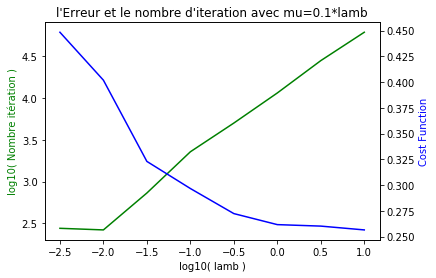

In [9]:
# Algo Pour Calculer l'Erreur et le nombre d'iteration avec mu=0.1*lamb

nitermax=300000

N=8
lamb=np.linspace(-2.5, 1.0, N)
mu=lamb-1
nb_iter = np.zeros(N)
cost_function = np.zeros(N)

step0 = 0.1
for i in range(N) :
    ux,uy,CF,step,n,cost_f=RecalageDG(f,g,10**lamb[i],10**mu[i],nitermax,step0)
    nb_iter[i] = n
    cost_function[i] = cost_f
    
print(lamb)
print(nb_iter)
print(cost_function)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(lamb, np.log10(nb_iter), 'g-')
ax2.plot(lamb, cost_function, 'b-')
ax1.set_xlabel('log10( lamb )')
ax1.set_ylabel('log10( Nombre itération )', color='g')
ax2.set_ylabel('Cost Function', color='b')
plt.title("l'Erreur et le nombre d'iteration avec mu=0.1*lamb")

plt.show()

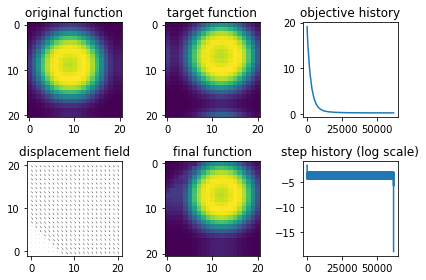

In [10]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

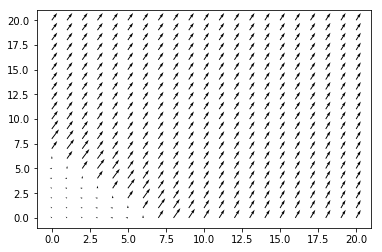

In [11]:
plt.quiver(ux, -uy)
plt.show()

4. Algorithme de moindres carrés.
=================================
On souhaite maintenant implémenter un algorithme de second ordre pour résoudre le problème $(P)\quad\min_u E(u)+R(u)$ afin d'accélérer la convergence de l'algorithme. Pour cela, on va reformuler le problème $(P)$ en un problème de moindres carrés et appliquer l'algorithme de Levenberg-Marquardt.

Soit:
$$\Psi(u)=\begin{pmatrix} 
f\circ(Id+u)-g \\ 
\sqrt{\mu}(\partial_xu_y+\partial_yu_x) \\ 
\sqrt{\mu+\lambda}(\partial_xu_x+\partial_yu_y) \end{pmatrix},$$
où $f\circ(id+u)$ est l'interpolation de $x\mapsto f(x+u(x))$ sur la grille. Minimiser $E(u)+R(u)$ est équivalent à résoudre le problème suivant:

>$$\min_u \|\Psi(u)\|_2^2.$$

Il s'agit maintenant d'un problème de moindres carrés que l'on va résoudre à l'aide de l'algorithme de Levenberg Marquardt :

$$
u_{k+1}=u_k- H_k^{-1} J_{\Psi}(u_k)^\top \Psi(u_k) \quad\mbox{ avec }\quad H_k=J_{\Psi}(u_k)^\top J_{\Psi}(u_k) +\varepsilon Id
$$

Q6. Calculer la matrice jacobienne de $\Psi$, notée $J_\Psi(u)$.

Q7. Implémenter les fonctions JPsi, JTPsi et JTJ qui calculent respectivement:
- le produit de $J_\psi(u)$ par une direction $v=(v_x,v_y)\in V^2$,

- le produit de $J_\Psi(u)^\top$ par $\phi=(\phi_1,\phi_2,\phi_3)\in V^3$,

- le produit de $(J_\Psi(u)^\top J_\Psi(u)+\epsilon I)$ par une direction $v=(v_x,v_y)\in V^2$.

In [12]:
def JPsi(vx,vy,df,lamb,mu) :
    JPsi0 = df[0]*vx + df[1] *vy
    JPsi1 = np.sqrt(mu) * (dy(vx)+dx(vy))
    JPsi2 = np.sqrt(mu+lamb) * (dx(vx)+dy(vy)) 
    return [JPsi0,JPsi1,JPsi2]

def JTPsi(phi,df,lamb,mu) :    
    ux = df[0]*phi[0] + np.sqrt(mu)*dyT(phi[1]) + np.sqrt(mu+lamb)*dxT(phi[2])
    uy = df[1]*phi[0] + np.sqrt(mu)*dxT(phi[1]) + np.sqrt(mu+lamb)*dyT(phi[2])
    return [ux,uy]
  
def JTJ(vx,vy,df,lamb,mu,epsilon) :
    phi=JPsi(vx,vy,df,lamb,mu) 
    uxs,uys = JTPsi(phi,df,lamb,mu)
    uxs = uxs + epsilon*vx
    uys = uys + epsilon*vy 
    return uxs,uys

Calculons maintenant la direction de recherche $d_k$ comme solution du système linéaire:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = -J_\Psi(u_k)^\top \Psi(u_k)$$
Pour cela, on vous donne l'algorithme suivant qui par la méthode du gradient conjugué calcule une solution $d=(d_x,d_y)\in V^2$ du problème:
$$(J_\Psi(u_k)^\top J_\Psi(u_k) +\epsilon I)\left(\begin{array}{c}
d_x\\
d_y
\end{array}\right) = b$$

In [13]:
 def CGSolve(u0x,u0y,lamb,mu,b,epsilon,df) :
    nitmax=100;
    ux=u0x; uy=u0y; #point de départ de l'algorithme
    # Computes JTJu
    Ax,Ay=JTJ(ux,uy,df,lamb,mu,epsilon);
    rx=b[0]-Ax
    ry=b[1]-Ay
    px=rx
    py=ry
    rsold=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
    for i in range(nitmax) :
        Apx,Apy=JTJ(px,py,df,lamb,mu,epsilon);
        alpha=rsold/(np.vdot(rx[:],Apx[:])+np.vdot(ry[:],Apy[:]))
        ux=ux+alpha*px
        uy=uy+alpha*py
        rx=rx-alpha*Apx
        ry=ry-alpha*Apy
        rsnew=np.linalg.norm(rx)**2+np.linalg.norm(ry)**2
        if np.sqrt(rsnew)<1e-10 :
            return [ux,uy]
        px=rx+rsnew/rsold*px
        py=ry+rsnew/rsold*py
        rsold=rsnew
    return [ux,uy]

Q8. Compléter l'algorithme RecalageGN implémentant la méthode de Levenberg-Marquardt.

In [14]:
def RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi) : 
    ux=np.zeros(f.shape)
    uy=np.zeros(f.shape)  
    descentx=np.zeros(f.shape)
    descenty=np.zeros(f.shape)  
    CF=[]
    step_list=[]
    niter=0
    step=stepini
    dxf=dx(f)
    dyf=dy(f)
    while niter < nitermax and step > 1.e-8 : 
        niter+=1
        obj,fu=objective_function(f,g,ux,uy,lamb,mu)
        CF.append(obj)
        # Gradient of F at point u
        dfx = interpol(dxf,ux,uy)
        dfy = interpol(dyf,ux,uy)
        df = [dfx,dfy]
        
        psi0=fu-g
        psi1=np.sqrt(mu)*(dx(uy)+dy(ux))
        psi2=np.sqrt(mu+lamb)*(dx(ux)+dy(uy))
        b = JTPsi([psi0,psi1,psi2],df,lamb,mu)                         
        
        [descentx,descenty]=CGSolve(descentx,descenty,lamb,mu,b,epsi,df)
        ux,uy,step=linesearch(ux,uy,step,descentx,descenty,obj,f,g,lamb,mu)
        step_list.append(step)
        # Display
        #if (niter % 1 ==0) :
            #print('iteration :',niter,' cost function :',obj,'step :',step)
    return ux,uy,np.array(CF),np.array(step_list),niter,obj

Q9. Tester le nouvel algorithme et comparer sa vitesse de convergence avec celle de l'algorithme de gradient.

In [15]:
#TEST AVEC LES PARAMETRE OPTIMAUX POUR LA PREMIERE METHODE, LA DEUXIEME A LES MEMES

nitermax=300000
epsi=0.1
stepini = 0.1
step0 = 0.1

N=8
lamb=np.linspace(-2.5, 1.0, N)
mu=lamb-1

nb_iter = np.zeros((N,2))
cost_function = np.zeros((N,2))

for i in range(N) :
    print(i)
    ux0,uy0,CF0,step0,n0,cost_f0=RecalageDG(f,g,10**lamb[i],10**mu[i],nitermax,stepini)
    ux1,uy1,CF1,step1,n1,cost_f1=RecalageGN(f,g,10,10,nitermax,stepini,epsi)
    nb_iter[i,0] = n0
    nb_iter[i,1] = n1
    cost_function[i,0] = cost_f0
    cost_function[i,1] = cost_f1
    
print(lamb)
print(nb_iter)
print(cost_function)


0
iteration : 2  cost function : 18.947623157508986 step : 0.4
iteration : 4  cost function : 17.95248213851679 step : 1.6
iteration : 6  cost function : 14.380985837092105 step : 6.4
iteration : 8  cost function : 6.286833434784914 step : 25.6
iteration : 10  cost function : 2.6324167494653286 step : 51.2
iteration : 12  cost function : 2.3733485167297754 step : 25.6
iteration : 14  cost function : 1.469075359121992 step : 25.6
iteration : 16  cost function : 1.2238890604694868 step : 51.2
iteration : 18  cost function : 1.1453040464148598 step : 25.6
iteration : 20  cost function : 1.0893166453816445 step : 51.2
iteration : 22  cost function : 1.0046526725367875 step : 25.6
iteration : 24  cost function : 0.9451081283313723 step : 51.2
iteration : 26  cost function : 0.9016698729664968 step : 25.6
iteration : 28  cost function : 0.8456959051476765 step : 25.6
iteration : 30  cost function : 0.7979564780957096 step : 51.2
iteration : 32  cost function : 0.7623776645999983 step : 25.6


1
iteration : 2  cost function : 18.94765888696814 step : 0.4
iteration : 4  cost function : 17.95518836718767 step : 1.6
iteration : 6  cost function : 14.42899202642246 step : 6.4
iteration : 8  cost function : 6.660685079868339 step : 25.6
iteration : 10  cost function : 3.321148392652209 step : 25.6
iteration : 12  cost function : 2.5082932725237805 step : 12.8
iteration : 14  cost function : 1.7007244969216537 step : 12.8
iteration : 16  cost function : 1.474101236154628 step : 12.8
iteration : 18  cost function : 1.3266664523755831 step : 12.8
iteration : 20  cost function : 1.12659121495718 step : 25.6
iteration : 22  cost function : 1.0277418865126728 step : 12.8
iteration : 24  cost function : 0.9744056792018765 step : 12.8
iteration : 26  cost function : 0.9148306605256397 step : 25.6
iteration : 28  cost function : 0.8781665464562924 step : 12.8
iteration : 30  cost function : 0.851298469138168 step : 12.8
iteration : 32  cost function : 0.8221288245838025 step : 25.6
iterat

2
iteration : 2  cost function : 18.947771873438633 step : 0.4
iteration : 4  cost function : 17.963630892596886 step : 1.6
iteration : 6  cost function : 14.570915595272389 step : 6.4
iteration : 8  cost function : 7.540578945650613 step : 25.6
iteration : 10  cost function : 4.1963711491057785 step : 6.4
iteration : 12  cost function : 3.418538212378205 step : 6.4
iteration : 14  cost function : 2.9110349404152926 step : 6.4
iteration : 16  cost function : 2.596065140114386 step : 6.4
iteration : 18  cost function : 2.349255246789663 step : 6.4
iteration : 20  cost function : 2.1467353626547765 step : 6.4
iteration : 22  cost function : 1.9781904595425215 step : 6.4
iteration : 24  cost function : 1.8374750715580106 step : 6.4
iteration : 26  cost function : 1.719822210057104 step : 6.4
iteration : 28  cost function : 1.6212523519444142 step : 6.4
iteration : 30  cost function : 1.5386418272460491 step : 6.4
iteration : 32  cost function : 1.4696230161095813 step : 6.4
iteration : 34

iteration : 312  cost function : 0.3780510649626241 step : 6.4
iteration : 314  cost function : 0.37777015271596687 step : 6.4
iteration : 316  cost function : 0.37573009566410986 step : 6.4
iteration : 318  cost function : 0.3746740636432081 step : 12.8
iteration : 320  cost function : 0.3742170838763849 step : 6.4
iteration : 322  cost function : 0.373818689700874 step : 6.4
iteration : 324  cost function : 0.37357628588859787 step : 6.4
iteration : 326  cost function : 0.3715690265608055 step : 6.4
iteration : 328  cost function : 0.3705717406439005 step : 12.8
iteration : 330  cost function : 0.37017324814739383 step : 6.4
iteration : 332  cost function : 0.3698140322329061 step : 6.4
iteration : 334  cost function : 0.3696109079398643 step : 6.4
iteration : 336  cost function : 0.3676323490498866 step : 6.4
iteration : 338  cost function : 0.3666931875815218 step : 12.8
iteration : 340  cost function : 0.3663539026744054 step : 6.4
iteration : 342  cost function : 0.36603403171710

iteration : 616  cost function : 0.3308562762662283 step : 12.8
iteration : 618  cost function : 0.33063225451509 step : 6.4
iteration : 620  cost function : 0.3305165300516285 step : 6.4
iteration : 622  cost function : 0.33043492253101636 step : 6.4
iteration : 624  cost function : 0.33040333477478123 step : 3.2
iteration : 626  cost function : 0.3297846861127185 step : 12.8
iteration : 628  cost function : 0.32957412352328946 step : 6.4
iteration : 630  cost function : 0.3294659468631571 step : 6.4
iteration : 632  cost function : 0.3293939211913931 step : 6.4
iteration : 634  cost function : 0.32937464692067275 step : 3.2
iteration : 636  cost function : 0.3287389819238734 step : 12.8
iteration : 638  cost function : 0.328548270691253 step : 6.4
iteration : 640  cost function : 0.3284506671770796 step : 6.4
iteration : 642  cost function : 0.32839125359389654 step : 6.4
iteration : 644  cost function : 0.32790580477567366 step : 6.4
iteration : 646  cost function : 0.32766320895648

iteration : 158  cost function : 0.7153880648958209 step : 1.6
iteration : 160  cost function : 0.7085799304138253 step : 3.2
iteration : 162  cost function : 0.7034330041297008 step : 3.2
iteration : 164  cost function : 0.6984997549922947 step : 3.2
iteration : 166  cost function : 0.6937824988671862 step : 3.2
iteration : 168  cost function : 0.6892883337216469 step : 1.6
iteration : 170  cost function : 0.6850286827049641 step : 1.6
iteration : 172  cost function : 0.6810231179793937 step : 1.6
iteration : 174  cost function : 0.6773010193045319 step : 1.6
iteration : 176  cost function : 0.6739050217438585 step : 1.6
iteration : 178  cost function : 0.6683128652941255 step : 3.2
iteration : 180  cost function : 0.6644252705250722 step : 3.2
iteration : 182  cost function : 0.6606830832257151 step : 3.2
iteration : 184  cost function : 0.6570897584290878 step : 3.2
iteration : 186  cost function : 0.6536542192080067 step : 1.6
iteration : 188  cost function : 0.6503905246712876 ste

iteration : 470  cost function : 0.4368819672961435 step : 1.6
iteration : 472  cost function : 0.4361123395151153 step : 1.6
iteration : 474  cost function : 0.435368624924201 step : 1.6
iteration : 476  cost function : 0.4346577763640659 step : 1.6
iteration : 478  cost function : 0.43398911472877444 step : 1.6
iteration : 480  cost function : 0.4329234468867788 step : 3.2
iteration : 482  cost function : 0.43213501851512565 step : 3.2
iteration : 484  cost function : 0.4313577620056417 step : 3.2
iteration : 486  cost function : 0.43059370327346197 step : 3.2
iteration : 488  cost function : 0.4298455661867345 step : 1.6
iteration : 490  cost function : 0.4291170122428023 step : 1.6
iteration : 492  cost function : 0.4284129480859742 step : 1.6
iteration : 494  cost function : 0.427739961201526 step : 1.6
iteration : 496  cost function : 0.4271068803060018 step : 1.6
iteration : 498  cost function : 0.426097824780704 step : 3.2
iteration : 500  cost function : 0.42535124524532697 st

iteration : 780  cost function : 0.35437560098959553 step : 1.6
iteration : 782  cost function : 0.35406459841980076 step : 1.6
iteration : 784  cost function : 0.3537705931552664 step : 1.6
iteration : 786  cost function : 0.35332316605873454 step : 3.2
iteration : 788  cost function : 0.35298028740410137 step : 3.2
iteration : 790  cost function : 0.3526418109415051 step : 3.2
iteration : 792  cost function : 0.3523085670583107 step : 3.2
iteration : 794  cost function : 0.3519816709041167 step : 1.6
iteration : 796  cost function : 0.3516626197484437 step : 1.6
iteration : 798  cost function : 0.3513534200355052 step : 1.6
iteration : 800  cost function : 0.3510567635450983 step : 1.6
iteration : 802  cost function : 0.3507762574284062 step : 1.6
iteration : 804  cost function : 0.3503505712716415 step : 3.2
iteration : 806  cost function : 0.3500236840432212 step : 3.2
iteration : 808  cost function : 0.3497009878173137 step : 3.2
iteration : 810  cost function : 0.3493832706698204

iteration : 1090  cost function : 0.3197658875885538 step : 1.6
iteration : 1092  cost function : 0.3195893747780119 step : 3.2
iteration : 1094  cost function : 0.31946122982214764 step : 3.2
iteration : 1096  cost function : 0.3193351356725826 step : 3.2
iteration : 1098  cost function : 0.3192114383482098 step : 3.2
iteration : 1100  cost function : 0.3190906025486079 step : 1.6
iteration : 1102  cost function : 0.31897325215290884 step : 1.6
iteration : 1104  cost function : 0.3188602234620337 step : 1.6
iteration : 1106  cost function : 0.3187526382290259 step : 1.6
iteration : 1108  cost function : 0.3186519998825812 step : 1.6
iteration : 1110  cost function : 0.3184857698246115 step : 3.2
iteration : 1112  cost function : 0.31836618635524405 step : 3.2
iteration : 1114  cost function : 0.3182485666387377 step : 3.2
iteration : 1116  cost function : 0.31813323879686306 step : 3.2
iteration : 1118  cost function : 0.3180206436778168 step : 1.6
iteration : 1120  cost function : 0.

iteration : 1396  cost function : 0.3089145627270036 step : 3.2
iteration : 1398  cost function : 0.3088829131173645 step : 3.2
iteration : 1400  cost function : 0.30885192865512107 step : 3.2
iteration : 1402  cost function : 0.3088217132903601 step : 1.6
iteration : 1404  cost function : 0.3087924080992714 step : 1.6
iteration : 1406  cost function : 0.30876420162677226 step : 1.6
iteration : 1408  cost function : 0.3087373490144876 step : 1.6
iteration : 1410  cost function : 0.3087121929348162 step : 1.6
iteration : 1412  cost function : 0.30867273003283463 step : 3.2
iteration : 1414  cost function : 0.3086433831104691 step : 3.2
iteration : 1416  cost function : 0.30861457916017515 step : 3.2
iteration : 1418  cost function : 0.30858639065430415 step : 3.2
iteration : 1420  cost function : 0.3085589160659743 step : 1.6
iteration : 1422  cost function : 0.3085322891749448 step : 1.6
iteration : 1424  cost function : 0.3085066886372978 step : 1.6
iteration : 1426  cost function : 0

iteration : 1704  cost function : 0.30392698757035397 step : 1.6
iteration : 1706  cost function : 0.3038926405787565 step : 1.6
iteration : 1708  cost function : 0.30383914585184446 step : 3.2
iteration : 1710  cost function : 0.3037987092348943 step : 3.2
iteration : 1712  cost function : 0.3037587243628681 step : 3.2
iteration : 1714  cost function : 0.3037192908173773 step : 3.2
iteration : 1716  cost function : 0.30368054607569883 step : 1.6
iteration : 1718  cost function : 0.30364267438934583 step : 1.6
iteration : 1720  cost function : 0.3036059207320058 step : 1.6
iteration : 1722  cost function : 0.30357061400534685 step : 1.6
iteration : 1724  cost function : 0.30353719403588386 step : 1.6
iteration : 1726  cost function : 0.3034860075582639 step : 3.2
iteration : 1728  cost function : 0.3034468434922687 step : 3.2
iteration : 1730  cost function : 0.30340811787016114 step : 3.2
iteration : 1732  cost function : 0.30336992778764876 step : 3.2
iteration : 1734  cost function 

iteration : 2014  cost function : 0.2994037083798711 step : 1.6
iteration : 2016  cost function : 0.2993786858654509 step : 3.2
iteration : 2018  cost function : 0.2993608877567496 step : 3.2
iteration : 2020  cost function : 0.2993433603591327 step : 3.2
iteration : 2022  cost function : 0.2993261550453579 step : 3.2
iteration : 2024  cost function : 0.2993093411847492 step : 1.6
iteration : 2026  cost function : 0.29929301156395655 step : 1.6
iteration : 2028  cost function : 0.2992772891708908 step : 1.6
iteration : 2030  cost function : 0.29926233824527215 step : 1.6
iteration : 2032  cost function : 0.29924837761259465 step : 1.6
iteration : 2034  cost function : 0.2992248618089081 step : 3.2
iteration : 2036  cost function : 0.29920817085092966 step : 3.2
iteration : 2038  cost function : 0.2991917604698821 step : 3.2
iteration : 2040  cost function : 0.2991756801103268 step : 3.2
iteration : 2042  cost function : 0.29915999516838443 step : 1.6
iteration : 2044  cost function : 0

4
iteration : 2  cost function : 18.94925903273511 step : 0.4
iteration : 4  cost function : 18.060175845785967 step : 1.6
iteration : 6  cost function : 15.63331253566317 step : 6.4
iteration : 8  cost function : 10.758215226206984 step : 3.2
iteration : 10  cost function : 10.097433057638556 step : 1.6
iteration : 12  cost function : 9.949415905660137 step : 0.8
iteration : 14  cost function : 9.515100624239206 step : 0.8
iteration : 16  cost function : 9.345258942701843 step : 0.4
iteration : 18  cost function : 9.002773099557922 step : 1.6
iteration : 20  cost function : 8.724619475691982 step : 0.8
iteration : 22  cost function : 8.55474700171639 step : 0.4
iteration : 24  cost function : 8.263300755334127 step : 1.6
iteration : 26  cost function : 8.011367564876988 step : 0.8
iteration : 28  cost function : 7.881049093383017 step : 0.4
iteration : 30  cost function : 7.594366545323022 step : 1.6
iteration : 32  cost function : 7.364873407711344 step : 0.8
iteration : 34  cost fun

iteration : 310  cost function : 1.0309734801978678 step : 0.8
iteration : 312  cost function : 1.0269464349873487 step : 0.8
iteration : 314  cost function : 1.0210033843997897 step : 0.8
iteration : 316  cost function : 1.0181259858038625 step : 0.4
iteration : 318  cost function : 1.009274343432757 step : 0.8
iteration : 320  cost function : 1.0055448903296327 step : 0.8
iteration : 322  cost function : 0.999913546789983 step : 0.8
iteration : 324  cost function : 0.9973654407620651 step : 0.4
iteration : 326  cost function : 0.9889080996016625 step : 0.8
iteration : 328  cost function : 0.9854440649931482 step : 0.8
iteration : 330  cost function : 0.9800978194619253 step : 0.8
iteration : 332  cost function : 0.9778358930074386 step : 0.4
iteration : 334  cost function : 0.9697442152781577 step : 0.8
iteration : 336  cost function : 0.9665162935407627 step : 0.8
iteration : 338  cost function : 0.9614310226906564 step : 0.8
iteration : 340  cost function : 0.957437221728576 step :

iteration : 618  cost function : 0.6200416829601578 step : 0.8
iteration : 620  cost function : 0.618771026714455 step : 0.8
iteration : 622  cost function : 0.6179983049441748 step : 0.4
iteration : 624  cost function : 0.616150935222066 step : 1.6
iteration : 626  cost function : 0.6143619604125703 step : 0.8
iteration : 628  cost function : 0.6137078459937879 step : 0.4
iteration : 630  cost function : 0.6113029397474306 step : 0.8
iteration : 632  cost function : 0.6103288511022633 step : 0.8
iteration : 634  cost function : 0.6087998089892414 step : 0.8
iteration : 636  cost function : 0.6081408781743934 step : 0.4
iteration : 638  cost function : 0.6058027190110136 step : 0.8
iteration : 640  cost function : 0.6048433405192111 step : 0.8
iteration : 642  cost function : 0.6033519284694114 step : 0.8
iteration : 644  cost function : 0.6026883515643221 step : 0.4
iteration : 646  cost function : 0.6004148420268806 step : 0.8
iteration : 648  cost function : 0.5994697305158256 step 

iteration : 924  cost function : 0.4649319502716778 step : 0.8
iteration : 926  cost function : 0.46443831456454665 step : 0.8
iteration : 928  cost function : 0.4636784367082037 step : 0.8
iteration : 930  cost function : 0.4633271670028859 step : 0.4
iteration : 932  cost function : 0.46217171071814167 step : 0.8
iteration : 934  cost function : 0.46168240745661654 step : 0.8
iteration : 936  cost function : 0.4609397272807252 step : 0.8
iteration : 938  cost function : 0.46058118152501304 step : 0.4
iteration : 940  cost function : 0.45945712073602807 step : 0.8
iteration : 942  cost function : 0.4589721613728338 step : 0.8
iteration : 944  cost function : 0.458246207552919 step : 0.8
iteration : 946  cost function : 0.4578808755836533 step : 0.4
iteration : 948  cost function : 0.4567872497513833 step : 0.8
iteration : 950  cost function : 0.45630664385917635 step : 0.8
iteration : 952  cost function : 0.45559695937659994 step : 0.8
iteration : 954  cost function : 0.45522531269502

iteration : 1230  cost function : 0.38528716704546384 step : 0.8
iteration : 1232  cost function : 0.38501493768107664 step : 0.4
iteration : 1234  cost function : 0.3844517784529339 step : 0.8
iteration : 1236  cost function : 0.3841593170641567 step : 0.8
iteration : 1238  cost function : 0.3837764243509758 step : 0.8
iteration : 1240  cost function : 0.38350148104292714 step : 0.4
iteration : 1242  cost function : 0.38295297866396544 step : 1.6
iteration : 1244  cost function : 0.38248020688714707 step : 0.8
iteration : 1246  cost function : 0.3821636643427493 step : 0.8
iteration : 1248  cost function : 0.38201057486251383 step : 0.4
iteration : 1250  cost function : 0.3814762746194522 step : 1.6
iteration : 1252  cost function : 0.38101066232659087 step : 0.8
iteration : 1254  cost function : 0.38069756628321194 step : 0.8
iteration : 1256  cost function : 0.38054181919934477 step : 0.4
iteration : 1258  cost function : 0.38002128091043685 step : 1.6
iteration : 1260  cost functio

iteration : 1538  cost function : 0.3401088910105559 step : 0.8
iteration : 1540  cost function : 0.3399910528609789 step : 0.4
iteration : 1542  cost function : 0.3396291820947033 step : 0.8
iteration : 1544  cost function : 0.3394713528262998 step : 0.8
iteration : 1546  cost function : 0.33923700969628523 step : 0.8
iteration : 1548  cost function : 0.33911538101654887 step : 0.4
iteration : 1550  cost function : 0.3387633916125193 step : 0.8
iteration : 1552  cost function : 0.338606145883266 step : 0.8
iteration : 1554  cost function : 0.33837675724431304 step : 0.8
iteration : 1556  cost function : 0.33825157823599705 step : 0.4
iteration : 1558  cost function : 0.33790914244645714 step : 0.8
iteration : 1560  cost function : 0.3377525217660167 step : 0.8
iteration : 1562  cost function : 0.3375279467559321 step : 0.8
iteration : 1564  cost function : 0.3373994474730826 step : 0.4
iteration : 1566  cost function : 0.3370662490827121 step : 0.8
iteration : 1568  cost function : 0.

iteration : 1846  cost function : 0.31341276182744526 step : 0.8
iteration : 1848  cost function : 0.31329473780683725 step : 0.8
iteration : 1850  cost function : 0.31322339700893387 step : 0.4
iteration : 1852  cost function : 0.3130502396057081 step : 1.6
iteration : 1854  cost function : 0.31288288782586127 step : 0.8
iteration : 1856  cost function : 0.31282138724911707 step : 0.4
iteration : 1858  cost function : 0.31259572016015313 step : 0.8
iteration : 1860  cost function : 0.3125039921980356 step : 0.8
iteration : 1862  cost function : 0.31236049164378993 step : 0.8
iteration : 1864  cost function : 0.31229674831615223 step : 0.4
iteration : 1866  cost function : 0.312077467492902 step : 0.8
iteration : 1868  cost function : 0.3119858062737763 step : 0.8
iteration : 1870  cost function : 0.3118453673817105 step : 0.8
iteration : 1872  cost function : 0.3117787852918994 step : 0.4
iteration : 1874  cost function : 0.3115656293348864 step : 0.8
iteration : 1876  cost function :

iteration : 2152  cost function : 0.29752310232164586 step : 1.6
iteration : 2154  cost function : 0.29742194652511367 step : 0.8
iteration : 2156  cost function : 0.29735239911471617 step : 0.8
iteration : 2158  cost function : 0.29731283642408013 step : 0.4
iteration : 2160  cost function : 0.29720602788816525 step : 1.6
iteration : 2162  cost function : 0.2971061497391288 step : 0.8
iteration : 2164  cost function : 0.29703716632815047 step : 0.8
iteration : 2166  cost function : 0.29699694103001 step : 0.4
iteration : 2168  cost function : 0.2968928097639905 step : 1.6
iteration : 2170  cost function : 0.2967941913339303 step : 0.8
iteration : 2172  cost function : 0.29672577606712686 step : 0.8
iteration : 2174  cost function : 0.296684942023707 step : 0.4
iteration : 2176  cost function : 0.29658339954924895 step : 1.6
iteration : 2178  cost function : 0.2964860232503287 step : 0.8
iteration : 2180  cost function : 0.29641817980653895 step : 0.8
iteration : 2182  cost function : 

iteration : 2456  cost function : 0.2877761843066954 step : 0.8
iteration : 2458  cost function : 0.28775186451182067 step : 0.4
iteration : 2460  cost function : 0.2876839680876195 step : 1.6
iteration : 2462  cost function : 0.28762111235577115 step : 0.8
iteration : 2464  cost function : 0.28757787345655894 step : 0.8
iteration : 2466  cost function : 0.2875530988928199 step : 0.4
iteration : 2468  cost function : 0.2874869467780766 step : 1.6
iteration : 2470  cost function : 0.28742489461757365 step : 0.8
iteration : 2472  cost function : 0.28738200984410617 step : 0.8
iteration : 2474  cost function : 0.28735681782806366 step : 0.4
iteration : 2476  cost function : 0.2872923513808296 step : 1.6
iteration : 2478  cost function : 0.28723109234778904 step : 0.8
iteration : 2480  cost function : 0.28718856525955033 step : 0.8
iteration : 2482  cost function : 0.28716299138512424 step : 0.4
iteration : 2484  cost function : 0.2871001542242084 step : 1.6
iteration : 2486  cost function

iteration : 2762  cost function : 0.2816813395016372 step : 0.8
iteration : 2764  cost function : 0.28165367906022565 step : 0.8
iteration : 2766  cost function : 0.2816374620225235 step : 0.4
iteration : 2768  cost function : 0.28159578449297873 step : 1.6
iteration : 2770  cost function : 0.2815562422110174 step : 0.8
iteration : 2772  cost function : 0.2815288174707237 step : 0.8
iteration : 2774  cost function : 0.2815123486707346 step : 0.4
iteration : 2776  cost function : 0.2814717460304088 step : 1.6
iteration : 2778  cost function : 0.2814327202356528 step : 0.8
iteration : 2780  cost function : 0.28140553339863483 step : 0.8
iteration : 2782  cost function : 0.28138883570521 step : 0.4
iteration : 2784  cost function : 0.281349271470784 step : 1.6
iteration : 2786  cost function : 0.2813107554005773 step : 0.8
iteration : 2788  cost function : 0.28129591599123077 step : 0.4
iteration : 2790  cost function : 0.28124462357949365 step : 0.8
iteration : 2792  cost function : 0.28

iteration : 3068  cost function : 0.27792211952315243 step : 1.6
iteration : 3070  cost function : 0.27789898518573924 step : 0.8
iteration : 3072  cost function : 0.2778830470663086 step : 0.8
iteration : 3074  cost function : 0.2778736939931129 step : 0.4
iteration : 3076  cost function : 0.27784964429333225 step : 1.6
iteration : 3078  cost function : 0.277826850274076 step : 0.8
iteration : 3080  cost function : 0.27781107772126074 step : 0.8
iteration : 3082  cost function : 0.27780160614393146 step : 0.4
iteration : 3084  cost function : 0.277778206156593 step : 1.6
iteration : 3086  cost function : 0.2777557504401723 step : 0.8
iteration : 3088  cost function : 0.2777401463853471 step : 0.8
iteration : 3090  cost function : 0.27773057151764086 step : 0.4
iteration : 3092  cost function : 0.27770780068796297 step : 1.6
iteration : 3094  cost function : 0.27768568117851344 step : 0.8
iteration : 3096  cost function : 0.277677223768889 step : 0.4
iteration : 3098  cost function : 0

iteration : 3374  cost function : 0.2758347697087382 step : 0.4
iteration : 3376  cost function : 0.275821615741735 step : 1.6
iteration : 3378  cost function : 0.27580987200020496 step : 0.8
iteration : 3380  cost function : 0.27580195768275756 step : 0.8
iteration : 3382  cost function : 0.27579773263051544 step : 0.4
iteration : 3384  cost function : 0.2757849993095089 step : 1.6
iteration : 3386  cost function : 0.27577351499606695 step : 0.8
iteration : 3388  cost function : 0.2757657468951069 step : 0.8
iteration : 3390  cost function : 0.2757615073835086 step : 0.4
iteration : 3392  cost function : 0.2757491816126551 step : 1.6
iteration : 3394  cost function : 0.27573795421431324 step : 0.8
iteration : 3396  cost function : 0.27573033295294097 step : 0.8
iteration : 3398  cost function : 0.27572608665354315 step : 0.4
iteration : 3400  cost function : 0.27571415584807146 step : 1.6
iteration : 3402  cost function : 0.2757031828600126 step : 0.8
iteration : 3404  cost function :

iteration : 3682  cost function : 0.2749304586270225 step : 0.8
iteration : 3684  cost function : 0.2749279710840767 step : 0.8
iteration : 3686  cost function : 0.2749241966472087 step : 0.8
iteration : 3688  cost function : 0.2749219322048607 step : 0.8
iteration : 3690  cost function : 0.2749192295478077 step : 0.8
iteration : 3692  cost function : 0.2749168618874572 step : 0.8
iteration : 3694  cost function : 0.2749132572323977 step : 0.8
iteration : 3696  cost function : 0.27491110090517695 step : 0.8
iteration : 3698  cost function : 0.2749085221920161 step : 0.8
iteration : 3700  cost function : 0.27490627495895403 step : 0.8
iteration : 3702  cost function : 0.27490283552788664 step : 0.8
iteration : 3704  cost function : 0.27490078639338833 step : 0.8
iteration : 3706  cost function : 0.2748983290665031 step : 0.8
iteration : 3708  cost function : 0.2748962026507607 step : 0.8
iteration : 3710  cost function : 0.2748929240213208 step : 0.8
iteration : 3712  cost function : 0.

iteration : 3990  cost function : 0.2744642655030483 step : 0.8
iteration : 3992  cost function : 0.2744598845595154 step : 0.4
iteration : 3994  cost function : 0.2744495027354673 step : 1.6
iteration : 3996  cost function : 0.274439386430748 step : 0.8
iteration : 3998  cost function : 0.2744354200203719 step : 0.4
iteration : 4000  cost function : 0.2744219931773896 step : 0.8
iteration : 4002  cost function : 0.27441633884355865 step : 0.8
iteration : 4004  cost function : 0.2744076631163487 step : 0.8
iteration : 4006  cost function : 0.27440343535496353 step : 0.4
iteration : 4008  cost function : 0.27439039712103314 step : 0.8
iteration : 4010  cost function : 0.2743847083082253 step : 0.8
iteration : 4012  cost function : 0.2743762066349283 step : 0.8
iteration : 4014  cost function : 0.2743717384969125 step : 0.4
iteration : 4016  cost function : 0.2743590757106956 step : 0.8
iteration : 4018  cost function : 0.2743533599003496 step : 0.8
iteration : 4020  cost function : 0.27

iteration : 4296  cost function : 0.27328172635931564 step : 0.8
iteration : 4298  cost function : 0.2732759043106207 step : 0.8
iteration : 4300  cost function : 0.27326814797682275 step : 0.8
iteration : 4302  cost function : 0.27326304387697137 step : 0.8
iteration : 4304  cost function : 0.2732572644921458 step : 0.8
iteration : 4306  cost function : 0.2732514439282092 step : 0.8
iteration : 4308  cost function : 0.273243902499962 step : 0.8
iteration : 4310  cost function : 0.2732388556861169 step : 0.8
iteration : 4312  cost function : 0.2732332035157086 step : 0.8
iteration : 4314  cost function : 0.2732273902876195 step : 0.8
iteration : 4316  cost function : 0.27322005703969565 step : 0.8
iteration : 4318  cost function : 0.2732150688391575 step : 0.8
iteration : 4320  cost function : 0.27320954113537255 step : 0.8
iteration : 4322  cost function : 0.27320374075378506 step : 0.8
iteration : 4324  cost function : 0.2731966092292638 step : 0.8
iteration : 4326  cost function : 0

iteration : 4604  cost function : 0.2726051524548025 step : 0.8
iteration : 4606  cost function : 0.2726022258833071 step : 0.8
iteration : 4608  cost function : 0.2725988701567242 step : 0.8
iteration : 4610  cost function : 0.2725964599597752 step : 0.8
iteration : 4612  cost function : 0.27259386816566444 step : 0.8
iteration : 4614  cost function : 0.2725909876371043 step : 0.8
iteration : 4616  cost function : 0.2725877368381697 step : 0.8
iteration : 4618  cost function : 0.27258537840195274 step : 0.8
iteration : 4620  cost function : 0.27258285823747047 step : 0.8
iteration : 4622  cost function : 0.2725800249506565 step : 0.8
iteration : 4624  cost function : 0.2725768760155545 step : 0.8
iteration : 4626  cost function : 0.2725745691704777 step : 0.8
iteration : 4628  cost function : 0.2725721190726053 step : 0.8
iteration : 4630  cost function : 0.2725693341104527 step : 0.8
iteration : 4632  cost function : 0.2725662840839677 step : 0.8
iteration : 4634  cost function : 0.2

iteration : 4902  cost function : 0.2723420695831432 step : 0.8
iteration : 4904  cost function : 0.27234132556309854 step : 0.8
iteration : 4906  cost function : 0.27234052212251825 step : 0.8
iteration : 4908  cost function : 0.272339636314717 step : 0.8
iteration : 4910  cost function : 0.272338653604478 step : 0.8
iteration : 4912  cost function : 0.2723379423841521 step : 0.8
iteration : 4914  cost function : 0.2723371731250157 step : 0.8
iteration : 4916  cost function : 0.2723363276877395 step : 0.8
iteration : 4918  cost function : 0.2723353872322625 step : 0.8
iteration : 4920  cost function : 0.27233470830279605 step : 0.8
iteration : 4922  cost function : 0.2723339724418484 step : 0.8
iteration : 4924  cost function : 0.2723332152870896 step : 0.8
iteration : 4926  cost function : 0.27233245355099006 step : 0.8
iteration : 4928  cost function : 0.2723319948530309 step : 0.8
iteration : 4930  cost function : 0.27233143908039814 step : 0.8
iteration : 4932  cost function : 0.2

iteration : 152  cost function : 9.317763127582957 step : 0.2
iteration : 154  cost function : 9.287161469271807 step : 0.2
iteration : 156  cost function : 9.210640503456382 step : 0.2
iteration : 158  cost function : 9.140978808087349 step : 0.2
iteration : 160  cost function : 9.076118465576409 step : 0.2
iteration : 162  cost function : 9.014654714964497 step : 0.2
iteration : 164  cost function : 8.955647204633127 step : 0.2
iteration : 166  cost function : 8.898422369934258 step : 0.4
iteration : 168  cost function : 8.85390298338716 step : 0.2
iteration : 170  cost function : 8.787110009984412 step : 0.2
iteration : 172  cost function : 8.72497541028858 step : 0.2
iteration : 174  cost function : 8.666135611170425 step : 0.2
iteration : 176  cost function : 8.609659056068566 step : 0.2
iteration : 178  cost function : 8.5549090520833 step : 0.4
iteration : 180  cost function : 8.513100386371908 step : 0.2
iteration : 182  cost function : 8.449071300016763 step : 0.2
iteration : 

iteration : 452  cost function : 3.811425819637784 step : 0.2
iteration : 454  cost function : 3.791843045291797 step : 0.2
iteration : 456  cost function : 3.772948073974991 step : 0.2
iteration : 458  cost function : 3.761188392197915 step : 0.2
iteration : 460  cost function : 3.738380119016621 step : 0.2
iteration : 462  cost function : 3.717412625449497 step : 0.2
iteration : 464  cost function : 3.6977409763301843 step : 0.2
iteration : 466  cost function : 3.6789923762830856 step : 0.2
iteration : 468  cost function : 3.6609117337705244 step : 0.2
iteration : 470  cost function : 3.650038540886964 step : 0.2
iteration : 472  cost function : 3.6281132370114992 step : 0.2
iteration : 474  cost function : 3.6079885531835747 step : 0.2
iteration : 476  cost function : 3.589130437551931 step : 0.2
iteration : 478  cost function : 3.571173565832419 step : 0.2
iteration : 480  cost function : 3.553867948758347 step : 0.2
iteration : 482  cost function : 3.5438312055753807 step : 0.2
it

iteration : 754  cost function : 2.037952578963201 step : 0.2
iteration : 756  cost function : 2.030989622994852 step : 0.2
iteration : 758  cost function : 2.02429935081686 step : 0.2
iteration : 760  cost function : 2.017806194725868 step : 0.4
iteration : 762  cost function : 2.012893520059583 step : 0.2
iteration : 764  cost function : 2.0052553924672933 step : 0.2
iteration : 766  cost function : 1.9981508812085902 step : 0.2
iteration : 768  cost function : 1.9914215486826685 step : 0.2
iteration : 770  cost function : 1.9849589835720478 step : 0.2
iteration : 772  cost function : 1.9786889818160365 step : 0.4
iteration : 774  cost function : 1.9740231212540467 step : 0.2
iteration : 776  cost function : 1.9666260591446312 step : 0.2
iteration : 778  cost function : 1.9597520828776136 step : 0.2
iteration : 780  cost function : 1.9532455979531165 step : 0.2
iteration : 782  cost function : 1.9470001403125823 step : 0.2
iteration : 784  cost function : 1.9409428409142766 step : 0.

iteration : 1062  cost function : 1.3356899866958962 step : 0.2
iteration : 1064  cost function : 1.3318478203240138 step : 0.2
iteration : 1066  cost function : 1.3283388025116711 step : 0.2
iteration : 1068  cost function : 1.3250610467245623 step : 0.2
iteration : 1070  cost function : 1.3219448582496134 step : 0.2
iteration : 1072  cost function : 1.318942557090665 step : 0.2
iteration : 1074  cost function : 1.3174757669015003 step : 0.2
iteration : 1076  cost function : 1.3137221672290833 step : 0.2
iteration : 1078  cost function : 1.3102957665415835 step : 0.2
iteration : 1080  cost function : 1.307096431194534 step : 0.2
iteration : 1082  cost function : 1.304055666071593 step : 0.2
iteration : 1084  cost function : 1.3011266124286487 step : 0.2
iteration : 1086  cost function : 1.2982772077925384 step : 0.4
iteration : 1088  cost function : 1.2960491752403862 step : 0.2
iteration : 1090  cost function : 1.2927025495916324 step : 0.2
iteration : 1092  cost function : 1.2895788

iteration : 1370  cost function : 0.9793426521598895 step : 0.2
iteration : 1372  cost function : 0.9776065763732198 step : 0.2
iteration : 1374  cost function : 0.9759209952509077 step : 0.4
iteration : 1376  cost function : 0.9747409822499893 step : 0.2
iteration : 1378  cost function : 0.9727218198926714 step : 0.2
iteration : 1380  cost function : 0.9708478358820312 step : 0.2
iteration : 1382  cost function : 0.9690746051580982 step : 0.2
iteration : 1384  cost function : 0.9673717404291191 step : 0.2
iteration : 1386  cost function : 0.9657184544770648 step : 0.4
iteration : 1388  cost function : 0.9645636232445833 step : 0.2
iteration : 1390  cost function : 0.9625823717112589 step : 0.2
iteration : 1392  cost function : 0.9607437566245913 step : 0.2
iteration : 1394  cost function : 0.9590041168487093 step : 0.2
iteration : 1396  cost function : 0.9573335877790943 step : 0.2
iteration : 1398  cost function : 0.9557117399001678 step : 0.4
iteration : 1400  cost function : 0.9545

iteration : 1680  cost function : 0.7663536873149648 step : 0.2
iteration : 1682  cost function : 0.7652163426256762 step : 0.2
iteration : 1684  cost function : 0.7641240510375228 step : 0.2
iteration : 1686  cost function : 0.7630633694220497 step : 0.4
iteration : 1688  cost function : 0.7623288465724045 step : 0.2
iteration : 1690  cost function : 0.7610548951837067 step : 0.2
iteration : 1692  cost function : 0.7598727498058127 step : 0.2
iteration : 1694  cost function : 0.7587541755978409 step : 0.2
iteration : 1696  cost function : 0.7576798610954567 step : 0.2
iteration : 1698  cost function : 0.7566365971629877 step : 0.4
iteration : 1700  cost function : 0.7559132726266313 step : 0.2
iteration : 1702  cost function : 0.754660429745917 step : 0.2
iteration : 1704  cost function : 0.7534977855842131 step : 0.2
iteration : 1706  cost function : 0.7523975968790175 step : 0.2
iteration : 1708  cost function : 0.7513408884401584 step : 0.2
iteration : 1710  cost function : 0.75031

iteration : 1990  cost function : 0.6282563548527889 step : 0.2
iteration : 1992  cost function : 0.627465883799343 step : 0.2
iteration : 1994  cost function : 0.6267161696974246 step : 0.2
iteration : 1996  cost function : 0.6259948087570875 step : 0.2
iteration : 1998  cost function : 0.6252933172766735 step : 0.4
iteration : 2000  cost function : 0.6247813861315283 step : 0.2
iteration : 2002  cost function : 0.6239451462789081 step : 0.2
iteration : 2004  cost function : 0.6231667557805104 step : 0.2
iteration : 2006  cost function : 0.6224283995607076 step : 0.2
iteration : 2008  cost function : 0.6217178935795193 step : 0.2
iteration : 2010  cost function : 0.6210269010185818 step : 0.4
iteration : 2012  cost function : 0.6205211388686068 step : 0.2
iteration : 2014  cost function : 0.6196977856564418 step : 0.2
iteration : 2016  cost function : 0.6189312558291755 step : 0.2
iteration : 2018  cost function : 0.6182040501077489 step : 0.2
iteration : 2020  cost function : 0.61750

iteration : 2296  cost function : 0.535904109793143 step : 0.2
iteration : 2298  cost function : 0.5354190326500259 step : 0.4
iteration : 2300  cost function : 0.5350355974487845 step : 0.2
iteration : 2302  cost function : 0.5344647502578446 step : 0.2
iteration : 2304  cost function : 0.5339307626976548 step : 0.2
iteration : 2306  cost function : 0.5334222885254911 step : 0.2
iteration : 2308  cost function : 0.532931568161541 step : 0.2
iteration : 2310  cost function : 0.5326888302188119 step : 0.2
iteration : 2312  cost function : 0.5320738524246085 step : 0.2
iteration : 2314  cost function : 0.5315113618791152 step : 0.2
iteration : 2316  cost function : 0.5309850667071216 step : 0.2
iteration : 2318  cost function : 0.5304838255843904 step : 0.2
iteration : 2320  cost function : 0.5300000102217921 step : 0.2
iteration : 2322  cost function : 0.5297587100201228 step : 0.2
iteration : 2324  cost function : 0.5291528843540311 step : 0.2
iteration : 2326  cost function : 0.528598

iteration : 2604  cost function : 0.47148781988818705 step : 0.2
iteration : 2606  cost function : 0.47113276737165966 step : 0.2
iteration : 2608  cost function : 0.47078893392743015 step : 0.2
iteration : 2610  cost function : 0.47058376600484686 step : 0.2
iteration : 2612  cost function : 0.47016170682009173 step : 0.2
iteration : 2614  cost function : 0.4697727680916529 step : 0.2
iteration : 2616  cost function : 0.4694066738614383 step : 0.2
iteration : 2618  cost function : 0.4690563979315441 step : 0.2
iteration : 2620  cost function : 0.4687171360075597 step : 0.2
iteration : 2622  cost function : 0.468513099118433 step : 0.2
iteration : 2624  cost function : 0.4680970578382616 step : 0.2
iteration : 2626  cost function : 0.4677135283092205 step : 0.2
iteration : 2628  cost function : 0.46735242387719855 step : 0.2
iteration : 2630  cost function : 0.4670068477999393 step : 0.2
iteration : 2632  cost function : 0.4666720843142622 step : 0.2
iteration : 2634  cost function : 0

iteration : 2912  cost function : 0.4256523292447002 step : 0.2
iteration : 2914  cost function : 0.4253755136731732 step : 0.2
iteration : 2916  cost function : 0.4251130041170311 step : 0.2
iteration : 2918  cost function : 0.4248604098334876 step : 0.2
iteration : 2920  cost function : 0.4246147288850092 step : 0.4
iteration : 2922  cost function : 0.4244365244230677 step : 0.2
iteration : 2924  cost function : 0.4241429917694036 step : 0.2
iteration : 2926  cost function : 0.42386979833935223 step : 0.2
iteration : 2928  cost function : 0.42361064290382694 step : 0.2
iteration : 2930  cost function : 0.42336121743256494 step : 0.2
iteration : 2932  cost function : 0.4231185765479101 step : 0.4
iteration : 2934  cost function : 0.42294134214551077 step : 0.2
iteration : 2936  cost function : 0.42265175619334094 step : 0.2
iteration : 2938  cost function : 0.4223821275894247 step : 0.2
iteration : 2940  cost function : 0.42212627385609397 step : 0.2
iteration : 2942  cost function : 

iteration : 3218  cost function : 0.3922167709153781 step : 0.2
iteration : 3220  cost function : 0.3921099080610576 step : 0.2
iteration : 3222  cost function : 0.3918802466940483 step : 0.2
iteration : 3224  cost function : 0.3916689246295101 step : 0.2
iteration : 3226  cost function : 0.39147023164680905 step : 0.2
iteration : 3228  cost function : 0.3912802640507044 step : 0.2
iteration : 3230  cost function : 0.39109635311921287 step : 0.2
iteration : 3232  cost function : 0.3909894472613893 step : 0.2
iteration : 3234  cost function : 0.3907627900280537 step : 0.2
iteration : 3236  cost function : 0.3905541229961118 step : 0.2
iteration : 3238  cost function : 0.3903578450454844 step : 0.2
iteration : 3240  cost function : 0.3901701270761513 step : 0.2
iteration : 3242  cost function : 0.38998835136998705 step : 0.2
iteration : 3244  cost function : 0.389881415915099 step : 0.2
iteration : 3246  cost function : 0.389657715323677 step : 0.2
iteration : 3248  cost function : 0.389

iteration : 3526  cost function : 0.3669848325725623 step : 0.2
iteration : 3528  cost function : 0.3668422383708714 step : 0.2
iteration : 3530  cost function : 0.36670339436530136 step : 0.4
iteration : 3532  cost function : 0.36659898213743447 step : 0.2
iteration : 3534  cost function : 0.36643393367404936 step : 0.2
iteration : 3536  cost function : 0.366279971236501 step : 0.2
iteration : 3538  cost function : 0.36613365087605165 step : 0.2
iteration : 3540  cost function : 0.36599261838009783 step : 0.2
iteration : 3542  cost function : 0.3658552644465012 step : 0.4
iteration : 3544  cost function : 0.36575106997183127 step : 0.2
iteration : 3546  cost function : 0.365588023934016 step : 0.2
iteration : 3548  cost function : 0.36543584975848986 step : 0.2
iteration : 3550  cost function : 0.3652911703844932 step : 0.2
iteration : 3552  cost function : 0.3651516773278516 step : 0.2
iteration : 3554  cost function : 0.3650157925493125 step : 0.4
iteration : 3556  cost function : 0

iteration : 3834  cost function : 0.3476436922780739 step : 0.2
iteration : 3836  cost function : 0.34752750649250375 step : 0.2
iteration : 3838  cost function : 0.34741600863777755 step : 0.2
iteration : 3840  cost function : 0.3473077611410046 step : 0.4
iteration : 3842  cost function : 0.34723625523172247 step : 0.2
iteration : 3844  cost function : 0.34710497687614866 step : 0.2
iteration : 3846  cost function : 0.34698337353904923 step : 0.2
iteration : 3848  cost function : 0.34686842881931623 step : 0.2
iteration : 3850  cost function : 0.34675808090144267 step : 0.2
iteration : 3852  cost function : 0.3466509204650018 step : 0.4
iteration : 3854  cost function : 0.3465792586004087 step : 0.2
iteration : 3856  cost function : 0.34644952293075165 step : 0.2
iteration : 3858  cost function : 0.3463292730666264 step : 0.2
iteration : 3860  cost function : 0.34621555190098774 step : 0.2
iteration : 3862  cost function : 0.3461063381523926 step : 0.2
iteration : 3864  cost function

iteration : 4144  cost function : 0.33240211291587485 step : 0.2
iteration : 4146  cost function : 0.33230911726880674 step : 0.2
iteration : 4148  cost function : 0.3322201822781187 step : 0.2
iteration : 4150  cost function : 0.3321340276029316 step : 0.2
iteration : 4152  cost function : 0.3320839663136716 step : 0.2
iteration : 4154  cost function : 0.3319777352483244 step : 0.2
iteration : 4156  cost function : 0.33187990879372975 step : 0.2
iteration : 4158  cost function : 0.3317878612398154 step : 0.2
iteration : 4160  cost function : 0.331699797036368 step : 0.2
iteration : 4162  cost function : 0.3316144888665339 step : 0.2
iteration : 4164  cost function : 0.3315640918924482 step : 0.2
iteration : 4166  cost function : 0.33145907589064355 step : 0.2
iteration : 4168  cost function : 0.3313622990684586 step : 0.2
iteration : 4170  cost function : 0.33127118687268 step : 0.2
iteration : 4172  cost function : 0.3311839795225234 step : 0.2
iteration : 4174  cost function : 0.331

iteration : 4456  cost function : 0.32017324866244634 step : 0.2
iteration : 4458  cost function : 0.3201011550489162 step : 0.2
iteration : 4460  cost function : 0.320031479714928 step : 0.2
iteration : 4462  cost function : 0.31999537850572046 step : 0.2
iteration : 4464  cost function : 0.31990828092223406 step : 0.2
iteration : 4466  cost function : 0.3198284394943657 step : 0.2
iteration : 4468  cost function : 0.31975358247434293 step : 0.2
iteration : 4470  cost function : 0.31968215711418185 step : 0.2
iteration : 4472  cost function : 0.31961310210272936 step : 0.2
iteration : 4474  cost function : 0.3195765552113254 step : 0.2
iteration : 4476  cost function : 0.31949043054699966 step : 0.2
iteration : 4478  cost function : 0.31941141671679973 step : 0.2
iteration : 4480  cost function : 0.31933728769213937 step : 0.2
iteration : 4482  cost function : 0.31926652197623634 step : 0.2
iteration : 4484  cost function : 0.3191980796195705 step : 0.2
iteration : 4486  cost function

iteration : 4762  cost function : 0.31045246328860127 step : 0.2
iteration : 4764  cost function : 0.3103857932921998 step : 0.2
iteration : 4766  cost function : 0.31032349160575284 step : 0.2
iteration : 4768  cost function : 0.3102641947720471 step : 0.2
iteration : 4770  cost function : 0.31020697087552834 step : 0.2
iteration : 4772  cost function : 0.31015118295222194 step : 0.4
iteration : 4774  cost function : 0.31010775288651377 step : 0.2
iteration : 4776  cost function : 0.3100417562565363 step : 0.2
iteration : 4778  cost function : 0.3099800398173957 step : 0.2
iteration : 4780  cost function : 0.3099212678079952 step : 0.2
iteration : 4782  cost function : 0.30986452724361596 step : 0.2
iteration : 4784  cost function : 0.3098091940998668 step : 0.4
iteration : 4786  cost function : 0.3097656292700236 step : 0.2
iteration : 4788  cost function : 0.3097002964664543 step : 0.2
iteration : 4790  cost function : 0.30963915748961907 step : 0.2
iteration : 4792  cost function :

iteration : 5070  cost function : 0.3023666307990366 step : 0.4
iteration : 5072  cost function : 0.3023319321580815 step : 0.2
iteration : 5074  cost function : 0.30227645772025363 step : 0.2
iteration : 5076  cost function : 0.3022247152671398 step : 0.2
iteration : 5078  cost function : 0.3021755382642107 step : 0.2
iteration : 5080  cost function : 0.3021281294414388 step : 0.2
iteration : 5082  cost function : 0.30208194390263077 step : 0.4
iteration : 5084  cost function : 0.30204706735585973 step : 0.2
iteration : 5086  cost function : 0.3019921402785294 step : 0.2
iteration : 5088  cost function : 0.301940869020939 step : 0.2
iteration : 5090  cost function : 0.30189211101879226 step : 0.2
iteration : 5092  cost function : 0.30184508538580584 step : 0.2
iteration : 5094  cost function : 0.30179925842414 step : 0.4
iteration : 5096  cost function : 0.30176421275246307 step : 0.2
iteration : 5098  cost function : 0.30170982539622543 step : 0.2
iteration : 5100  cost function : 0.

iteration : 5380  cost function : 0.29560836011204034 step : 0.4
iteration : 5382  cost function : 0.29557971607249667 step : 0.2
iteration : 5384  cost function : 0.2955331038059931 step : 0.2
iteration : 5386  cost function : 0.29548966420442174 step : 0.2
iteration : 5388  cost function : 0.2954484045793225 step : 0.2
iteration : 5390  cost function : 0.295408646507195 step : 0.2
iteration : 5392  cost function : 0.2953699263410719 step : 0.4
iteration : 5394  cost function : 0.2953410997304444 step : 0.2
iteration : 5396  cost function : 0.29529493719118766 step : 0.2
iteration : 5398  cost function : 0.29525188202720215 step : 0.2
iteration : 5400  cost function : 0.29521096211516434 step : 0.2
iteration : 5402  cost function : 0.29517151308745526 step : 0.2
iteration : 5404  cost function : 0.2951330809040569 step : 0.4
iteration : 5406  cost function : 0.29510407984193043 step : 0.2
iteration : 5408  cost function : 0.29505836028706217 step : 0.2
iteration : 5410  cost function 

iteration : 5688  cost function : 0.2899743242543499 step : 0.2
iteration : 5690  cost function : 0.2899431673014709 step : 0.4
iteration : 5692  cost function : 0.28992183802687604 step : 0.2
iteration : 5694  cost function : 0.28988421976051715 step : 0.2
iteration : 5696  cost function : 0.2898492909495333 step : 0.2
iteration : 5698  cost function : 0.289816209773605 step : 0.2
iteration : 5700  cost function : 0.28978440085110146 step : 0.2
iteration : 5702  cost function : 0.28975347090183695 step : 0.4
iteration : 5704  cost function : 0.2897319537613774 step : 0.2
iteration : 5706  cost function : 0.28969469957033633 step : 0.2
iteration : 5708  cost function : 0.28966007948575806 step : 0.2
iteration : 5710  cost function : 0.28962726923726123 step : 0.2
iteration : 5712  cost function : 0.2895957054297019 step : 0.2
iteration : 5714  cost function : 0.2895650029676691 step : 0.4
iteration : 5716  cost function : 0.2895433092591775 step : 0.2
iteration : 5718  cost function : 

iteration : 5996  cost function : 0.2854732753970627 step : 0.2
iteration : 5998  cost function : 0.28544619950651745 step : 0.2
iteration : 6000  cost function : 0.2854198806302662 step : 0.4
iteration : 6002  cost function : 0.2854018445344491 step : 0.2
iteration : 6004  cost function : 0.2853700747531019 step : 0.2
iteration : 6006  cost function : 0.28534057392051 step : 0.2
iteration : 6008  cost function : 0.2853126318166084 step : 0.2
iteration : 6010  cost function : 0.28528576298747743 step : 0.2
iteration : 6012  cost function : 0.28525963559926937 step : 0.4
iteration : 6014  cost function : 0.2852414372743719 step : 0.2
iteration : 6016  cost function : 0.2852099743540635 step : 0.2
iteration : 6018  cost function : 0.28518073301332436 step : 0.2
iteration : 6020  cost function : 0.2851530179663871 step : 0.2
iteration : 6022  cost function : 0.2851263539664497 step : 0.2
iteration : 6024  cost function : 0.285100416155983 step : 0.4
iteration : 6026  cost function : 0.285

iteration : 6304  cost function : 0.2816161745152384 step : 0.2
iteration : 6306  cost function : 0.28159191199546435 step : 0.2
iteration : 6308  cost function : 0.28156857126631857 step : 0.2
iteration : 6310  cost function : 0.28154586728608827 step : 0.4
iteration : 6312  cost function : 0.2815298645509086 step : 0.2
iteration : 6314  cost function : 0.28150257518256916 step : 0.2
iteration : 6316  cost function : 0.2814771936376181 step : 0.2
iteration : 6318  cost function : 0.2814531228391799 step : 0.2
iteration : 6320  cost function : 0.28142995464168075 step : 0.2
iteration : 6322  cost function : 0.28140741003128505 step : 0.4
iteration : 6324  cost function : 0.2813912659596694 step : 0.2
iteration : 6326  cost function : 0.2813642336162454 step : 0.2
iteration : 6328  cost function : 0.28133906903824696 step : 0.2
iteration : 6330  cost function : 0.2813151877823685 step : 0.2
iteration : 6332  cost function : 0.2812921903377652 step : 0.2
iteration : 6334  cost function :

iteration : 6614  cost function : 0.27828361154834724 step : 0.2
iteration : 6616  cost function : 0.2782629163328727 step : 0.2
iteration : 6618  cost function : 0.278242993346812 step : 0.2
iteration : 6620  cost function : 0.27822360384465405 step : 0.4
iteration : 6622  cost function : 0.2782096431764977 step : 0.2
iteration : 6624  cost function : 0.2781864136272588 step : 0.2
iteration : 6626  cost function : 0.2781647819909609 step : 0.2
iteration : 6628  cost function : 0.2781442482342638 step : 0.2
iteration : 6630  cost function : 0.27812447054789596 step : 0.2
iteration : 6632  cost function : 0.27810521526535137 step : 0.4
iteration : 6634  cost function : 0.2780911354727517 step : 0.2
iteration : 6636  cost function : 0.2780681224351906 step : 0.2
iteration : 6638  cost function : 0.2780466735722564 step : 0.2
iteration : 6640  cost function : 0.2780262994943408 step : 0.2
iteration : 6642  cost function : 0.27800666566675536 step : 0.2
iteration : 6644  cost function : 0.

iteration : 6922  cost function : 0.27545310071675183 step : 0.2
iteration : 6924  cost function : 0.27543451015485887 step : 0.2
iteration : 6926  cost function : 0.275416856499464 step : 0.2
iteration : 6928  cost function : 0.27539984814259977 step : 0.2
iteration : 6930  cost function : 0.2753832857268915 step : 0.4
iteration : 6932  cost function : 0.2753710805535926 step : 0.2
iteration : 6934  cost function : 0.27535131211512853 step : 0.2
iteration : 6936  cost function : 0.2753328782303771 step : 0.2
iteration : 6938  cost function : 0.2753153614495055 step : 0.2
iteration : 6940  cost function : 0.27529847640379224 step : 0.2
iteration : 6942  cost function : 0.2752820280002445 step : 0.4
iteration : 6944  cost function : 0.2752697247557903 step : 0.2
iteration : 6946  cost function : 0.2752501394286629 step : 0.2
iteration : 6948  cost function : 0.27523186033594516 step : 0.2
iteration : 6950  cost function : 0.2752144789631285 step : 0.2
iteration : 6952  cost function : 0

iteration : 7232  cost function : 0.27301332939795786 step : 0.2
iteration : 7234  cost function : 0.2729974950897315 step : 0.2
iteration : 7236  cost function : 0.27298244128932403 step : 0.2
iteration : 7238  cost function : 0.27296792526309743 step : 0.2
iteration : 7240  cost function : 0.2729537810557907 step : 0.4
iteration : 7242  cost function : 0.2729430959165975 step : 0.2
iteration : 7244  cost function : 0.2729262835685114 step : 0.2
iteration : 7246  cost function : 0.2729105825867362 step : 0.2
iteration : 7248  cost function : 0.27289564554439066 step : 0.2
iteration : 7250  cost function : 0.27288123492831323 step : 0.2
iteration : 7252  cost function : 0.2728671883513679 step : 0.4
iteration : 7254  cost function : 0.2728564244480238 step : 0.2
iteration : 7256  cost function : 0.2728397675495446 step : 0.2
iteration : 7258  cost function : 0.27282419832596694 step : 0.2
iteration : 7260  cost function : 0.2728093768257179 step : 0.2
iteration : 7262  cost function : 

iteration : 7542  cost function : 0.27092824529743087 step : 0.2
iteration : 7544  cost function : 0.27091478224100013 step : 0.2
iteration : 7546  cost function : 0.2709019676622602 step : 0.2
iteration : 7548  cost function : 0.2708896001015005 step : 0.2
iteration : 7550  cost function : 0.2708775418113042 step : 0.4
iteration : 7552  cost function : 0.2708682057540854 step : 0.2
iteration : 7554  cost function : 0.2708539336493114 step : 0.2
iteration : 7556  cost function : 0.27084058450522785 step : 0.2
iteration : 7558  cost function : 0.2708278700196205 step : 0.2
iteration : 7560  cost function : 0.27081559308663133 step : 0.2
iteration : 7562  cost function : 0.27080361893471244 step : 0.4
iteration : 7564  cost function : 0.2707942211867785 step : 0.2
iteration : 7566  cost function : 0.27078008144226084 step : 0.2
iteration : 7568  cost function : 0.2707668449010884 step : 0.2
iteration : 7570  cost function : 0.2707542294945656 step : 0.2
iteration : 7572  cost function : 

iteration : 7850  cost function : 0.2691628038040648 step : 0.2
iteration : 7852  cost function : 0.26915061040226423 step : 0.2
iteration : 7854  cost function : 0.2691391982854886 step : 0.2
iteration : 7856  cost function : 0.26912832358276023 step : 0.2
iteration : 7858  cost function : 0.26911781955365266 step : 0.2
iteration : 7860  cost function : 0.26910757217934733 step : 0.4
iteration : 7862  cost function : 0.2690994548325132 step : 0.2
iteration : 7864  cost function : 0.2690873758321106 step : 0.2
iteration : 7866  cost function : 0.26907606132821743 step : 0.2
iteration : 7868  cost function : 0.26906527274607794 step : 0.2
iteration : 7870  cost function : 0.26905484696519577 step : 0.2
iteration : 7872  cost function : 0.26904956357320814 step : 0.2
iteration : 7874  cost function : 0.2690365080608693 step : 0.2
iteration : 7876  cost function : 0.2690245420038845 step : 0.2
iteration : 7878  cost function : 0.26901332401588 step : 0.2
iteration : 7880  cost function : 

iteration : 8160  cost function : 0.2676495376223576 step : 0.2
iteration : 8162  cost function : 0.2676390861855209 step : 0.2
iteration : 8164  cost function : 0.26762928007701453 step : 0.2
iteration : 8166  cost function : 0.2676199180461818 step : 0.2
iteration : 8168  cost function : 0.26761086248767907 step : 0.2
iteration : 8170  cost function : 0.2676060193814791 step : 0.2
iteration : 8172  cost function : 0.26759474622612894 step : 0.2
iteration : 8174  cost function : 0.26758439242652 step : 0.2
iteration : 8176  cost function : 0.2675746700392144 step : 0.2
iteration : 8178  cost function : 0.2675653822036284 step : 0.2
iteration : 8180  cost function : 0.26755639431501554 step : 0.2
iteration : 8182  cost function : 0.2675514632684864 step : 0.2
iteration : 8184  cost function : 0.26754030644275517 step : 0.2
iteration : 8186  cost function : 0.2675300490735053 step : 0.2
iteration : 8188  cost function : 0.2675204095012245 step : 0.2
iteration : 8190  cost function : 0.2

iteration : 8472  cost function : 0.26633477619905443 step : 0.2
iteration : 8474  cost function : 0.2663265194524961 step : 0.2
iteration : 8476  cost function : 0.2663186290008078 step : 0.2
iteration : 8478  cost function : 0.26631099153942334 step : 0.2
iteration : 8480  cost function : 0.2663067417349795 step : 0.2
iteration : 8482  cost function : 0.2662972790884411 step : 0.2
iteration : 8484  cost function : 0.26628857395333283 step : 0.2
iteration : 8486  cost function : 0.26628038929806025 step : 0.2
iteration : 8488  cost function : 0.2662725630570818 step : 0.2
iteration : 8490  cost function : 0.2662649844064399 step : 0.2
iteration : 8492  cost function : 0.2662606661088737 step : 0.2
iteration : 8494  cost function : 0.26625130249296536 step : 0.2
iteration : 8496  cost function : 0.266242679934373 step : 0.2
iteration : 8498  cost function : 0.26623456659563466 step : 0.2
iteration : 8500  cost function : 0.26622680396135523 step : 0.2
iteration : 8502  cost function : 

iteration : 8782  cost function : 0.2652366425293576 step : 0.2
iteration : 8784  cost function : 0.2652297365261894 step : 0.2
iteration : 8786  cost function : 0.26522313198480596 step : 0.2
iteration : 8788  cost function : 0.26521673583155764 step : 0.2
iteration : 8790  cost function : 0.2652130700948933 step : 0.2
iteration : 8792  cost function : 0.2652051753079744 step : 0.2
iteration : 8794  cost function : 0.26519790323859804 step : 0.2
iteration : 8796  cost function : 0.26519105923172814 step : 0.2
iteration : 8798  cost function : 0.26518451018460465 step : 0.2
iteration : 8800  cost function : 0.26517816506896075 step : 0.2
iteration : 8802  cost function : 0.26517444658587525 step : 0.2
iteration : 8804  cost function : 0.2651666359957386 step : 0.2
iteration : 8806  cost function : 0.2651594345536578 step : 0.2
iteration : 8808  cost function : 0.26515265188662596 step : 0.2
iteration : 8810  cost function : 0.26514615781872164 step : 0.2
iteration : 8812  cost function

iteration : 9092  cost function : 0.26433573711063835 step : 0.2
iteration : 9094  cost function : 0.2643302667858304 step : 0.2
iteration : 9096  cost function : 0.26432504412399366 step : 0.2
iteration : 9098  cost function : 0.264319992810432 step : 0.2
iteration : 9100  cost function : 0.26431729308134855 step : 0.2
iteration : 9102  cost function : 0.264311012463472 step : 0.2
iteration : 9104  cost function : 0.26430524282434287 step : 0.2
iteration : 9106  cost function : 0.26429982463525087 step : 0.2
iteration : 9108  cost function : 0.26429464879216635 step : 0.2
iteration : 9110  cost function : 0.2642896406625658 step : 0.2
iteration : 9112  cost function : 0.2642868993726327 step : 0.2
iteration : 9114  cost function : 0.26428068929960646 step : 0.2
iteration : 9116  cost function : 0.26427497906867903 step : 0.2
iteration : 9118  cost function : 0.26426961267388277 step : 0.2
iteration : 9120  cost function : 0.26426448341873054 step : 0.2
iteration : 9122  cost function 

iteration : 9398  cost function : 0.26362883740114784 step : 0.4
iteration : 9400  cost function : 0.2636255846235809 step : 0.2
iteration : 9402  cost function : 0.2636208412178878 step : 0.2
iteration : 9404  cost function : 0.26361639235310136 step : 0.2
iteration : 9406  cost function : 0.263612146809137 step : 0.2
iteration : 9408  cost function : 0.2636080421725677 step : 0.2
iteration : 9410  cost function : 0.2636058866272606 step : 0.2
iteration : 9412  cost function : 0.2636007773672347 step : 0.2
iteration : 9414  cost function : 0.2635960866413906 step : 0.2
iteration : 9416  cost function : 0.2635916840491793 step : 0.2
iteration : 9418  cost function : 0.26358748038963664 step : 0.2
iteration : 9420  cost function : 0.2635834146296216 step : 0.2
iteration : 9422  cost function : 0.2635812300490596 step : 0.2
iteration : 9424  cost function : 0.26357618204766176 step : 0.2
iteration : 9426  cost function : 0.2635715434254167 step : 0.2
iteration : 9428  cost function : 0.2

iteration : 9708  cost function : 0.2630535700920476 step : 0.4
iteration : 9710  cost function : 0.2630510680678431 step : 0.2
iteration : 9712  cost function : 0.26304729114047254 step : 0.2
iteration : 9714  cost function : 0.2630437552847481 step : 0.2
iteration : 9716  cost function : 0.2630403860554816 step : 0.2
iteration : 9718  cost function : 0.26303713250327676 step : 0.2
iteration : 9720  cost function : 0.26303395974683497 step : 0.4
iteration : 9722  cost function : 0.2630314572945528 step : 0.2
iteration : 9724  cost function : 0.263027726314986 step : 0.2
iteration : 9726  cost function : 0.26302423116193074 step : 0.2
iteration : 9728  cost function : 0.263020899042279 step : 0.2
iteration : 9730  cost function : 0.26301768013614485 step : 0.2
iteration : 9732  cost function : 0.26301454033456406 step : 0.4
iteration : 9734  cost function : 0.2630120382710381 step : 0.2
iteration : 9736  cost function : 0.2630083527664951 step : 0.2
iteration : 9738  cost function : 0.

iteration : 10016  cost function : 0.26260883685969255 step : 0.2
iteration : 10018  cost function : 0.2626063888570801 step : 0.4
iteration : 10020  cost function : 0.262604606919894 step : 0.2
iteration : 10022  cost function : 0.26260169393632155 step : 0.2
iteration : 10024  cost function : 0.2625989780227038 step : 0.2
iteration : 10026  cost function : 0.26259639852833494 step : 0.2
iteration : 10028  cost function : 0.2625939139320892 step : 0.2
iteration : 10030  cost function : 0.26259149579710406 step : 0.4
iteration : 10032  cost function : 0.2625897176035464 step : 0.2
iteration : 10034  cost function : 0.26258684494988244 step : 0.2
iteration : 10036  cost function : 0.26258416507935833 step : 0.2
iteration : 10038  cost function : 0.26258161869040225 step : 0.2
iteration : 10040  cost function : 0.2625791651844058 step : 0.2
iteration : 10042  cost function : 0.26257677675541136 step : 0.4
iteration : 10044  cost function : 0.26257500296581066 step : 0.2
iteration : 10046

iteration : 10324  cost function : 0.2622747237726272 step : 0.2
iteration : 10326  cost function : 0.26227249759822324 step : 0.2
iteration : 10328  cost function : 0.2622703270666973 step : 0.4
iteration : 10330  cost function : 0.2622686126367108 step : 0.2
iteration : 10332  cost function : 0.26226606477732683 step : 0.2
iteration : 10334  cost function : 0.2622636775689582 step : 0.2
iteration : 10336  cost function : 0.26226140172018536 step : 0.2
iteration : 10338  cost function : 0.2622592034806447 step : 0.2
iteration : 10340  cost function : 0.2622570597306764 step : 0.4
iteration : 10342  cost function : 0.2622553519664755 step : 0.2
iteration : 10344  cost function : 0.2622528394174216 step : 0.2
iteration : 10346  cost function : 0.26225048402437257 step : 0.2
iteration : 10348  cost function : 0.2622482375949127 step : 0.2
iteration : 10350  cost function : 0.26224606713021986 step : 0.2
iteration : 10352  cost function : 0.2622439500246692 step : 0.4
iteration : 10354  c

iteration : 10632  cost function : 0.26198144594606015 step : 0.2
iteration : 10634  cost function : 0.2619797441910299 step : 0.2
iteration : 10636  cost function : 0.2619781073638622 step : 0.2
iteration : 10638  cost function : 0.2619765162554525 step : 0.4
iteration : 10640  cost function : 0.2619753880352192 step : 0.2
iteration : 10642  cost function : 0.26197349108778034 step : 0.2
iteration : 10644  cost function : 0.2619717251183574 step : 0.2
iteration : 10646  cost function : 0.26197005011090563 step : 0.2
iteration : 10648  cost function : 0.26196843865763136 step : 0.2
iteration : 10650  cost function : 0.26196687197664337 step : 0.4
iteration : 10652  cost function : 0.2619657530567192 step : 0.2
iteration : 10654  cost function : 0.261963887464751 step : 0.2
iteration : 10656  cost function : 0.2619621499990755 step : 0.2
iteration : 10658  cost function : 0.26196050153776584 step : 0.2
iteration : 10660  cost function : 0.26195891528455134 step : 0.2
iteration : 10662  

iteration : 10940  cost function : 0.2617767505382104 step : 0.2
iteration : 10942  cost function : 0.2617755593864301 step : 0.2
iteration : 10944  cost function : 0.26177444408563283 step : 0.2
iteration : 10946  cost function : 0.2617733818962448 step : 0.2
iteration : 10948  cost function : 0.2617723572287804 step : 0.4
iteration : 10950  cost function : 0.26177184805373077 step : 0.2
iteration : 10952  cost function : 0.26177057558035083 step : 0.2
iteration : 10954  cost function : 0.26176940977741237 step : 0.2
iteration : 10956  cost function : 0.26176831819932556 step : 0.2
iteration : 10958  cost function : 0.26176727861480986 step : 0.2
iteration : 10960  cost function : 0.2617662757821687 step : 0.4
iteration : 10962  cost function : 0.2617657770726919 step : 0.2
iteration : 10964  cost function : 0.2617645320711206 step : 0.2
iteration : 10966  cost function : 0.26176339142337396 step : 0.2
iteration : 10968  cost function : 0.26176232341028627 step : 0.2
iteration : 10970

iteration : 11250  cost function : 0.26165786975238925 step : 0.4
iteration : 11252  cost function : 0.2616575415588166 step : 0.2
iteration : 11254  cost function : 0.2616569519730074 step : 0.2
iteration : 11256  cost function : 0.26165640579897187 step : 0.2
iteration : 11258  cost function : 0.261655890401015 step : 0.2
iteration : 11260  cost function : 0.2616553971048281 step : 0.2
iteration : 11262  cost function : 0.2616549199496415 step : 0.4
iteration : 11264  cost function : 0.26165461112348826 step : 0.2
iteration : 11266  cost function : 0.2616540424997367 step : 0.2
iteration : 11268  cost function : 0.2616535163767008 step : 0.2
iteration : 11270  cost function : 0.26165302040089455 step : 0.2
iteration : 11272  cost function : 0.2616525460912284 step : 0.2
iteration : 11274  cost function : 0.2616520876192809 step : 0.4
iteration : 11276  cost function : 0.26165179820689 step : 0.2
iteration : 11278  cost function : 0.26165125039869663 step : 0.2
iteration : 11280  cost

iteration : 11558  cost function : 0.26161782975416037 step : 0.2
iteration : 11560  cost function : 0.26161782882125467 step : 5.960464477539063e-09
6
iteration : 2  cost function : 18.96413062569987 step : 0.4
iteration : 4  cost function : 18.45503004496281 step : 0.2
iteration : 6  cost function : 18.33043075733156 step : 0.2
iteration : 8  cost function : 18.24478559395123 step : 0.1
iteration : 10  cost function : 18.142137305358077 step : 0.1
iteration : 12  cost function : 18.09349130845723 step : 0.1
iteration : 14  cost function : 18.027820805257075 step : 0.1
iteration : 16  cost function : 17.999724481408844 step : 0.05
iteration : 18  cost function : 17.932581003967083 step : 0.05
iteration : 20  cost function : 17.879465266921127 step : 0.1
iteration : 22  cost function : 17.83103176474219 step : 0.1
iteration : 24  cost function : 17.784648903938898 step : 0.1
iteration : 26  cost function : 17.73934933902733 step : 0.1
iteration : 28  cost function : 17.711763688896372 

iteration : 312  cost function : 12.80898156502883 step : 0.1
iteration : 314  cost function : 12.781214843278283 step : 0.1
iteration : 316  cost function : 12.753531599002462 step : 0.1
iteration : 318  cost function : 12.725932120545616 step : 0.1
iteration : 320  cost function : 12.698416727000836 step : 0.1
iteration : 322  cost function : 12.670985769664638 step : 0.1
iteration : 324  cost function : 12.643639633569334 step : 0.1
iteration : 326  cost function : 12.616378739097158 step : 0.1
iteration : 328  cost function : 12.589203543680384 step : 0.1
iteration : 330  cost function : 12.562114543591743 step : 0.05
iteration : 332  cost function : 12.535112270064843 step : 0.05
iteration : 334  cost function : 12.508197308526109 step : 0.05
iteration : 336  cost function : 12.481370283371486 step : 0.05
iteration : 338  cost function : 12.454631866042682 step : 0.05
iteration : 340  cost function : 12.427982777323896 step : 0.05
iteration : 342  cost function : 12.40142378976911

iteration : 622  cost function : 9.234916275423505 step : 0.1
iteration : 624  cost function : 9.216056566805856 step : 0.1
iteration : 626  cost function : 9.197249635303274 step : 0.1
iteration : 628  cost function : 9.178495729261059 step : 0.1
iteration : 630  cost function : 9.15979511686448 step : 0.1
iteration : 632  cost function : 9.14114808703195 step : 0.1
iteration : 634  cost function : 9.122554950350647 step : 0.1
iteration : 636  cost function : 9.104016040091288 step : 0.1
iteration : 638  cost function : 9.08553171327559 step : 0.1
iteration : 640  cost function : 9.067102351951071 step : 0.05
iteration : 642  cost function : 9.048728361295417 step : 0.05
iteration : 644  cost function : 9.03041018048106 step : 0.05
iteration : 646  cost function : 9.012148274084629 step : 0.05
iteration : 648  cost function : 8.993943137017526 step : 0.05
iteration : 650  cost function : 8.975795296003543 step : 0.05
iteration : 652  cost function : 8.957705311214344 step : 0.05
itera

iteration : 930  cost function : 6.801795430905125 step : 0.1
iteration : 932  cost function : 6.788749765202078 step : 0.1
iteration : 934  cost function : 6.775739959143055 step : 0.1
iteration : 936  cost function : 6.762766167032613 step : 0.1
iteration : 938  cost function : 6.74982855544097 step : 0.1
iteration : 940  cost function : 6.736927303831921 step : 0.1
iteration : 942  cost function : 6.72406260523208 step : 0.1
iteration : 944  cost function : 6.711234666932118 step : 0.1
iteration : 946  cost function : 6.698443711228741 step : 0.1
iteration : 948  cost function : 6.6856899761967 step : 0.1
iteration : 950  cost function : 6.672973716498331 step : 0.1
iteration : 952  cost function : 6.660295204240811 step : 0.05
iteration : 954  cost function : 6.647654728016279 step : 0.05
iteration : 956  cost function : 6.6350525994479215 step : 0.05
iteration : 958  cost function : 6.62248914852405 step : 0.05
iteration : 960  cost function : 6.609964726605144 step : 0.05
iterati

iteration : 1238  cost function : 5.1153604100949766 step : 0.1
iteration : 1240  cost function : 5.106272543838167 step : 0.1
iteration : 1242  cost function : 5.097208673711962 step : 0.1
iteration : 1244  cost function : 5.08816889479057 step : 0.1
iteration : 1246  cost function : 5.07915331017734 step : 0.1
iteration : 1248  cost function : 5.070162031413064 step : 0.1
iteration : 1250  cost function : 5.0611951789081635 step : 0.1
iteration : 1252  cost function : 5.052252882402743 step : 0.1
iteration : 1254  cost function : 5.0433352814466605 step : 0.1
iteration : 1256  cost function : 5.034442525900749 step : 0.1
iteration : 1258  cost function : 5.025574776467619 step : 0.1
iteration : 1260  cost function : 5.016732205251142 step : 0.1
iteration : 1262  cost function : 5.007914996345061 step : 0.05
iteration : 1264  cost function : 4.9991233454791075 step : 0.05
iteration : 1266  cost function : 4.990357463598551 step : 0.05
iteration : 1268  cost function : 4.98161757458345

iteration : 1544  cost function : 3.9381864081216347 step : 0.1
iteration : 1546  cost function : 3.931720155851562 step : 0.1
iteration : 1548  cost function : 3.9252698053551245 step : 0.1
iteration : 1550  cost function : 3.9188354139660255 step : 0.1
iteration : 1552  cost function : 3.9124170440626034 step : 0.1
iteration : 1554  cost function : 3.906014763326614 step : 0.1
iteration : 1556  cost function : 3.8996286450114255 step : 0.1
iteration : 1558  cost function : 3.8932587682247792 step : 0.1
iteration : 1560  cost function : 3.8869052182359107 step : 0.1
iteration : 1562  cost function : 3.880568086792971 step : 0.1
iteration : 1564  cost function : 3.8742474724548455 step : 0.1
iteration : 1566  cost function : 3.8679434809422717 step : 0.1
iteration : 1568  cost function : 3.8616562255082 step : 0.1
iteration : 1570  cost function : 3.8553858273262915 step : 0.1
iteration : 1572  cost function : 3.8491324158997235 step : 0.1
iteration : 1574  cost function : 3.8428961294

iteration : 1850  cost function : 3.093176518354679 step : 0.1
iteration : 1852  cost function : 3.088477033965521 step : 0.1
iteration : 1854  cost function : 3.0837881692403686 step : 0.1
iteration : 1856  cost function : 3.07910996055262 step : 0.1
iteration : 1858  cost function : 3.0744424474630545 step : 0.1
iteration : 1860  cost function : 3.069785672882983 step : 0.1
iteration : 1862  cost function : 3.065139683245528 step : 0.1
iteration : 1864  cost function : 3.0605045286864145 step : 0.1
iteration : 1866  cost function : 3.055880263234668 step : 0.1
iteration : 1868  cost function : 3.051266945014271 step : 0.1
iteration : 1870  cost function : 3.0466646364573693 step : 0.1
iteration : 1872  cost function : 3.0420734045231814 step : 0.1
iteration : 1874  cost function : 3.037493320939816 step : 0.1
iteration : 1876  cost function : 3.032925955642217 step : 0.1
iteration : 1878  cost function : 3.028376087170649 step : 0.1
iteration : 1880  cost function : 3.023837587149842

iteration : 2158  cost function : 2.469640559400216 step : 0.1
iteration : 2160  cost function : 2.4661567772365034 step : 0.1
iteration : 2162  cost function : 2.462680345924634 step : 0.1
iteration : 2164  cost function : 2.459211290542722 step : 0.1
iteration : 2166  cost function : 2.455749638295222 step : 0.1
iteration : 2168  cost function : 2.452295418622097 step : 0.1
iteration : 2170  cost function : 2.4488486633137154 step : 0.1
iteration : 2172  cost function : 2.4454094066317973 step : 0.1
iteration : 2174  cost function : 2.441977685436661 step : 0.1
iteration : 2176  cost function : 2.4385535393210906 step : 0.1
iteration : 2178  cost function : 2.435137010751448 step : 0.1
iteration : 2180  cost function : 2.4317281452161055 step : 0.1
iteration : 2182  cost function : 2.4283269913816246 step : 0.1
iteration : 2184  cost function : 2.4249336012571527 step : 0.1
iteration : 2186  cost function : 2.421548030367422 step : 0.1
iteration : 2188  cost function : 2.418170337934

iteration : 2468  cost function : 2.000819426060001 step : 0.1
iteration : 2470  cost function : 1.9981997998113425 step : 0.1
iteration : 2472  cost function : 1.9955854211873536 step : 0.1
iteration : 2474  cost function : 1.9929763085426666 step : 0.1
iteration : 2476  cost function : 1.9903724817304622 step : 0.1
iteration : 2478  cost function : 1.987773962179606 step : 0.1
iteration : 2480  cost function : 1.9851807729758513 step : 0.1
iteration : 2482  cost function : 1.9825929389473085 step : 0.1
iteration : 2484  cost function : 1.9800104867544193 step : 0.1
iteration : 2486  cost function : 1.977433444984627 step : 0.1
iteration : 2488  cost function : 1.9748618442520292 step : 0.1
iteration : 2490  cost function : 1.9722957173022722 step : 0.1
iteration : 2492  cost function : 1.9697350991229432 step : 0.1
iteration : 2494  cost function : 1.9671800333493057 step : 0.1
iteration : 2496  cost function : 1.964630562189751 step : 0.1
iteration : 2498  cost function : 1.96208671

iteration : 2778  cost function : 1.6459792539359155 step : 0.1
iteration : 2780  cost function : 1.6439807510865334 step : 0.1
iteration : 2782  cost function : 1.6419860888386495 step : 0.1
iteration : 2784  cost function : 1.6399952803778848 step : 0.1
iteration : 2786  cost function : 1.6380083399490175 step : 0.1
iteration : 2788  cost function : 1.636025282910778 step : 0.1
iteration : 2790  cost function : 1.634046125793395 step : 0.1
iteration : 2792  cost function : 1.6320708863591682 step : 0.1
iteration : 2794  cost function : 1.6300995836661634 step : 0.1
iteration : 2796  cost function : 1.6281322381354362 step : 0.1
iteration : 2798  cost function : 1.626168871621671 step : 0.1
iteration : 2800  cost function : 1.6242095074874006 step : 0.1
iteration : 2802  cost function : 1.6222541706812694 step : 0.1
iteration : 2804  cost function : 1.6203028878203962 step : 0.1
iteration : 2806  cost function : 1.61835568727708 step : 0.1
iteration : 2808  cost function : 1.616412599

iteration : 3088  cost function : 1.3741882394779124 step : 0.1
iteration : 3090  cost function : 1.372650373529655 step : 0.1
iteration : 3092  cost function : 1.3711153603694302 step : 0.1
iteration : 3094  cost function : 1.369583208822478 step : 0.1
iteration : 3096  cost function : 1.368053928957472 step : 0.1
iteration : 3098  cost function : 1.366527531632606 step : 0.1
iteration : 3100  cost function : 1.365004028536442 step : 0.1
iteration : 3102  cost function : 1.3634834322312677 step : 0.1
iteration : 3104  cost function : 1.3619657561995293 step : 0.1
iteration : 3106  cost function : 1.3604510148903222 step : 0.1
iteration : 3108  cost function : 1.3589392237690974 step : 0.1
iteration : 3110  cost function : 1.3574303993704464 step : 0.1
iteration : 3112  cost function : 1.3559245593536482 step : 0.1
iteration : 3114  cost function : 1.354421722561124 step : 0.1
iteration : 3116  cost function : 1.3529219090799558 step : 0.1
iteration : 3118  cost function : 1.3514251403

iteration : 3398  cost function : 1.1644202988981749 step : 0.1
iteration : 3400  cost function : 1.1632287212155985 step : 0.1
iteration : 3402  cost function : 1.162039282391335 step : 0.1
iteration : 3404  cost function : 1.160851988936887 step : 0.1
iteration : 3406  cost function : 1.1596668478962622 step : 0.1
iteration : 3408  cost function : 1.1584838668736555 step : 0.1
iteration : 3410  cost function : 1.1573030540624827 step : 0.1
iteration : 3412  cost function : 1.1561244182759212 step : 0.1
iteration : 3414  cost function : 1.1549479689790352 step : 0.1
iteration : 3416  cost function : 1.1537737163226025 step : 0.1
iteration : 3418  cost function : 1.1526016711787406 step : 0.1
iteration : 3420  cost function : 1.1514318451783827 step : 0.1
iteration : 3422  cost function : 1.1502642507506626 step : 0.1
iteration : 3424  cost function : 1.1490989448077726 step : 0.1
iteration : 3426  cost function : 1.147937148305373 step : 0.1
iteration : 3428  cost function : 1.1467776

iteration : 3706  cost function : 1.0033219154739883 step : 0.05
iteration : 3708  cost function : 1.0024324968772262 step : 0.05
iteration : 3710  cost function : 1.001546578367774 step : 0.05
iteration : 3712  cost function : 1.0001679349897183 step : 0.1
iteration : 3714  cost function : 0.999246649270848 step : 0.1
iteration : 3716  cost function : 0.9983269797020244 step : 0.1
iteration : 3718  cost function : 0.9974089315723034 step : 0.1
iteration : 3720  cost function : 0.9964925105887534 step : 0.1
iteration : 3722  cost function : 0.9955777228983467 step : 0.1
iteration : 3724  cost function : 0.9946645751108172 step : 0.1
iteration : 3726  cost function : 0.9937530743226682 step : 0.1
iteration : 3728  cost function : 0.9928432281424355 step : 0.1
iteration : 3730  cost function : 0.9919350447172645 step : 0.1
iteration : 3732  cost function : 0.9910285327608861 step : 0.1
iteration : 3734  cost function : 0.9901237015831366 step : 0.1
iteration : 3736  cost function : 0.989

iteration : 4014  cost function : 0.8768567661539465 step : 0.05
iteration : 4016  cost function : 0.876153234290609 step : 0.05
iteration : 4018  cost function : 0.8754521955745764 step : 0.05
iteration : 4020  cost function : 0.8747537197248678 step : 0.05
iteration : 4022  cost function : 0.8740578802229639 step : 0.05
iteration : 4024  cost function : 0.8730053844045147 step : 0.1
iteration : 4026  cost function : 0.8722831703191479 step : 0.1
iteration : 4028  cost function : 0.8715621858289819 step : 0.1
iteration : 4030  cost function : 0.8708424348815863 step : 0.1
iteration : 4032  cost function : 0.8701239217364076 step : 0.1
iteration : 4034  cost function : 0.8694066509811433 step : 0.1
iteration : 4036  cost function : 0.868690627548819 step : 0.1
iteration : 4038  cost function : 0.8679758567357114 step : 0.1
iteration : 4040  cost function : 0.8672623442202156 step : 0.1
iteration : 4042  cost function : 0.8665500960826853 step : 0.1
iteration : 4044  cost function : 0.8

iteration : 4318  cost function : 0.7782504962190244 step : 0.05
iteration : 4320  cost function : 0.7776870240369589 step : 0.05
iteration : 4322  cost function : 0.7771252515888558 step : 0.05
iteration : 4324  cost function : 0.7765652209800502 step : 0.05
iteration : 4326  cost function : 0.7760069766043625 step : 0.05
iteration : 4328  cost function : 0.7754505652639657 step : 0.05
iteration : 4330  cost function : 0.7748960362955337 step : 0.05
iteration : 4332  cost function : 0.7743434417030066 step : 0.05
iteration : 4334  cost function : 0.7737928362973207 step : 0.05
iteration : 4336  cost function : 0.7732442778434612 step : 0.05
iteration : 4338  cost function : 0.7726978272152326 step : 0.05
iteration : 4340  cost function : 0.77184699003942 step : 0.1
iteration : 4342  cost function : 0.7712786220655904 step : 0.1
iteration : 4344  cost function : 0.7707111996472432 step : 0.1
iteration : 4346  cost function : 0.7701447261921113 step : 0.1
iteration : 4348  cost function

iteration : 4622  cost function : 0.6997078689498073 step : 0.05
iteration : 4624  cost function : 0.699253900842753 step : 0.05
iteration : 4626  cost function : 0.6988011102120544 step : 0.05
iteration : 4628  cost function : 0.6983495224162628 step : 0.05
iteration : 4630  cost function : 0.6978991642048358 step : 0.05
iteration : 4632  cost function : 0.6974500637909695 step : 0.05
iteration : 4634  cost function : 0.6970022509282529 step : 0.05
iteration : 4636  cost function : 0.6965557569913362 step : 0.05
iteration : 4638  cost function : 0.6961106150608297 step : 0.05
iteration : 4640  cost function : 0.6956668600126472 step : 0.05
iteration : 4642  cost function : 0.6952245286120396 step : 0.05
iteration : 4644  cost function : 0.6947836596125515 step : 0.05
iteration : 4646  cost function : 0.6943442938601714 step : 0.05
iteration : 4648  cost function : 0.6939064744029418 step : 0.05
iteration : 4650  cost function : 0.6934702466063143 step : 0.05
iteration : 4652  cost fun

iteration : 4930  cost function : 0.6357973465710132 step : 0.05
iteration : 4932  cost function : 0.6354297417360519 step : 0.05
iteration : 4934  cost function : 0.6350629968053252 step : 0.05
iteration : 4936  cost function : 0.6346971287339149 step : 0.05
iteration : 4938  cost function : 0.6343321554123904 step : 0.05
iteration : 4940  cost function : 0.6339680957157702 step : 0.05
iteration : 4942  cost function : 0.633604969555047 step : 0.05
iteration : 4944  cost function : 0.6332427979314186 step : 0.05
iteration : 4946  cost function : 0.6328816029933586 step : 0.05
iteration : 4948  cost function : 0.6325214080966827 step : 0.05
iteration : 4950  cost function : 0.6321622378677607 step : 0.05
iteration : 4952  cost function : 0.6318041182700431 step : 0.05
iteration : 4954  cost function : 0.6314470766740783 step : 0.05
iteration : 4956  cost function : 0.6310911419312006 step : 0.05
iteration : 4958  cost function : 0.630736344451079 step : 0.05
iteration : 4960  cost func

iteration : 5236  cost function : 0.5843954494508417 step : 0.05
iteration : 5238  cost function : 0.584095481314773 step : 0.05
iteration : 5240  cost function : 0.5837961353414951 step : 0.05
iteration : 5242  cost function : 0.5834974222452257 step : 0.05
iteration : 5244  cost function : 0.5831993533374293 step : 0.05
iteration : 5246  cost function : 0.5829019405580594 step : 0.05
iteration : 5248  cost function : 0.5826051965084428 step : 0.05
iteration : 5250  cost function : 0.5823091344858813 step : 0.05
iteration : 5252  cost function : 0.5820137685200737 step : 0.05
iteration : 5254  cost function : 0.5817191134114418 step : 0.05
iteration : 5256  cost function : 0.5814251847714682 step : 0.05
iteration : 5258  cost function : 0.5811319990651481 step : 0.05
iteration : 5260  cost function : 0.5808395736556655 step : 0.05
iteration : 5262  cost function : 0.580547926851414 step : 0.05
iteration : 5264  cost function : 0.5802570779554794 step : 0.05
iteration : 5266  cost func

iteration : 5542  cost function : 0.5424403830142679 step : 0.1
iteration : 5544  cost function : 0.5421936064670365 step : 0.1
iteration : 5546  cost function : 0.541947285644353 step : 0.05
iteration : 5548  cost function : 0.5417014272943572 step : 0.05
iteration : 5550  cost function : 0.5414560385431761 step : 0.05
iteration : 5552  cost function : 0.5412111269195043 step : 0.05
iteration : 5554  cost function : 0.5409667003736187 step : 0.05
iteration : 5556  cost function : 0.5407227672996022 step : 0.05
iteration : 5558  cost function : 0.5404793365585814 step : 0.05
iteration : 5560  cost function : 0.5402364175031635 step : 0.05
iteration : 5562  cost function : 0.5399940200031511 step : 0.05
iteration : 5564  cost function : 0.5397521544725992 step : 0.05
iteration : 5566  cost function : 0.5395108318982933 step : 0.05
iteration : 5568  cost function : 0.5392700638697187 step : 0.05
iteration : 5570  cost function : 0.5390298626106003 step : 0.05
iteration : 5572  cost funct

iteration : 5848  cost function : 0.5078813729483993 step : 0.1
iteration : 5850  cost function : 0.5076771967022702 step : 0.1
iteration : 5852  cost function : 0.5074733581098404 step : 0.1
iteration : 5854  cost function : 0.5072698614176623 step : 0.1
iteration : 5856  cost function : 0.5070667111314131 step : 0.1
iteration : 5858  cost function : 0.5068639120113773 step : 0.1
iteration : 5860  cost function : 0.5066614690826361 step : 0.1
iteration : 5862  cost function : 0.506459387649101 step : 0.05
iteration : 5864  cost function : 0.5062576733100832 step : 0.05
iteration : 5866  cost function : 0.5060563319725246 step : 0.05
iteration : 5868  cost function : 0.5058553698720263 step : 0.05
iteration : 5870  cost function : 0.5056547935887349 step : 0.05
iteration : 5872  cost function : 0.5054546100659218 step : 0.05
iteration : 5874  cost function : 0.5052548266293295 step : 0.05
iteration : 5876  cost function : 0.5050554510074639 step : 0.05
iteration : 5878  cost function :

iteration : 6158  cost function : 0.47891546544601504 step : 0.1
iteration : 6160  cost function : 0.47874726364138936 step : 0.1
iteration : 6162  cost function : 0.4785793194532191 step : 0.1
iteration : 6164  cost function : 0.4784116358337423 step : 0.1
iteration : 6166  cost function : 0.4782442159068838 step : 0.1
iteration : 6168  cost function : 0.4780770629767751 step : 0.1
iteration : 6170  cost function : 0.47791018053689144 step : 0.1
iteration : 6172  cost function : 0.4777435722797753 step : 0.1
iteration : 6174  cost function : 0.4775772421073367 step : 0.1
iteration : 6176  cost function : 0.47741119414173994 step : 0.1
iteration : 6178  cost function : 0.4772454327368876 step : 0.05
iteration : 6180  cost function : 0.4770799624916007 step : 0.05
iteration : 6182  cost function : 0.47691478825901074 step : 0.05
iteration : 6184  cost function : 0.4767499151637198 step : 0.05
iteration : 6186  cost function : 0.47658534861433416 step : 0.05
iteration : 6188  cost functi

iteration : 6466  cost function : 0.45510452182323813 step : 0.1
iteration : 6468  cost function : 0.45496266076744024 step : 0.1
iteration : 6470  cost function : 0.4548209962160924 step : 0.1
iteration : 6472  cost function : 0.4546795301126972 step : 0.1
iteration : 6474  cost function : 0.4545382645150458 step : 0.1
iteration : 6476  cost function : 0.45439720160118235 step : 0.1
iteration : 6478  cost function : 0.4542563436756829 step : 0.1
iteration : 6480  cost function : 0.45411569317626166 step : 0.1
iteration : 6482  cost function : 0.45397525268072325 step : 0.1
iteration : 6484  cost function : 0.4538350249142815 step : 0.1
iteration : 6486  cost function : 0.4536950127572582 step : 0.1
iteration : 6488  cost function : 0.45355521925318854 step : 0.1
iteration : 6490  cost function : 0.4534156476173494 step : 0.1
iteration : 6492  cost function : 0.45327630124573465 step : 0.1
iteration : 6494  cost function : 0.45313718372450085 step : 0.05
iteration : 6496  cost function

iteration : 6776  cost function : 0.4348262028138286 step : 0.1
iteration : 6778  cost function : 0.43470543706262305 step : 0.1
iteration : 6780  cost function : 0.43458482444425117 step : 0.1
iteration : 6782  cost function : 0.43446436630964413 step : 0.1
iteration : 6784  cost function : 0.43434406409004644 step : 0.1
iteration : 6786  cost function : 0.43422391930120696 step : 0.1
iteration : 6788  cost function : 0.43410393354778876 step : 0.1
iteration : 6790  cost function : 0.4339841085280105 step : 0.1
iteration : 6792  cost function : 0.4338644460385308 step : 0.1
iteration : 6794  cost function : 0.43374494797958885 step : 0.1
iteration : 6796  cost function : 0.4336256163604143 step : 0.1
iteration : 6798  cost function : 0.4335064533049192 step : 0.1
iteration : 6800  cost function : 0.4333874610576906 step : 0.1
iteration : 6802  cost function : 0.43326864199029524 step : 0.1
iteration : 6804  cost function : 0.43314999860791437 step : 0.1
iteration : 6806  cost function

iteration : 7084  cost function : 0.4176053651598919 step : 0.1
iteration : 7086  cost function : 0.41750150241161593 step : 0.1
iteration : 7088  cost function : 0.41739775925250816 step : 0.1
iteration : 7090  cost function : 0.41729413656467207 step : 0.1
iteration : 7092  cost function : 0.4171906352837985 step : 0.1
iteration : 7094  cost function : 0.4170872564019592 step : 0.1
iteration : 7096  cost function : 0.41698400097054905 step : 0.1
iteration : 7098  cost function : 0.4168808701033806 step : 0.1
iteration : 7100  cost function : 0.41677786497994007 step : 0.1
iteration : 7102  cost function : 0.41667498684881576 step : 0.1
iteration : 7104  cost function : 0.4165722370313045 step : 0.1
iteration : 7106  cost function : 0.4164696169252084 step : 0.1
iteration : 7108  cost function : 0.4163671280088284 step : 0.1
iteration : 7110  cost function : 0.41626477184516925 step : 0.1
iteration : 7112  cost function : 0.4161625500863637 step : 0.1
iteration : 7114  cost function :

iteration : 7390  cost function : 0.4028705831620344 step : 0.05
iteration : 7392  cost function : 0.40278385081134105 step : 0.05
iteration : 7394  cost function : 0.40269739394585874 step : 0.05
iteration : 7396  cost function : 0.4025642109086017 step : 0.1
iteration : 7398  cost function : 0.40247427036072514 step : 0.1
iteration : 7400  cost function : 0.4023844255886828 step : 0.1
iteration : 7402  cost function : 0.40229467723818546 step : 0.1
iteration : 7404  cost function : 0.4022050259944256 step : 0.1
iteration : 7406  cost function : 0.402115472584186 step : 0.1
iteration : 7408  cost function : 0.40202601777801894 step : 0.1
iteration : 7410  cost function : 0.40193666239253156 step : 0.1
iteration : 7412  cost function : 0.4018474072927886 step : 0.1
iteration : 7414  cost function : 0.40175825339484017 step : 0.1
iteration : 7416  cost function : 0.4016692016683831 step : 0.1
iteration : 7418  cost function : 0.4015802531395611 step : 0.1
iteration : 7420  cost function

iteration : 7698  cost function : 0.3898999794155648 step : 0.05
iteration : 7700  cost function : 0.38982333784569956 step : 0.05
iteration : 7702  cost function : 0.3897468936275774 step : 0.05
iteration : 7704  cost function : 0.38967065225759007 step : 0.05
iteration : 7706  cost function : 0.38959462075650697 step : 0.05
iteration : 7708  cost function : 0.3895188065172564 step : 0.05
iteration : 7710  cost function : 0.38944321732440135 step : 0.05
iteration : 7712  cost function : 0.389367861374636 step : 0.05
iteration : 7714  cost function : 0.3892527094308965 step : 0.1
iteration : 7716  cost function : 0.3891743552169107 step : 0.1
iteration : 7718  cost function : 0.3890960799221654 step : 0.1
iteration : 7720  cost function : 0.38901788410892835 step : 0.1
iteration : 7722  cost function : 0.3889397683733637 step : 0.1
iteration : 7724  cost function : 0.3888617333473413 step : 0.1
iteration : 7726  cost function : 0.3887837797003054 step : 0.1
iteration : 7728  cost funct

iteration : 8008  cost function : 0.37844885900537983 step : 0.05
iteration : 8010  cost function : 0.37838091922871464 step : 0.05
iteration : 8012  cost function : 0.37831312541003836 step : 0.05
iteration : 8014  cost function : 0.37824548220533594 step : 0.05
iteration : 8016  cost function : 0.37817799451787915 step : 0.05
iteration : 8018  cost function : 0.37811066751116695 step : 0.05
iteration : 8020  cost function : 0.37804350662254216 step : 0.05
iteration : 8022  cost function : 0.377976517577523 step : 0.05
iteration : 8024  cost function : 0.37790970640488264 step : 0.05
iteration : 8026  cost function : 0.3778430794525191 step : 0.05
iteration : 8028  cost function : 0.37777664340415645 step : 0.05
iteration : 8030  cost function : 0.3777104052969191 step : 0.05
iteration : 8032  cost function : 0.3776443725398271 step : 0.05
iteration : 8034  cost function : 0.37754174271571234 step : 0.1
iteration : 8036  cost function : 0.3774729946351959 step : 0.1
iteration : 8038  

iteration : 8318  cost function : 0.36833108020069555 step : 0.05
iteration : 8320  cost function : 0.3682704946324086 step : 0.05
iteration : 8322  cost function : 0.36821001884042776 step : 0.05
iteration : 8324  cost function : 0.3681496560715336 step : 0.05
iteration : 8326  cost function : 0.36808940974526233 step : 0.05
iteration : 8328  cost function : 0.3680292834629443 step : 0.05
iteration : 8330  cost function : 0.3679692810172158 step : 0.05
iteration : 8332  cost function : 0.3679094064020292 step : 0.05
iteration : 8334  cost function : 0.3678496638231858 step : 0.05
iteration : 8336  cost function : 0.3677900577094212 step : 0.05
iteration : 8338  cost function : 0.36773059272407 step : 0.05
iteration : 8340  cost function : 0.36767127377734177 step : 0.05
iteration : 8342  cost function : 0.3676121060392391 step : 0.05
iteration : 8344  cost function : 0.3675530949531524 step : 0.05
iteration : 8346  cost function : 0.36749424625016525 step : 0.05
iteration : 8348  cost

iteration : 8628  cost function : 0.3593237374733207 step : 0.05
iteration : 8630  cost function : 0.35926934072404537 step : 0.05
iteration : 8632  cost function : 0.35921502759215634 step : 0.05
iteration : 8634  cost function : 0.35916080033632497 step : 0.05
iteration : 8636  cost function : 0.3591066613357135 step : 0.05
iteration : 8638  cost function : 0.3590526130962767 step : 0.05
iteration : 8640  cost function : 0.35899865825739674 step : 0.05
iteration : 8642  cost function : 0.3589447995988613 step : 0.05
iteration : 8644  cost function : 0.35889104004820926 step : 0.05
iteration : 8646  cost function : 0.35883738268846066 step : 0.05
iteration : 8648  cost function : 0.35878383076625076 step : 0.05
iteration : 8650  cost function : 0.35873038770038956 step : 0.05
iteration : 8652  cost function : 0.35867705709087006 step : 0.05
iteration : 8654  cost function : 0.3586238427283477 step : 0.05
iteration : 8656  cost function : 0.3585707486041153 step : 0.05
iteration : 8658

iteration : 8934  cost function : 0.3513588855752801 step : 0.1
iteration : 8936  cost function : 0.3513098069667614 step : 0.1
iteration : 8938  cost function : 0.3512607898553097 step : 0.05
iteration : 8940  cost function : 0.3512118356540457 step : 0.05
iteration : 8942  cost function : 0.3511629458512588 step : 0.05
iteration : 8944  cost function : 0.3511141220153847 step : 0.05
iteration : 8946  cost function : 0.35106536579876313 step : 0.05
iteration : 8948  cost function : 0.3510166789420495 step : 0.05
iteration : 8950  cost function : 0.35096806327884233 step : 0.05
iteration : 8952  cost function : 0.35091952074054394 step : 0.05
iteration : 8954  cost function : 0.3508710533614776 step : 0.05
iteration : 8956  cost function : 0.3508226632842697 step : 0.05
iteration : 8958  cost function : 0.350774352765514 step : 0.05
iteration : 8960  cost function : 0.3507261241817322 step : 0.05
iteration : 8962  cost function : 0.3506779800356466 step : 0.05
iteration : 8964  cost fu

iteration : 9242  cost function : 0.3441404215954257 step : 0.1
iteration : 9244  cost function : 0.3440959743149579 step : 0.1
iteration : 9246  cost function : 0.34405157448322793 step : 0.1
iteration : 9248  cost function : 0.3440072230300211 step : 0.1
iteration : 9250  cost function : 0.34396292093525305 step : 0.1
iteration : 9252  cost function : 0.3439186692315914 step : 0.1
iteration : 9254  cost function : 0.3438744690072135 step : 0.1
iteration : 9256  cost function : 0.3438303214087096 step : 0.1
iteration : 9258  cost function : 0.34378622764413674 step : 0.05
iteration : 9260  cost function : 0.3437421889864959 step : 0.05
iteration : 9262  cost function : 0.3436982067762935 step : 0.05
iteration : 9264  cost function : 0.3436542824259964 step : 0.05
iteration : 9266  cost function : 0.34361041742341075 step : 0.05
iteration : 9268  cost function : 0.343566613335644 step : 0.05
iteration : 9270  cost function : 0.34352287181326013 step : 0.05
iteration : 9272  cost functi

iteration : 9552  cost function : 0.3375678964717493 step : 0.1
iteration : 9554  cost function : 0.33752753358701076 step : 0.1
iteration : 9556  cost function : 0.3374872087752031 step : 0.1
iteration : 9558  cost function : 0.3374469226795861 step : 0.1
iteration : 9560  cost function : 0.33740667597828067 step : 0.1
iteration : 9562  cost function : 0.3373664693860912 step : 0.1
iteration : 9564  cost function : 0.3373263036564233 step : 0.1
iteration : 9566  cost function : 0.33728617958330226 step : 0.1
iteration : 9568  cost function : 0.3372460980034963 step : 0.1
iteration : 9570  cost function : 0.3372060597987522 step : 0.1
iteration : 9572  cost function : 0.3371660658981466 step : 0.1
iteration : 9574  cost function : 0.33712611728056097 step : 0.1
iteration : 9576  cost function : 0.3370862149772858 step : 0.1
iteration : 9578  cost function : 0.3370463600747615 step : 0.05
iteration : 9580  cost function : 0.3370065537176931 step : 0.05
iteration : 9582  cost function : 

iteration : 9860  cost function : 0.33163611733308895 step : 0.1
iteration : 9862  cost function : 0.3315993082362385 step : 0.1
iteration : 9864  cost function : 0.33156252978029854 step : 0.1
iteration : 9866  cost function : 0.3315257823862128 step : 0.1
iteration : 9868  cost function : 0.3314890664979454 step : 0.1
iteration : 9870  cost function : 0.3314523825836845 step : 0.1
iteration : 9872  cost function : 0.3314157311371076 step : 0.1
iteration : 9874  cost function : 0.33137911267871517 step : 0.1
iteration : 9876  cost function : 0.3313425277572318 step : 0.1
iteration : 9878  cost function : 0.3313059769510818 step : 0.1
iteration : 9880  cost function : 0.33126946086994263 step : 0.1
iteration : 9882  cost function : 0.33123298015637787 step : 0.1
iteration : 9884  cost function : 0.3311965354875569 step : 0.1
iteration : 9886  cost function : 0.3311601275770647 step : 0.1
iteration : 9888  cost function : 0.3311237571768052 step : 0.1
iteration : 9890  cost function : 0

iteration : 10170  cost function : 0.3261934544960525 step : 0.1
iteration : 10172  cost function : 0.326159816826873 step : 0.1
iteration : 10174  cost function : 0.326126204618906 step : 0.1
iteration : 10176  cost function : 0.326092618161728 step : 0.1
iteration : 10178  cost function : 0.3260590577608993 step : 0.1
iteration : 10180  cost function : 0.3260255237387992 step : 0.1
iteration : 10182  cost function : 0.3259920164355056 step : 0.1
iteration : 10184  cost function : 0.32595853620972065 step : 0.1
iteration : 10186  cost function : 0.3259250834397424 step : 0.1
iteration : 10188  cost function : 0.32589165852449115 step : 0.1
iteration : 10190  cost function : 0.3258582618845854 step : 0.1
iteration : 10192  cost function : 0.325824893963478 step : 0.1
iteration : 10194  cost function : 0.3257915552286477 step : 0.1
iteration : 10196  cost function : 0.3257582461728568 step : 0.1
iteration : 10198  cost function : 0.3257249673154723 step : 0.1
iteration : 10200  cost fun

iteration : 10478  cost function : 0.32125914849688053 step : 0.05
iteration : 10480  cost function : 0.3212293955147484 step : 0.05
iteration : 10482  cost function : 0.32119972051817425 step : 0.05
iteration : 10484  cost function : 0.32117012666148925 step : 0.05
iteration : 10486  cost function : 0.32114061726471893 step : 0.05
iteration : 10488  cost function : 0.32109476591880604 step : 0.1
iteration : 10490  cost function : 0.32106403196610145 step : 0.1
iteration : 10492  cost function : 0.3210333203506543 step : 0.1
iteration : 10494  cost function : 0.321002631318945 step : 0.1
iteration : 10496  cost function : 0.32097196513104376 step : 0.1
iteration : 10498  cost function : 0.3209413220613248 step : 0.1
iteration : 10500  cost function : 0.32091070239921693 step : 0.1
iteration : 10502  cost function : 0.32088010644998965 step : 0.1
iteration : 10504  cost function : 0.32084953453558296 step : 0.1
iteration : 10506  cost function : 0.3208189869954776 step : 0.1
iteration :

iteration : 10786  cost function : 0.31671782374823243 step : 0.05
iteration : 10788  cost function : 0.3166901994113531 step : 0.05
iteration : 10790  cost function : 0.3166626305437732 step : 0.05
iteration : 10792  cost function : 0.3166351192211638 step : 0.05
iteration : 10794  cost function : 0.3166076676283617 step : 0.05
iteration : 10796  cost function : 0.3165802780650775 step : 0.05
iteration : 10798  cost function : 0.31655295295190256 step : 0.05
iteration : 10800  cost function : 0.31652569483663007 step : 0.05
iteration : 10802  cost function : 0.3164985064009068 step : 0.05
iteration : 10804  cost function : 0.3164713904672329 step : 0.05
iteration : 10806  cost function : 0.31644435000632654 step : 0.05
iteration : 10808  cost function : 0.316402898260783 step : 0.1
iteration : 10810  cost function : 0.31637476196331227 step : 0.1
iteration : 10812  cost function : 0.31634664555960035 step : 0.1
iteration : 10814  cost function : 0.31631854927071795 step : 0.1
iteratio

iteration : 11094  cost function : 0.31254452397425525 step : 0.05
iteration : 11096  cost function : 0.3125188981841551 step : 0.05
iteration : 11098  cost function : 0.3124933126366083 step : 0.05
iteration : 11100  cost function : 0.3124677686959263 step : 0.05
iteration : 11102  cost function : 0.31244226779829326 step : 0.05
iteration : 11104  cost function : 0.312416811455523 step : 0.05
iteration : 11106  cost function : 0.3123914012590139 step : 0.05
iteration : 11108  cost function : 0.3123660388839098 step : 0.05
iteration : 11110  cost function : 0.31234072609347924 step : 0.05
iteration : 11112  cost function : 0.3123154647437233 step : 0.05
iteration : 11114  cost function : 0.3122902567882237 step : 0.05
iteration : 11116  cost function : 0.3122651042832462 step : 0.05
iteration : 11118  cost function : 0.3122400093931085 step : 0.05
iteration : 11120  cost function : 0.3122149743958309 step : 0.05
iteration : 11122  cost function : 0.31219000168908123 step : 0.05
iterati

iteration : 11404  cost function : 0.308677030841925 step : 0.05
iteration : 11406  cost function : 0.3086532943130602 step : 0.05
iteration : 11408  cost function : 0.3086295885537117 step : 0.05
iteration : 11410  cost function : 0.3086059145067556 step : 0.05
iteration : 11412  cost function : 0.3085822731648274 step : 0.05
iteration : 11414  cost function : 0.3085586655729234 step : 0.05
iteration : 11416  cost function : 0.30853509283113917 step : 0.05
iteration : 11418  cost function : 0.3085115560975497 step : 0.05
iteration : 11420  cost function : 0.3084880565912404 step : 0.05
iteration : 11422  cost function : 0.3084645955954974 step : 0.05
iteration : 11424  cost function : 0.30844117446116404 step : 0.05
iteration : 11426  cost function : 0.30841779461017277 step : 0.05
iteration : 11428  cost function : 0.30839445753926215 step : 0.05
iteration : 11430  cost function : 0.3083711648238878 step : 0.05
iteration : 11432  cost function : 0.3083479181223378 step : 0.05
iterati

iteration : 11712  cost function : 0.30513048881713284 step : 0.1
iteration : 11714  cost function : 0.3051084480865645 step : 0.1
iteration : 11716  cost function : 0.3050864307097474 step : 0.05
iteration : 11718  cost function : 0.30506443730499166 step : 0.05
iteration : 11720  cost function : 0.3050424685231026 step : 0.05
iteration : 11722  cost function : 0.3050205250494571 step : 0.05
iteration : 11724  cost function : 0.30499860760564645 step : 0.05
iteration : 11726  cost function : 0.304976716951383 step : 0.05
iteration : 11728  cost function : 0.30495485388649524 step : 0.05
iteration : 11730  cost function : 0.3049330192530262 step : 0.05
iteration : 11732  cost function : 0.30491121393744025 step : 0.05
iteration : 11734  cost function : 0.3048894388729458 step : 0.05
iteration : 11736  cost function : 0.3048676950419379 step : 0.05
iteration : 11738  cost function : 0.3048459834785707 step : 0.05
iteration : 11740  cost function : 0.30482430527146276 step : 0.05
iterati

iteration : 12018  cost function : 0.3018705837466814 step : 0.1
iteration : 12020  cost function : 0.3018501078157696 step : 0.1
iteration : 12022  cost function : 0.3018296496947841 step : 0.1
iteration : 12024  cost function : 0.3018092097678778 step : 0.1
iteration : 12026  cost function : 0.301788788439636 step : 0.1
iteration : 12028  cost function : 0.3017683861361438 step : 0.1
iteration : 12030  cost function : 0.3017480033061108 step : 0.1
iteration : 12032  cost function : 0.30172764042205413 step : 0.1
iteration : 12034  cost function : 0.30170729798154305 step : 0.1
iteration : 12036  cost function : 0.30168697650850834 step : 0.1
iteration : 12038  cost function : 0.3016666765546199 step : 0.05
iteration : 12040  cost function : 0.3016463987008317 step : 0.05
iteration : 12042  cost function : 0.3016261435586084 step : 0.05
iteration : 12044  cost function : 0.3016059117718642 step : 0.05
iteration : 12046  cost function : 0.3015857040185086 step : 0.05
iteration : 12048 

iteration : 12328  cost function : 0.2988125616786326 step : 0.1
iteration : 12330  cost function : 0.2987935608762139 step : 0.1
iteration : 12332  cost function : 0.29877457463532214 step : 0.1
iteration : 12334  cost function : 0.29875560322017053 step : 0.1
iteration : 12336  cost function : 0.29873664690909285 step : 0.1
iteration : 12338  cost function : 0.2987177059952814 step : 0.1
iteration : 12340  cost function : 0.2986987807875633 step : 0.1
iteration : 12342  cost function : 0.2986798716112187 step : 0.1
iteration : 12344  cost function : 0.29866097880883913 step : 0.1
iteration : 12346  cost function : 0.2986421027412334 step : 0.1
iteration : 12348  cost function : 0.29862324378837934 step : 0.1
iteration : 12350  cost function : 0.29860440235042596 step : 0.1
iteration : 12352  cost function : 0.2985855788487472 step : 0.1
iteration : 12354  cost function : 0.2985667737270515 step : 0.1
iteration : 12356  cost function : 0.2985479874525495 step : 0.1
iteration : 12358  

iteration : 12638  cost function : 0.2959877064582632 step : 0.1
iteration : 12640  cost function : 0.29597016418723254 step : 0.1
iteration : 12642  cost function : 0.2959526339282628 step : 0.1
iteration : 12644  cost function : 0.2959351158622857 step : 0.1
iteration : 12646  cost function : 0.2959176101799738 step : 0.1
iteration : 12648  cost function : 0.29590011708225095 step : 0.1
iteration : 12650  cost function : 0.29588263678082866 step : 0.1
iteration : 12652  cost function : 0.2958651694987701 step : 0.1
iteration : 12654  cost function : 0.2958477154710831 step : 0.1
iteration : 12656  cost function : 0.2958302749453464 step : 0.1
iteration : 12658  cost function : 0.2958128481823652 step : 0.1
iteration : 12660  cost function : 0.2957954354568644 step : 0.1
iteration : 12662  cost function : 0.29577803705821465 step : 0.1
iteration : 12664  cost function : 0.2957606532912003 step : 0.1
iteration : 12666  cost function : 0.29574328447682346 step : 0.1
iteration : 12668  c

iteration : 12944  cost function : 0.2934110036294644 step : 0.05
iteration : 12946  cost function : 0.29339529054844493 step : 0.05
iteration : 12948  cost function : 0.29337962012294155 step : 0.05
iteration : 12950  cost function : 0.29335550870352195 step : 0.1
iteration : 12952  cost function : 0.29333919707959555 step : 0.1
iteration : 12954  cost function : 0.29332289572348536 step : 0.1
iteration : 12956  cost function : 0.2933066047658833 step : 0.1
iteration : 12958  cost function : 0.2932903243445562 step : 0.1
iteration : 12960  cost function : 0.29327405460471634 step : 0.1
iteration : 12962  cost function : 0.2932577956994115 step : 0.1
iteration : 12964  cost function : 0.2932415477899343 step : 0.1
iteration : 12966  cost function : 0.2932253110462524 step : 0.1
iteration : 12968  cost function : 0.2932090856474629 step : 0.1
iteration : 12970  cost function : 0.2931928717822687 step : 0.1
iteration : 12972  cost function : 0.29317666964947986 step : 0.1
iteration : 129

iteration : 13250  cost function : 0.2910020396742517 step : 0.05
iteration : 13252  cost function : 0.2909871949040752 step : 0.05
iteration : 13254  cost function : 0.29097237896196554 step : 0.05
iteration : 13256  cost function : 0.2909575929823098 step : 0.05
iteration : 13258  cost function : 0.2909428381589999 step : 0.05
iteration : 13260  cost function : 0.29092811574854255 step : 0.05
iteration : 13262  cost function : 0.2909134270733306 step : 0.05
iteration : 13264  cost function : 0.2908987735250877 step : 0.05
iteration : 13266  cost function : 0.29088415656849037 step : 0.05
iteration : 13268  cost function : 0.29086957774498123 step : 0.05
iteration : 13270  cost function : 0.2908550386767805 step : 0.05
iteration : 13272  cost function : 0.2908325527034503 step : 0.1
iteration : 13274  cost function : 0.29081741301667696 step : 0.1
iteration : 13276  cost function : 0.2908022827640687 step : 0.1
iteration : 13278  cost function : 0.29078716206831007 step : 0.1
iteratio

iteration : 13558  cost function : 0.28874422609086503 step : 0.05
iteration : 13560  cost function : 0.28873027376923116 step : 0.05
iteration : 13562  cost function : 0.28871634219867137 step : 0.05
iteration : 13564  cost function : 0.288702432121277 step : 0.05
iteration : 13566  cost function : 0.28868854431811486 step : 0.05
iteration : 13568  cost function : 0.288674679611264 step : 0.05
iteration : 13570  cost function : 0.288660838865959 step : 0.05
iteration : 13572  cost function : 0.28864702299284534 step : 0.05
iteration : 13574  cost function : 0.28863323295035204 step : 0.05
iteration : 13576  cost function : 0.2886194697471895 step : 0.05
iteration : 13578  cost function : 0.2886057344449765 step : 0.05
iteration : 13580  cost function : 0.28859202816100543 step : 0.05
iteration : 13582  cost function : 0.28857835207115173 step : 0.05
iteration : 13584  cost function : 0.2885647074129354 step : 0.05
iteration : 13586  cost function : 0.2885510954887418 step : 0.05
itera

iteration : 13866  cost function : 0.2867272703927407 step : 0.05
iteration : 13868  cost function : 0.28671500931340343 step : 0.05
iteration : 13870  cost function : 0.286702763321406 step : 0.05
iteration : 13872  cost function : 0.2866905329016535 step : 0.05
iteration : 13874  cost function : 0.2866783185645799 step : 0.05
iteration : 13876  cost function : 0.2866661208474821 step : 0.05
iteration : 13878  cost function : 0.28665394031592234 step : 0.05
iteration : 13880  cost function : 0.28664177756520565 step : 0.05
iteration : 13882  cost function : 0.2866296332219326 step : 0.05
iteration : 13884  cost function : 0.28661750794563357 step : 0.05
iteration : 13886  cost function : 0.28660540243049026 step : 0.05
iteration : 13888  cost function : 0.286593317407144 step : 0.05
iteration : 13890  cost function : 0.28658125364460113 step : 0.05
iteration : 13892  cost function : 0.28656921195223717 step : 0.05
iteration : 13894  cost function : 0.2865571931819049 step : 0.05
itera

iteration : 14178  cost function : 0.2848644372961931 step : 0.1
iteration : 14180  cost function : 0.2848529754559372 step : 0.05
iteration : 14182  cost function : 0.2848415256241464 step : 0.05
iteration : 14184  cost function : 0.28483008815182653 step : 0.05
iteration : 14186  cost function : 0.28481866340853007 step : 0.05
iteration : 14188  cost function : 0.2848072517832643 step : 0.05
iteration : 14190  cost function : 0.2847958536855103 step : 0.05
iteration : 14192  cost function : 0.28478446954629383 step : 0.05
iteration : 14194  cost function : 0.28477309981931104 step : 0.05
iteration : 14196  cost function : 0.2847617449821126 step : 0.05
iteration : 14198  cost function : 0.2847504055373499 step : 0.05
iteration : 14200  cost function : 0.28473908201408654 step : 0.05
iteration : 14202  cost function : 0.2847277749691769 step : 0.05
iteration : 14204  cost function : 0.2847164849887188 step : 0.05
iteration : 14206  cost function : 0.28470521268958027 step : 0.05
itera

iteration : 14486  cost function : 0.2831492145430962 step : 0.1
iteration : 14488  cost function : 0.283138475602024 step : 0.1
iteration : 14490  cost function : 0.28312774590864265 step : 0.1
iteration : 14492  cost function : 0.28311702569195757 step : 0.1
iteration : 14494  cost function : 0.2831063151930697 step : 0.1
iteration : 14496  cost function : 0.28309561466580735 step : 0.1
iteration : 14498  cost function : 0.28308492437738997 step : 0.1
iteration : 14500  cost function : 0.28307424460912856 step : 0.1
iteration : 14502  cost function : 0.2830635756571611 step : 0.05
iteration : 14504  cost function : 0.2830529178332638 step : 0.05
iteration : 14506  cost function : 0.2830422714655501 step : 0.05
iteration : 14508  cost function : 0.28303163689945604 step : 0.05
iteration : 14510  cost function : 0.28302101449858913 step : 0.05
iteration : 14512  cost function : 0.2830104046456806 step : 0.05
iteration : 14514  cost function : 0.28299980774358524 step : 0.05
iteration :

iteration : 14796  cost function : 0.2815370510347731 step : 0.1
iteration : 14798  cost function : 0.2815269980188194 step : 0.1
iteration : 14800  cost function : 0.2815169524988408 step : 0.1
iteration : 14802  cost function : 0.28150691463189426 step : 0.1
iteration : 14804  cost function : 0.28149688458335687 step : 0.1
iteration : 14806  cost function : 0.28148686252736177 step : 0.1
iteration : 14808  cost function : 0.2814768486472544 step : 0.1
iteration : 14810  cost function : 0.28146684313607395 step : 0.1
iteration : 14812  cost function : 0.28145684619705935 step : 0.1
iteration : 14814  cost function : 0.281446858044182 step : 0.1
iteration : 14816  cost function : 0.2814368789027064 step : 0.1
iteration : 14818  cost function : 0.28142690900977985 step : 0.1
iteration : 14820  cost function : 0.2814169486150529 step : 0.1
iteration : 14822  cost function : 0.28140699798133195 step : 0.1
iteration : 14824  cost function : 0.28139705738526744 step : 0.05
iteration : 14826

iteration : 15102  cost function : 0.28004941453445625 step : 0.1
iteration : 15104  cost function : 0.2800399899107288 step : 0.1
iteration : 15106  cost function : 0.28003057130289755 step : 0.1
iteration : 15108  cost function : 0.28002115880790807 step : 0.1
iteration : 15110  cost function : 0.28001175252787464 step : 0.1
iteration : 15112  cost function : 0.28000235257034944 step : 0.1
iteration : 15114  cost function : 0.279992959048607 step : 0.1
iteration : 15116  cost function : 0.27998357208194263 step : 0.1
iteration : 15118  cost function : 0.279974191795987 step : 0.1
iteration : 15120  cost function : 0.27996481832303677 step : 0.1
iteration : 15122  cost function : 0.2799554518024024 step : 0.1
iteration : 15124  cost function : 0.27994609238077495 step : 0.1
iteration : 15126  cost function : 0.2799367402126111 step : 0.1
iteration : 15128  cost function : 0.2799273954605384 step : 0.1
iteration : 15130  cost function : 0.2799180582957823 step : 0.1
iteration : 15132  

iteration : 15410  cost function : 0.2786521234959293 step : 0.05
iteration : 15412  cost function : 0.2786436441749833 step : 0.05
iteration : 15414  cost function : 0.27863073040935904 step : 0.1
iteration : 15416  cost function : 0.2786219109318289 step : 0.1
iteration : 15418  cost function : 0.2786130966488143 step : 0.1
iteration : 15420  cost function : 0.27860428763009903 step : 0.1
iteration : 15422  cost function : 0.27859548394920186 step : 0.1
iteration : 15424  cost function : 0.2785866856835743 step : 0.1
iteration : 15426  cost function : 0.2785778929148068 step : 0.1
iteration : 15428  cost function : 0.2785691057288445 step : 0.1
iteration : 15430  cost function : 0.2785603242162153 step : 0.1
iteration : 15432  cost function : 0.27855154847226843 step : 0.1
iteration : 15434  cost function : 0.27854277859742677 step : 0.1
iteration : 15436  cost function : 0.2785340146974509 step : 0.1
iteration : 15438  cost function : 0.27852525688371876 step : 0.1
iteration : 15440

iteration : 15720  cost function : 0.2773306538147844 step : 0.05
iteration : 15722  cost function : 0.2773226262322823 step : 0.05
iteration : 15724  cost function : 0.27731461558396664 step : 0.05
iteration : 15726  cost function : 0.2773066225665099 step : 0.05
iteration : 15728  cost function : 0.277298647913051 step : 0.05
iteration : 15730  cost function : 0.2772906923951001 step : 0.05
iteration : 15732  cost function : 0.2772827568245421 step : 0.05
iteration : 15734  cost function : 0.27727484205574515 step : 0.05
iteration : 15736  cost function : 0.27726279154188693 step : 0.1
iteration : 15738  cost function : 0.27725455945528604 step : 0.1
iteration : 15740  cost function : 0.27724633219476813 step : 0.1
iteration : 15742  cost function : 0.27723810982547725 step : 0.1
iteration : 15744  cost function : 0.277229892416041 step : 0.1
iteration : 15746  cost function : 0.2772216800387539 step : 0.1
iteration : 15748  cost function : 0.2772134727697703 step : 0.1
iteration : 1

iteration : 16030  cost function : 0.27609435429149026 step : 0.05
iteration : 16032  cost function : 0.2760867757122437 step : 0.05
iteration : 16034  cost function : 0.27607920963921745 step : 0.05
iteration : 16036  cost function : 0.2760716565505877 step : 0.05
iteration : 16038  cost function : 0.2760641169495763 step : 0.05
iteration : 16040  cost function : 0.2760565913657588 step : 0.05
iteration : 16042  cost function : 0.2760490803564403 step : 0.05
iteration : 16044  cost function : 0.2760415845081042 step : 0.05
iteration : 16046  cost function : 0.27603410443793475 step : 0.05
iteration : 16048  cost function : 0.2760266407954213 step : 0.05
iteration : 16050  cost function : 0.2760191942640446 step : 0.05
iteration : 16052  cost function : 0.2760117655630522 step : 0.05
iteration : 16054  cost function : 0.2760043554493257 step : 0.05
iteration : 16056  cost function : 0.2759969647193471 step : 0.05
iteration : 16058  cost function : 0.27598572029627383 step : 0.1
iterati

iteration : 16340  cost function : 0.27493726700223287 step : 0.05
iteration : 16342  cost function : 0.2749301269748745 step : 0.05
iteration : 16344  cost function : 0.274922996356135 step : 0.05
iteration : 16346  cost function : 0.2749158754740274 step : 0.05
iteration : 16348  cost function : 0.27490876467376085 step : 0.05
iteration : 16350  cost function : 0.274901664318638 step : 0.05
iteration : 16352  cost function : 0.274894574791 step : 0.05
iteration : 16354  cost function : 0.2748874964932202 step : 0.05
iteration : 16356  cost function : 0.27488042984875083 step : 0.05
iteration : 16358  cost function : 0.27487337530322287 step : 0.05
iteration : 16360  cost function : 0.2748663333256046 step : 0.05
iteration : 16362  cost function : 0.27485930440941975 step : 0.05
iteration : 16364  cost function : 0.27485228907402987 step : 0.05
iteration : 16366  cost function : 0.27484528786598383 step : 0.05
iteration : 16368  cost function : 0.2748383013604367 step : 0.05
iteration

iteration : 16650  cost function : 0.27385402465289344 step : 0.05
iteration : 16652  cost function : 0.273847308096313 step : 0.05
iteration : 16654  cost function : 0.2738405987703064 step : 0.05
iteration : 16656  cost function : 0.2738338968997331 step : 0.05
iteration : 16658  cost function : 0.2738272027212536 step : 0.05
iteration : 16660  cost function : 0.2738205164839468 step : 0.05
iteration : 16662  cost function : 0.27381383844995866 step : 0.05
iteration : 16664  cost function : 0.2738071688951838 step : 0.05
iteration : 16666  cost function : 0.27380050810998385 step : 0.05
iteration : 16668  cost function : 0.27379385639994297 step : 0.05
iteration : 16670  cost function : 0.27378721408666157 step : 0.05
iteration : 16672  cost function : 0.2737805815085937 step : 0.05
iteration : 16674  cost function : 0.2737739590219261 step : 0.05
iteration : 16676  cost function : 0.27376734700150457 step : 0.05
iteration : 16678  cost function : 0.27376074584180793 step : 0.05
iter

iteration : 16956  cost function : 0.27285240535053246 step : 0.1
iteration : 16958  cost function : 0.27284608366877366 step : 0.1
iteration : 16960  cost function : 0.2728397673904359 step : 0.1
iteration : 16962  cost function : 0.27283345665453534 step : 0.1
iteration : 16964  cost function : 0.272827151607402 step : 0.1
iteration : 16966  cost function : 0.27282085240306253 step : 0.1
iteration : 16968  cost function : 0.27281455920364156 step : 0.1
iteration : 16970  cost function : 0.2728082721797845 step : 0.05
iteration : 16972  cost function : 0.2728019915111214 step : 0.05
iteration : 16974  cost function : 0.2727957173866731 step : 0.05
iteration : 16976  cost function : 0.27278945000541466 step : 0.05
iteration : 16978  cost function : 0.2727831895767618 step : 0.05
iteration : 16980  cost function : 0.27277693632111805 step : 0.05
iteration : 16982  cost function : 0.27277069047045044 step : 0.05
iteration : 16984  cost function : 0.272764452268892 step : 0.05
iteration :

iteration : 17246  cost function : 0.27196148670811504 step : 0.1
iteration : 17248  cost function : 0.27195551441775356 step : 0.1
iteration : 17250  cost function : 0.2719495457956561 step : 0.1
iteration : 17252  cost function : 0.27194358089860254 step : 0.1
iteration : 17254  cost function : 0.27193761978639014 step : 0.1
iteration : 17256  cost function : 0.27193166252199014 step : 0.1
iteration : 17258  cost function : 0.2719257091717139 step : 0.1
iteration : 17260  cost function : 0.2719197598053871 step : 0.1
iteration : 17262  cost function : 0.2719138144965329 step : 0.1
iteration : 17264  cost function : 0.2719078733225654 step : 0.1
iteration : 17266  cost function : 0.27190193636499177 step : 0.1
iteration : 17268  cost function : 0.27189600370962674 step : 0.1
iteration : 17270  cost function : 0.2718900754468169 step : 0.1
iteration : 17272  cost function : 0.2718841516716775 step : 0.1
iteration : 17274  cost function : 0.27187823248434106 step : 0.1
iteration : 17276

iteration : 17538  cost function : 0.27111909652212685 step : 0.05
iteration : 17540  cost function : 0.2711136088194854 step : 0.05
iteration : 17542  cost function : 0.27110813107997367 step : 0.05
iteration : 17544  cost function : 0.2711026636965824 step : 0.05
iteration : 17546  cost function : 0.27109720708286444 step : 0.05
iteration : 17548  cost function : 0.27109176167400884 step : 0.05
iteration : 17550  cost function : 0.2710863279279697 step : 0.05
iteration : 17552  cost function : 0.2710809063266551 step : 0.05
iteration : 17554  cost function : 0.2710754973771775 step : 0.05
iteration : 17556  cost function : 0.27107010161316913 step : 0.05
iteration : 17558  cost function : 0.27106471959616724 step : 0.05
iteration : 17560  cost function : 0.27105935191707015 step : 0.05
iteration : 17562  cost function : 0.27105107815473517 step : 0.1
iteration : 17564  cost function : 0.2710454907156049 step : 0.1
iteration : 17566  cost function : 0.27103990656394916 step : 0.1
iter

iteration : 17824  cost function : 0.27034121803755606 step : 0.1
iteration : 17826  cost function : 0.27033597242828894 step : 0.1
iteration : 17828  cost function : 0.2703307319116924 step : 0.1
iteration : 17830  cost function : 0.27032549663357014 step : 0.05
iteration : 17832  cost function : 0.2703202667473974 step : 0.05
iteration : 17834  cost function : 0.27031504241466575 step : 0.05
iteration : 17836  cost function : 0.2703098238053662 step : 0.05
iteration : 17838  cost function : 0.27030461109840304 step : 0.05
iteration : 17840  cost function : 0.2702994044820611 step : 0.05
iteration : 17842  cost function : 0.27029420415449695 step : 0.05
iteration : 17844  cost function : 0.27028901032425395 step : 0.05
iteration : 17846  cost function : 0.2702838232108044 step : 0.05
iteration : 17848  cost function : 0.2702786430451201 step : 0.05
iteration : 17850  cost function : 0.27027347007027247 step : 0.05
iteration : 17852  cost function : 0.2702683045420641 step : 0.05
itera

iteration : 18116  cost function : 0.2695955230701032 step : 0.1
iteration : 18118  cost function : 0.2695905681053354 step : 0.1
iteration : 18120  cost function : 0.26958561651520524 step : 0.1
iteration : 18122  cost function : 0.2695806683625205 step : 0.1
iteration : 18124  cost function : 0.2695757237134081 step : 0.1
iteration : 18126  cost function : 0.2695707826374872 step : 0.1
iteration : 18128  cost function : 0.26956584520805144 step : 0.1
iteration : 18130  cost function : 0.2695609115022608 step : 0.1
iteration : 18132  cost function : 0.26955598160134286 step : 0.1
iteration : 18134  cost function : 0.2695510555908057 step : 0.1
iteration : 18136  cost function : 0.269546133560661 step : 0.1
iteration : 18138  cost function : 0.2695412156056585 step : 0.1
iteration : 18140  cost function : 0.2695363018255341 step : 0.1
iteration : 18142  cost function : 0.2695313923252694 step : 0.1
iteration : 18144  cost function : 0.26952648721536576 step : 0.1
iteration : 18146  cos

iteration : 18408  cost function : 0.26889152911340275 step : 0.05
iteration : 18410  cost function : 0.26888694924586987 step : 0.05
iteration : 18412  cost function : 0.268882379721164 step : 0.05
iteration : 18414  cost function : 0.26887782097175 step : 0.05
iteration : 18416  cost function : 0.26887327345269874 step : 0.05
iteration : 18418  cost function : 0.26886873764286706 step : 0.05
iteration : 18420  cost function : 0.2688618988520061 step : 0.1
iteration : 18422  cost function : 0.2688571848820996 step : 0.1
iteration : 18424  cost function : 0.2688524736631186 step : 0.1
iteration : 18426  cost function : 0.2688477652317784 step : 0.1
iteration : 18428  cost function : 0.268843059626746 step : 0.1
iteration : 18430  cost function : 0.2688383568887433 step : 0.1
iteration : 18432  cost function : 0.2688336570606549 step : 0.1
iteration : 18434  cost function : 0.2688289601876406 step : 0.1
iteration : 18436  cost function : 0.26882426631725437 step : 0.1
iteration : 18438 

iteration : 18694  cost function : 0.26823661317764014 step : 0.05
iteration : 18696  cost function : 0.2682322144895625 step : 0.05
iteration : 18698  cost function : 0.2682278208235837 step : 0.05
iteration : 18700  cost function : 0.268223432340217 step : 0.05
iteration : 18702  cost function : 0.2682190492083851 step : 0.05
iteration : 18704  cost function : 0.2682146716058585 step : 0.05
iteration : 18706  cost function : 0.26821029971971816 step : 0.05
iteration : 18708  cost function : 0.26820593374684026 step : 0.05
iteration : 18710  cost function : 0.26820157389440813 step : 0.05
iteration : 18712  cost function : 0.2681972203804497 step : 0.05
iteration : 18714  cost function : 0.26819287343440357 step : 0.05
iteration : 18716  cost function : 0.2681885332977142 step : 0.05
iteration : 18718  cost function : 0.2681842002244585 step : 0.05
iteration : 18720  cost function : 0.26817987448200553 step : 0.05
iteration : 18722  cost function : 0.2681755563517095 step : 0.05
itera

iteration : 18986  cost function : 0.26760928031336206 step : 0.1
iteration : 18988  cost function : 0.2676051199434907 step : 0.1
iteration : 18990  cost function : 0.26760096274216205 step : 0.1
iteration : 18992  cost function : 0.2675968087786117 step : 0.1
iteration : 18994  cost function : 0.26759265812571875 step : 0.1
iteration : 18996  cost function : 0.26758851086019686 step : 0.1
iteration : 18998  cost function : 0.26758436706279376 step : 0.1
iteration : 19000  cost function : 0.26758022681850163 step : 0.1
iteration : 19002  cost function : 0.2675760902167788 step : 0.1
iteration : 19004  cost function : 0.26757195735178235 step : 0.1
iteration : 19006  cost function : 0.2675678283226137 step : 0.1
iteration : 19008  cost function : 0.2675637032335759 step : 0.1
iteration : 19010  cost function : 0.26755958219444553 step : 0.1
iteration : 19012  cost function : 0.2675554653207581 step : 0.05
iteration : 19014  cost function : 0.2675513527341217 step : 0.05
iteration : 190

iteration : 19278  cost function : 0.2670225430455068 step : 0.05
iteration : 19280  cost function : 0.2670167843575876 step : 0.1
iteration : 19282  cost function : 0.2670128693102346 step : 0.1
iteration : 19284  cost function : 0.2670089566058919 step : 0.1
iteration : 19286  cost function : 0.26700504627583393 step : 0.1
iteration : 19288  cost function : 0.26700113835299555 step : 0.1
iteration : 19290  cost function : 0.26699723287205934 step : 0.1
iteration : 19292  cost function : 0.2669933298695475 step : 0.1
iteration : 19294  cost function : 0.26698942938391745 step : 0.1
iteration : 19296  cost function : 0.2669855314556631 step : 0.1
iteration : 19298  cost function : 0.2669816361274206 step : 0.1
iteration : 19300  cost function : 0.2669777434440803 step : 0.1
iteration : 19302  cost function : 0.2669738534529043 step : 0.1
iteration : 19304  cost function : 0.2669699662036498 step : 0.1
iteration : 19306  cost function : 0.2669660817486998 step : 0.1
iteration : 19308  c

iteration : 19574  cost function : 0.2664605225801288 step : 0.05
iteration : 19576  cost function : 0.2664569142192004 step : 0.05
iteration : 19578  cost function : 0.2664533118852302 step : 0.05
iteration : 19580  cost function : 0.2664497158055753 step : 0.05
iteration : 19582  cost function : 0.2664461262194775 step : 0.05
iteration : 19584  cost function : 0.2664425433786843 step : 0.05
iteration : 19586  cost function : 0.26643896754810015 step : 0.05
iteration : 19588  cost function : 0.26643539900647367 step : 0.05
iteration : 19590  cost function : 0.2664318380471194 step : 0.05
iteration : 19592  cost function : 0.26642828497867743 step : 0.05
iteration : 19594  cost function : 0.26642474012591333 step : 0.05
iteration : 19596  cost function : 0.2664212038305588 step : 0.05
iteration : 19598  cost function : 0.2664176764521974 step : 0.05
iteration : 19600  cost function : 0.26641415836919524 step : 0.05
iteration : 19602  cost function : 0.26640878145826863 step : 0.1
itera

iteration : 19876  cost function : 0.26592394997738295 step : 0.05
iteration : 19878  cost function : 0.2659205446575673 step : 0.05
iteration : 19880  cost function : 0.26591714334376254 step : 0.05
iteration : 19882  cost function : 0.265913746162737 step : 0.05
iteration : 19884  cost function : 0.2659103532478931 step : 0.05
iteration : 19886  cost function : 0.26590696473961284 step : 0.05
iteration : 19888  cost function : 0.26590358078562276 step : 0.05
iteration : 19890  cost function : 0.265900201541376 step : 0.05
iteration : 19892  cost function : 0.2658968271704554 step : 0.05
iteration : 19894  cost function : 0.2658934578449982 step : 0.05
iteration : 19896  cost function : 0.26589009374614114 step : 0.05
iteration : 19898  cost function : 0.26588673506449056 step : 0.05
iteration : 19900  cost function : 0.26588338200061606 step : 0.05
iteration : 19902  cost function : 0.2658800347655702 step : 0.05
iteration : 19904  cost function : 0.26587669358143484 step : 0.05
iter

iteration : 20152  cost function : 0.26546456186426576 step : 0.1
iteration : 20154  cost function : 0.2654613311636577 step : 0.1
iteration : 20156  cost function : 0.26545810265470526 step : 0.1
iteration : 20158  cost function : 0.26545487637366216 step : 0.1
iteration : 20160  cost function : 0.2654516523586953 step : 0.1
iteration : 20162  cost function : 0.26544843064998447 step : 0.1
iteration : 20164  cost function : 0.2654452112898272 step : 0.1
iteration : 20166  cost function : 0.2654419943227487 step : 0.1
iteration : 20168  cost function : 0.2654387797956185 step : 0.1
iteration : 20170  cost function : 0.26543556775777233 step : 0.1
iteration : 20172  cost function : 0.26543235826114064 step : 0.1
iteration : 20174  cost function : 0.2654291513603837 step : 0.1
iteration : 20176  cost function : 0.265425947113034 step : 0.1
iteration : 20178  cost function : 0.2654227455796462 step : 0.1
iteration : 20180  cost function : 0.2654195468239538 step : 0.1
iteration : 20182  c

iteration : 20448  cost function : 0.2650039404858895 step : 0.05
iteration : 20450  cost function : 0.2650010107175902 step : 0.05
iteration : 20452  cost function : 0.26499808765238975 step : 0.05
iteration : 20454  cost function : 0.26499517156551855 step : 0.05
iteration : 20456  cost function : 0.26499226274657944 step : 0.05
iteration : 20458  cost function : 0.26498936150029734 step : 0.05
iteration : 20460  cost function : 0.2649849808256929 step : 0.1
iteration : 20462  cost function : 0.26498196599483476 step : 0.1
iteration : 20464  cost function : 0.2649789530300039 step : 0.1
iteration : 20466  cost function : 0.2649759419546471 step : 0.1
iteration : 20468  cost function : 0.2649729327934536 step : 0.1
iteration : 20470  cost function : 0.26496992557242155 step : 0.1
iteration : 20472  cost function : 0.26496692031892566 step : 0.1
iteration : 20474  cost function : 0.2649639170617894 step : 0.1
iteration : 20476  cost function : 0.2649609158313605 step : 0.1
iteration : 

iteration : 20748  cost function : 0.26456651191014174 step : 0.05
iteration : 20750  cost function : 0.26456373847512193 step : 0.05
iteration : 20752  cost function : 0.2645609691870083 step : 0.05
iteration : 20754  cost function : 0.26455820419159204 step : 0.05
iteration : 20756  cost function : 0.2645554436422837 step : 0.05
iteration : 20758  cost function : 0.2645526877005109 step : 0.05
iteration : 20760  cost function : 0.26454993653613557 step : 0.05
iteration : 20762  cost function : 0.26454719032789487 step : 0.05
iteration : 20764  cost function : 0.2645444492638629 step : 0.05
iteration : 20766  cost function : 0.2645417135419385 step : 0.05
iteration : 20768  cost function : 0.264538983370357 step : 0.05
iteration : 20770  cost function : 0.2645362589682295 step : 0.05
iteration : 20772  cost function : 0.2645335405661103 step : 0.05
iteration : 20774  cost function : 0.26453082840659314 step : 0.05
iteration : 20776  cost function : 0.26452812274494003 step : 0.05
iter

iteration : 21054  cost function : 0.2641513355814285 step : 0.05
iteration : 21056  cost function : 0.26414873896518976 step : 0.05
iteration : 21058  cost function : 0.2641461453536051 step : 0.05
iteration : 21060  cost function : 0.2641435548365923 step : 0.05
iteration : 21062  cost function : 0.26414096750877286 step : 0.05
iteration : 21064  cost function : 0.26413838346971813 step : 0.05
iteration : 21066  cost function : 0.2641358028242071 step : 0.05
iteration : 21068  cost function : 0.26413322568249836 step : 0.05
iteration : 21070  cost function : 0.2641306521606149 step : 0.05
iteration : 21072  cost function : 0.26412808238064567 step : 0.05
iteration : 21074  cost function : 0.26412551647106103 step : 0.05
iteration : 21076  cost function : 0.26412295456704576 step : 0.05
iteration : 21078  cost function : 0.26412039681084926 step : 0.05
iteration : 21080  cost function : 0.2641178433521536 step : 0.05
iteration : 21082  cost function : 0.2641152943484613 step : 0.05
it

iteration : 21362  cost function : 0.26376312566857757 step : 0.1
iteration : 21364  cost function : 0.2637607058172574 step : 0.1
iteration : 21366  cost function : 0.2637582882975237 step : 0.1
iteration : 21368  cost function : 0.26375587316769267 step : 0.1
iteration : 21370  cost function : 0.26375346048913656 step : 0.1
iteration : 21372  cost function : 0.2637510503264423 step : 0.1
iteration : 21374  cost function : 0.26374864274757975 step : 0.05
iteration : 21376  cost function : 0.26374623782408746 step : 0.05
iteration : 21378  cost function : 0.2637438356312252 step : 0.05
iteration : 21380  cost function : 0.2637414362482093 step : 0.05
iteration : 21382  cost function : 0.2637390397583975 step : 0.05
iteration : 21384  cost function : 0.26373664624950843 step : 0.05
iteration : 21386  cost function : 0.26373425581384885 step : 0.05
iteration : 21388  cost function : 0.2637318685485525 step : 0.05
iteration : 21390  cost function : 0.2637294845558326 step : 0.05
iteration

iteration : 21668  cost function : 0.2634053322245239 step : 0.1
iteration : 21670  cost function : 0.2634030816311863 step : 0.1
iteration : 21672  cost function : 0.26340083287653326 step : 0.1
iteration : 21674  cost function : 0.2633985859964639 step : 0.1
iteration : 21676  cost function : 0.26339634102876414 step : 0.1
iteration : 21678  cost function : 0.2633940980132047 step : 0.1
iteration : 21680  cost function : 0.2633918569916444 step : 0.1
iteration : 21682  cost function : 0.2633896180081393 step : 0.1
iteration : 21684  cost function : 0.2633873811090569 step : 0.1
iteration : 21686  cost function : 0.2633851463431966 step : 0.1
iteration : 21688  cost function : 0.26338291376191625 step : 0.1
iteration : 21690  cost function : 0.26338068341926574 step : 0.1
iteration : 21692  cost function : 0.26337845537212706 step : 0.1
iteration : 21694  cost function : 0.26337622968036195 step : 0.1
iteration : 21696  cost function : 0.2633740064069669 step : 0.05
iteration : 21698 

iteration : 21976  cost function : 0.26307181150169223 step : 0.1
iteration : 21978  cost function : 0.2630697257479185 step : 0.1
iteration : 21980  cost function : 0.2630676415299303 step : 0.1
iteration : 21982  cost function : 0.26306555887095273 step : 0.1
iteration : 21984  cost function : 0.2630634777954362 step : 0.1
iteration : 21986  cost function : 0.2630613983291205 step : 0.1
iteration : 21988  cost function : 0.2630593204991018 step : 0.1
iteration : 21990  cost function : 0.26305724433390293 step : 0.1
iteration : 21992  cost function : 0.2630551698635482 step : 0.1
iteration : 21994  cost function : 0.2630530971196413 step : 0.1
iteration : 21996  cost function : 0.26305102613544745 step : 0.1
iteration : 21998  cost function : 0.2630489569459801 step : 0.1
iteration : 22000  cost function : 0.2630468895880921 step : 0.1
iteration : 22002  cost function : 0.2630448241005707 step : 0.1
iteration : 22004  cost function : 0.2630427605242397 step : 0.1
iteration : 22006  co

iteration : 22284  cost function : 0.2627635958673811 step : 0.1
iteration : 22286  cost function : 0.2627616678681638 step : 0.1
iteration : 22288  cost function : 0.26275974119033807 step : 0.1
iteration : 22290  cost function : 0.2627578158488999 step : 0.1
iteration : 22292  cost function : 0.2627558918596407 step : 0.1
iteration : 22294  cost function : 0.2627539692391886 step : 0.1
iteration : 22296  cost function : 0.26275204800505314 step : 0.1
iteration : 22298  cost function : 0.2627501281756704 step : 0.1
iteration : 22300  cost function : 0.2627482097704515 step : 0.1
iteration : 22302  cost function : 0.26274629280983364 step : 0.1
iteration : 22304  cost function : 0.2627443773153329 step : 0.1
iteration : 22306  cost function : 0.2627424633096008 step : 0.1
iteration : 22308  cost function : 0.26274055081648345 step : 0.1
iteration : 22310  cost function : 0.26273863986108303 step : 0.1
iteration : 22312  cost function : 0.2627367304698241 step : 0.1
iteration : 22314  c

iteration : 22592  cost function : 0.26247982687012933 step : 0.05
iteration : 22594  cost function : 0.26247810362598883 step : 0.05
iteration : 22596  cost function : 0.26247638434000553 step : 0.05
iteration : 22598  cost function : 0.26247466916710804 step : 0.05
iteration : 22600  cost function : 0.2624729582703113 step : 0.05
iteration : 22602  cost function : 0.2624712518211383 step : 0.05
iteration : 22604  cost function : 0.2624695500000637 step : 0.05
iteration : 22606  cost function : 0.2624669576815861 step : 0.1
iteration : 22608  cost function : 0.26246518862540336 step : 0.1
iteration : 22610  cost function : 0.2624634208140539 step : 0.1
iteration : 22612  cost function : 0.2624616542614272 step : 0.1
iteration : 22614  cost function : 0.26245988898214834 step : 0.1
iteration : 22616  cost function : 0.2624581249916181 step : 0.1
iteration : 22618  cost function : 0.26245636230605335 step : 0.1
iteration : 22620  cost function : 0.2624546891587879 step : 0.1
iteration :

iteration : 22900  cost function : 0.2622191937810175 step : 0.05
iteration : 22902  cost function : 0.2622175213630849 step : 0.05
iteration : 22904  cost function : 0.2622158517723543 step : 0.05
iteration : 22906  cost function : 0.26221418510944305 step : 0.05
iteration : 22908  cost function : 0.2622125214802118 step : 0.05
iteration : 22910  cost function : 0.26221086099603685 step : 0.05
iteration : 22912  cost function : 0.26220920377409873 step : 0.05
iteration : 22914  cost function : 0.26220754993768464 step : 0.05
iteration : 22916  cost function : 0.2622058996165063 step : 0.05
iteration : 22918  cost function : 0.26220425294703575 step : 0.05
iteration : 22920  cost function : 0.26220261007285733 step : 0.05
iteration : 22922  cost function : 0.2622009711450387 step : 0.05
iteration : 22924  cost function : 0.262199336322521 step : 0.05
iteration : 22926  cost function : 0.26219770577252965 step : 0.05
iteration : 22928  cost function : 0.26219526776028107 step : 0.1
iter

iteration : 23206  cost function : 0.26196906104045453 step : 0.05
iteration : 23208  cost function : 0.26196750678616343 step : 0.05
iteration : 23210  cost function : 0.2619659545854942 step : 0.05
iteration : 23212  cost function : 0.2619644045003855 step : 0.05
iteration : 23214  cost function : 0.26196285659600926 step : 0.05
iteration : 23216  cost function : 0.26196131094094005 step : 0.05
iteration : 23218  cost function : 0.2619597676073309 step : 0.05
iteration : 23220  cost function : 0.26195822667110114 step : 0.05
iteration : 23222  cost function : 0.2619566882121316 step : 0.05
iteration : 23224  cost function : 0.2619551523144715 step : 0.05
iteration : 23226  cost function : 0.2619536190665558 step : 0.05
iteration : 23228  cost function : 0.2619520885614333 step : 0.05
iteration : 23230  cost function : 0.26195056089700747 step : 0.05
iteration : 23232  cost function : 0.261949036176289 step : 0.05
iteration : 23234  cost function : 0.2619475145076626 step : 0.05
itera

iteration : 23514  cost function : 0.26173733324532356 step : 0.1
iteration : 23516  cost function : 0.26173589886098525 step : 0.1
iteration : 23518  cost function : 0.2617344660753916 step : 0.1
iteration : 23520  cost function : 0.2617330349286834 step : 0.1
iteration : 23522  cost function : 0.26173160546309887 step : 0.05
iteration : 23524  cost function : 0.26173017772309215 step : 0.05
iteration : 23526  cost function : 0.2617287517554184 step : 0.05
iteration : 23528  cost function : 0.26172732760928985 step : 0.05
iteration : 23530  cost function : 0.2617259053364866 step : 0.05
iteration : 23532  cost function : 0.26172448499149165 step : 0.05
iteration : 23534  cost function : 0.2617230666316326 step : 0.05
iteration : 23536  cost function : 0.2617216503172293 step : 0.05
iteration : 23538  cost function : 0.2617202361117507 step : 0.05
iteration : 23540  cost function : 0.26171882408197766 step : 0.05
iteration : 23542  cost function : 0.2617174142981764 step : 0.05
iterati

iteration : 23824  cost function : 0.2615235122046433 step : 0.1
iteration : 23826  cost function : 0.26152219649053693 step : 0.1
iteration : 23828  cost function : 0.26152088209523977 step : 0.1
iteration : 23830  cost function : 0.26151956904611967 step : 0.1
iteration : 23832  cost function : 0.2615182573719762 step : 0.1
iteration : 23834  cost function : 0.2615169471031151 step : 0.1
iteration : 23836  cost function : 0.2615156382714265 step : 0.1
iteration : 23838  cost function : 0.26151433091046744 step : 0.1
iteration : 23840  cost function : 0.2615130250555486 step : 0.1
iteration : 23842  cost function : 0.2615117207438258 step : 0.1
iteration : 23844  cost function : 0.2615104180143958 step : 0.05
iteration : 23846  cost function : 0.2615091169084058 step : 0.05
iteration : 23848  cost function : 0.26150781746913143 step : 0.05
iteration : 23850  cost function : 0.26150651974212297 step : 0.05
iteration : 23852  cost function : 0.2615052237753064 step : 0.05
iteration : 23

iteration : 24134  cost function : 0.26132833845096415 step : 0.1
iteration : 24136  cost function : 0.2613271378860177 step : 0.1
iteration : 24138  cost function : 0.2613259384403882 step : 0.1
iteration : 24140  cost function : 0.2613247401327286 step : 0.1
iteration : 24142  cost function : 0.261323542982669 step : 0.1
iteration : 24144  cost function : 0.26132234701086743 step : 0.1
iteration : 24146  cost function : 0.26132115223906327 step : 0.1
iteration : 24148  cost function : 0.26131995869013347 step : 0.1
iteration : 24150  cost function : 0.26131876638815216 step : 0.1
iteration : 24152  cost function : 0.2613175753584521 step : 0.1
iteration : 24154  cost function : 0.2613163856276908 step : 0.1
iteration : 24156  cost function : 0.26131519722391916 step : 0.1
iteration : 24158  cost function : 0.26131401017665434 step : 0.1
iteration : 24160  cost function : 0.2613128245169554 step : 0.1
iteration : 24162  cost function : 0.26131164027750425 step : 0.1
iteration : 24164 

iteration : 24446  cost function : 0.2611499707530576 step : 0.1
iteration : 24448  cost function : 0.26114888270533315 step : 0.1
iteration : 24450  cost function : 0.26114779564578006 step : 0.1
iteration : 24452  cost function : 0.2611467095877717 step : 0.1
iteration : 24454  cost function : 0.26114562454538304 step : 0.1
iteration : 24456  cost function : 0.26114454053342706 step : 0.1
iteration : 24458  cost function : 0.2611434575674932 step : 0.1
iteration : 24460  cost function : 0.261142375663988 step : 0.1
iteration : 24462  cost function : 0.2611412948401771 step : 0.1
iteration : 24464  cost function : 0.26114021511423013 step : 0.1
iteration : 24466  cost function : 0.2611391365052678 step : 0.1
iteration : 24468  cost function : 0.26113805903341114 step : 0.1
iteration : 24470  cost function : 0.26113698271983377 step : 0.1
iteration : 24472  cost function : 0.2611359075868161 step : 0.1
iteration : 24474  cost function : 0.2611348336578037 step : 0.1
iteration : 24476  

iteration : 24754  cost function : 0.2609887599497211 step : 0.1
iteration : 24756  cost function : 0.2609877443094683 step : 0.1
iteration : 24758  cost function : 0.2609867295380174 step : 0.1
iteration : 24760  cost function : 0.26098571564401507 step : 0.1
iteration : 24762  cost function : 0.2609847026365636 step : 0.1
iteration : 24764  cost function : 0.26098369052524345 step : 0.1
iteration : 24766  cost function : 0.2609826793201389 step : 0.1
iteration : 24768  cost function : 0.2609816690318638 step : 0.1
iteration : 24770  cost function : 0.2609806596715894 step : 0.1
iteration : 24772  cost function : 0.26097965125107275 step : 0.1
iteration : 24774  cost function : 0.26097864378268787 step : 0.1
iteration : 24776  cost function : 0.2609776372794574 step : 0.1
iteration : 24778  cost function : 0.2609766317550864 step : 0.1
iteration : 24780  cost function : 0.26097562722399753 step : 0.1
iteration : 24782  cost function : 0.26097462370136926 step : 0.1
iteration : 24784  

iteration : 25062  cost function : 0.26084112634927287 step : 0.05
iteration : 25064  cost function : 0.26084024538741735 step : 0.05
iteration : 25066  cost function : 0.26083936680582104 step : 0.05
iteration : 25068  cost function : 0.2608384906928905 step : 0.05
iteration : 25070  cost function : 0.26083718380809845 step : 0.1
iteration : 25072  cost function : 0.2608362749098372 step : 0.1
iteration : 25074  cost function : 0.2608353668205555 step : 0.1
iteration : 25076  cost function : 0.2608344595471085 step : 0.1
iteration : 25078  cost function : 0.26083355309671197 step : 0.1
iteration : 25080  cost function : 0.2608326474769623 step : 0.1
iteration : 25082  cost function : 0.2608317426958559 step : 0.1
iteration : 25084  cost function : 0.26083083876181035 step : 0.1
iteration : 25086  cost function : 0.26082993568368623 step : 0.1
iteration : 25088  cost function : 0.26082903347080993 step : 0.1
iteration : 25090  cost function : 0.260828132132998 step : 0.1
iteration : 25

iteration : 25370  cost function : 0.2607087701134418 step : 0.05
iteration : 25372  cost function : 0.2607079786773778 step : 0.05
iteration : 25374  cost function : 0.2607071889998902 step : 0.05
iteration : 25376  cost function : 0.26070640113826626 step : 0.05
iteration : 25378  cost function : 0.26070561515277824 step : 0.05
iteration : 25380  cost function : 0.26070483110683884 step : 0.05
iteration : 25382  cost function : 0.2607040490671648 step : 0.05
iteration : 25384  cost function : 0.2607032691039481 step : 0.05
iteration : 25386  cost function : 0.2607024912910384 step : 0.05
iteration : 25388  cost function : 0.2607017157061321 step : 0.05
iteration : 25390  cost function : 0.2607005615815992 step : 0.1
iteration : 25392  cost function : 0.2606997572392515 step : 0.1
iteration : 25394  cost function : 0.26069895366558227 step : 0.1
iteration : 25396  cost function : 0.2606981508666158 step : 0.1
iteration : 25398  cost function : 0.2606973488486933 step : 0.1
iteration :

iteration : 25674  cost function : 0.26059309631791605 step : 0.05
iteration : 25676  cost function : 0.26059239239397125 step : 0.05
iteration : 25678  cost function : 0.2605916897494954 step : 0.05
iteration : 25680  cost function : 0.26059098841802086 step : 0.05
iteration : 25682  cost function : 0.2605902884348273 step : 0.05
iteration : 25684  cost function : 0.26058958983703295 step : 0.05
iteration : 25686  cost function : 0.2605888926636905 step : 0.05
iteration : 25688  cost function : 0.2605881969558876 step : 0.05
iteration : 25690  cost function : 0.2605875027568524 step : 0.05
iteration : 25692  cost function : 0.2605868101120657 step : 0.05
iteration : 25694  cost function : 0.26058611906937745 step : 0.05
iteration : 25696  cost function : 0.26058542967913056 step : 0.05
iteration : 25698  cost function : 0.26058474199429077 step : 0.05
iteration : 25700  cost function : 0.2605840560705826 step : 0.05
iteration : 25702  cost function : 0.2605833719666335 step : 0.05
ite

iteration : 25982  cost function : 0.2604905683386074 step : 0.05
iteration : 25984  cost function : 0.2604899543564023 step : 0.05
iteration : 25986  cost function : 0.26048934140489294 step : 0.05
iteration : 25988  cost function : 0.26048872950580343 step : 0.05
iteration : 25990  cost function : 0.26048811868198807 step : 0.05
iteration : 25992  cost function : 0.2604875089574921 step : 0.05
iteration : 25994  cost function : 0.26048690035761457 step : 0.05
iteration : 25996  cost function : 0.26048629290897335 step : 0.05
iteration : 25998  cost function : 0.26048568663957355 step : 0.05
iteration : 26000  cost function : 0.2604850815788797 step : 0.05
iteration : 26002  cost function : 0.260484477757892 step : 0.05
iteration : 26004  cost function : 0.26048387520922595 step : 0.05
iteration : 26006  cost function : 0.2604832739671963 step : 0.05
iteration : 26008  cost function : 0.2604826740679058 step : 0.05
iteration : 26010  cost function : 0.26048207554933794 step : 0.05
ite

iteration : 26290  cost function : 0.2604039059573505 step : 0.1
iteration : 26292  cost function : 0.26040342119981463 step : 0.1
iteration : 26294  cost function : 0.26040293729784786 step : 0.1
iteration : 26296  cost function : 0.2604024542653029 step : 0.1
iteration : 26298  cost function : 0.26040197211677835 step : 0.05
iteration : 26300  cost function : 0.2604014908676635 step : 0.05
iteration : 26302  cost function : 0.2604010105341512 step : 0.05
iteration : 26304  cost function : 0.2604005311333127 step : 0.05
iteration : 26306  cost function : 0.260400052683125 step : 0.05
iteration : 26308  cost function : 0.26039957520251894 step : 0.05
iteration : 26310  cost function : 0.26039909871142836 step : 0.05
iteration : 26312  cost function : 0.26039862323084123 step : 0.05
iteration : 26314  cost function : 0.2603981487828539 step : 0.05
iteration : 26316  cost function : 0.2603976753907277 step : 0.05
iteration : 26318  cost function : 0.26039720307894887 step : 0.05
iteratio

iteration : 26598  cost function : 0.26033549406172696 step : 0.1
iteration : 26600  cost function : 0.26033509409191624 step : 0.1
iteration : 26602  cost function : 0.2603346948577411 step : 0.1
iteration : 26604  cost function : 0.2603342963682696 step : 0.1
iteration : 26606  cost function : 0.2603338986330453 step : 0.1
iteration : 26608  cost function : 0.26033350166211233 step : 0.1
iteration : 26610  cost function : 0.2603331054660415 step : 0.1
iteration : 26612  cost function : 0.26033271005595754 step : 0.1
iteration : 26614  cost function : 0.26033231544356733 step : 0.1
iteration : 26616  cost function : 0.2603319216411911 step : 0.05
iteration : 26618  cost function : 0.26033152866180165 step : 0.05
iteration : 26620  cost function : 0.2603311365190304 step : 0.05
iteration : 26622  cost function : 0.26033074522723676 step : 0.05
iteration : 26624  cost function : 0.2603303548015284 step : 0.05
iteration : 26626  cost function : 0.2603299652578017 step : 0.05
iteration : 

iteration : 26908  cost function : 0.26027977771613137 step : 0.1
iteration : 26910  cost function : 0.26027946042803174 step : 0.1
iteration : 26912  cost function : 0.26027914379648426 step : 0.1
iteration : 26914  cost function : 0.26027882782764855 step : 0.1
iteration : 26916  cost function : 0.2602785125280087 step : 0.1
iteration : 26918  cost function : 0.2602781979043904 step : 0.1
iteration : 26920  cost function : 0.26027788396397883 step : 0.1
iteration : 26922  cost function : 0.2602775707143369 step : 0.1
iteration : 26924  cost function : 0.2602772581634253 step : 0.1
iteration : 26926  cost function : 0.2602769463196228 step : 0.1
iteration : 26928  cost function : 0.2602766351917478 step : 0.1
iteration : 26930  cost function : 0.260276324789082 step : 0.1
iteration : 26932  cost function : 0.26027601512139303 step : 0.1
iteration : 26934  cost function : 0.26027570619896095 step : 0.05
iteration : 26936  cost function : 0.2602753980326122 step : 0.05
iteration : 26938

iteration : 27202  cost function : 0.2602386315752143 step : 0.1
iteration : 27204  cost function : 0.26023838928936627 step : 0.1
iteration : 27206  cost function : 0.26023814757375774 step : 0.1
iteration : 27208  cost function : 0.2602379064311486 step : 0.1
iteration : 27210  cost function : 0.26023766586444635 step : 0.1
iteration : 27212  cost function : 0.26023742587671467 step : 0.1
iteration : 27214  cost function : 0.2602371864711809 step : 0.1
iteration : 27216  cost function : 0.26023694765124455 step : 0.1
iteration : 27218  cost function : 0.2602367094204866 step : 0.1
iteration : 27220  cost function : 0.26023647178267817 step : 0.1
iteration : 27222  cost function : 0.26023623474179103 step : 0.1
iteration : 27224  cost function : 0.2602359983020078 step : 0.1
iteration : 27226  cost function : 0.2602357624677326 step : 0.1
iteration : 27228  cost function : 0.26023552724360266 step : 0.1
iteration : 27230  cost function : 0.26023529263450074 step : 0.1
iteration : 2723

iteration : 27502  cost function : 0.260207927818691 step : 0.1
iteration : 27504  cost function : 0.26020775999057466 step : 0.1
iteration : 27506  cost function : 0.26020759268744387 step : 0.1
iteration : 27508  cost function : 0.2602074259107231 step : 0.1
iteration : 27510  cost function : 0.2602072596619153 step : 0.1
iteration : 27512  cost function : 0.2602070939426064 step : 0.1
iteration : 27514  cost function : 0.2602069287544692 step : 0.1
iteration : 27516  cost function : 0.26020676409926824 step : 0.1
iteration : 27518  cost function : 0.26020659997886414 step : 0.1
iteration : 27520  cost function : 0.26020643639521884 step : 0.1
iteration : 27522  cost function : 0.2602062733504007 step : 0.1
iteration : 27524  cost function : 0.26020611084658996 step : 0.1
iteration : 27526  cost function : 0.2602059488860847 step : 0.1
iteration : 27528  cost function : 0.2602057874713065 step : 0.1
iteration : 27530  cost function : 0.2602056266048072 step : 0.1
iteration : 27532  c

iteration : 27800  cost function : 0.2601882924699796 step : 0.1
iteration : 27802  cost function : 0.26018819609826604 step : 0.1
iteration : 27804  cost function : 0.260188100218777 step : 0.1
iteration : 27806  cost function : 0.26018800483218724 step : 0.1
iteration : 27808  cost function : 0.2601879099392117 step : 0.1
iteration : 27810  cost function : 0.2601878155406071 step : 0.1
iteration : 27812  cost function : 0.2601877216371745 step : 0.1
iteration : 27814  cost function : 0.2601876282297614 step : 0.1
iteration : 27816  cost function : 0.2601875353192636 step : 0.1
iteration : 27818  cost function : 0.2601874429066286 step : 0.1
iteration : 27820  cost function : 0.2601873509928578 step : 0.1
iteration : 27822  cost function : 0.26018725957900884 step : 0.1
iteration : 27824  cost function : 0.26018716866619945 step : 0.1
iteration : 27826  cost function : 0.2601870782556096 step : 0.1
iteration : 27828  cost function : 0.26018698834848525 step : 0.1
iteration : 27830  co

iteration : 28108  cost function : 0.26017895646559974 step : 0.1
iteration : 28110  cost function : 0.2601789314421194 step : 0.1
iteration : 28112  cost function : 0.2601789068877051 step : 0.1
iteration : 28114  cost function : 0.2601788828027649 step : 0.1
iteration : 28116  cost function : 0.2601788591877328 step : 0.1
iteration : 28118  cost function : 0.2601788360430703 step : 0.1
iteration : 28120  cost function : 0.2601788133692675 step : 0.1
iteration : 28122  cost function : 0.26017879116684506 step : 0.1
iteration : 28124  cost function : 0.2601787694363551 step : 0.1
iteration : 28126  cost function : 0.26017874817838327 step : 0.1
iteration : 28128  cost function : 0.2601787273935505 step : 0.1
iteration : 28130  cost function : 0.26017870708251456 step : 0.1
iteration : 28132  cost function : 0.2601786872459719 step : 0.1
iteration : 28134  cost function : 0.26017866788465993 step : 0.1
iteration : 28136  cost function : 0.26017864899935883 step : 0.1
iteration : 28138  

iteration : 156  cost function : 17.616877573100716 step : 0.05
iteration : 158  cost function : 17.600402753016397 step : 0.025
iteration : 160  cost function : 17.591109498900355 step : 0.0125
iteration : 162  cost function : 17.571806187049976 step : 0.05
iteration : 164  cost function : 17.555414324952928 step : 0.025
iteration : 166  cost function : 17.54639992814734 step : 0.0125
iteration : 168  cost function : 17.52698201138414 step : 0.05
iteration : 170  cost function : 17.510670918175663 step : 0.025
iteration : 172  cost function : 17.501936237522283 step : 0.0125
iteration : 174  cost function : 17.48239934101304 step : 0.05
iteration : 176  cost function : 17.466166936421942 step : 0.025
iteration : 178  cost function : 17.4577129406887 step : 0.0125
iteration : 180  cost function : 17.43805276454258 step : 0.05
iteration : 182  cost function : 17.42189706689536 step : 0.025
iteration : 184  cost function : 17.41372484405467 step : 0.0125
iteration : 186  cost function : 

iteration : 454  cost function : 15.714206166521683 step : 0.0125
iteration : 456  cost function : 15.695670371648264 step : 0.025
iteration : 458  cost function : 15.687226959284786 step : 0.025
iteration : 460  cost function : 15.684585662523153 step : 0.0125
iteration : 462  cost function : 15.666493693502368 step : 0.05
iteration : 464  cost function : 15.65290229440351 step : 0.025
iteration : 466  cost function : 15.64776379757862 step : 0.0125
iteration : 468  cost function : 15.629520383490144 step : 0.05
iteration : 470  cost function : 15.615965608189851 step : 0.025
iteration : 472  cost function : 15.611065679907037 step : 0.0125
iteration : 474  cost function : 15.592667445862093 step : 0.025
iteration : 476  cost function : 15.584306480371856 step : 0.025
iteration : 478  cost function : 15.581711502473166 step : 0.0125
iteration : 480  cost function : 15.563753867184516 step : 0.05
iteration : 482  cost function : 15.550283592759119 step : 0.025
iteration : 484  cost fun

iteration : 742  cost function : 14.169927139528921 step : 0.0125
iteration : 744  cost function : 14.153887441878478 step : 0.05
iteration : 746  cost function : 14.141912110028393 step : 0.025
iteration : 748  cost function : 14.13749424108606 step : 0.0125
iteration : 750  cost function : 14.121314390583107 step : 0.05
iteration : 752  cost function : 14.109364145862811 step : 0.025
iteration : 754  cost function : 14.10106976553316 step : 0.025
iteration : 756  cost function : 14.095434802726693 step : 0.025
iteration : 758  cost function : 14.083832581184971 step : 0.025
iteration : 760  cost function : 14.079259696370764 step : 0.0125
iteration : 762  cost function : 14.063325599207086 step : 0.05
iteration : 764  cost function : 14.051437690315876 step : 0.025
iteration : 766  cost function : 14.047064944448666 step : 0.0125
iteration : 768  cost function : 14.03099131848222 step : 0.025
iteration : 770  cost function : 14.023637502506219 step : 0.025
iteration : 772  cost funct

iteration : 1046  cost function : 12.716829333779627 step : 0.025
iteration : 1048  cost function : 12.712885182159344 step : 0.0125
iteration : 1050  cost function : 12.698497865418165 step : 0.05
iteration : 1052  cost function : 12.687861974940665 step : 0.025
iteration : 1054  cost function : 12.680477533798252 step : 0.025
iteration : 1056  cost function : 12.67545597932782 step : 0.025
iteration : 1058  cost function : 12.665134486327252 step : 0.025
iteration : 1060  cost function : 12.66104870430166 step : 0.0125
iteration : 1062  cost function : 12.646876386729401 step : 0.05
iteration : 1064  cost function : 12.636291858490456 step : 0.025
iteration : 1066  cost function : 12.632381878616915 step : 0.0125
iteration : 1068  cost function : 12.618083718275148 step : 0.05
iteration : 1070  cost function : 12.607518918741887 step : 0.025
iteration : 1072  cost function : 12.600184801494551 step : 0.025
iteration : 1074  cost function : 12.595199841210574 step : 0.025
iteration : 

iteration : 1342  cost function : 11.46622968438109 step : 0.0125
iteration : 1344  cost function : 11.45349340363461 step : 0.05
iteration : 1346  cost function : 11.44395243830916 step : 0.025
iteration : 1348  cost function : 11.44038477370755 step : 0.0125
iteration : 1350  cost function : 11.427534991366386 step : 0.05
iteration : 1352  cost function : 11.41801127355212 step : 0.025
iteration : 1354  cost function : 11.411394320537108 step : 0.025
iteration : 1356  cost function : 11.406883494762434 step : 0.025
iteration : 1358  cost function : 11.397656972057385 step : 0.025
iteration : 1360  cost function : 11.393962859604542 step : 0.0125
iteration : 1362  cost function : 11.381303374002057 step : 0.05
iteration : 1364  cost function : 11.371824549559918 step : 0.025
iteration : 1366  cost function : 11.368287062989086 step : 0.0125
iteration : 1368  cost function : 11.355514668030725 step : 0.05
iteration : 1370  cost function : 11.3460529591904 step : 0.025
iteration : 1372 

iteration : 1652  cost function : 10.279732929333196 step : 0.025
iteration : 1654  cost function : 10.273796311893285 step : 0.025
iteration : 1656  cost function : 10.269742503355596 step : 0.025
iteration : 1658  cost function : 10.261478306227998 step : 0.025
iteration : 1660  cost function : 10.258144191261659 step : 0.0125
iteration : 1662  cost function : 10.24681086433162 step : 0.05
iteration : 1664  cost function : 10.238310485331647 step : 0.025
iteration : 1666  cost function : 10.235116819758087 step : 0.0125
iteration : 1668  cost function : 10.223682170772772 step : 0.05
iteration : 1670  cost function : 10.215197098328646 step : 0.025
iteration : 1672  cost function : 10.209299938021406 step : 0.025
iteration : 1674  cost function : 10.205275310261893 step : 0.025
iteration : 1676  cost function : 10.197061495191488 step : 0.025
iteration : 1678  cost function : 10.193756167889426 step : 0.0125
iteration : 1680  cost function : 10.182489951408211 step : 0.05
iteration :

iteration : 1960  cost function : 9.240244087524623 step : 0.0125
iteration : 1962  cost function : 9.230088379613282 step : 0.05
iteration : 1964  cost function : 9.222474341356344 step : 0.025
iteration : 1966  cost function : 9.219618595717499 step : 0.0125
iteration : 1968  cost function : 9.209371698922807 step : 0.05
iteration : 1970  cost function : 9.201771329330612 step : 0.025
iteration : 1972  cost function : 9.196489633554329 step : 0.025
iteration : 1974  cost function : 9.192887137599651 step : 0.025
iteration : 1976  cost function : 9.18552767234232 step : 0.025
iteration : 1978  cost function : 9.182573135652722 step : 0.0125
iteration : 1980  cost function : 9.172476874669782 step : 0.05
iteration : 1982  cost function : 9.16491273497963 step : 0.025
iteration : 1984  cost function : 9.162083724816586 step : 0.0125
iteration : 1986  cost function : 9.151896723250312 step : 0.05
iteration : 1988  cost function : 9.144346156266383 step : 0.025
iteration : 1990  cost func

iteration : 2270  cost function : 8.294111860719408 step : 0.025
iteration : 2272  cost function : 8.289382388751957 step : 0.025
iteration : 2274  cost function : 8.286162338109959 step : 0.025
iteration : 2276  cost function : 8.279559073874472 step : 0.025
iteration : 2278  cost function : 8.276931286078534 step : 0.0125
iteration : 2280  cost function : 8.267867314671797 step : 0.05
iteration : 2282  cost function : 8.261089726524407 step : 0.025
iteration : 2284  cost function : 8.25857517259928 step : 0.0125
iteration : 2286  cost function : 8.24942935933498 step : 0.05
iteration : 2288  cost function : 8.242664020843433 step : 0.025
iteration : 2290  cost function : 8.237966366867976 step : 0.025
iteration : 2292  cost function : 8.234770393915003 step : 0.025
iteration : 2294  cost function : 8.22820665214295 step : 0.025
iteration : 2296  cost function : 8.225603693623198 step : 0.0125
iteration : 2298  cost function : 8.21659184628678 step : 0.05
iteration : 2300  cost functi

iteration : 2564  cost function : 7.497385527936287 step : 0.025
iteration : 2566  cost function : 7.495146399528078 step : 0.0125
iteration : 2568  cost function : 7.486881830796317 step : 0.025
iteration : 2570  cost function : 7.483105009359589 step : 0.025
iteration : 2572  cost function : 7.481910911795077 step : 0.0125
iteration : 2574  cost function : 7.473839817484281 step : 0.05
iteration : 2576  cost function : 7.467762048883182 step : 0.025
iteration : 2578  cost function : 7.465443274469287 step : 0.0125
iteration : 2580  cost function : 7.457299627314651 step : 0.05
iteration : 2582  cost function : 7.4512329556376855 step : 0.025
iteration : 2584  cost function : 7.4490164785856035 step : 0.0125
iteration : 2586  cost function : 7.440798803801405 step : 0.025
iteration : 2588  cost function : 7.437048449479578 step : 0.025
iteration : 2590  cost function : 7.435867962255497 step : 0.0125
iteration : 2592  cost function : 7.42784277843637 step : 0.05
iteration : 2594  cost

iteration : 2862  cost function : 6.773258611600283 step : 0.05
iteration : 2864  cost function : 6.76778887859499 step : 0.025
iteration : 2866  cost function : 6.76398760683584 step : 0.025
iteration : 2868  cost function : 6.76139386761392 step : 0.025
iteration : 2870  cost function : 6.75609844522432 step : 0.025
iteration : 2872  cost function : 6.75396988345374 step : 0.0125
iteration : 2874  cost function : 6.746705775719395 step : 0.05
iteration : 2876  cost function : 6.741262040932785 step : 0.025
iteration : 2878  cost function : 6.739224757030421 step : 0.0125
iteration : 2880  cost function : 6.731894843569102 step : 0.05
iteration : 2882  cost function : 6.726461081349515 step : 0.025
iteration : 2884  cost function : 6.7226858068895465 step : 0.025
iteration : 2886  cost function : 6.720112228492566 step : 0.025
iteration : 2888  cost function : 6.714848109177591 step : 0.025
iteration : 2890  cost function : 6.712741296560747 step : 0.0125
iteration : 2892  cost functi

iteration : 3166  cost function : 6.115516120177551 step : 0.0125
iteration : 3168  cost function : 6.109029145836063 step : 0.05
iteration : 3170  cost function : 6.104146005098569 step : 0.025
iteration : 3172  cost function : 6.102286080734882 step : 0.0125
iteration : 3174  cost function : 6.09574044893413 step : 0.05
iteration : 3176  cost function : 6.090866283633151 step : 0.025
iteration : 3178  cost function : 6.0890890423961626 step : 0.0125
iteration : 3180  cost function : 6.082483514595347 step : 0.025
iteration : 3182  cost function : 6.079471247572853 step : 0.025
iteration : 3184  cost function : 6.078525635936226 step : 0.0125
iteration : 3186  cost function : 6.072074627815183 step : 0.05
iteration : 3188  cost function : 6.0672236242873065 step : 0.025
iteration : 3190  cost function : 6.065383511766641 step : 0.0125
iteration : 3192  cost function : 6.058874097945644 step : 0.05
iteration : 3194  cost function : 6.054032017231668 step : 0.025
iteration : 3196  cost 

iteration : 3470  cost function : 5.520638514185466 step : 0.025
iteration : 3472  cost function : 5.5190232042048395 step : 0.0125
iteration : 3474  cost function : 5.513117509071725 step : 0.05
iteration : 3476  cost function : 5.5087535268253225 step : 0.025
iteration : 3478  cost function : 5.505724244619277 step : 0.025
iteration : 3480  cost function : 5.503665750968218 step : 0.025
iteration : 3482  cost function : 5.499428455607599 step : 0.025
iteration : 3484  cost function : 5.497757489448956 step : 0.0125
iteration : 3486  cost function : 5.491937298799643 step : 0.05
iteration : 3488  cost function : 5.487594112642388 step : 0.025
iteration : 3490  cost function : 5.485996803465335 step : 0.0125
iteration : 3492  cost function : 5.480123345604634 step : 0.025
iteration : 3494  cost function : 5.477436333934179 step : 0.025
iteration : 3496  cost function : 5.476583921524496 step : 0.0125
iteration : 3498  cost function : 5.470847519822906 step : 0.05
iteration : 3500  cost

iteration : 3774  cost function : 4.9940443539168395 step : 0.025
iteration : 3776  cost function : 4.990250431459333 step : 0.025
iteration : 3778  cost function : 4.98874383454602 step : 0.0125
iteration : 3780  cost function : 4.98353527941262 step : 0.05
iteration : 3782  cost function : 4.9796423959423946 step : 0.025
iteration : 3784  cost function : 4.9782017487182255 step : 0.0125
iteration : 3786  cost function : 4.972945472115116 step : 0.05
iteration : 3788  cost function : 4.969059688353879 step : 0.025
iteration : 3790  cost function : 4.966362195324473 step : 0.025
iteration : 3792  cost function : 4.9645284417052125 step : 0.025
iteration : 3794  cost function : 4.96075634435496 step : 0.025
iteration : 3796  cost function : 4.959266375863038 step : 0.0125
iteration : 3798  cost function : 4.954085920684153 step : 0.05
iteration : 3800  cost function : 4.950218596011576 step : 0.025
iteration : 3802  cost function : 4.948794266707348 step : 0.0125
iteration : 3804  cost 

iteration : 4082  cost function : 4.514547813494165 step : 0.025
iteration : 4084  cost function : 4.512125920342319 step : 0.025
iteration : 4086  cost function : 4.510477294353269 step : 0.025
iteration : 4088  cost function : 4.507095047793675 step : 0.025
iteration : 4090  cost function : 4.505750785467606 step : 0.0125
iteration : 4092  cost function : 4.501107663203988 step : 0.05
iteration : 4094  cost function : 4.497636706791425 step : 0.025
iteration : 4096  cost function : 4.496351318579736 step : 0.0125
iteration : 4098  cost function : 4.4916655466381705 step : 0.05
iteration : 4100  cost function : 4.488200899596347 step : 0.025
iteration : 4102  cost function : 4.4857956764981255 step : 0.025
iteration : 4104  cost function : 4.484160367551431 step : 0.025
iteration : 4106  cost function : 4.480797396185027 step : 0.025
iteration : 4108  cost function : 4.479468212413293 step : 0.0125
iteration : 4110  cost function : 4.474849815511936 step : 0.05
iteration : 4112  cost 

iteration : 4388  cost function : 4.091371806814943 step : 0.025
iteration : 4390  cost function : 4.090215325057601 step : 0.0125
iteration : 4392  cost function : 4.0860112807783455 step : 0.05
iteration : 4394  cost function : 4.082901066491856 step : 0.025
iteration : 4396  cost function : 4.080741590520101 step : 0.025
iteration : 4398  cost function : 4.079272591845603 step : 0.025
iteration : 4400  cost function : 4.076254749144216 step : 0.025
iteration : 4402  cost function : 4.075059129712266 step : 0.0125
iteration : 4404  cost function : 4.070915353992082 step : 0.05
iteration : 4406  cost function : 4.067819848590811 step : 0.025
iteration : 4408  cost function : 4.066676862054877 step : 0.0125
iteration : 4410  cost function : 4.062494901441488 step : 0.05
iteration : 4412  cost function : 4.059405003051584 step : 0.025
iteration : 4414  cost function : 4.0572603855827305 step : 0.025
iteration : 4416  cost function : 4.055803321711482 step : 0.025
iteration : 4418  cost 

iteration : 4694  cost function : 3.7130437007135417 step : 0.025
iteration : 4696  cost function : 3.711970682618387 step : 0.0125
iteration : 4698  cost function : 3.708249260847595 step : 0.05
iteration : 4700  cost function : 3.70546964809435 step : 0.025
iteration : 4702  cost function : 3.7044439565108136 step : 0.0125
iteration : 4704  cost function : 3.7006881650599373 step : 0.05
iteration : 4706  cost function : 3.6979135735550495 step : 0.025
iteration : 4708  cost function : 3.6959878987870165 step : 0.025
iteration : 4710  cost function : 3.6946798078296816 step : 0.025
iteration : 4712  cost function : 3.6919848864184 step : 0.025
iteration : 4714  cost function : 3.690924257299732 step : 0.0125
iteration : 4716  cost function : 3.687222215605501 step : 0.05
iteration : 4718  cost function : 3.6844607245018564 step : 0.025
iteration : 4720  cost function : 3.683447210239315 step : 0.0125
iteration : 4722  cost function : 3.6797109276146296 step : 0.025
iteration : 4724  c

iteration : 5002  cost function : 3.3715622612103724 step : 0.025
iteration : 5004  cost function : 3.3703886769428606 step : 0.025
iteration : 5006  cost function : 3.3679669542360267 step : 0.025
iteration : 5008  cost function : 3.367017450846805 step : 0.0125
iteration : 5010  cost function : 3.363689853178474 step : 0.05
iteration : 5012  cost function : 3.3612097261944713 step : 0.025
iteration : 5014  cost function : 3.360302633447777 step : 0.0125
iteration : 5016  cost function : 3.356944174697524 step : 0.025
iteration : 5018  cost function : 3.3554109938609247 step : 0.025
iteration : 5020  cost function : 3.3549279229466706 step : 0.0125
iteration : 5022  cost function : 3.351647603600142 step : 0.05
iteration : 5024  cost function : 3.349179147305636 step : 0.025
iteration : 5026  cost function : 3.348240792189147 step : 0.0125
iteration : 5028  cost function : 3.344930346290513 step : 0.05
iteration : 5030  cost function : 3.342466355992522 step : 0.025
iteration : 5032  

iteration : 5304  cost function : 3.073339883876545 step : 0.05
iteration : 5306  cost function : 3.071115033044862 step : 0.025
iteration : 5308  cost function : 3.070307848975971 step : 0.0125
iteration : 5310  cost function : 3.067289055821683 step : 0.025
iteration : 5312  cost function : 3.0659150281522947 step : 0.025
iteration : 5314  cost function : 3.065486470765914 step : 0.0125
iteration : 5316  cost function : 3.0625379786136437 step : 0.05
iteration : 5318  cost function : 3.060323540937238 step : 0.025
iteration : 5320  cost function : 3.059488165723497 step : 0.0125
iteration : 5322  cost function : 3.0565124824659504 step : 0.05
iteration : 5324  cost function : 3.054302013541862 step : 0.025
iteration : 5326  cost function : 3.0527655053309455 step : 0.025
iteration : 5328  cost function : 3.051716196408238 step : 0.025
iteration : 5330  cost function : 3.0495773280672447 step : 0.025
iteration : 5332  cost function : 3.0487145731054732 step : 0.0125
iteration : 5334  

iteration : 5612  cost function : 2.8009284177371807 step : 0.025
iteration : 5614  cost function : 2.8001829237824523 step : 0.0125
iteration : 5616  cost function : 2.797504255211288 step : 0.05
iteration : 5618  cost function : 2.7955178905231803 step : 0.025
iteration : 5620  cost function : 2.79413784179394 step : 0.025
iteration : 5622  cost function : 2.793196979625386 step : 0.025
iteration : 5624  cost function : 2.7912725983039484 step : 0.025
iteration : 5626  cost function : 2.7905024459582686 step : 0.0125
iteration : 5628  cost function : 2.7878617948772515 step : 0.05
iteration : 5630  cost function : 2.7858847247959098 step : 0.025
iteration : 5632  cost function : 2.7851481829939186 step : 0.0125
iteration : 5634  cost function : 2.7824830665379006 step : 0.05
iteration : 5636  cost function : 2.7805095291165576 step : 0.025
iteration : 5638  cost function : 2.779138916471517 step : 0.025
iteration : 5640  cost function : 2.7782057591971823 step : 0.025
iteration : 564

iteration : 5918  cost function : 2.559436927320105 step : 0.025
iteration : 5920  cost function : 2.5587529837323757 step : 0.0125
iteration : 5922  cost function : 2.5563751064590687 step : 0.05
iteration : 5924  cost function : 2.554599831022621 step : 0.025
iteration : 5926  cost function : 2.55394619744087 step : 0.0125
iteration : 5928  cost function : 2.5515462011554666 step : 0.05
iteration : 5930  cost function : 2.549774077625931 step : 0.025
iteration : 5932  cost function : 2.5485444428344453 step : 0.025
iteration : 5934  cost function : 2.547709610943147 step : 0.025
iteration : 5936  cost function : 2.545987564864804 step : 0.025
iteration : 5938  cost function : 2.545311713063777 step : 0.0125
iteration : 5940  cost function : 2.542945797840188 step : 0.05
iteration : 5942  cost function : 2.5411819467884187 step : 0.025
iteration : 5944  cost function : 2.540536275835894 step : 0.0125
iteration : 5946  cost function : 2.5381483197622603 step : 0.025
iteration : 5948  c

iteration : 6224  cost function : 2.343006818361774 step : 0.025
iteration : 6226  cost function : 2.342697342438388 step : 0.0125
iteration : 6228  cost function : 2.3405850749783013 step : 0.05
iteration : 6230  cost function : 2.3389967957103646 step : 0.025
iteration : 6232  cost function : 2.3383950036416303 step : 0.0125
iteration : 6234  cost function : 2.336263209064736 step : 0.05
iteration : 6236  cost function : 2.334677758917216 step : 0.025
iteration : 6238  cost function : 2.3341032142696583 step : 0.0125
iteration : 6240  cost function : 2.3319514894833158 step : 0.025
iteration : 6242  cost function : 2.330972585464611 step : 0.025
iteration : 6244  cost function : 2.330667592969553 step : 0.0125
iteration : 6246  cost function : 2.328565911182472 step : 0.05
iteration : 6248  cost function : 2.326987847730955 step : 0.025
iteration : 6250  cost function : 2.3263933001989656 step : 0.0125
iteration : 6252  cost function : 2.324272159323055 step : 0.05
iteration : 6254  

iteration : 6528  cost function : 2.1505843990185376 step : 0.05
iteration : 6530  cost function : 2.149161009906039 step : 0.025
iteration : 6532  cost function : 2.1481723220268005 step : 0.025
iteration : 6534  cost function : 2.1474986512708463 step : 0.025
iteration : 6536  cost function : 2.1461190406122115 step : 0.025
iteration : 6538  cost function : 2.1455684568946527 step : 0.0125
iteration : 6540  cost function : 2.1436750796420725 step : 0.05
iteration : 6542  cost function : 2.142258319838482 step : 0.025
iteration : 6544  cost function : 2.141731872354141 step : 0.0125
iteration : 6546  cost function : 2.1398208858609262 step : 0.05
iteration : 6548  cost function : 2.1384066386644376 step : 0.025
iteration : 6550  cost function : 2.1374246912568697 step : 0.025
iteration : 6552  cost function : 2.1367565603211847 step : 0.025
iteration : 6554  cost function : 2.135384429404384 step : 0.025
iteration : 6556  cost function : 2.1348404001171732 step : 0.0125
iteration : 65

iteration : 6832  cost function : 1.9792944073869423 step : 0.0125
iteration : 6834  cost function : 1.9775896461767142 step : 0.05
iteration : 6836  cost function : 1.976319136040197 step : 0.025
iteration : 6838  cost function : 1.9758545843453124 step : 0.0125
iteration : 6840  cost function : 1.9741338827848744 step : 0.025
iteration : 6842  cost function : 1.9733484047602932 step : 0.025
iteration : 6844  cost function : 1.973101149184045 step : 0.0125
iteration : 6846  cost function : 1.9714203978176585 step : 0.05
iteration : 6848  cost function : 1.97015577894851 step : 0.025
iteration : 6850  cost function : 1.969675282016812 step : 0.0125
iteration : 6852  cost function : 1.9679789660522506 step : 0.05
iteration : 6854  cost function : 1.9667165857644064 step : 0.025
iteration : 6856  cost function : 1.966257775138872 step : 0.0125
iteration : 6858  cost function : 1.964545572907307 step : 0.025
iteration : 6860  cost function : 1.9637657177668206 step : 0.025
iteration : 686

iteration : 7132  cost function : 1.8270447956411993 step : 0.0125
iteration : 7134  cost function : 1.8254920314614598 step : 0.025
iteration : 7136  cost function : 1.8247861231403157 step : 0.025
iteration : 7138  cost function : 1.8245669525515644 step : 0.0125
iteration : 7140  cost function : 1.82305029930221 step : 0.05
iteration : 7142  cost function : 1.8219121798284148 step : 0.025
iteration : 7144  cost function : 1.8214842764013421 step : 0.0125
iteration : 7146  cost function : 1.8199535249200816 step : 0.05
iteration : 7148  cost function : 1.81881740816676 step : 0.025
iteration : 7150  cost function : 1.8180278185912968 step : 0.025
iteration : 7152  cost function : 1.8174890703737216 step : 0.025
iteration : 7154  cost function : 1.816389081437287 step : 0.025
iteration : 7156  cost function : 1.8159471398800044 step : 0.0125
iteration : 7158  cost function : 1.814437970639257 step : 0.05
iteration : 7160  cost function : 1.8133071087098398 step : 0.025
iteration : 716

iteration : 7424  cost function : 1.693542027663851 step : 0.025
iteration : 7426  cost function : 1.6928274247723618 step : 0.025
iteration : 7428  cost function : 1.6923406487363875 step : 0.025
iteration : 7430  cost function : 1.6913434372267073 step : 0.025
iteration : 7432  cost function : 1.6909458630544472 step : 0.0125
iteration : 7434  cost function : 1.689577007718866 step : 0.05
iteration : 7436  cost function : 1.6885530322011917 step : 0.025
iteration : 7438  cost function : 1.6881729099388756 step : 0.0125
iteration : 7440  cost function : 1.6867912785902024 step : 0.05
iteration : 7442  cost function : 1.6857690945395174 step : 0.025
iteration : 7444  cost function : 1.685059317337636 step : 0.025
iteration : 7446  cost function : 1.6845765165744018 step : 0.025
iteration : 7448  cost function : 1.6835846410256052 step : 0.025
iteration : 7450  cost function : 1.6831917862622578 step : 0.0125
iteration : 7452  cost function : 1.6818296487218753 step : 0.05
iteration : 7

iteration : 7706  cost function : 1.5780592407312772 step : 0.025
iteration : 7708  cost function : 1.5777007056877856 step : 0.0125
iteration : 7710  cost function : 1.576458443822651 step : 0.05
iteration : 7712  cost function : 1.575530381113588 step : 0.025
iteration : 7714  cost function : 1.5751876902990465 step : 0.0125
iteration : 7716  cost function : 1.5739338082185261 step : 0.05
iteration : 7718  cost function : 1.5730073596725882 step : 0.025
iteration : 7720  cost function : 1.5723642867070204 step : 0.025
iteration : 7722  cost function : 1.5719274198379114 step : 0.025
iteration : 7724  cost function : 1.5710276173406743 step : 0.025
iteration : 7726  cost function : 1.5706733401570863 step : 0.0125
iteration : 7728  cost function : 1.5694371444769595 step : 0.05
iteration : 7730  cost function : 1.568514957862345 step : 0.025
iteration : 7732  cost function : 1.5681764590619203 step : 0.0125
iteration : 7734  cost function : 1.5669286820623658 step : 0.025
iteration : 

iteration : 8006  cost function : 1.4667594500178667 step : 0.025
iteration : 8008  cost function : 1.4664544696210273 step : 0.0125
iteration : 8010  cost function : 1.4653219433050522 step : 0.025
iteration : 8012  cost function : 1.464805342232897 step : 0.025
iteration : 8014  cost function : 1.46464313372607 step : 0.0125
iteration : 8016  cost function : 1.4635368807308216 step : 0.05
iteration : 8018  cost function : 1.4627049177890128 step : 0.025
iteration : 8020  cost function : 1.4623894136608215 step : 0.0125
iteration : 8022  cost function : 1.4612728721625983 step : 0.05
iteration : 8024  cost function : 1.4604423521731555 step : 0.025
iteration : 8026  cost function : 1.460141114522596 step : 0.0125
iteration : 8028  cost function : 1.4590140721051066 step : 0.025
iteration : 8030  cost function : 1.4585011185969745 step : 0.025
iteration : 8032  cost function : 1.4583412500055248 step : 0.0125
iteration : 8034  cost function : 1.4572403812011605 step : 0.05
iteration : 

iteration : 8302  cost function : 1.3684828738360981 step : 0.0125
iteration : 8304  cost function : 1.3674592787037176 step : 0.025
iteration : 8306  cost function : 1.3669941742307707 step : 0.025
iteration : 8308  cost function : 1.3668500237540278 step : 0.0125
iteration : 8310  cost function : 1.3658502119837697 step : 0.05
iteration : 8312  cost function : 1.365100179032502 step : 0.025
iteration : 8314  cost function : 1.3648185523920164 step : 0.0125
iteration : 8316  cost function : 1.3638094085878016 step : 0.05
iteration : 8318  cost function : 1.363060663952255 step : 0.025
iteration : 8320  cost function : 1.3625403295896361 step : 0.025
iteration : 8322  cost function : 1.362185405471606 step : 0.025
iteration : 8324  cost function : 1.3614602868300614 step : 0.025
iteration : 8326  cost function : 1.3611693649819776 step : 0.0125
iteration : 8328  cost function : 1.3601743901767207 step : 0.05
iteration : 8330  cost function : 1.35942905297115 step : 0.025
iteration : 83

iteration : 8606  cost function : 1.2771013631590402 step : 0.025
iteration : 8608  cost function : 1.2768498487437905 step : 0.0125
iteration : 8610  cost function : 1.2759374689317668 step : 0.05
iteration : 8612  cost function : 1.2752621799083155 step : 0.025
iteration : 8614  cost function : 1.274793205047236 step : 0.025
iteration : 8616  cost function : 1.2744740712572 step : 0.025
iteration : 8618  cost function : 1.2738189739062928 step : 0.025
iteration : 8620  cost function : 1.273559006037214 step : 0.0125
iteration : 8622  cost function : 1.2726594391372634 step : 0.05
iteration : 8624  cost function : 1.2719872057552961 step : 0.025
iteration : 8626  cost function : 1.2717386853526929 step : 0.0125
iteration : 8628  cost function : 1.2708306800292886 step : 0.05
iteration : 8630  cost function : 1.2701595873962697 step : 0.025
iteration : 8632  cost function : 1.269693707461058 step : 0.025
iteration : 8634  cost function : 1.2693771193516772 step : 0.025
iteration : 8636

iteration : 8902  cost function : 1.1974799429711498 step : 0.0125
iteration : 8904  cost function : 1.196654593573994 step : 0.05
iteration : 8906  cost function : 1.1960449043183286 step : 0.025
iteration : 8908  cost function : 1.1956217054383762 step : 0.025
iteration : 8910  cost function : 1.1953342630960835 step : 0.025
iteration : 8912  cost function : 1.194742006993965 step : 0.025
iteration : 8914  cost function : 1.194509010749678 step : 0.0125
iteration : 8916  cost function : 1.1936952500685187 step : 0.05
iteration : 8918  cost function : 1.1930883003954853 step : 0.025
iteration : 8920  cost function : 1.192865658302663 step : 0.0125
iteration : 8922  cost function : 1.192044240817921 step : 0.025
iteration : 8924  cost function : 1.191668809296069 step : 0.025
iteration : 8926  cost function : 1.1915501574987406 step : 0.0125
iteration : 8928  cost function : 1.1907477591842768 step : 0.05
iteration : 8930  cost function : 1.1901435307909662 step : 0.025
iteration : 893

iteration : 9196  cost function : 1.1257962112859055 step : 0.0125
iteration : 9198  cost function : 1.12504923521323 step : 0.025
iteration : 9200  cost function : 1.124707886655789 step : 0.025
iteration : 9202  cost function : 1.1246000710450057 step : 0.0125
iteration : 9204  cost function : 1.1238703864424497 step : 0.05
iteration : 9206  cost function : 1.1233209730292488 step : 0.025
iteration : 9208  cost function : 1.123111637554547 step : 0.0125
iteration : 9210  cost function : 1.1223751447984913 step : 0.05
iteration : 9212  cost function : 1.121826646424117 step : 0.025
iteration : 9214  cost function : 1.121626676884736 step : 0.0125
iteration : 9216  cost function : 1.120883235812881 step : 0.025
iteration : 9218  cost function : 1.1205442154823904 step : 0.025
iteration : 9220  cost function : 1.1204378769329062 step : 0.0125
iteration : 9222  cost function : 1.1197116625559205 step : 0.05
iteration : 9224  cost function : 1.1191656036424187 step : 0.025
iteration : 922

iteration : 9490  cost function : 1.0609290669157883 step : 0.025
iteration : 9492  cost function : 1.0606931665748713 step : 0.025
iteration : 9494  cost function : 1.0602121505886712 step : 0.025
iteration : 9496  cost function : 1.0600182185006586 step : 0.0125
iteration : 9498  cost function : 1.0593584929526587 step : 0.05
iteration : 9500  cost function : 1.0588636851747495 step : 0.025
iteration : 9502  cost function : 1.0586780921996235 step : 0.0125
iteration : 9504  cost function : 1.0580121823152466 step : 0.05
iteration : 9506  cost function : 1.0575181831850946 step : 0.025
iteration : 9508  cost function : 1.0571749498337857 step : 0.025
iteration : 9510  cost function : 1.056940856435922 step : 0.025
iteration : 9512  cost function : 1.056462303678176 step : 0.025
iteration : 9514  cost function : 1.0562704968126213 step : 0.0125
iteration : 9516  cost function : 1.0556138845937344 step : 0.05
iteration : 9518  cost function : 1.0551220603805005 step : 0.025
iteration : 

iteration : 9786  cost function : 1.0023447488057708 step : 0.025
iteration : 9788  cost function : 1.001908983357605 step : 0.025
iteration : 9790  cost function : 1.001733498484349 step : 0.0125
iteration : 9792  cost function : 1.0011357828916105 step : 0.05
iteration : 9794  cost function : 1.0006875951359155 step : 0.025
iteration : 9796  cost function : 1.0005196527388973 step : 0.0125
iteration : 9798  cost function : 0.9999163250292183 step : 0.05
iteration : 9800  cost function : 0.9994688576845648 step : 0.025
iteration : 9802  cost function : 0.9991579724728398 step : 0.025
iteration : 9804  cost function : 0.9989459867425166 step : 0.025
iteration : 9806  cost function : 0.9985124320934602 step : 0.025
iteration : 9808  cost function : 0.9983388332320007 step : 0.0125
iteration : 9810  cost function : 0.9977439169586375 step : 0.05
iteration : 9812  cost function : 0.9972983985587428 step : 0.025
iteration : 9814  cost function : 0.9971323111553323 step : 0.0125
iteration :

iteration : 10082  cost function : 0.9490690099222909 step : 0.025
iteration : 10084  cost function : 0.9489096461981485 step : 0.0125
iteration : 10086  cost function : 0.9483677999375814 step : 0.05
iteration : 10088  cost function : 0.9479613481433395 step : 0.025
iteration : 10090  cost function : 0.9478088073732682 step : 0.0125
iteration : 10092  cost function : 0.9472618685910599 step : 0.05
iteration : 10094  cost function : 0.9468560591394507 step : 0.025
iteration : 10096  cost function : 0.9465740834322675 step : 0.025
iteration : 10098  cost function : 0.9463817326856137 step : 0.025
iteration : 10100  cost function : 0.9459886423386307 step : 0.025
iteration : 10102  cost function : 0.9458309534521192 step : 0.0125
iteration : 10104  cost function : 0.94529162577994 step : 0.05
iteration : 10106  cost function : 0.9448875638426736 step : 0.025
iteration : 10108  cost function : 0.9447366699149387 step : 0.0125
iteration : 10110  cost function : 0.9441922666504157 step : 0.

iteration : 10370  cost function : 0.9019129544129025 step : 0.025
iteration : 10372  cost function : 0.9017787001519889 step : 0.0125
iteration : 10374  cost function : 0.9012755788989883 step : 0.025
iteration : 10376  cost function : 0.9010467015625377 step : 0.025
iteration : 10378  cost function : 0.900975402675692 step : 0.0125
iteration : 10380  cost function : 0.9004839279919958 step : 0.05
iteration : 10382  cost function : 0.9001148826108413 step : 0.025
iteration : 10384  cost function : 0.8999758110691092 step : 0.0125
iteration : 10386  cost function : 0.8994797155997284 step : 0.05
iteration : 10388  cost function : 0.8991112432295824 step : 0.025
iteration : 10390  cost function : 0.8988551364766089 step : 0.025
iteration : 10392  cost function : 0.8986802526816116 step : 0.025
iteration : 10394  cost function : 0.898323579645674 step : 0.025
iteration : 10396  cost function : 0.8981798231938725 step : 0.0125
iteration : 10398  cost function : 0.8976906155514244 step : 0

iteration : 10658  cost function : 0.8591916991087702 step : 0.025
iteration : 10660  cost function : 0.859063029734987 step : 0.0125
iteration : 10662  cost function : 0.8586106996471973 step : 0.05
iteration : 10664  cost function : 0.8582737277660943 step : 0.025
iteration : 10666  cost function : 0.8581507519632832 step : 0.0125
iteration : 10668  cost function : 0.8576941295057801 step : 0.025
iteration : 10670  cost function : 0.857485829808722 step : 0.025
iteration : 10672  cost function : 0.8574203376945579 step : 0.0125
iteration : 10674  cost function : 0.8569742665142753 step : 0.05
iteration : 10676  cost function : 0.8566387101070236 step : 0.025
iteration : 10678  cost function : 0.8565113515222049 step : 0.0125
iteration : 10680  cost function : 0.8560610879362114 step : 0.05
iteration : 10682  cost function : 0.855726042949275 step : 0.025
iteration : 10684  cost function : 0.8556043546970401 step : 0.0125
iteration : 10686  cost function : 0.8551498131021944 step : 0.

iteration : 10948  cost function : 0.8198439949261678 step : 0.025
iteration : 10950  cost function : 0.8196985237425973 step : 0.025
iteration : 10952  cost function : 0.8193994069193814 step : 0.025
iteration : 10954  cost function : 0.8192810875726422 step : 0.0125
iteration : 10956  cost function : 0.8188702936388859 step : 0.05
iteration : 10958  cost function : 0.8185634738011485 step : 0.025
iteration : 10960  cost function : 0.8184503061262103 step : 0.0125
iteration : 10962  cost function : 0.818035618216188 step : 0.05
iteration : 10964  cost function : 0.8177292544351416 step : 0.025
iteration : 10966  cost function : 0.8175166223415796 step : 0.025
iteration : 10968  cost function : 0.8173721710317605 step : 0.025
iteration : 10970  cost function : 0.8170745103762855 step : 0.025
iteration : 10972  cost function : 0.8169573560823135 step : 0.0125
iteration : 10974  cost function : 0.8165484240245602 step : 0.05
iteration : 10976  cost function : 0.8162433317425766 step : 0.

iteration : 11240  cost function : 0.7837121931651794 step : 0.025
iteration : 11242  cost function : 0.7835164300095405 step : 0.025
iteration : 11244  cost function : 0.7833826926526927 step : 0.025
iteration : 11246  cost function : 0.7831101273414889 step : 0.025
iteration : 11248  cost function : 0.7830000624253353 step : 0.0125
iteration : 11250  cost function : 0.782626272484733 step : 0.05
iteration : 11252  cost function : 0.7823457902133588 step : 0.025
iteration : 11254  cost function : 0.7822403867868681 step : 0.0125
iteration : 11256  cost function : 0.7818630638585997 step : 0.05
iteration : 11258  cost function : 0.7815829885573158 step : 0.025
iteration : 11260  cost function : 0.7813883616320838 step : 0.025
iteration : 11262  cost function : 0.781255534279377 step : 0.025
iteration : 11264  cost function : 0.7809842784311558 step : 0.025
iteration : 11266  cost function : 0.7808752477563492 step : 0.0125
iteration : 11268  cost function : 0.7805031352365384 step : 0.

iteration : 11532  cost function : 0.7507326463439813 step : 0.05
iteration : 11534  cost function : 0.7504753945740956 step : 0.025
iteration : 11536  cost function : 0.7503808124846483 step : 0.0125
iteration : 11538  cost function : 0.7500328381552251 step : 0.05
iteration : 11540  cost function : 0.7497759496937643 step : 0.025
iteration : 11542  cost function : 0.7495976982964625 step : 0.025
iteration : 11544  cost function : 0.7494766853243772 step : 0.025
iteration : 11546  cost function : 0.7492269457540354 step : 0.025
iteration : 11548  cost function : 0.7491289743489504 step : 0.0125
iteration : 11550  cost function : 0.748785811948726 step : 0.05
iteration : 11552  cost function : 0.7485299562610722 step : 0.025
iteration : 11554  cost function : 0.7484362684423935 step : 0.0125
iteration : 11556  cost function : 0.7480898367620891 step : 0.05
iteration : 11558  cost function : 0.7478343416023158 step : 0.025
iteration : 11560  cost function : 0.7476571051086038 step : 0.0

iteration : 11824  cost function : 0.7206326354723804 step : 0.0125
iteration : 11826  cost function : 0.7203189354361227 step : 0.05
iteration : 11828  cost function : 0.7200835698414689 step : 0.025
iteration : 11830  cost function : 0.719995157128604 step : 0.0125
iteration : 11832  cost function : 0.7196784824787883 step : 0.05
iteration : 11834  cost function : 0.7194434421508147 step : 0.025
iteration : 11836  cost function : 0.7192801111452647 step : 0.025
iteration : 11838  cost function : 0.7191686459563511 step : 0.025
iteration : 11840  cost function : 0.7189409840723635 step : 0.025
iteration : 11842  cost function : 0.7188494912144685 step : 0.0125
iteration : 11844  cost function : 0.7185371731385999 step : 0.05
iteration : 11846  cost function : 0.7183030616656507 step : 0.025
iteration : 11848  cost function : 0.7182154453858001 step : 0.0125
iteration : 11850  cost function : 0.7179001627962445 step : 0.05
iteration : 11852  cost function : 0.7176663741194569 step : 0.

iteration : 12120  cost function : 0.6924566839683572 step : 0.025
iteration : 12122  cost function : 0.692246692566192 step : 0.025
iteration : 12124  cost function : 0.6921636634484002 step : 0.0125
iteration : 12126  cost function : 0.6918752659250127 step : 0.05
iteration : 12128  cost function : 0.6916598622133099 step : 0.025
iteration : 12130  cost function : 0.6915804106315746 step : 0.0125
iteration : 12132  cost function : 0.6912892617019505 step : 0.05
iteration : 12134  cost function : 0.6910741466600456 step : 0.025
iteration : 12136  cost function : 0.6909248451421635 step : 0.025
iteration : 12138  cost function : 0.6908233999524757 step : 0.025
iteration : 12140  cost function : 0.6906143793779125 step : 0.025
iteration : 12142  cost function : 0.6905320605404812 step : 0.0125
iteration : 12144  cost function : 0.6902449198768226 step : 0.05
iteration : 12146  cost function : 0.6900306415455968 step : 0.025
iteration : 12148  cost function : 0.6899518857995829 step : 0.

iteration : 12424  cost function : 0.6660906182796882 step : 0.0125
iteration : 12426  cost function : 0.6658252788836602 step : 0.05
iteration : 12428  cost function : 0.6656277818252899 step : 0.025
iteration : 12430  cost function : 0.665555962338088 step : 0.0125
iteration : 12432  cost function : 0.6652880787777344 step : 0.025
iteration : 12434  cost function : 0.6651660296315807 step : 0.025
iteration : 12436  cost function : 0.6651277914632621 step : 0.0125
iteration : 12438  cost function : 0.6648660814863324 step : 0.05
iteration : 12440  cost function : 0.6646693382764673 step : 0.025
iteration : 12442  cost function : 0.6645948517753244 step : 0.0125
iteration : 12444  cost function : 0.6643306564763329 step : 0.05
iteration : 12446  cost function : 0.6641341704900618 step : 0.025
iteration : 12448  cost function : 0.6640629594153862 step : 0.0125
iteration : 12450  cost function : 0.6637962286884365 step : 0.025
iteration : 12452  cost function : 0.6636748560831194 step : 

iteration : 12730  cost function : 0.6416181491412745 step : 0.025
iteration : 12732  cost function : 0.641532086869033 step : 0.025
iteration : 12734  cost function : 0.6413564246052075 step : 0.025
iteration : 12736  cost function : 0.6412857062015295 step : 0.0125
iteration : 12738  cost function : 0.6410447447891496 step : 0.05
iteration : 12740  cost function : 0.6408640421898133 step : 0.025
iteration : 12742  cost function : 0.6407962885657145 step : 0.0125
iteration : 12744  cost function : 0.6405530295051544 step : 0.05
iteration : 12746  cost function : 0.6403725557735739 step : 0.025
iteration : 12748  cost function : 0.6402471532932781 step : 0.025
iteration : 12750  cost function : 0.6401616015415568 step : 0.025
iteration : 12752  cost function : 0.6399867293033942 step : 0.025
iteration : 12754  cost function : 0.6399165621353229 step : 0.0125
iteration : 12756  cost function : 0.6396766297839085 step : 0.05
iteration : 12758  cost function : 0.6394968323655181 step : 0.

iteration : 13028  cost function : 0.6197921007447282 step : 0.025
iteration : 13030  cost function : 0.6196761636581889 step : 0.025
iteration : 13032  cost function : 0.6195971216636112 step : 0.025
iteration : 13034  cost function : 0.6194353365117518 step : 0.025
iteration : 13036  cost function : 0.6193706183029947 step : 0.0125
iteration : 13038  cost function : 0.6191485938551886 step : 0.05
iteration : 13040  cost function : 0.618982326516613 step : 0.025
iteration : 13042  cost function : 0.6189203342372673 step : 0.0125
iteration : 13044  cost function : 0.6186961862500886 step : 0.05
iteration : 13046  cost function : 0.6185301228295771 step : 0.025
iteration : 13048  cost function : 0.6184147759071815 step : 0.025
iteration : 13050  cost function : 0.6183361884199872 step : 0.025
iteration : 13052  cost function : 0.6181751204167599 step : 0.025
iteration : 13054  cost function : 0.6181108857426364 step : 0.0125
iteration : 13056  cost function : 0.6178897993760589 step : 0

iteration : 13310  cost function : 0.6007467921458278 step : 0.025
iteration : 13312  cost function : 0.6006394082434376 step : 0.025
iteration : 13314  cost function : 0.6005661796526848 step : 0.025
iteration : 13316  cost function : 0.6004163608875746 step : 0.025
iteration : 13318  cost function : 0.6003563625920812 step : 0.0125
iteration : 13320  cost function : 0.6001507739776053 step : 0.05
iteration : 13322  cost function : 0.599996773921064 step : 0.025
iteration : 13324  cost function : 0.5999392923131752 step : 0.0125
iteration : 13326  cost function : 0.599731734773526 step : 0.05
iteration : 13328  cost function : 0.5995779180148822 step : 0.025
iteration : 13330  cost function : 0.5994710681200124 step : 0.025
iteration : 13332  cost function : 0.5993982477345527 step : 0.025
iteration : 13334  cost function : 0.5992490841046292 step : 0.025
iteration : 13336  cost function : 0.5991895143087007 step : 0.0125
iteration : 13338  cost function : 0.5989847857557089 step : 0.

iteration : 13606  cost function : 0.5823438301207745 step : 0.0125
iteration : 13608  cost function : 0.5821515105368964 step : 0.05
iteration : 13610  cost function : 0.5820088108674483 step : 0.025
iteration : 13612  cost function : 0.5819096494697586 step : 0.025
iteration : 13614  cost function : 0.5818419871142296 step : 0.025
iteration : 13616  cost function : 0.581703717986585 step : 0.025
iteration : 13618  cost function : 0.581648190943087 step : 0.0125
iteration : 13620  cost function : 0.5814584855645453 step : 0.05
iteration : 13622  cost function : 0.5813162922702614 step : 0.025
iteration : 13624  cost function : 0.5812630796757585 step : 0.0125
iteration : 13626  cost function : 0.5810715555888423 step : 0.05
iteration : 13628  cost function : 0.5809295261229139 step : 0.025
iteration : 13630  cost function : 0.5808308454544875 step : 0.025
iteration : 13632  cost function : 0.5807635475835045 step : 0.025
iteration : 13634  cost function : 0.5806258743326246 step : 0.0

iteration : 13904  cost function : 0.5650516388879636 step : 0.025
iteration : 13906  cost function : 0.5650017556140687 step : 0.0125
iteration : 13908  cost function : 0.5648241704055402 step : 0.05
iteration : 13910  cost function : 0.5646921836617125 step : 0.025
iteration : 13912  cost function : 0.5646444715809923 step : 0.0125
iteration : 13914  cost function : 0.5644651673703684 step : 0.025
iteration : 13916  cost function : 0.5643836478053138 step : 0.025
iteration : 13918  cost function : 0.5643582796624435 step : 0.0125
iteration : 13920  cost function : 0.5641831008952435 step : 0.05
iteration : 13922  cost function : 0.5640515732463945 step : 0.025
iteration : 13924  cost function : 0.5640020165331852 step : 0.0125
iteration : 13926  cost function : 0.5638251583023818 step : 0.05
iteration : 13928  cost function : 0.5636937773481638 step : 0.025
iteration : 13930  cost function : 0.5636024513551905 step : 0.025
iteration : 13932  cost function : 0.5635400637325703 step : 

iteration : 14210  cost function : 0.5486595658237684 step : 0.025
iteration : 14212  cost function : 0.5486148529154947 step : 0.0125
iteration : 14214  cost function : 0.5484491671687098 step : 0.05
iteration : 14216  cost function : 0.5483270025028086 step : 0.025
iteration : 14218  cost function : 0.5482422547182084 step : 0.025
iteration : 14220  cost function : 0.5481847780916171 step : 0.025
iteration : 14222  cost function : 0.548065884928 step : 0.025
iteration : 14224  cost function : 0.5480194628733069 step : 0.0125
iteration : 14226  cost function : 0.547856028929012 step : 0.05
iteration : 14228  cost function : 0.5477342816218611 step : 0.025
iteration : 14230  cost function : 0.5476898488273658 step : 0.0125
iteration : 14232  cost function : 0.5475248336114773 step : 0.025
iteration : 14234  cost function : 0.5474495439457785 step : 0.025
iteration : 14236  cost function : 0.5474258344701355 step : 0.0125
iteration : 14238  cost function : 0.5472646072185005 step : 0.05

iteration : 14518  cost function : 0.5333983886793715 step : 0.025
iteration : 14520  cost function : 0.533344765307898 step : 0.025
iteration : 14522  cost function : 0.5332346705880433 step : 0.025
iteration : 14524  cost function : 0.5331909220256056 step : 0.0125
iteration : 14526  cost function : 0.5330397619507471 step : 0.05
iteration : 14528  cost function : 0.5329267188145501 step : 0.025
iteration : 14530  cost function : 0.5328848004402711 step : 0.0125
iteration : 14532  cost function : 0.5327321810098374 step : 0.05
iteration : 14534  cost function : 0.5326192548718005 step : 0.025
iteration : 14536  cost function : 0.5325408417217655 step : 0.025
iteration : 14538  cost function : 0.5324874777027062 step : 0.025
iteration : 14540  cost function : 0.5323778366380082 step : 0.025
iteration : 14542  cost function : 0.5323343407529786 step : 0.0125
iteration : 14544  cost function : 0.5321837865554613 step : 0.05
iteration : 14546  cost function : 0.5320712378639227 step : 0.

iteration : 14826  cost function : 0.5193143660412872 step : 0.05
iteration : 14828  cost function : 0.5192096417442547 step : 0.025
iteration : 14830  cost function : 0.5191704209157887 step : 0.0125
iteration : 14832  cost function : 0.5190293877213137 step : 0.05
iteration : 14834  cost function : 0.5189247683186259 step : 0.025
iteration : 14836  cost function : 0.5188520802044104 step : 0.025
iteration : 14838  cost function : 0.518802489353328 step : 0.025
iteration : 14840  cost function : 0.5187010810460835 step : 0.025
iteration : 14842  cost function : 0.5186603988998624 step : 0.0125
iteration : 14844  cost function : 0.5185212671613442 step : 0.05
iteration : 14846  cost function : 0.5184169905436206 step : 0.025
iteration : 14848  cost function : 0.5183779852845563 step : 0.0125
iteration : 14850  cost function : 0.5182375114025013 step : 0.05
iteration : 14852  cost function : 0.5181333389655964 step : 0.025
iteration : 14854  cost function : 0.5180609674343294 step : 0.0

iteration : 15136  cost function : 0.5061478698277444 step : 0.0125
iteration : 15138  cost function : 0.5060160035875843 step : 0.05
iteration : 15140  cost function : 0.5059186463362028 step : 0.025
iteration : 15142  cost function : 0.5058510908664087 step : 0.025
iteration : 15144  cost function : 0.5058052119849977 step : 0.025
iteration : 15146  cost function : 0.505710531880576 step : 0.025
iteration : 15148  cost function : 0.5056733431506435 step : 0.0125
iteration : 15150  cost function : 0.5055432565976825 step : 0.05
iteration : 15152  cost function : 0.5054462122524352 step : 0.025
iteration : 15154  cost function : 0.5054105911742082 step : 0.0125
iteration : 15156  cost function : 0.5052792422593175 step : 0.05
iteration : 15158  cost function : 0.5051822907767981 step : 0.025
iteration : 15160  cost function : 0.5051150213749676 step : 0.025
iteration : 15162  cost function : 0.5050693476724277 step : 0.025
iteration : 15164  cost function : 0.5049750460445488 step : 0.

iteration : 15444  cost function : 0.49389809882090063 step : 0.025
iteration : 15446  cost function : 0.49384198009369573 step : 0.025
iteration : 15448  cost function : 0.49382447267235013 step : 0.0125
iteration : 15450  cost function : 0.49370391932713936 step : 0.05
iteration : 15452  cost function : 0.49361336234176156 step : 0.025
iteration : 15454  cost function : 0.49357918117095023 step : 0.0125
iteration : 15456  cost function : 0.4934574638659001 step : 0.05
iteration : 15458  cost function : 0.4933669908988826 step : 0.025
iteration : 15460  cost function : 0.49330409691489463 step : 0.025
iteration : 15462  cost function : 0.49326110271677126 step : 0.025
iteration : 15464  cost function : 0.4931735227341382 step : 0.025
iteration : 15466  cost function : 0.4931380680677765 step : 0.0125
iteration : 15468  cost function : 0.49301798304417843 step : 0.05
iteration : 15470  cost function : 0.49292779414009524 step : 0.025
iteration : 15472  cost function : 0.492893776247242

iteration : 15736  cost function : 0.4832889861425417 step : 0.0125
iteration : 15738  cost function : 0.483176460015007 step : 0.05
iteration : 15740  cost function : 0.4830926706521597 step : 0.025
iteration : 15742  cost function : 0.4830621278211975 step : 0.0125
iteration : 15744  cost function : 0.48294850392476185 step : 0.025
iteration : 15746  cost function : 0.48289667635129796 step : 0.025
iteration : 15748  cost function : 0.48288038366324365 step : 0.0125
iteration : 15750  cost function : 0.4827693634021615 step : 0.05
iteration : 15752  cost function : 0.48268583158950634 step : 0.025
iteration : 15754  cost function : 0.4826540788792658 step : 0.0125
iteration : 15756  cost function : 0.482541985958638 step : 0.05
iteration : 15758  cost function : 0.4824585286300736 step : 0.025
iteration : 15760  cost function : 0.48242812102045285 step : 0.0125
iteration : 15762  cost function : 0.482314934337193 step : 0.025
iteration : 15764  cost function : 0.482263315057103 step 

iteration : 16012  cost function : 0.4738096336822215 step : 0.0125
iteration : 16014  cost function : 0.47370236657499454 step : 0.025
iteration : 16016  cost function : 0.47365353533008026 step : 0.025
iteration : 16018  cost function : 0.47363828534912983 step : 0.0125
iteration : 16020  cost function : 0.47353347757041614 step : 0.05
iteration : 16022  cost function : 0.47345471975472636 step : 0.025
iteration : 16024  cost function : 0.4734249295038816 step : 0.0125
iteration : 16026  cost function : 0.4733191064652951 step : 0.05
iteration : 16028  cost function : 0.4732404161937719 step : 0.025
iteration : 16030  cost function : 0.4732118935264628 step : 0.0125
iteration : 16032  cost function : 0.4731050352982879 step : 0.025
iteration : 16034  cost function : 0.47305639444906 step : 0.025
iteration : 16036  cost function : 0.4730412083743877 step : 0.0125
iteration : 16038  cost function : 0.4729368001395581 step : 0.05
iteration : 16040  cost function : 0.4728583469315873 ste

iteration : 16288  cost function : 0.46491905509854226 step : 0.0125
iteration : 16290  cost function : 0.464820058874491 step : 0.05
iteration : 16292  cost function : 0.46474570322671854 step : 0.025
iteration : 16294  cost function : 0.4647176294439584 step : 0.0125
iteration : 16296  cost function : 0.46461767257932024 step : 0.05
iteration : 16298  cost function : 0.4645433783618254 step : 0.025
iteration : 16300  cost function : 0.4645164993175698 step : 0.0125
iteration : 16302  cost function : 0.4644155629910354 step : 0.025
iteration : 16304  cost function : 0.464369648490468 step : 0.025
iteration : 16306  cost function : 0.4643553456899754 step : 0.0125
iteration : 16308  cost function : 0.4642567234295237 step : 0.05
iteration : 16310  cost function : 0.4641826489651816 step : 0.025
iteration : 16312  cost function : 0.4641546817231186 step : 0.0125
iteration : 16314  cost function : 0.4640551023662372 step : 0.05
iteration : 16316  cost function : 0.46398108894991796 step 

iteration : 16574  cost function : 0.45616273038652744 step : 0.025
iteration : 16576  cost function : 0.45614918360073037 step : 0.0125
iteration : 16578  cost function : 0.4560559793204682 step : 0.05
iteration : 16580  cost function : 0.45598595047389157 step : 0.025
iteration : 16582  cost function : 0.4559594740497283 step : 0.0125
iteration : 16584  cost function : 0.4558653644159151 step : 0.05
iteration : 16586  cost function : 0.4557953912259815 step : 0.025
iteration : 16588  cost function : 0.4557700365823142 step : 0.0125
iteration : 16590  cost function : 0.4556750038896609 step : 0.025
iteration : 16592  cost function : 0.4556317496399122 step : 0.025
iteration : 16594  cost function : 0.45561824918411364 step : 0.0125
iteration : 16596  cost function : 0.45552539370467526 step : 0.05
iteration : 16598  cost function : 0.4554556235091261 step : 0.025
iteration : 16600  cost function : 0.4554292396919203 step : 0.0125
iteration : 16602  cost function : 0.45533548221527026 

iteration : 16858  cost function : 0.44802737859246006 step : 0.0125
iteration : 16860  cost function : 0.44793752262284486 step : 0.025
iteration : 16862  cost function : 0.447896554187416 step : 0.025
iteration : 16864  cost function : 0.4478836937288918 step : 0.0125
iteration : 16866  cost function : 0.44779589387501056 step : 0.05
iteration : 16868  cost function : 0.44772984841706476 step : 0.025
iteration : 16870  cost function : 0.4477047615003565 step : 0.0125
iteration : 16872  cost function : 0.447616108636674 step : 0.05
iteration : 16874  cost function : 0.4475501137289814 step : 0.025
iteration : 16876  cost function : 0.44752608019323115 step : 0.0125
iteration : 16878  cost function : 0.44743655766609003 step : 0.025
iteration : 16880  cost function : 0.44739573497246454 step : 0.025
iteration : 16882  cost function : 0.44738291371484323 step : 0.0125
iteration : 16884  cost function : 0.447295439468466 step : 0.05
iteration : 16886  cost function : 0.4472296323511209 s

iteration : 17144  cost function : 0.4402412770015441 step : 0.025
iteration : 17146  cost function : 0.44021831725248994 step : 0.0125
iteration : 17148  cost function : 0.44013362532188016 step : 0.025
iteration : 17150  cost function : 0.4400948766793805 step : 0.025
iteration : 17152  cost function : 0.4400825749797129 step : 0.0125
iteration : 17154  cost function : 0.4399998171114615 step : 0.05
iteration : 17156  cost function : 0.4399374249272892 step : 0.025
iteration : 17158  cost function : 0.43991351505314 step : 0.0125
iteration : 17160  cost function : 0.43982995380618173 step : 0.05
iteration : 17162  cost function : 0.4397676077049093 step : 0.025
iteration : 17164  cost function : 0.43974468704597114 step : 0.0125
iteration : 17166  cost function : 0.4396603067580647 step : 0.025
iteration : 17168  cost function : 0.4396216918460584 step : 0.025
iteration : 17170  cost function : 0.43960942341624953 step : 0.0125
iteration : 17172  cost function : 0.43952696981001854 s

iteration : 17436  cost function : 0.4327559006420403 step : 0.05
iteration : 17438  cost function : 0.43269678332404315 step : 0.025
iteration : 17440  cost function : 0.4326557116422427 step : 0.025
iteration : 17442  cost function : 0.43262774136442306 step : 0.025
iteration : 17444  cost function : 0.4325703626644542 step : 0.025
iteration : 17446  cost function : 0.4325475126256946 step : 0.0125
iteration : 17448  cost function : 0.43246871590521263 step : 0.05
iteration : 17450  cost function : 0.4324097612265481 step : 0.025
iteration : 17452  cost function : 0.43238784022812426 step : 0.0125
iteration : 17454  cost function : 0.43230827224668805 step : 0.05
iteration : 17456  cost function : 0.43224935898096817 step : 0.025
iteration : 17458  cost function : 0.43220842681215726 step : 0.025
iteration : 17460  cost function : 0.43218054615891144 step : 0.025
iteration : 17462  cost function : 0.4321233732741672 step : 0.025
iteration : 17464  cost function : 0.4321005848854799 s

iteration : 17728  cost function : 0.42569829400725023 step : 0.0125
iteration : 17730  cost function : 0.42562221203317163 step : 0.025
iteration : 17732  cost function : 0.4255876241134687 step : 0.025
iteration : 17734  cost function : 0.4255768737215631 step : 0.0125
iteration : 17736  cost function : 0.4255025335293829 step : 0.05
iteration : 17738  cost function : 0.42544671709282 step : 0.025
iteration : 17740  cost function : 0.42542566757909483 step : 0.0125
iteration : 17742  cost function : 0.42535060129878544 step : 0.05
iteration : 17744  cost function : 0.4252948227541181 step : 0.025
iteration : 17746  cost function : 0.42527466023701976 step : 0.0125
iteration : 17748  cost function : 0.4251988537669183 step : 0.025
iteration : 17750  cost function : 0.4251643780967146 step : 0.025
iteration : 17752  cost function : 0.42515364901669284 step : 0.0125
iteration : 17754  cost function : 0.4250795776619035 step : 0.05
iteration : 17756  cost function : 0.4250239495133912 st

iteration : 18026  cost function : 0.4188490972972506 step : 0.025
iteration : 18028  cost function : 0.4188288098278986 step : 0.0125
iteration : 18030  cost function : 0.41875795754474576 step : 0.05
iteration : 18032  cost function : 0.41870508459765166 step : 0.025
iteration : 18034  cost function : 0.4186856302821762 step : 0.0125
iteration : 18036  cost function : 0.4186140813445014 step : 0.025
iteration : 18038  cost function : 0.41858132649451524 step : 0.025
iteration : 18040  cost function : 0.4185709079932911 step : 0.0125
iteration : 18042  cost function : 0.4185009908277257 step : 0.05
iteration : 18044  cost function : 0.4184482577863837 step : 0.025
iteration : 18046  cost function : 0.41842801469387797 step : 0.0125
iteration : 18048  cost function : 0.4183574167205569 step : 0.05
iteration : 18050  cost function : 0.4183047182598293 step : 0.025
iteration : 18052  cost function : 0.41828530506789163 step : 0.0125
iteration : 18054  cost function : 0.418214013079775 st

iteration : 18322  cost function : 0.412434742110233 step : 0.0125
iteration : 18324  cost function : 0.4123671815288873 step : 0.05
iteration : 18326  cost function : 0.4123170376044647 step : 0.025
iteration : 18328  cost function : 0.41228217347793084 step : 0.025
iteration : 18330  cost function : 0.4122583692973019 step : 0.025
iteration : 18332  cost function : 0.41220978625511984 step : 0.025
iteration : 18334  cost function : 0.4121902066680214 step : 0.0125
iteration : 18336  cost function : 0.4121235399049854 step : 0.05
iteration : 18338  cost function : 0.4120735266739954 step : 0.025
iteration : 18340  cost function : 0.41205472664510384 step : 0.0125
iteration : 18342  cost function : 0.4119874068477268 step : 0.05
iteration : 18344  cost function : 0.4119374248966324 step : 0.025
iteration : 18346  cost function : 0.41190267019740257 step : 0.025
iteration : 18348  cost function : 0.41187893305783224 step : 0.025
iteration : 18350  cost function : 0.411830518075575 step 

iteration : 18610  cost function : 0.4064978980926103 step : 0.0125
iteration : 18612  cost function : 0.40643407597748277 step : 0.05
iteration : 18614  cost function : 0.406386438065887 step : 0.025
iteration : 18616  cost function : 0.4063688916746989 step : 0.0125
iteration : 18618  cost function : 0.4063044409414035 step : 0.025
iteration : 18620  cost function : 0.4062749231716811 step : 0.025
iteration : 18622  cost function : 0.40626552176840447 step : 0.0125
iteration : 18624  cost function : 0.4062025397570257 step : 0.05
iteration : 18626  cost function : 0.40615502374005186 step : 0.025
iteration : 18628  cost function : 0.406136761617027 step : 0.0125
iteration : 18630  cost function : 0.40607316527050413 step : 0.05
iteration : 18632  cost function : 0.40602567811002316 step : 0.025
iteration : 18634  cost function : 0.4060081604512442 step : 0.0125
iteration : 18636  cost function : 0.4059439378867318 step : 0.05
iteration : 18638  cost function : 0.4058964790706223 step

iteration : 18894  cost function : 0.4008900128085519 step : 0.025
iteration : 18896  cost function : 0.40086193552534016 step : 0.025
iteration : 18898  cost function : 0.40085319343897574 step : 0.0125
iteration : 18900  cost function : 0.40079287757842175 step : 0.05
iteration : 18902  cost function : 0.40074757372539827 step : 0.025
iteration : 18904  cost function : 0.4007304601752699 step : 0.0125
iteration : 18906  cost function : 0.4006695530789286 step : 0.05
iteration : 18908  cost function : 0.40062427556973834 step : 0.025
iteration : 18910  cost function : 0.4006078758130549 step : 0.0125
iteration : 18912  cost function : 0.40054636606492994 step : 0.025
iteration : 18914  cost function : 0.40051836976365607 step : 0.025
iteration : 18916  cost function : 0.400509634129534 step : 0.0125
iteration : 18918  cost function : 0.40044952995515953 step : 0.05
iteration : 18920  cost function : 0.40040436642227106 step : 0.025
iteration : 18922  cost function : 0.4003872778889424

iteration : 19182  cost function : 0.3955157570610813 step : 0.05
iteration : 19184  cost function : 0.3954725263276209 step : 0.025
iteration : 19186  cost function : 0.3954424857143407 step : 0.025
iteration : 19188  cost function : 0.39542201583027536 step : 0.025
iteration : 19190  cost function : 0.39538006774275225 step : 0.025
iteration : 19192  cost function : 0.39536331706988115 step : 0.0125
iteration : 19194  cost function : 0.39530571827830896 step : 0.05
iteration : 19196  cost function : 0.3952625951021004 step : 0.025
iteration : 19198  cost function : 0.39524651483895284 step : 0.0125
iteration : 19200  cost function : 0.39518834949725434 step : 0.05
iteration : 19202  cost function : 0.39514525028705155 step : 0.025
iteration : 19204  cost function : 0.395115297275711 step : 0.025
iteration : 19206  cost function : 0.39509487794886233 step : 0.025
iteration : 19208  cost function : 0.39505307073589313 step : 0.025
iteration : 19210  cost function : 0.39503634186672887 

iteration : 19472  cost function : 0.39035213275249436 step : 0.025
iteration : 19474  cost function : 0.39033696533762857 step : 0.0125
iteration : 19476  cost function : 0.3902812253030943 step : 0.025
iteration : 19478  cost function : 0.39025569975412794 step : 0.025
iteration : 19480  cost function : 0.39024757159168505 step : 0.0125
iteration : 19482  cost function : 0.39019310085285785 step : 0.05
iteration : 19484  cost function : 0.39015200714241965 step : 0.025
iteration : 19486  cost function : 0.3901362139935872 step : 0.0125
iteration : 19488  cost function : 0.3900812107042348 step : 0.05
iteration : 19490  cost function : 0.39004013921134084 step : 0.025
iteration : 19492  cost function : 0.3900249861714155 step : 0.0125
iteration : 19494  cost function : 0.3899694400749187 step : 0.05
iteration : 19496  cost function : 0.38992839036569826 step : 0.025
iteration : 19498  cost function : 0.389899881647257 step : 0.025
iteration : 19500  cost function : 0.3898804963933476 

iteration : 19758  cost function : 0.38550792732285133 step : 0.05
iteration : 19760  cost function : 0.385468637111364 step : 0.025
iteration : 19762  cost function : 0.38545368700433114 step : 0.0125
iteration : 19764  cost function : 0.38540096087458847 step : 0.05
iteration : 19766  cost function : 0.385361691071301 step : 0.025
iteration : 19768  cost function : 0.38534735466540726 step : 0.0125
iteration : 19770  cost function : 0.3852941066158583 step : 0.025
iteration : 19772  cost function : 0.3852697991668697 step : 0.025
iteration : 19774  cost function : 0.38526213900360307 step : 0.0125
iteration : 19776  cost function : 0.38521010516384346 step : 0.05
iteration : 19778  cost function : 0.38517092985637463 step : 0.025
iteration : 19780  cost function : 0.38515599250919896 step : 0.0125
iteration : 19782  cost function : 0.38510344858735207 step : 0.05
iteration : 19784  cost function : 0.3850642936018752 step : 0.025
iteration : 19786  cost function : 0.3850499675584025 s

iteration : 20046  cost function : 0.38082257183494145 step : 0.025
iteration : 20048  cost function : 0.3807993373870646 step : 0.025
iteration : 20050  cost function : 0.38079209271494646 step : 0.0125
iteration : 20052  cost function : 0.38074219894424816 step : 0.05
iteration : 20054  cost function : 0.38070471185386834 step : 0.025
iteration : 20056  cost function : 0.38069053262787245 step : 0.0125
iteration : 20058  cost function : 0.3806401485007558 step : 0.05
iteration : 20060  cost function : 0.38060268012426474 step : 0.025
iteration : 20062  cost function : 0.3805890870180728 step : 0.0125
iteration : 20064  cost function : 0.3805382031160287 step : 0.025
iteration : 20066  cost function : 0.38051502849853336 step : 0.025
iteration : 20068  cost function : 0.3805077814296407 step : 0.0125
iteration : 20070  cost function : 0.3804580589394356 step : 0.05
iteration : 20072  cost function : 0.3804206795282553 step : 0.025
iteration : 20074  cost function : 0.38040650957180244

iteration : 20340  cost function : 0.3762900631869355 step : 0.025
iteration : 20342  cost function : 0.3762553057539081 step : 0.025
iteration : 20344  cost function : 0.37624126844191164 step : 0.0125
iteration : 20346  cost function : 0.37619357712919194 step : 0.05
iteration : 20348  cost function : 0.3761577806192627 step : 0.025
iteration : 20350  cost function : 0.37614429385538084 step : 0.0125
iteration : 20352  cost function : 0.3760961330838992 step : 0.05
iteration : 20354  cost function : 0.37606035377563896 step : 0.025
iteration : 20356  cost function : 0.376047426810312 step : 0.0125
iteration : 20358  cost function : 0.37599878757350746 step : 0.025
iteration : 20360  cost function : 0.3759766685249929 step : 0.025
iteration : 20362  cost function : 0.3759697865312617 step : 0.0125
iteration : 20364  cost function : 0.3759222581010864 step : 0.05
iteration : 20366  cost function : 0.3758865626535687 step : 0.025
iteration : 20368  cost function : 0.3758730822009968 ste

iteration : 20640  cost function : 0.37184854081076235 step : 0.05
iteration : 20642  cost function : 0.37181430370703517 step : 0.025
iteration : 20644  cost function : 0.3718013835963213 step : 0.0125
iteration : 20646  cost function : 0.3717553357936143 step : 0.05
iteration : 20648  cost function : 0.37172111452832746 step : 0.025
iteration : 20650  cost function : 0.371708728905684 step : 0.0125
iteration : 20652  cost function : 0.37166222345913014 step : 0.025
iteration : 20654  cost function : 0.3716410595558714 step : 0.025
iteration : 20656  cost function : 0.37163446448843757 step : 0.0125
iteration : 20658  cost function : 0.3715890210855023 step : 0.05
iteration : 20660  cost function : 0.3715548790771205 step : 0.025
iteration : 20662  cost function : 0.37154196278299695 step : 0.0125
iteration : 20664  cost function : 0.37149607210488744 step : 0.05
iteration : 20666  cost function : 0.3714619459774919 step : 0.025
iteration : 20668  cost function : 0.3714495620428265 st

iteration : 20940  cost function : 0.3676018647778056 step : 0.05
iteration : 20942  cost function : 0.3675691366652548 step : 0.025
iteration : 20944  cost function : 0.36755728644081553 step : 0.0125
iteration : 20946  cost function : 0.3675128139256132 step : 0.025
iteration : 20948  cost function : 0.36749257174009425 step : 0.025
iteration : 20950  cost function : 0.36748626061446127 step : 0.0125
iteration : 20952  cost function : 0.3674428034497949 step : 0.05
iteration : 20954  cost function : 0.3674101501138133 step : 0.025
iteration : 20956  cost function : 0.36739779110846704 step : 0.0125
iteration : 20958  cost function : 0.3673539059704658 step : 0.05
iteration : 20960  cost function : 0.36732126726203546 step : 0.025
iteration : 20962  cost function : 0.3673094165757709 step : 0.0125
iteration : 20964  cost function : 0.36726509527038 step : 0.025
iteration : 20966  cost function : 0.367244901257032 step : 0.025
iteration : 20968  cost function : 0.36723858359923955 step

iteration : 21250  cost function : 0.3634327305301117 step : 0.0125
iteration : 21252  cost function : 0.3633907524577581 step : 0.05
iteration : 21254  cost function : 0.3633595137114415 step : 0.025
iteration : 21256  cost function : 0.36334814310397323 step : 0.0125
iteration : 21258  cost function : 0.36330574779865493 step : 0.025
iteration : 21260  cost function : 0.36328641331943257 step : 0.025
iteration : 21262  cost function : 0.3632803460838203 step : 0.0125
iteration : 21264  cost function : 0.36323891760555593 step : 0.05
iteration : 21266  cost function : 0.36320774929726773 step : 0.025
iteration : 21268  cost function : 0.36319589309348327 step : 0.0125
iteration : 21270  cost function : 0.3631540568333728 step : 0.05
iteration : 21272  cost function : 0.36312290202474307 step : 0.025
iteration : 21274  cost function : 0.3631115293343711 step : 0.0125
iteration : 21276  cost function : 0.3630692774918781 step : 0.025
iteration : 21278  cost function : 0.3630499878860106

iteration : 21554  cost function : 0.3594962105731553 step : 0.025
iteration : 21556  cost function : 0.3594903658116642 step : 0.0125
iteration : 21558  cost function : 0.35945072760415103 step : 0.05
iteration : 21560  cost function : 0.35942087539519774 step : 0.025
iteration : 21562  cost function : 0.3594094734099614 step : 0.0125
iteration : 21564  cost function : 0.35936944519346686 step : 0.05
iteration : 21566  cost function : 0.3593396055182009 step : 0.025
iteration : 21568  cost function : 0.35932866526234886 step : 0.0125
iteration : 21570  cost function : 0.35928823958224404 step : 0.025
iteration : 21572  cost function : 0.3592697534590322 step : 0.025
iteration : 21574  cost function : 0.3592639007380428 step : 0.0125
iteration : 21576  cost function : 0.3592243955823998 step : 0.05
iteration : 21578  cost function : 0.35919462233326643 step : 0.025
iteration : 21580  cost function : 0.359183218784118 step : 0.0125
iteration : 21582  cost function : 0.35914332516668845 

iteration : 21862  cost function : 0.3557030475488263 step : 0.0125
iteration : 21864  cost function : 0.3556643511264618 step : 0.025
iteration : 21866  cost function : 0.35564661485502297 step : 0.025
iteration : 21868  cost function : 0.3556409559778024 step : 0.0125
iteration : 21870  cost function : 0.3556031394653021 step : 0.05
iteration : 21872  cost function : 0.3555745954739554 step : 0.025
iteration : 21874  cost function : 0.3555635984341286 step : 0.0125
iteration : 21876  cost function : 0.3555254104276189 step : 0.05
iteration : 21878  cost function : 0.35549687808085095 step : 0.025
iteration : 21880  cost function : 0.35548632030380717 step : 0.0125
iteration : 21882  cost function : 0.35544775370774995 step : 0.025
iteration : 21884  cost function : 0.3554300567802844 step : 0.025
iteration : 21886  cost function : 0.35542438956039774 step : 0.0125
iteration : 21888  cost function : 0.3553866994084629 step : 0.05
iteration : 21890  cost function : 0.3553582298036154 s

iteration : 22172  cost function : 0.3520306406314324 step : 0.025
iteration : 22174  cost function : 0.35202047118832985 step : 0.0125
iteration : 22176  cost function : 0.35198356736598263 step : 0.05
iteration : 22178  cost function : 0.35195623956728944 step : 0.025
iteration : 22180  cost function : 0.35193724592322384 step : 0.025
iteration : 22182  cost function : 0.35192430388493207 step : 0.025
iteration : 22184  cost function : 0.35189778468090555 step : 0.025
iteration : 22186  cost function : 0.3518871917144879 step : 0.0125
iteration : 22188  cost function : 0.3518507717138226 step : 0.05
iteration : 22190  cost function : 0.3518235033639404 step : 0.025
iteration : 22192  cost function : 0.3518133279297575 step : 0.0125
iteration : 22194  cost function : 0.3517765473970523 step : 0.05
iteration : 22196  cost function : 0.3517492894387657 step : 0.025
iteration : 22198  cost function : 0.35173034027734434 step : 0.025
iteration : 22200  cost function : 0.3517174187071299 s

iteration : 22480  cost function : 0.3485686412006058 step : 0.0125
iteration : 22482  cost function : 0.34853377145600845 step : 0.05
iteration : 22484  cost function : 0.34850759791203345 step : 0.025
iteration : 22486  cost function : 0.3484977318815413 step : 0.0125
iteration : 22488  cost function : 0.3484625175487033 step : 0.05
iteration : 22490  cost function : 0.3484363536766544 step : 0.025
iteration : 22492  cost function : 0.34842689298279755 step : 0.0125
iteration : 22494  cost function : 0.34839132749787954 step : 0.025
iteration : 22496  cost function : 0.34837514707600786 step : 0.025
iteration : 22498  cost function : 0.34837010878856645 step : 0.0125
iteration : 22500  cost function : 0.34833535471986815 step : 0.05
iteration : 22502  cost function : 0.3483092469845525 step : 0.025
iteration : 22504  cost function : 0.34829937428120816 step : 0.0125
iteration : 22506  cost function : 0.34826427700511897 step : 0.05
iteration : 22508  cost function : 0.348238178917422

iteration : 22770  cost function : 0.3454024685967292 step : 0.025
iteration : 22772  cost function : 0.34538687251496764 step : 0.025
iteration : 22774  cost function : 0.34538196373666186 step : 0.0125
iteration : 22776  cost function : 0.34534857128786045 step : 0.05
iteration : 22778  cost function : 0.34532343403736204 step : 0.025
iteration : 22780  cost function : 0.3453138497841871 step : 0.0125
iteration : 22782  cost function : 0.34528012806129343 step : 0.05
iteration : 22784  cost function : 0.3452549998734943 step : 0.025
iteration : 22786  cost function : 0.34524580260580634 step : 0.0125
iteration : 22788  cost function : 0.34521174534015575 step : 0.025
iteration : 22790  cost function : 0.3451961811724279 step : 0.025
iteration : 22792  cost function : 0.3451912617625663 step : 0.0125
iteration : 22794  cost function : 0.34515797964836353 step : 0.05
iteration : 22796  cost function : 0.34513290477704045 step : 0.025
iteration : 22798  cost function : 0.345123313428189

iteration : 23062  cost function : 0.342372750656749 step : 0.0125
iteration : 23064  cost function : 0.34234002372261174 step : 0.025
iteration : 23066  cost function : 0.3423250120747821 step : 0.025
iteration : 23068  cost function : 0.3423202096592361 step : 0.0125
iteration : 23070  cost function : 0.3422882261251557 step : 0.05
iteration : 23072  cost function : 0.34226407180263885 step : 0.025
iteration : 23074  cost function : 0.3422547461870408 step : 0.0125
iteration : 23076  cost function : 0.34222244806617186 step : 0.05
iteration : 23078  cost function : 0.3421983022667242 step : 0.025
iteration : 23080  cost function : 0.34218934612028273 step : 0.0125
iteration : 23082  cost function : 0.3421567274262519 step : 0.05
iteration : 23084  cost function : 0.34213258991051043 step : 0.025
iteration : 23086  cost function : 0.3421158163863438 step : 0.025
iteration : 23088  cost function : 0.3421043946340505 step : 0.025
iteration : 23090  cost function : 0.3420809596213884 ste

iteration : 23362  cost function : 0.3393567182966411 step : 0.025
iteration : 23364  cost function : 0.3393456738296586 step : 0.025
iteration : 23366  cost function : 0.339323131635478 step : 0.025
iteration : 23368  cost function : 0.33931404462758014 step : 0.0125
iteration : 23370  cost function : 0.33928310491869673 step : 0.05
iteration : 23372  cost function : 0.33925989213740704 step : 0.025
iteration : 23374  cost function : 0.3392511578688783 step : 0.0125
iteration : 23376  cost function : 0.33921991193454437 step : 0.05
iteration : 23378  cost function : 0.33919670696277054 step : 0.025
iteration : 23380  cost function : 0.3391883314298341 step : 0.0125
iteration : 23382  cost function : 0.33915677344956663 step : 0.025
iteration : 23384  cost function : 0.33914242550259194 step : 0.025
iteration : 23386  cost function : 0.339137967581924 step : 0.0125
iteration : 23388  cost function : 0.3391071295831924 step : 0.05
iteration : 23390  cost function : 0.33908397306146076 s

iteration : 23658  cost function : 0.3365040512187766 step : 0.025
iteration : 23660  cost function : 0.33649019618614695 step : 0.025
iteration : 23662  cost function : 0.33648582469620275 step : 0.0125
iteration : 23664  cost function : 0.33645618164297214 step : 0.05
iteration : 23666  cost function : 0.33643385588189373 step : 0.025
iteration : 23668  cost function : 0.3364253267062287 step : 0.0125
iteration : 23670  cost function : 0.33639539117450706 step : 0.05
iteration : 23672  cost function : 0.3363730727940065 step : 0.025
iteration : 23674  cost function : 0.33636488610185444 step : 0.0125
iteration : 23676  cost function : 0.336334652534255 step : 0.025
iteration : 23678  cost function : 0.3363208242719754 step : 0.025
iteration : 23680  cost function : 0.3363164416204111 step : 0.0125
iteration : 23682  cost function : 0.33628689567696324 step : 0.05
iteration : 23684  cost function : 0.33626462343093483 step : 0.025
iteration : 23686  cost function : 0.33625608541298463

iteration : 23960  cost function : 0.3337146796925216 step : 0.025
iteration : 23962  cost function : 0.3337063409159019 step : 0.0125
iteration : 23964  cost function : 0.33367765662277704 step : 0.05
iteration : 23966  cost function : 0.3336561818938253 step : 0.025
iteration : 23968  cost function : 0.33364817007354736 step : 0.0125
iteration : 23970  cost function : 0.3336192011641387 step : 0.05
iteration : 23972  cost function : 0.33359773321591446 step : 0.025
iteration : 23974  cost function : 0.3335828086033358 step : 0.025
iteration : 23976  cost function : 0.3335726313027779 step : 0.025
iteration : 23978  cost function : 0.33355180886055646 step : 0.025
iteration : 23980  cost function : 0.33354346134519985 step : 0.0125
iteration : 23982  cost function : 0.33351487091975573 step : 0.05
iteration : 23984  cost function : 0.33349344712773277 step : 0.025
iteration : 23986  cost function : 0.3334854252779461 step : 0.0125
iteration : 23988  cost function : 0.333456551389293 s

iteration : 24266  cost function : 0.33098461364781906 step : 0.025
iteration : 24268  cost function : 0.3309770819524198 step : 0.0125
iteration : 24270  cost function : 0.33094904402616215 step : 0.025
iteration : 24272  cost function : 0.3309362504130745 step : 0.025
iteration : 24274  cost function : 0.3309322273117679 step : 0.0125
iteration : 24276  cost function : 0.33090482773085883 step : 0.05
iteration : 24278  cost function : 0.33088420498559856 step : 0.025
iteration : 24280  cost function : 0.33087634604794575 step : 0.0125
iteration : 24282  cost function : 0.33084867580499105 step : 0.05
iteration : 24284  cost function : 0.3308280594881322 step : 0.025
iteration : 24286  cost function : 0.3308205167332124 step : 0.0125
iteration : 24288  cost function : 0.33079257069173834 step : 0.025
iteration : 24290  cost function : 0.3307798009047806 step : 0.025
iteration : 24292  cost function : 0.33077576643990264 step : 0.0125
iteration : 24294  cost function : 0.33074845619240

iteration : 24572  cost function : 0.3283714586096144 step : 0.025
iteration : 24574  cost function : 0.32836375200966256 step : 0.0125
iteration : 24576  cost function : 0.32833723167830275 step : 0.05
iteration : 24578  cost function : 0.3283173785517507 step : 0.025
iteration : 24580  cost function : 0.3283099737760218 step : 0.0125
iteration : 24582  cost function : 0.3282831901357809 step : 0.05
iteration : 24584  cost function : 0.3282633429314471 step : 0.025
iteration : 24586  cost function : 0.3282495451383828 step : 0.025
iteration : 24588  cost function : 0.3282401367070976 step : 0.025
iteration : 24590  cost function : 0.3282208853064056 step : 0.025
iteration : 24592  cost function : 0.32821316926729915 step : 0.0125
iteration : 24594  cost function : 0.32818673532809894 step : 0.05
iteration : 24596  cost function : 0.32816692833309813 step : 0.025
iteration : 24598  cost function : 0.3281595129247064 step : 0.0125
iteration : 24600  cost function : 0.3281328167473995 st

iteration : 24860  cost function : 0.3259917124368399 step : 0.025
iteration : 24862  cost function : 0.3259847416054298 step : 0.0125
iteration : 24864  cost function : 0.3259587276921906 step : 0.025
iteration : 24866  cost function : 0.32594686614880997 step : 0.025
iteration : 24868  cost function : 0.32594314504524247 step : 0.0125
iteration : 24870  cost function : 0.3259177235226771 step : 0.05
iteration : 24872  cost function : 0.3258985983581121 step : 0.025
iteration : 24874  cost function : 0.3258913229808769 step : 0.0125
iteration : 24876  cost function : 0.32586565010462465 step : 0.05
iteration : 24878  cost function : 0.3258465305858382 step : 0.025
iteration : 24880  cost function : 0.3258395482269718 step : 0.0125
iteration : 24882  cost function : 0.3258136192321957 step : 0.025
iteration : 24884  cost function : 0.3258017790480905 step : 0.025
iteration : 24886  cost function : 0.32579804654634187 step : 0.0125
iteration : 24888  cost function : 0.3257727075680636 s

iteration : 25154  cost function : 0.32365725360459074 step : 0.025
iteration : 25156  cost function : 0.3236503909707637 step : 0.0125
iteration : 25158  cost function : 0.3236254541118655 step : 0.05
iteration : 25160  cost function : 0.3236069922487905 step : 0.025
iteration : 25162  cost function : 0.32359416058267787 step : 0.025
iteration : 25164  cost function : 0.32358541854306955 step : 0.025
iteration : 25166  cost function : 0.32356749958318276 step : 0.025
iteration : 25168  cost function : 0.3235603461825336 step : 0.0125
iteration : 25170  cost function : 0.3235357349307883 step : 0.05
iteration : 25172  cost function : 0.32351730999733896 step : 0.025
iteration : 25174  cost function : 0.3235104362844453 step : 0.0125
iteration : 25176  cost function : 0.32348558057307675 step : 0.05
iteration : 25178  cost function : 0.3234671608539191 step : 0.025
iteration : 25180  cost function : 0.3234543550931537 step : 0.025
iteration : 25182  cost function : 0.32344562247937775 s

iteration : 25436  cost function : 0.32149332827245924 step : 0.025
iteration : 25438  cost function : 0.32148685238426394 step : 0.0125
iteration : 25440  cost function : 0.3214626276054657 step : 0.025
iteration : 25442  cost function : 0.3214515895696855 step : 0.025
iteration : 25444  cost function : 0.32144813486570445 step : 0.0125
iteration : 25446  cost function : 0.32142446185888296 step : 0.05
iteration : 25448  cost function : 0.3214066600818752 step : 0.025
iteration : 25450  cost function : 0.32139989981172945 step : 0.0125
iteration : 25452  cost function : 0.32137599254343785 step : 0.05
iteration : 25454  cost function : 0.321358195760232 step : 0.025
iteration : 25456  cost function : 0.32135170807947333 step : 0.0125
iteration : 25458  cost function : 0.32132756211324065 step : 0.025
iteration : 25460  cost function : 0.32131654334786897 step : 0.025
iteration : 25462  cost function : 0.3213130773148095 step : 0.0125
iteration : 25464  cost function : 0.32128948090344

iteration : 25724  cost function : 0.31936663431571655 step : 0.025
iteration : 25726  cost function : 0.31935998166328927 step : 0.0125
iteration : 25728  cost function : 0.3193369843816094 step : 0.05
iteration : 25730  cost function : 0.31931978462076294 step : 0.025
iteration : 25732  cost function : 0.3193133931696032 step : 0.0125
iteration : 25734  cost function : 0.319290167171466 step : 0.05
iteration : 25736  cost function : 0.3192729720347366 step : 0.025
iteration : 25738  cost function : 0.31926102069609114 step : 0.025
iteration : 25740  cost function : 0.3192528783704322 step : 0.025
iteration : 25742  cost function : 0.3192361887496962 step : 0.025
iteration : 25744  cost function : 0.31922952587499637 step : 0.0125
iteration : 25746  cost function : 0.3192066029862253 step : 0.05
iteration : 25748  cost function : 0.31918944182643433 step : 0.025
iteration : 25750  cost function : 0.31918303911666096 step : 0.0125
iteration : 25752  cost function : 0.31915988844758125 

iteration : 26004  cost function : 0.31736563418361413 step : 0.05
iteration : 26006  cost function : 0.31734900690975787 step : 0.025
iteration : 26008  cost function : 0.31734270704150414 step : 0.0125
iteration : 26010  cost function : 0.31732036384011914 step : 0.05
iteration : 26012  cost function : 0.31730374101004777 step : 0.025
iteration : 26014  cost function : 0.31729769569752453 step : 0.0125
iteration : 26016  cost function : 0.31727512921926676 step : 0.025
iteration : 26018  cost function : 0.31726484022853296 step : 0.025
iteration : 26020  cost function : 0.31726161311681006 step : 0.0125
iteration : 26022  cost function : 0.31723956041396706 step : 0.05
iteration : 26024  cost function : 0.31722297016433565 step : 0.025
iteration : 26026  cost function : 0.3172166594822193 step : 0.0125
iteration : 26028  cost function : 0.3171943885470296 step : 0.05
iteration : 26030  cost function : 0.3171778027403485 step : 0.025
iteration : 26032  cost function : 0.31717174560294

iteration : 26286  cost function : 0.31541538942171826 step : 0.05
iteration : 26288  cost function : 0.3153993156608211 step : 0.025
iteration : 26290  cost function : 0.31539334724177476 step : 0.0125
iteration : 26292  cost function : 0.3153716373778117 step : 0.05
iteration : 26294  cost function : 0.3153555677390244 step : 0.025
iteration : 26296  cost function : 0.3153443991537299 step : 0.025
iteration : 26298  cost function : 0.315336791431257 step : 0.025
iteration : 26300  cost function : 0.31532119212564036 step : 0.025
iteration : 26302  cost function : 0.3153149694451737 step : 0.0125
iteration : 26304  cost function : 0.31529354281264166 step : 0.05
iteration : 26306  cost function : 0.31527750458025283 step : 0.025
iteration : 26308  cost function : 0.31527152483100207 step : 0.0125
iteration : 26310  cost function : 0.3152498851784488 step : 0.05
iteration : 26312  cost function : 0.31523385106837365 step : 0.025
iteration : 26314  cost function : 0.3152227040718501 ste

iteration : 26594  cost function : 0.313360692903725 step : 0.025
iteration : 26596  cost function : 0.31335766128404213 step : 0.0125
iteration : 26598  cost function : 0.3133371113333495 step : 0.05
iteration : 26600  cost function : 0.3133216327283386 step : 0.025
iteration : 26602  cost function : 0.31331571657637713 step : 0.0125
iteration : 26604  cost function : 0.3132949634132228 step : 0.05
iteration : 26606  cost function : 0.313279488783969 step : 0.025
iteration : 26608  cost function : 0.3132738084230926 step : 0.0125
iteration : 26610  cost function : 0.31325284820513916 step : 0.025
iteration : 26612  cost function : 0.31324325839137795 step : 0.025
iteration : 26614  cost function : 0.31324021596610474 step : 0.0125
iteration : 26616  cost function : 0.31321973206395654 step : 0.05
iteration : 26618  cost function : 0.31320428738497613 step : 0.025
iteration : 26620  cost function : 0.31319836059139083 step : 0.0125
iteration : 26622  cost function : 0.31317767431240695

iteration : 26896  cost function : 0.31142728793226115 step : 0.0125
iteration : 26898  cost function : 0.3114073827822443 step : 0.05
iteration : 26900  cost function : 0.3113924440215741 step : 0.025
iteration : 26902  cost function : 0.31138681495555726 step : 0.0125
iteration : 26904  cost function : 0.31136671230440416 step : 0.05
iteration : 26906  cost function : 0.3113517772415573 step : 0.025
iteration : 26908  cost function : 0.3113463770278772 step : 0.0125
iteration : 26910  cost function : 0.3113260731436599 step : 0.025
iteration : 26912  cost function : 0.3113168353538069 step : 0.025
iteration : 26914  cost function : 0.3113139583528597 step : 0.0125
iteration : 26916  cost function : 0.31129411715227057 step : 0.05
iteration : 26918  cost function : 0.31127921089305277 step : 0.025
iteration : 26920  cost function : 0.3112735708749227 step : 0.0125
iteration : 26922  cost function : 0.3112535329864622 step : 0.05
iteration : 26924  cost function : 0.31123863042637007 s

iteration : 27206  cost function : 0.3094913629761132 step : 0.025
iteration : 27208  cost function : 0.3094813413774692 step : 0.025
iteration : 27210  cost function : 0.3094745132593753 step : 0.025
iteration : 27212  cost function : 0.30946051925221885 step : 0.025
iteration : 27214  cost function : 0.30945493050314654 step : 0.0125
iteration : 27216  cost function : 0.30943571021042676 step : 0.05
iteration : 27218  cost function : 0.3094213196904814 step : 0.025
iteration : 27220  cost function : 0.3094159484399439 step : 0.0125
iteration : 27222  cost function : 0.3093965370101931 step : 0.05
iteration : 27224  cost function : 0.3093821499333857 step : 0.025
iteration : 27226  cost function : 0.30937214710601607 step : 0.025
iteration : 27228  cost function : 0.30936532477276013 step : 0.025
iteration : 27230  cost function : 0.30935137120384515 step : 0.025
iteration : 27232  cost function : 0.3093457722125349 step : 0.0125
iteration : 27234  cost function : 0.3093266136227405 s

iteration : 27502  cost function : 0.30772819156516296 step : 0.0125
iteration : 27504  cost function : 0.3077093248129015 step : 0.025
iteration : 27506  cost function : 0.30770069532429906 step : 0.025
iteration : 27508  cost function : 0.3076979601444497 step : 0.0125
iteration : 27510  cost function : 0.30767952213524485 step : 0.05
iteration : 27512  cost function : 0.3076656225417936 step : 0.025
iteration : 27514  cost function : 0.30766029223663877 step : 0.0125
iteration : 27516  cost function : 0.3076416719477771 step : 0.05
iteration : 27518  cost function : 0.30762777569457544 step : 0.025
iteration : 27520  cost function : 0.307622656467251 step : 0.0125
iteration : 27522  cost function : 0.30760385045611804 step : 0.025
iteration : 27524  cost function : 0.30759523464865307 step : 0.025
iteration : 27526  cost function : 0.3075924891488273 step : 0.0125
iteration : 27528  cost function : 0.3075741101430198 step : 0.05
iteration : 27530  cost function : 0.30756024034384594

iteration : 27784  cost function : 0.30609506118686136 step : 0.0125
iteration : 27786  cost function : 0.306076722515419 step : 0.025
iteration : 27788  cost function : 0.3060683878372066 step : 0.025
iteration : 27790  cost function : 0.3060658014479074 step : 0.0125
iteration : 27792  cost function : 0.3060478808471987 step : 0.05
iteration : 27794  cost function : 0.3060344267379241 step : 0.025
iteration : 27796  cost function : 0.3060293498535955 step : 0.0125
iteration : 27798  cost function : 0.30601125141894703 step : 0.05
iteration : 27800  cost function : 0.30599780042444136 step : 0.025
iteration : 27802  cost function : 0.30599292919975 step : 0.0125
iteration : 27804  cost function : 0.3059746495745727 step : 0.025
iteration : 27806  cost function : 0.3059663279092599 step : 0.025
iteration : 27808  cost function : 0.3059637310992903 step : 0.0125
iteration : 27810  cost function : 0.3059458678484302 step : 0.05
iteration : 27812  cost function : 0.3059324423984198 step :

iteration : 28084  cost function : 0.30441115811754055 step : 0.025
iteration : 28086  cost function : 0.3044049920313451 step : 0.025
iteration : 28088  cost function : 0.3043923508202388 step : 0.025
iteration : 28090  cost function : 0.30438730587134394 step : 0.0125
iteration : 28092  cost function : 0.30436994268834094 step : 0.05
iteration : 28094  cost function : 0.30435694456289797 step : 0.025
iteration : 28096  cost function : 0.30435209582262795 step : 0.0125
iteration : 28098  cost function : 0.30433455987766 step : 0.05
iteration : 28100  cost function : 0.3043215646602425 step : 0.025
iteration : 28102  cost function : 0.30431252981932344 step : 0.025
iteration : 28104  cost function : 0.3043063684458105 step : 0.025
iteration : 28106  cost function : 0.30429376350135556 step : 0.025
iteration : 28108  cost function : 0.304288708467742 step : 0.0125
iteration : 28110  cost function : 0.3042714008333412 step : 0.05
iteration : 28112  cost function : 0.3042584302158586 step

iteration : 28374  cost function : 0.3028443223534439 step : 0.05
iteration : 28376  cost function : 0.30283173534571545 step : 0.025
iteration : 28378  cost function : 0.302827112092608 step : 0.0125
iteration : 28380  cost function : 0.3028100653545588 step : 0.025
iteration : 28382  cost function : 0.3028022641060718 step : 0.025
iteration : 28384  cost function : 0.30279978700610216 step : 0.0125
iteration : 28386  cost function : 0.3027831274958989 step : 0.05
iteration : 28388  cost function : 0.3027705641327931 step : 0.025
iteration : 28390  cost function : 0.30276573943396384 step : 0.0125
iteration : 28392  cost function : 0.3027489152139393 step : 0.05
iteration : 28394  cost function : 0.3027363546876962 step : 0.025
iteration : 28396  cost function : 0.30273172038028784 step : 0.0125
iteration : 28398  cost function : 0.302714728342825 step : 0.025
iteration : 28400  cost function : 0.3027069390184763 step : 0.025
iteration : 28402  cost function : 0.3027044520868369 step 

iteration : 28658  cost function : 0.3013549000034783 step : 0.025
iteration : 28660  cost function : 0.3013504896662249 step : 0.0125
iteration : 28662  cost function : 0.30133391748888533 step : 0.025
iteration : 28664  cost function : 0.3013263760288082 step : 0.025
iteration : 28666  cost function : 0.3013240256582734 step : 0.0125
iteration : 28668  cost function : 0.30130783099148184 step : 0.05
iteration : 28670  cost function : 0.3012956625133711 step : 0.025
iteration : 28672  cost function : 0.30129105549094337 step : 0.0125
iteration : 28674  cost function : 0.3012747001760869 step : 0.05
iteration : 28676  cost function : 0.3012625343502788 step : 0.025
iteration : 28678  cost function : 0.3012581128092893 step : 0.0125
iteration : 28680  cost function : 0.3012415938170442 step : 0.025
iteration : 28682  cost function : 0.3012340637201946 step : 0.025
iteration : 28684  cost function : 0.3012317034776203 step : 0.0125
iteration : 28686  cost function : 0.30121556045896725 s

iteration : 28952  cost function : 0.29986723840620566 step : 0.025
iteration : 28954  cost function : 0.29986283716797946 step : 0.0125
iteration : 28956  cost function : 0.2998469367698355 step : 0.05
iteration : 28958  cost function : 0.2998351509733209 step : 0.025
iteration : 28960  cost function : 0.2998269564430652 step : 0.025
iteration : 28962  cost function : 0.29982136686364036 step : 0.025
iteration : 28964  cost function : 0.29980993668504907 step : 0.025
iteration : 28966  cost function : 0.29980534801022485 step : 0.0125
iteration : 28968  cost function : 0.2997896545002775 step : 0.05
iteration : 28970  cost function : 0.2997778907274157 step : 0.025
iteration : 28972  cost function : 0.29977347898400875 step : 0.0125
iteration : 28974  cost function : 0.29975762945242956 step : 0.05
iteration : 28976  cost function : 0.29974586816366117 step : 0.025
iteration : 28978  cost function : 0.2997376881871106 step : 0.025
iteration : 28980  cost function : 0.2997321024944551 

iteration : 29246  cost function : 0.2984280443178437 step : 0.025
iteration : 29248  cost function : 0.29842365472145127 step : 0.0125
iteration : 29250  cost function : 0.2984083973539668 step : 0.05
iteration : 29252  cost function : 0.29839699888620064 step : 0.025
iteration : 29254  cost function : 0.29839278164353755 step : 0.0125
iteration : 29256  cost function : 0.2983773721290836 step : 0.025
iteration : 29258  cost function : 0.29837030082690164 step : 0.025
iteration : 29260  cost function : 0.2983680353769598 step : 0.0125
iteration : 29262  cost function : 0.2983529753714072 step : 0.05
iteration : 29264  cost function : 0.2983415980236844 step : 0.025
iteration : 29266  cost function : 0.29833719859539237 step : 0.0125
iteration : 29268  cost function : 0.2983219898792211 step : 0.05
iteration : 29270  cost function : 0.2983106149677107 step : 0.025
iteration : 29272  cost function : 0.2983063872020929 step : 0.0125
iteration : 29274  cost function : 0.2982910269718953 s

iteration : 29544  cost function : 0.29701643648295245 step : 0.05
iteration : 29546  cost function : 0.2970054104180375 step : 0.025
iteration : 29548  cost function : 0.29700119938006525 step : 0.0125
iteration : 29550  cost function : 0.2969864125659121 step : 0.05
iteration : 29552  cost function : 0.29697538878502705 step : 0.025
iteration : 29554  cost function : 0.2969713449618268 step : 0.0125
iteration : 29556  cost function : 0.2969564104094156 step : 0.025
iteration : 29558  cost function : 0.29694957903597863 step : 0.025
iteration : 29560  cost function : 0.2969474131856449 step : 0.0125
iteration : 29562  cost function : 0.29693281791230797 step : 0.05
iteration : 29564  cost function : 0.2969218144972221 step : 0.025
iteration : 29566  cost function : 0.29691759361612025 step : 0.0125
iteration : 29568  cost function : 0.2969028539408163 step : 0.05
iteration : 29570  cost function : 0.2968918528138612 step : 0.025
iteration : 29572  cost function : 0.29688779847644964 s

iteration : 29818  cost function : 0.2957587365025004 step : 0.0125
iteration : 29820  cost function : 0.2957441685271206 step : 0.025
iteration : 29822  cost function : 0.2957375481109818 step : 0.025
iteration : 29824  cost function : 0.29573549409167244 step : 0.0125
iteration : 29826  cost function : 0.2957212581514595 step : 0.05
iteration : 29828  cost function : 0.2957105706708601 step : 0.025
iteration : 29830  cost function : 0.29570653808314645 step : 0.0125
iteration : 29832  cost function : 0.29569216076083626 step : 0.05
iteration : 29834  cost function : 0.2956814754221116 step : 0.025
iteration : 29836  cost function : 0.295677605710709 step : 0.0125
iteration : 29838  cost function : 0.2956630843436088 step : 0.025
iteration : 29840  cost function : 0.2956564734638219 step : 0.025
iteration : 29842  cost function : 0.29565441022101396 step : 0.0125
iteration : 29844  cost function : 0.2956402195316194 step : 0.05
iteration : 29846  cost function : 0.29562955389386614 st

iteration : 30092  cost function : 0.2945342647361128 step : 0.025
iteration : 30094  cost function : 0.29453041128425556 step : 0.0125
iteration : 30096  cost function : 0.294516386728089 step : 0.05
iteration : 30098  cost function : 0.2945060065821453 step : 0.025
iteration : 30100  cost function : 0.29449879223766984 step : 0.025
iteration : 30102  cost function : 0.2944938781572171 step : 0.025
iteration : 30104  cost function : 0.2944838009535034 step : 0.025
iteration : 30106  cost function : 0.2944797814961736 step : 0.0125
iteration : 30108  cost function : 0.2944659395184052 step : 0.05
iteration : 30110  cost function : 0.2944555784902746 step : 0.025
iteration : 30112  cost function : 0.2944517149979315 step : 0.0125
iteration : 30114  cost function : 0.2944377351824956 step : 0.05
iteration : 30116  cost function : 0.2944273761634287 step : 0.025
iteration : 30118  cost function : 0.2944201742410331 step : 0.025
iteration : 30120  cost function : 0.29441526312457106 step :

iteration : 30390  cost function : 0.29324904685956843 step : 0.05
iteration : 30392  cost function : 0.2932390006866602 step : 0.025
iteration : 30394  cost function : 0.29323529748211247 step : 0.0125
iteration : 30396  cost function : 0.29322170359404987 step : 0.025
iteration : 30398  cost function : 0.2932154740965508 step : 0.025
iteration : 30400  cost function : 0.29321348716678886 step : 0.0125
iteration : 30402  cost function : 0.29320020178301637 step : 0.05
iteration : 30404  cost function : 0.2931901739582753 step : 0.025
iteration : 30406  cost function : 0.2931863094760361 step : 0.0125
iteration : 30408  cost function : 0.29317289275509045 step : 0.05
iteration : 30410  cost function : 0.29316286691519483 step : 0.025
iteration : 30412  cost function : 0.293159153727928 step : 0.0125
iteration : 30414  cost function : 0.29314560319682353 step : 0.05
iteration : 30416  cost function : 0.29313557924667444 step : 0.025
iteration : 30418  cost function : 0.29312861347411207

iteration : 30692  cost function : 0.29198564545895617 step : 0.025
iteration : 30694  cost function : 0.29198208425895766 step : 0.0125
iteration : 30696  cost function : 0.29196890727515046 step : 0.025
iteration : 30698  cost function : 0.291962883212953 step : 0.025
iteration : 30700  cost function : 0.29196097669689547 step : 0.0125
iteration : 30702  cost function : 0.29194809910986147 step : 0.05
iteration : 30704  cost function : 0.29193839403466015 step : 0.025
iteration : 30706  cost function : 0.2919346761688678 step : 0.0125
iteration : 30708  cost function : 0.29192167109219147 step : 0.05
iteration : 30710  cost function : 0.29191196788804685 step : 0.025
iteration : 30712  cost function : 0.2919083967807235 step : 0.0125
iteration : 30714  cost function : 0.2918952618147505 step : 0.025
iteration : 30716  cost function : 0.2918892461959597 step : 0.025
iteration : 30718  cost function : 0.2918873311562041 step : 0.0125
iteration : 30720  cost function : 0.291874494359394

iteration : 30986  cost function : 0.2907982528720592 step : 0.025
iteration : 30988  cost function : 0.29079468304017847 step : 0.0125
iteration : 30990  cost function : 0.29078203628822724 step : 0.05
iteration : 30992  cost function : 0.2907726248816561 step : 0.025
iteration : 30994  cost function : 0.2907691979775915 step : 0.0125
iteration : 30996  cost function : 0.2907564246227149 step : 0.025
iteration : 30998  cost function : 0.29075059784248514 step : 0.025
iteration : 31000  cost function : 0.29074876699232044 step : 0.0125
iteration : 31002  cost function : 0.2907362841765296 step : 0.05
iteration : 31004  cost function : 0.29072688986522527 step : 0.025
iteration : 31006  cost function : 0.2907233107931082 step : 0.0125
iteration : 31008  cost function : 0.29071070423280737 step : 0.05
iteration : 31010  cost function : 0.2907013116866925 step : 0.025
iteration : 31012  cost function : 0.29069787496646204 step : 0.0125
iteration : 31014  cost function : 0.2906851423333077

iteration : 31274  cost function : 0.28966851801648424 step : 0.025
iteration : 31276  cost function : 0.28966220024571127 step : 0.025
iteration : 31278  cost function : 0.2896578939962338 step : 0.025
iteration : 31280  cost function : 0.2896490761927403 step : 0.025
iteration : 31282  cost function : 0.2896455474169496 step : 0.0125
iteration : 31284  cost function : 0.28963343699231753 step : 0.05
iteration : 31286  cost function : 0.2896243657540329 step : 0.025
iteration : 31288  cost function : 0.2896209730170373 step : 0.0125
iteration : 31290  cost function : 0.2896087419692691 step : 0.05
iteration : 31292  cost function : 0.28959967225413863 step : 0.025
iteration : 31294  cost function : 0.2895933647859409 step : 0.025
iteration : 31296  cost function : 0.2895890605106639 step : 0.025
iteration : 31298  cost function : 0.289580267355066 step : 0.025
iteration : 31300  cost function : 0.2895767294103736 step : 0.0125
iteration : 31302  cost function : 0.28956465727904424 ste

iteration : 31556  cost function : 0.28860095472293584 step : 0.025
iteration : 31558  cost function : 0.2885948200900958 step : 0.025
iteration : 31560  cost function : 0.2885906471267639 step : 0.025
iteration : 31562  cost function : 0.28858206346111687 step : 0.025
iteration : 31564  cost function : 0.2885786626425203 step : 0.0125
iteration : 31566  cost function : 0.2885668687709537 step : 0.05
iteration : 31568  cost function : 0.28855805285924896 step : 0.025
iteration : 31570  cost function : 0.28855478457454364 step : 0.0125
iteration : 31572  cost function : 0.2885428731181755 step : 0.05
iteration : 31574  cost function : 0.28853405863919185 step : 0.025
iteration : 31576  cost function : 0.288527933934184 step : 0.025
iteration : 31578  cost function : 0.28852376275254155 step : 0.025
iteration : 31580  cost function : 0.28851520308695355 step : 0.025
iteration : 31582  cost function : 0.28851179307180225 step : 0.0125
iteration : 31584  cost function : 0.288500036537382 s

iteration : 31850  cost function : 0.2875223019262706 step : 0.025
iteration : 31852  cost function : 0.2875191510406945 step : 0.0125
iteration : 31854  cost function : 0.2875075658128335 step : 0.025
iteration : 31856  cost function : 0.2875022598477033 step : 0.025
iteration : 31858  cost function : 0.2875005688230793 step : 0.0125
iteration : 31860  cost function : 0.28748924640862156 step : 0.05
iteration : 31862  cost function : 0.2874807021456902 step : 0.025
iteration : 31864  cost function : 0.28747741308207564 step : 0.0125
iteration : 31866  cost function : 0.2874659787018291 step : 0.05
iteration : 31868  cost function : 0.28745743586465494 step : 0.025
iteration : 31870  cost function : 0.2874542752877439 step : 0.0125
iteration : 31872  cost function : 0.2874427268387455 step : 0.05
iteration : 31874  cost function : 0.287434185346834 step : 0.025
iteration : 31876  cost function : 0.2874282510798109 step : 0.025
iteration : 31878  cost function : 0.287424211578469 step :

iteration : 32140  cost function : 0.2864955843036133 step : 0.0125
iteration : 32142  cost function : 0.28648457228943447 step : 0.05
iteration : 32144  cost function : 0.2864762750541173 step : 0.025
iteration : 32146  cost function : 0.28647309995939835 step : 0.0125
iteration : 32148  cost function : 0.2864619788867404 step : 0.05
iteration : 32150  cost function : 0.286453683000866 step : 0.025
iteration : 32152  cost function : 0.28645063298150236 step : 0.0125
iteration : 32154  cost function : 0.2864394008026241 step : 0.025
iteration : 32156  cost function : 0.28643425888770546 step : 0.025
iteration : 32158  cost function : 0.2864326228408712 step : 0.0125
iteration : 32160  cost function : 0.28642164554108895 step : 0.05
iteration : 32162  cost function : 0.2864133643147122 step : 0.025
iteration : 32164  cost function : 0.2864101802088447 step : 0.0125
iteration : 32166  cost function : 0.28639909431140753 step : 0.05
iteration : 32168  cost function : 0.2863908144398878 st

iteration : 32432  cost function : 0.2854789743409165 step : 0.025
iteration : 32434  cost function : 0.2854760307101428 step : 0.0125
iteration : 32436  cost function : 0.28546510548926035 step : 0.025
iteration : 32438  cost function : 0.28546011572257446 step : 0.025
iteration : 32440  cost function : 0.28545854022739464 step : 0.0125
iteration : 32442  cost function : 0.2854478632170612 step : 0.05
iteration : 32444  cost function : 0.2854398206725729 step : 0.025
iteration : 32446  cost function : 0.28543674636840194 step : 0.0125
iteration : 32448  cost function : 0.28542596358337124 step : 0.05
iteration : 32450  cost function : 0.28541792232348795 step : 0.025
iteration : 32452  cost function : 0.28541496928269344 step : 0.0125
iteration : 32454  cost function : 0.285404078737326 step : 0.025
iteration : 32456  cost function : 0.2853990953110659 step : 0.025
iteration : 32458  cost function : 0.2853975119408895 step : 0.0125
iteration : 32460  cost function : 0.2853868685779953

iteration : 32718  cost function : 0.28451891181324107 step : 0.025
iteration : 32720  cost function : 0.2845140689809246 step : 0.025
iteration : 32722  cost function : 0.28451255104015627 step : 0.0125
iteration : 32724  cost function : 0.2845021659022932 step : 0.05
iteration : 32726  cost function : 0.28449435434985676 step : 0.025
iteration : 32728  cost function : 0.28449138489839193 step : 0.0125
iteration : 32730  cost function : 0.2844808967425071 step : 0.05
iteration : 32732  cost function : 0.28447308640997776 step : 0.025
iteration : 32734  cost function : 0.2844702350025297 step : 0.0125
iteration : 32736  cost function : 0.2844596418952317 step : 0.025
iteration : 32738  cost function : 0.2844548051632435 step : 0.025
iteration : 32740  cost function : 0.2844532794683081 step : 0.0125
iteration : 32742  cost function : 0.28444292706396335 step : 0.05
iteration : 32744  cost function : 0.2844351304784974 step : 0.025
iteration : 32746  cost function : 0.28443215228977264 

iteration : 33014  cost function : 0.28355540340423724 step : 0.025
iteration : 33016  cost function : 0.28355264908188055 step : 0.0125
iteration : 33018  cost function : 0.28354234514610394 step : 0.025
iteration : 33020  cost function : 0.28353765016016313 step : 0.025
iteration : 33022  cost function : 0.28353617935464887 step : 0.0125
iteration : 33024  cost function : 0.2835261098008772 step : 0.05
iteration : 33026  cost function : 0.283518536386331 step : 0.025
iteration : 33028  cost function : 0.2835156585349872 step : 0.0125
iteration : 33030  cost function : 0.2835054890796852 step : 0.05
iteration : 33032  cost function : 0.2834979168307138 step : 0.025
iteration : 33034  cost function : 0.28349515341913295 step : 0.0125
iteration : 33036  cost function : 0.28348488218773354 step : 0.025
iteration : 33038  cost function : 0.28348019307364314 step : 0.025
iteration : 33040  cost function : 0.283478714693766 step : 0.0125
iteration : 33042  cost function : 0.2834686768720268

iteration : 33304  cost function : 0.2826453484462484 step : 0.0125
iteration : 33306  cost function : 0.2826355538972061 step : 0.05
iteration : 33308  cost function : 0.2826281966317451 step : 0.025
iteration : 33310  cost function : 0.28262541477831815 step : 0.0125
iteration : 33312  cost function : 0.28261552294414555 step : 0.05
iteration : 33314  cost function : 0.28260816678857986 step : 0.025
iteration : 33316  cost function : 0.2826054963301354 step : 0.0125
iteration : 33318  cost function : 0.28259550538576983 step : 0.025
iteration : 33320  cost function : 0.2825909530823063 step : 0.025
iteration : 33322  cost function : 0.28258952711685326 step : 0.0125
iteration : 33324  cost function : 0.28257976344114677 step : 0.05
iteration : 33326  cost function : 0.28257242019039575 step : 0.025
iteration : 33328  cost function : 0.28256962990599627 step : 0.0125
iteration : 33330  cost function : 0.28255976935777777 step : 0.05
iteration : 33332  cost function : 0.282552427222504

iteration : 33610  cost function : 0.2816987037907171 step : 0.025
iteration : 33612  cost function : 0.2816945415660087 step : 0.0125
iteration : 33614  cost function : 0.2816869646376063 step : 0.05
iteration : 33616  cost function : 0.2816802384600143 step : 0.025
iteration : 33618  cost function : 0.281676149690637 step : 0.0125
iteration : 33620  cost function : 0.2816685095963742 step : 0.05
iteration : 33622  cost function : 0.2816617853903229 step : 0.025
iteration : 33624  cost function : 0.28165777131319547 step : 0.0125
iteration : 33626  cost function : 0.2816500668547157 step : 0.05
iteration : 33628  cost function : 0.2816433445735692 step : 0.025
iteration : 33630  cost function : 0.28163940644799923 step : 0.0125
iteration : 33632  cost function : 0.28163163640509775 step : 0.05
iteration : 33634  cost function : 0.28162491600130524 step : 0.025
iteration : 33636  cost function : 0.2816210551094507 step : 0.0125
iteration : 33638  cost function : 0.2816132182397008 step

iteration : 33910  cost function : 0.2808284615307192 step : 0.025
iteration : 33912  cost function : 0.2808259524891452 step : 0.0125
iteration : 33914  cost function : 0.2808171413923731 step : 0.05
iteration : 33916  cost function : 0.2808105707140611 step : 0.025
iteration : 33918  cost function : 0.2808081605222347 step : 0.0125
iteration : 33920  cost function : 0.280799261481639 step : 0.05
iteration : 33922  cost function : 0.28079269171510995 step : 0.025
iteration : 33924  cost function : 0.28078813221309895 step : 0.025
iteration : 33926  cost function : 0.28078503413250416 step : 0.025
iteration : 33928  cost function : 0.2807786413285919 step : 0.025
iteration : 33930  cost function : 0.2807761247455781 step : 0.0125
iteration : 33932  cost function : 0.2807673414549619 step : 0.05
iteration : 33934  cost function : 0.2807607832131864 step : 0.025
iteration : 33936  cost function : 0.2807583650764599 step : 0.0125
iteration : 33938  cost function : 0.280749494215224 step :

iteration : 34216  cost function : 0.2799900668417592 step : 0.025
iteration : 34218  cost function : 0.27998772669182864 step : 0.0125
iteration : 34220  cost function : 0.27997909748649513 step : 0.05
iteration : 34222  cost function : 0.27997272526452616 step : 0.025
iteration : 34224  cost function : 0.27996830258362104 step : 0.025
iteration : 34226  cost function : 0.27996529669865644 step : 0.025
iteration : 34228  cost function : 0.2799590971809213 step : 0.025
iteration : 34230  cost function : 0.27995665384326596 step : 0.0125
iteration : 34232  cost function : 0.27994813684400277 step : 0.05
iteration : 34234  cost function : 0.27994177576534574 step : 0.025
iteration : 34236  cost function : 0.2799394278414476 step : 0.0125
iteration : 34238  cost function : 0.2799308259419063 step : 0.05
iteration : 34240  cost function : 0.27992446573524055 step : 0.025
iteration : 34242  cost function : 0.27992004985142527 step : 0.025
iteration : 34244  cost function : 0.279917044838707

iteration : 34522  cost function : 0.27917735335179794 step : 0.025
iteration : 34524  cost function : 0.27917306276194875 step : 0.025
iteration : 34526  cost function : 0.27917014563652465 step : 0.025
iteration : 34528  cost function : 0.2791641332315962 step : 0.025
iteration : 34530  cost function : 0.27916175987318065 step : 0.0125
iteration : 34532  cost function : 0.27915350087908114 step : 0.05
iteration : 34534  cost function : 0.2791473303006971 step : 0.025
iteration : 34536  cost function : 0.27914504941787427 step : 0.0125
iteration : 34538  cost function : 0.2791367081193318 step : 0.05
iteration : 34540  cost function : 0.27913053837488877 step : 0.025
iteration : 34542  cost function : 0.2791262543470638 step : 0.025
iteration : 34544  cost function : 0.2791233380360165 step : 0.025
iteration : 34546  cost function : 0.27911734224005424 step : 0.025
iteration : 34548  cost function : 0.2791149617287746 step : 0.0125
iteration : 34550  cost function : 0.279106728754369 

iteration : 34824  cost function : 0.27840158937144077 step : 0.025
iteration : 34826  cost function : 0.2783987578333262 step : 0.025
iteration : 34828  cost function : 0.278392926659961 step : 0.025
iteration : 34830  cost function : 0.27839062035977424 step : 0.0125
iteration : 34832  cost function : 0.2783826114315707 step : 0.05
iteration : 34834  cost function : 0.2783766250807089 step : 0.025
iteration : 34836  cost function : 0.27837440840777855 step : 0.0125
iteration : 34838  cost function : 0.27836631969741477 step : 0.05
iteration : 34840  cost function : 0.27836033414704003 step : 0.025
iteration : 34842  cost function : 0.2783561775581151 step : 0.025
iteration : 34844  cost function : 0.2783533467862839 step : 0.025
iteration : 34846  cost function : 0.2783475317066094 step : 0.025
iteration : 34848  cost function : 0.2783452184324309 step : 0.0125
iteration : 34850  cost function : 0.2783372347267368 step : 0.05
iteration : 34852  cost function : 0.27833125958571453 ste

iteration : 35118  cost function : 0.27767083120814035 step : 0.0125
iteration : 35120  cost function : 0.27766296250793665 step : 0.05
iteration : 35122  cost function : 0.27765714432748323 step : 0.025
iteration : 35124  cost function : 0.27765310486909867 step : 0.025
iteration : 35126  cost function : 0.27765035595742915 step : 0.025
iteration : 35128  cost function : 0.277644700385319 step : 0.025
iteration : 35130  cost function : 0.27764245849032504 step : 0.0125
iteration : 35132  cost function : 0.2776346919936767 step : 0.05
iteration : 35134  cost function : 0.2776288839217947 step : 0.025
iteration : 35136  cost function : 0.27762672889213946 step : 0.0125
iteration : 35138  cost function : 0.27761888506350585 step : 0.05
iteration : 35140  cost function : 0.2776130777622842 step : 0.025
iteration : 35142  cost function : 0.27760904443769424 step : 0.025
iteration : 35144  cost function : 0.27760629625182354 step : 0.025
iteration : 35146  cost function : 0.2776006562772463

iteration : 35412  cost function : 0.2769593564623218 step : 0.0125
iteration : 35414  cost function : 0.27695180124845054 step : 0.05
iteration : 35416  cost function : 0.2769461552600054 step : 0.025
iteration : 35418  cost function : 0.276944066531243 step : 0.0125
iteration : 35420  cost function : 0.27693643604404167 step : 0.05
iteration : 35422  cost function : 0.27693079079441074 step : 0.025
iteration : 35424  cost function : 0.276926870834147 step : 0.025
iteration : 35426  cost function : 0.27692420176827925 step : 0.025
iteration : 35428  cost function : 0.2769187163927979 step : 0.025
iteration : 35430  cost function : 0.2769165364724595 step : 0.0125
iteration : 35432  cost function : 0.27690900505169125 step : 0.05
iteration : 35434  cost function : 0.276903369594632 step : 0.025
iteration : 35436  cost function : 0.27690127386118946 step : 0.0125
iteration : 35438  cost function : 0.27689366748811095 step : 0.05
iteration : 35440  cost function : 0.2768880327748883 step

iteration : 35708  cost function : 0.2762611505882407 step : 0.025
iteration : 35710  cost function : 0.2762558155068596 step : 0.025
iteration : 35712  cost function : 0.276253701793207 step : 0.0125
iteration : 35714  cost function : 0.2762463752822541 step : 0.05
iteration : 35716  cost function : 0.2762408968285202 step : 0.025
iteration : 35718  cost function : 0.2762388650388003 step : 0.0125
iteration : 35720  cost function : 0.2762314655750075 step : 0.05
iteration : 35722  cost function : 0.27622598783587987 step : 0.025
iteration : 35724  cost function : 0.2762221835901532 step : 0.025
iteration : 35726  cost function : 0.276219591748036 step : 0.025
iteration : 35728  cost function : 0.27621427137210347 step : 0.025
iteration : 35730  cost function : 0.27621215118706877 step : 0.0125
iteration : 35732  cost function : 0.2762048477459657 step : 0.05
iteration : 35734  cost function : 0.27619937949584344 step : 0.025
iteration : 35736  cost function : 0.27619734090005416 step 

iteration : 36000  cost function : 0.27559492134067 step : 0.0125
iteration : 36002  cost function : 0.2755877232039795 step : 0.05
iteration : 36004  cost function : 0.275582397876123 step : 0.025
iteration : 36006  cost function : 0.27557870015731295 step : 0.025
iteration : 36008  cost function : 0.275576182435815 step : 0.025
iteration : 36010  cost function : 0.27557100779777916 step : 0.025
iteration : 36012  cost function : 0.27556895155961003 step : 0.0125
iteration : 36014  cost function : 0.2755618468763527 step : 0.05
iteration : 36016  cost function : 0.2755565307703037 step : 0.025
iteration : 36018  cost function : 0.2755545539264816 step : 0.0125
iteration : 36020  cost function : 0.2755473785434748 step : 0.05
iteration : 36022  cost function : 0.2755420631300529 step : 0.025
iteration : 36024  cost function : 0.27553837098875555 step : 0.025
iteration : 36026  cost function : 0.2755358538905986 step : 0.025
iteration : 36028  cost function : 0.27553069351051185 step : 

iteration : 36292  cost function : 0.2749456544850166 step : 0.025
iteration : 36294  cost function : 0.2749436599469037 step : 0.0125
iteration : 36296  cost function : 0.2749367486783951 step : 0.05
iteration : 36298  cost function : 0.2749315803435569 step : 0.025
iteration : 36300  cost function : 0.2749296630622742 step : 0.0125
iteration : 36302  cost function : 0.27492268298728695 step : 0.05
iteration : 36304  cost function : 0.27491751532021175 step : 0.025
iteration : 36306  cost function : 0.27491392642585166 step : 0.025
iteration : 36308  cost function : 0.2749114811182595 step : 0.025
iteration : 36310  cost function : 0.2749064620864942 step : 0.025
iteration : 36312  cost function : 0.27490446140211044 step : 0.0125
iteration : 36314  cost function : 0.2748975719037192 step : 0.05
iteration : 36316  cost function : 0.2748924131765479 step : 0.025
iteration : 36318  cost function : 0.2748904894331445 step : 0.0125
iteration : 36320  cost function : 0.2748835314223924 ste

iteration : 36582  cost function : 0.27432215509451724 step : 0.0125
iteration : 36584  cost function : 0.2743153651001749 step : 0.05
iteration : 36586  cost function : 0.27431034097707974 step : 0.025
iteration : 36588  cost function : 0.2743068523476171 step : 0.025
iteration : 36590  cost function : 0.274304476646823 step : 0.025
iteration : 36592  cost function : 0.2742995951053999 step : 0.025
iteration : 36594  cost function : 0.27429765414636814 step : 0.0125
iteration : 36596  cost function : 0.27429095229995437 step : 0.05
iteration : 36598  cost function : 0.2742859368683587 step : 0.025
iteration : 36600  cost function : 0.2742840707770658 step : 0.0125
iteration : 36602  cost function : 0.2742773022564424 step : 0.05
iteration : 36604  cost function : 0.2742722874744065 step : 0.025
iteration : 36606  cost function : 0.2742688040948209 step : 0.025
iteration : 36608  cost function : 0.2742664289657143 step : 0.025
iteration : 36610  cost function : 0.2742615608755775 step 

iteration : 36872  cost function : 0.2737143475448909 step : 0.025
iteration : 36874  cost function : 0.2737095997614642 step : 0.025
iteration : 36876  cost function : 0.27370771653895065 step : 0.0125
iteration : 36878  cost function : 0.27370119733688714 step : 0.05
iteration : 36880  cost function : 0.2736963211652384 step : 0.025
iteration : 36882  cost function : 0.27369451079144796 step : 0.0125
iteration : 36884  cost function : 0.2736879267071014 step : 0.05
iteration : 36886  cost function : 0.2736830511636671 step : 0.025
iteration : 36888  cost function : 0.27367966503418223 step : 0.025
iteration : 36890  cost function : 0.273677357400057 step : 0.025
iteration : 36892  cost function : 0.2736726227048375 step : 0.025
iteration : 36894  cost function : 0.2736707336615128 step : 0.0125
iteration : 36896  cost function : 0.2736642350062617 step : 0.05
iteration : 36898  cost function : 0.2736593678918178 step : 0.025
iteration : 36900  cost function : 0.27365755139917575 step

iteration : 37164  cost function : 0.27312133575835484 step : 0.0125
iteration : 37166  cost function : 0.27311493120650693 step : 0.05
iteration : 37168  cost function : 0.2731101910167612 step : 0.025
iteration : 37170  cost function : 0.2731068993904943 step : 0.025
iteration : 37172  cost function : 0.27310465726343497 step : 0.025
iteration : 37174  cost function : 0.2731000523612989 step : 0.025
iteration : 37176  cost function : 0.273098219316952 step : 0.0125
iteration : 37178  cost function : 0.27309189789868915 step : 0.05
iteration : 37180  cost function : 0.2730871659064561 step : 0.025
iteration : 37182  cost function : 0.27308540345455157 step : 0.0125
iteration : 37184  cost function : 0.2730790191711519 step : 0.05
iteration : 37186  cost function : 0.2730742877919611 step : 0.025
iteration : 37188  cost function : 0.27307100111535926 step : 0.025
iteration : 37190  cost function : 0.2730687595213123 step : 0.025
iteration : 37192  cost function : 0.2730641673137205 ste

iteration : 37464  cost function : 0.27252915579318737 step : 0.0125
iteration : 37466  cost function : 0.27252294574196084 step : 0.05
iteration : 37468  cost function : 0.2725183457302342 step : 0.025
iteration : 37470  cost function : 0.27251515077585897 step : 0.025
iteration : 37472  cost function : 0.2725129727658378 step : 0.025
iteration : 37474  cost function : 0.2725085065226905 step : 0.025
iteration : 37476  cost function : 0.27250672220815175 step : 0.0125
iteration : 37478  cost function : 0.27250059272135096 step : 0.05
iteration : 37480  cost function : 0.2724960006622082 step : 0.025
iteration : 37482  cost function : 0.2724942847519631 step : 0.0125
iteration : 37484  cost function : 0.2724880943575922 step : 0.05
iteration : 37486  cost function : 0.2724835028975662 step : 0.025
iteration : 37488  cost function : 0.27248031274965157 step : 0.025
iteration : 37490  cost function : 0.2724781352639772 step : 0.025
iteration : 37492  cost function : 0.27247368133451044 s

iteration : 37772  cost function : 0.2719387662011366 step : 0.025
iteration : 37774  cost function : 0.2719344345376081 step : 0.025
iteration : 37776  cost function : 0.2719326975975483 step : 0.0125
iteration : 37778  cost function : 0.2719267543776456 step : 0.05
iteration : 37780  cost function : 0.2719222981664851 step : 0.025
iteration : 37782  cost function : 0.2719206275087072 step : 0.0125
iteration : 37784  cost function : 0.2719146252808143 step : 0.05
iteration : 37786  cost function : 0.2719101696559656 step : 0.025
iteration : 37788  cost function : 0.27190707322835955 step : 0.025
iteration : 37790  cost function : 0.2719049580078112 step : 0.025
iteration : 37792  cost function : 0.2719006382894044 step : 0.025
iteration : 37794  cost function : 0.2718988960773352 step : 0.0125
iteration : 37796  cost function : 0.2718929716001114 step : 0.05
iteration : 37798  cost function : 0.27188852367125294 step : 0.025
iteration : 37800  cost function : 0.2718868474700375 step :

iteration : 38078  cost function : 0.2713698754700496 step : 0.05
iteration : 38080  cost function : 0.2713655511745021 step : 0.025
iteration : 38082  cost function : 0.2713639245632834 step : 0.0125
iteration : 38084  cost function : 0.2713581049614161 step : 0.05
iteration : 38086  cost function : 0.27135378124038345 step : 0.025
iteration : 38088  cost function : 0.2713507758340662 step : 0.025
iteration : 38090  cost function : 0.27134872111804575 step : 0.025
iteration : 38092  cost function : 0.2713445316799165 step : 0.025
iteration : 38094  cost function : 0.2713428357497616 step : 0.0125
iteration : 38096  cost function : 0.2713370914909231 step : 0.05
iteration : 38098  cost function : 0.27133277523835253 step : 0.025
iteration : 38100  cost function : 0.27133114326959357 step : 0.0125
iteration : 38102  cost function : 0.2713253420913303 step : 0.05
iteration : 38104  cost function : 0.2713210264175656 step : 0.025
iteration : 38106  cost function : 0.2713194595112986 step 

iteration : 38386  cost function : 0.27081384977328454 step : 0.025
iteration : 38388  cost function : 0.2708109327926596 step : 0.025
iteration : 38390  cost function : 0.2708089368979186 step : 0.025
iteration : 38392  cost function : 0.2708048739398286 step : 0.025
iteration : 38394  cost function : 0.27080322309660654 step : 0.0125
iteration : 38396  cost function : 0.27079765376328435 step : 0.05
iteration : 38398  cost function : 0.27079346540825383 step : 0.025
iteration : 38400  cost function : 0.2707918765390482 step : 0.0125
iteration : 38402  cost function : 0.2707862520670488 step : 0.05
iteration : 38404  cost function : 0.2707820642798316 step : 0.025
iteration : 38406  cost function : 0.2707805384513122 step : 0.0125
iteration : 38408  cost function : 0.27077485780916316 step : 0.05
iteration : 38410  cost function : 0.2707706705507459 step : 0.025
iteration : 38412  cost function : 0.270767766312056 step : 0.025
iteration : 38414  cost function : 0.27076579592075695 ste

iteration : 38688  cost function : 0.2702884248526221 step : 0.0125
iteration : 38690  cost function : 0.27028289993092947 step : 0.05
iteration : 38692  cost function : 0.27027882931112696 step : 0.025
iteration : 38694  cost function : 0.2702760063687634 step : 0.025
iteration : 38696  cost function : 0.2702740919894236 step : 0.025
iteration : 38698  cost function : 0.2702701249554443 step : 0.025
iteration : 38700  cost function : 0.27026857812268984 step : 0.0125
iteration : 38702  cost function : 0.2702631251776379 step : 0.05
iteration : 38704  cost function : 0.2702590616362993 step : 0.025
iteration : 38706  cost function : 0.27025757588372334 step : 0.0125
iteration : 38708  cost function : 0.2702520685283925 step : 0.05
iteration : 38710  cost function : 0.2702480055069061 step : 0.025
iteration : 38712  cost function : 0.2702451868208803 step : 0.025
iteration : 38714  cost function : 0.2702432728635112 step : 0.025
iteration : 38716  cost function : 0.2702393168206077 step

iteration : 38982  cost function : 0.26979074861064756 step : 0.0125
iteration : 38984  cost function : 0.26978544536485 step : 0.05
iteration : 38986  cost function : 0.26978149517970273 step : 0.025
iteration : 38988  cost function : 0.26978005362738244 step : 0.0125
iteration : 38990  cost function : 0.269774697450844 step : 0.05
iteration : 38992  cost function : 0.26977074777316673 step : 0.025
iteration : 38994  cost function : 0.26976800810715457 step : 0.025
iteration : 38996  cost function : 0.2697661486419221 step : 0.025
iteration : 38998  cost function : 0.2697623017032819 step : 0.025
iteration : 39000  cost function : 0.2697607959079334 step : 0.0125
iteration : 39002  cost function : 0.26975550947263804 step : 0.05
iteration : 39004  cost function : 0.2697515666669834 step : 0.025
iteration : 39006  cost function : 0.26975012005081067 step : 0.0125
iteration : 39008  cost function : 0.2697447809124091 step : 0.05
iteration : 39010  cost function : 0.2697408386183559 step

iteration : 39284  cost function : 0.26929201529716384 step : 0.05
iteration : 39286  cost function : 0.2692881826688006 step : 0.025
iteration : 39288  cost function : 0.26928677919089117 step : 0.0125
iteration : 39290  cost function : 0.2692815868312179 step : 0.05
iteration : 39292  cost function : 0.26927775470280724 step : 0.025
iteration : 39294  cost function : 0.2692750960042188 step : 0.025
iteration : 39296  cost function : 0.26927328999729505 step : 0.025
iteration : 39298  cost function : 0.26926955968907096 step : 0.025
iteration : 39300  cost function : 0.26926809399088864 step : 0.0125
iteration : 39302  cost function : 0.26926296920448395 step : 0.05
iteration : 39304  cost function : 0.26925914374853804 step : 0.025
iteration : 39306  cost function : 0.26925773538629205 step : 0.0125
iteration : 39308  cost function : 0.2692525595527106 step : 0.05
iteration : 39310  cost function : 0.26924873460073995 step : 0.025
iteration : 39312  cost function : 0.2692460799311585

iteration : 39576  cost function : 0.26882504499240173 step : 0.025
iteration : 39578  cost function : 0.26882329063502325 step : 0.025
iteration : 39580  cost function : 0.26881966340012403 step : 0.025
iteration : 39582  cost function : 0.2688182414530347 step : 0.0125
iteration : 39584  cost function : 0.26881325762467834 step : 0.05
iteration : 39586  cost function : 0.26880953920122336 step : 0.025
iteration : 39588  cost function : 0.26880817303328725 step : 0.0125
iteration : 39590  cost function : 0.26880313954910096 step : 0.05
iteration : 39592  cost function : 0.26879942161880566 step : 0.025
iteration : 39594  cost function : 0.26879684164036116 step : 0.025
iteration : 39596  cost function : 0.2687950877021435 step : 0.025
iteration : 39598  cost function : 0.2687914705433227 step : 0.025
iteration : 39600  cost function : 0.26879004411655744 step : 0.0125
iteration : 39602  cost function : 0.2687850761050882 step : 0.05
iteration : 39604  cost function : 0.268781364654939

iteration : 39870  cost function : 0.268371223752967 step : 0.0125
iteration : 39872  cost function : 0.26836632909114966 step : 0.05
iteration : 39874  cost function : 0.2683627154921141 step : 0.025
iteration : 39876  cost function : 0.2683602082951325 step : 0.025
iteration : 39878  cost function : 0.26835850466083055 step : 0.025
iteration : 39880  cost function : 0.26835498776810757 step : 0.025
iteration : 39882  cost function : 0.26835360403771047 step : 0.0125
iteration : 39884  cost function : 0.26834877307282345 step : 0.05
iteration : 39886  cost function : 0.2683451657835193 step : 0.025
iteration : 39888  cost function : 0.26834383609246576 step : 0.0125
iteration : 39890  cost function : 0.26833895703603394 step : 0.05
iteration : 39892  cost function : 0.2683353502334596 step : 0.025
iteration : 39894  cost function : 0.26833284685827086 step : 0.025
iteration : 39896  cost function : 0.26833114364778793 step : 0.025
iteration : 39898  cost function : 0.2683276365336649 

iteration : 40160  cost function : 0.2679342001834469 step : 0.025
iteration : 40162  cost function : 0.26793078095997425 step : 0.025
iteration : 40164  cost function : 0.26792943885142007 step : 0.0125
iteration : 40166  cost function : 0.26792474137641176 step : 0.05
iteration : 40168  cost function : 0.26792123556293496 step : 0.025
iteration : 40170  cost function : 0.2679199460227766 step : 0.0125
iteration : 40172  cost function : 0.26791520177155714 step : 0.05
iteration : 40174  cost function : 0.26791169643509355 step : 0.025
iteration : 40176  cost function : 0.2679092638713369 step : 0.025
iteration : 40178  cost function : 0.26790760967252303 step : 0.025
iteration : 40180  cost function : 0.26790419996994824 step : 0.025
iteration : 40182  cost function : 0.2679028536703453 step : 0.0125
iteration : 40184  cost function : 0.26789817113080616 step : 0.05
iteration : 40186  cost function : 0.2678946719230459 step : 0.025
iteration : 40188  cost function : 0.2678933779760110

iteration : 40468  cost function : 0.26748344529255685 step : 0.025
iteration : 40470  cost function : 0.26748219063908196 step : 0.0125
iteration : 40472  cost function : 0.26747759243617697 step : 0.05
iteration : 40474  cost function : 0.2674741924068391 step : 0.025
iteration : 40476  cost function : 0.2674718324747233 step : 0.025
iteration : 40478  cost function : 0.2674702264733715 step : 0.025
iteration : 40480  cost function : 0.26746692090836743 step : 0.025
iteration : 40482  cost function : 0.2674656112953613 step : 0.0125
iteration : 40484  cost function : 0.2674610728790936 step : 0.05
iteration : 40486  cost function : 0.26745767880329274 step : 0.025
iteration : 40488  cost function : 0.2674564199075565 step : 0.0125
iteration : 40490  cost function : 0.2674518363878211 step : 0.05
iteration : 40492  cost function : 0.26744844278716096 step : 0.025
iteration : 40494  cost function : 0.2674460864808026 step : 0.025
iteration : 40496  cost function : 0.267444480914079 ste

iteration : 40762  cost function : 0.26706779158661537 step : 0.025
iteration : 40764  cost function : 0.2670665218334545 step : 0.0125
iteration : 40766  cost function : 0.26706210931618635 step : 0.05
iteration : 40768  cost function : 0.2670588112708569 step : 0.025
iteration : 40770  cost function : 0.2670575908522571 step : 0.0125
iteration : 40772  cost function : 0.2670531344685683 step : 0.05
iteration : 40774  cost function : 0.2670498368896129 step : 0.025
iteration : 40776  cost function : 0.2670475476561257 step : 0.025
iteration : 40778  cost function : 0.2670459886609654 step : 0.025
iteration : 40780  cost function : 0.2670427842767234 step : 0.025
iteration : 40782  cost function : 0.26704151064443354 step : 0.0125
iteration : 40784  cost function : 0.2670371121807994 step : 0.05
iteration : 40786  cost function : 0.2670338203858487 step : 0.025
iteration : 40788  cost function : 0.2670325958854919 step : 0.0125
iteration : 40790  cost function : 0.2670281537448085 step

iteration : 41060  cost function : 0.2666588028601495 step : 0.025
iteration : 41062  cost function : 0.26665568808611345 step : 0.025
iteration : 41064  cost function : 0.26665445349286476 step : 0.0125
iteration : 41066  cost function : 0.26665017730549656 step : 0.05
iteration : 41068  cost function : 0.2666469789530181 step : 0.025
iteration : 41070  cost function : 0.26664579215117695 step : 0.0125
iteration : 41072  cost function : 0.26664147348630557 step : 0.05
iteration : 41074  cost function : 0.2666382755953596 step : 0.025
iteration : 41076  cost function : 0.2666360551928607 step : 0.025
iteration : 41078  cost function : 0.2666345420567333 step : 0.025
iteration : 41080  cost function : 0.26663143598868255 step : 0.025
iteration : 41082  cost function : 0.26663019766639323 step : 0.0125
iteration : 41084  cost function : 0.26662593511175503 step : 0.05
iteration : 41086  cost function : 0.26662274284069887 step : 0.025
iteration : 41088  cost function : 0.266621552113493 

iteration : 41368  cost function : 0.26624760549510873 step : 0.025
iteration : 41370  cost function : 0.2662464517227282 step : 0.0125
iteration : 41372  cost function : 0.26624226680067026 step : 0.05
iteration : 41374  cost function : 0.26623916592563723 step : 0.025
iteration : 41376  cost function : 0.2662370125488449 step : 0.025
iteration : 41378  cost function : 0.2662355441662359 step : 0.025
iteration : 41380  cost function : 0.26623253363867516 step : 0.025
iteration : 41382  cost function : 0.26623132998792987 step : 0.0125
iteration : 41384  cost function : 0.26622719942139206 step : 0.05
iteration : 41386  cost function : 0.2662241040073448 step : 0.025
iteration : 41388  cost function : 0.266222946461889 step : 0.0125
iteration : 41390  cost function : 0.266218774942225 step : 0.05
iteration : 41392  cost function : 0.2662156799884471 step : 0.025
iteration : 41394  cost function : 0.26621352996811476 step : 0.025
iteration : 41396  cost function : 0.26621206203869374 st

iteration : 41662  cost function : 0.26586854749800926 step : 0.025
iteration : 41664  cost function : 0.265867381350531 step : 0.0125
iteration : 41666  cost function : 0.26586336614097117 step : 0.05
iteration : 41668  cost function : 0.265860359243545 step : 0.025
iteration : 41670  cost function : 0.265859237941505 step : 0.0125
iteration : 41672  cost function : 0.265855182906516 step : 0.05
iteration : 41674  cost function : 0.2658521764617082 step : 0.025
iteration : 41676  cost function : 0.2658500883648608 step : 0.025
iteration : 41678  cost function : 0.2658486636695973 step : 0.025
iteration : 41680  cost function : 0.26584574599247723 step : 0.025
iteration : 41682  cost function : 0.26584457640440784 step : 0.0125
iteration : 41684  cost function : 0.26584057402372563 step : 0.05
iteration : 41686  cost function : 0.2658375728860137 step : 0.025
iteration : 41688  cost function : 0.2658364479591028 step : 0.0125
iteration : 41690  cost function : 0.2658324059252363 step :

iteration : 41952  cost function : 0.2655059646246611 step : 0.0125
iteration : 41954  cost function : 0.2655020230801842 step : 0.05
iteration : 41956  cost function : 0.2654991029432028 step : 0.025
iteration : 41958  cost function : 0.26549707524339733 step : 0.025
iteration : 41960  cost function : 0.26549569274942836 step : 0.025
iteration : 41962  cost function : 0.2654928573512644 step : 0.025
iteration : 41964  cost function : 0.2654917245463274 step : 0.0125
iteration : 41966  cost function : 0.26548783421883715 step : 0.05
iteration : 41968  cost function : 0.265484919252836 step : 0.025
iteration : 41970  cost function : 0.2654838298877656 step : 0.0125
iteration : 41972  cost function : 0.26547990100038876 step : 0.05
iteration : 41974  cost function : 0.26547698648286927 step : 0.025
iteration : 41976  cost function : 0.26547496197705034 step : 0.025
iteration : 41978  cost function : 0.26547357994015003 step : 0.025
iteration : 41980  cost function : 0.26547075250600166 s

iteration : 42238  cost function : 0.26515620115980054 step : 0.025
iteration : 42240  cost function : 0.265154232377183 step : 0.025
iteration : 42242  cost function : 0.2651528910860193 step : 0.025
iteration : 42244  cost function : 0.2651501358791052 step : 0.025
iteration : 42246  cost function : 0.2651490390611352 step : 0.0125
iteration : 42248  cost function : 0.2651452579114745 step : 0.05
iteration : 42250  cost function : 0.2651424269854324 step : 0.025
iteration : 42252  cost function : 0.2651413724186034 step : 0.0125
iteration : 42254  cost function : 0.26513755377345977 step : 0.05
iteration : 42256  cost function : 0.2651347232889022 step : 0.025
iteration : 42258  cost function : 0.26513275762405236 step : 0.025
iteration : 42260  cost function : 0.26513141678783075 step : 0.025
iteration : 42262  cost function : 0.2651286693371679 step : 0.025
iteration : 42264  cost function : 0.26512756932175013 step : 0.0125
iteration : 42266  cost function : 0.26512380028813093 st

iteration : 42528  cost function : 0.2648162695285415 step : 0.0125
iteration : 42530  cost function : 0.2648125947586778 step : 0.05
iteration : 42532  cost function : 0.26480984580366956 step : 0.025
iteration : 42534  cost function : 0.2648088253023008 step : 0.0125
iteration : 42536  cost function : 0.26480511407317137 step : 0.05
iteration : 42538  cost function : 0.2648023655529719 step : 0.025
iteration : 42540  cost function : 0.26480045729625645 step : 0.025
iteration : 42542  cost function : 0.2647991566953777 step : 0.025
iteration : 42544  cost function : 0.2647964872039382 step : 0.025
iteration : 42546  cost function : 0.2647954225135812 step : 0.0125
iteration : 42548  cost function : 0.2647917595394425 step : 0.05
iteration : 42550  cost function : 0.26478901591726584 step : 0.025
iteration : 42552  cost function : 0.2647879921521026 step : 0.0125
iteration : 42554  cost function : 0.26478429287664296 step : 0.05
iteration : 42556  cost function : 0.264781549692235 step

iteration : 42824  cost function : 0.2644765569945514 step : 0.025
iteration : 42826  cost function : 0.26447396349380403 step : 0.025
iteration : 42828  cost function : 0.2644729333915392 step : 0.0125
iteration : 42830  cost function : 0.26446937376239965 step : 0.05
iteration : 42832  cost function : 0.2644667099718283 step : 0.025
iteration : 42834  cost function : 0.2644657196732793 step : 0.0125
iteration : 42836  cost function : 0.2644621247472499 step : 0.05
iteration : 42838  cost function : 0.26445946138799126 step : 0.025
iteration : 42840  cost function : 0.2644576121194476 step : 0.025
iteration : 42842  cost function : 0.2644563512801195 step : 0.025
iteration : 42844  cost function : 0.26445376511360197 step : 0.025
iteration : 42846  cost function : 0.2644527320452159 step : 0.0125
iteration : 42848  cost function : 0.2644491838593 step : 0.05
iteration : 42850  cost function : 0.26444652526168266 step : 0.025
iteration : 42852  cost function : 0.2644455318333471 step :

iteration : 43122  cost function : 0.2641449907098529 step : 0.025
iteration : 43124  cost function : 0.2641437682658622 step : 0.025
iteration : 43126  cost function : 0.2641412559847459 step : 0.025
iteration : 43128  cost function : 0.26414025689289017 step : 0.0125
iteration : 43130  cost function : 0.2641368091076601 step : 0.05
iteration : 43132  cost function : 0.26413422826809335 step : 0.025
iteration : 43134  cost function : 0.26413326772927054 step : 0.0125
iteration : 43136  cost function : 0.2641297857737133 step : 0.05
iteration : 43138  cost function : 0.2641272053620665 step : 0.025
iteration : 43140  cost function : 0.26412541359174874 step : 0.025
iteration : 43142  cost function : 0.2641241916152189 step : 0.025
iteration : 43144  cost function : 0.26412168645509004 step : 0.025
iteration : 43146  cost function : 0.2641206845220522 step : 0.0125
iteration : 43148  cost function : 0.26411724783819923 step : 0.05
iteration : 43150  cost function : 0.2641146720559957 st

iteration : 43414  cost function : 0.2638311059665874 step : 0.025
iteration : 43416  cost function : 0.2638301776612951 step : 0.0125
iteration : 43418  cost function : 0.26382679449055396 step : 0.05
iteration : 43420  cost function : 0.2638242899436729 step : 0.025
iteration : 43422  cost function : 0.26382255139809363 step : 0.025
iteration : 43424  cost function : 0.26382136693974184 step : 0.025
iteration : 43426  cost function : 0.2638189336228111 step : 0.025
iteration : 43428  cost function : 0.26381796507586647 step : 0.0125
iteration : 43430  cost function : 0.2638146259359408 step : 0.05
iteration : 43432  cost function : 0.2638121259014705 step : 0.025
iteration : 43434  cost function : 0.2638111946954379 step : 0.0125
iteration : 43436  cost function : 0.2638078224769768 step : 0.05
iteration : 43438  cost function : 0.26380532286711855 step : 0.025
iteration : 43440  cost function : 0.26380358715084273 step : 0.025
iteration : 43442  cost function : 0.26380240316679415 s

iteration : 43714  cost function : 0.26351851892501 step : 0.025
iteration : 43716  cost function : 0.26351761941706847 step : 0.0125
iteration : 43718  cost function : 0.26351434317334466 step : 0.05
iteration : 43720  cost function : 0.26351191747512287 step : 0.025
iteration : 43722  cost function : 0.26351023365048293 step : 0.025
iteration : 43724  cost function : 0.26350908633465736 step : 0.025
iteration : 43726  cost function : 0.26350672979383194 step : 0.025
iteration : 43728  cost function : 0.26350579134214597 step : 0.0125
iteration : 43730  cost function : 0.26350255774397907 step : 0.05
iteration : 43732  cost function : 0.2635001364335501 step : 0.025
iteration : 43734  cost function : 0.2634992341480645 step : 0.0125
iteration : 43736  cost function : 0.26349596852939877 step : 0.05
iteration : 43738  cost function : 0.2634935476403423 step : 0.025
iteration : 43740  cost function : 0.2634918665777734 step : 0.025
iteration : 43742  cost function : 0.26349071974287597 

iteration : 44012  cost function : 0.263218150890016 step : 0.05
iteration : 44014  cost function : 0.263215801602292 step : 0.025
iteration : 44016  cost function : 0.26321493049660255 step : 0.0125
iteration : 44018  cost function : 0.26321175812573455 step : 0.05
iteration : 44020  cost function : 0.2632094092536693 step : 0.025
iteration : 44022  cost function : 0.26320777878967955 step : 0.025
iteration : 44024  cost function : 0.2632066677989246 step : 0.025
iteration : 44026  cost function : 0.26320438591119777 step : 0.025
iteration : 44028  cost function : 0.2632034771195908 step : 0.0125
iteration : 44030  cost function : 0.2632003460516592 step : 0.05
iteration : 44032  cost function : 0.26319800144653277 step : 0.025
iteration : 44034  cost function : 0.2631971276827036 step : 0.0125
iteration : 44036  cost function : 0.26319396561954367 step : 0.05
iteration : 44038  cost function : 0.2631916214326031 step : 0.025
iteration : 44040  cost function : 0.2631899936654438 step 

iteration : 44302  cost function : 0.2629337683835444 step : 0.025
iteration : 44304  cost function : 0.2629321873249664 step : 0.025
iteration : 44306  cost function : 0.26293111138003034 step : 0.025
iteration : 44308  cost function : 0.2629288957349052 step : 0.025
iteration : 44310  cost function : 0.26292801858374154 step : 0.0125
iteration : 44312  cost function : 0.2629249772546686 step : 0.05
iteration : 44314  cost function : 0.26292270283369756 step : 0.025
iteration : 44316  cost function : 0.26292185974722093 step : 0.0125
iteration : 44318  cost function : 0.2629187882854095 step : 0.05
iteration : 44320  cost function : 0.26291651427703544 step : 0.025
iteration : 44322  cost function : 0.26291493585381465 step : 0.025
iteration : 44324  cost function : 0.2629138603950569 step : 0.025
iteration : 44326  cost function : 0.26291165110029857 step : 0.025
iteration : 44328  cost function : 0.26291077154680265 step : 0.0125
iteration : 44330  cost function : 0.2629077400866793

iteration : 44592  cost function : 0.2626608507627859 step : 0.0125
iteration : 44594  cost function : 0.2626578968912704 step : 0.05
iteration : 44596  cost function : 0.26265569097925323 step : 0.025
iteration : 44598  cost function : 0.2626548779943951 step : 0.0125
iteration : 44600  cost function : 0.2626518948294839 step : 0.05
iteration : 44602  cost function : 0.2626496893246518 step : 0.025
iteration : 44604  cost function : 0.2626481590872975 step : 0.025
iteration : 44606  cost function : 0.26264711789840844 step : 0.025
iteration : 44608  cost function : 0.2626449730305134 step : 0.025
iteration : 44610  cost function : 0.262644124599945 step : 0.0125
iteration : 44612  cost function : 0.26264118033690154 step : 0.05
iteration : 44614  cost function : 0.26263897887793053 step : 0.025
iteration : 44616  cost function : 0.26263816343856156 step : 0.0125
iteration : 44618  cost function : 0.2626351900095116 step : 0.05
iteration : 44620  cost function : 0.2626329889601019 step

iteration : 44884  cost function : 0.26239094989559697 step : 0.025
iteration : 44886  cost function : 0.262389466718089 step : 0.025
iteration : 44888  cost function : 0.26238845904656044 step : 0.025
iteration : 44890  cost function : 0.2623863770023791 step : 0.025
iteration : 44892  cost function : 0.26238555911027905 step : 0.0125
iteration : 44894  cost function : 0.2623826998298789 step : 0.05
iteration : 44896  cost function : 0.2623805651442444 step : 0.025
iteration : 44898  cost function : 0.2623797793351079 step : 0.0125
iteration : 44900  cost function : 0.2623768917019869 step : 0.05
iteration : 44902  cost function : 0.26237475742059835 step : 0.025
iteration : 44904  cost function : 0.26237327675884625 step : 0.025
iteration : 44906  cost function : 0.2623722695784945 step : 0.025
iteration : 44908  cost function : 0.2623701935417106 step : 0.025
iteration : 44910  cost function : 0.2623693734362851 step : 0.0125
iteration : 44912  cost function : 0.2623665234778036 ste

iteration : 45176  cost function : 0.26213210742953386 step : 0.05
iteration : 45178  cost function : 0.2621300379350363 step : 0.025
iteration : 45180  cost function : 0.26212928121428614 step : 0.0125
iteration : 45182  cost function : 0.2621264771988084 step : 0.05
iteration : 45184  cost function : 0.26212440810339044 step : 0.025
iteration : 45186  cost function : 0.262122973349873 step : 0.025
iteration : 45188  cost function : 0.2621219989547423 step : 0.025
iteration : 45190  cost function : 0.26211998402590525 step : 0.025
iteration : 45192  cost function : 0.26211919397198197 step : 0.0125
iteration : 45194  cost function : 0.2621164265937991 step : 0.05
iteration : 45196  cost function : 0.2621143613355547 step : 0.025
iteration : 45198  cost function : 0.26211360235244946 step : 0.0125
iteration : 45200  cost function : 0.26211080753290816 step : 0.05
iteration : 45202  cost function : 0.26210874267597517 step : 0.025
iteration : 45204  cost function : 0.26210731038004226 s

iteration : 45466  cost function : 0.2618829207313829 step : 0.025
iteration : 45468  cost function : 0.2618821304707597 step : 0.0125
iteration : 45470  cost function : 0.26187946976336357 step : 0.05
iteration : 45472  cost function : 0.26187746764143194 step : 0.025
iteration : 45474  cost function : 0.26187670708775873 step : 0.0125
iteration : 45476  cost function : 0.261874020196405 step : 0.05
iteration : 45478  cost function : 0.2618720184892559 step : 0.025
iteration : 45480  cost function : 0.2618712881499877 step : 0.0125
iteration : 45482  cost function : 0.26186857458401497 step : 0.05
iteration : 45484  cost function : 0.26186657327308444 step : 0.025
iteration : 45486  cost function : 0.2618651857666053 step : 0.025
iteration : 45488  cost function : 0.26186424394177654 step : 0.025
iteration : 45490  cost function : 0.26186229428905516 step : 0.025
iteration : 45492  cost function : 0.26186153170024795 step : 0.0125
iteration : 45494  cost function : 0.2618588536143002 

iteration : 45744  cost function : 0.261650554316285 step : 0.025
iteration : 45746  cost function : 0.26164963163938415 step : 0.025
iteration : 45748  cost function : 0.2616477471938096 step : 0.025
iteration : 45750  cost function : 0.2616469867174658 step : 0.0125
iteration : 45752  cost function : 0.2616444037257149 step : 0.05
iteration : 45754  cost function : 0.26164246366457994 step : 0.025
iteration : 45756  cost function : 0.2616417320760414 step : 0.0125
iteration : 45758  cost function : 0.2616391236326718 step : 0.05
iteration : 45760  cost function : 0.2616371839808368 step : 0.025
iteration : 45762  cost function : 0.2616358362452196 step : 0.025
iteration : 45764  cost function : 0.2616349141100985 step : 0.025
iteration : 45766  cost function : 0.2616330351447719 step : 0.025
iteration : 45768  cost function : 0.26163227282680046 step : 0.0125
iteration : 45770  cost function : 0.2616296982972406 step : 0.05
iteration : 45772  cost function : 0.2616277622654129 step :

iteration : 46034  cost function : 0.26141667564148263 step : 0.05
iteration : 46036  cost function : 0.2614147961848724 step : 0.025
iteration : 46038  cost function : 0.2614140930415801 step : 0.0125
iteration : 46040  cost function : 0.2614115610604315 step : 0.05
iteration : 46042  cost function : 0.2614096820077672 step : 0.025
iteration : 46044  cost function : 0.26140837712726533 step : 0.025
iteration : 46046  cost function : 0.2614074860228035 step : 0.025
iteration : 46048  cost function : 0.26140566323751413 step : 0.025
iteration : 46050  cost function : 0.2614049302312632 step : 0.0125
iteration : 46052  cost function : 0.26140243122833384 step : 0.05
iteration : 46054  cost function : 0.26140055570607273 step : 0.025
iteration : 46056  cost function : 0.2613998506750795 step : 0.0125
iteration : 46058  cost function : 0.26139732704094176 step : 0.05
iteration : 46060  cost function : 0.26139545192458663 step : 0.025
iteration : 46062  cost function : 0.26139414935334665 s

iteration : 46334  cost function : 0.26118232006690817 step : 0.05
iteration : 46336  cost function : 0.26118050363873685 step : 0.025
iteration : 46338  cost function : 0.2611798266182367 step : 0.0125
iteration : 46340  cost function : 0.2611773772920002 step : 0.05
iteration : 46342  cost function : 0.2611755612644425 step : 0.025
iteration : 46344  cost function : 0.26117430051471563 step : 0.025
iteration : 46346  cost function : 0.2611734403207458 step : 0.025
iteration : 46348  cost function : 0.2611716775152788 step : 0.025
iteration : 46350  cost function : 0.26117097160646485 step : 0.0125
iteration : 46352  cost function : 0.2611685542150611 step : 0.05
iteration : 46354  cost function : 0.2611667416224454 step : 0.025
iteration : 46356  cost function : 0.26116606280472343 step : 0.0125
iteration : 46358  cost function : 0.26116362157681045 step : 0.05
iteration : 46360  cost function : 0.2611618093866984 step : 0.025
iteration : 46362  cost function : 0.26116055089364 step 

iteration : 46642  cost function : 0.2609493417997993 step : 0.025
iteration : 46644  cost function : 0.2609481241230108 step : 0.025
iteration : 46646  cost function : 0.2609472941946054 step : 0.025
iteration : 46648  cost function : 0.26094558973682547 step : 0.025
iteration : 46650  cost function : 0.26094491055969093 step : 0.0125
iteration : 46652  cost function : 0.2609425724717647 step : 0.05
iteration : 46654  cost function : 0.26094082124431667 step : 0.025
iteration : 46656  cost function : 0.2609401683016295 step : 0.0125
iteration : 46658  cost function : 0.26093780714695236 step : 0.05
iteration : 46660  cost function : 0.26093605631859207 step : 0.025
iteration : 46662  cost function : 0.2609348408472668 step : 0.025
iteration : 46664  cost function : 0.2609340114703482 step : 0.025
iteration : 46666  cost function : 0.26093231203386497 step : 0.025
iteration : 46668  cost function : 0.26093163127372615 step : 0.0125
iteration : 46670  cost function : 0.26092930091464306

iteration : 46950  cost function : 0.2607262207839999 step : 0.0125
iteration : 46952  cost function : 0.2607239595166657 step : 0.05
iteration : 46954  cost function : 0.2607222640531656 step : 0.025
iteration : 46956  cost function : 0.26072162887947686 step : 0.0125
iteration : 46958  cost function : 0.26071934531812846 step : 0.05
iteration : 46960  cost function : 0.26071765025773264 step : 0.025
iteration : 46962  cost function : 0.260716472776631 step : 0.025
iteration : 46964  cost function : 0.2607156685049752 step : 0.025
iteration : 46966  cost function : 0.26071402477582784 step : 0.025
iteration : 46968  cost function : 0.2607133627323019 step : 0.0125
iteration : 46970  cost function : 0.26071110897326594 step : 0.05
iteration : 46972  cost function : 0.2607094171642189 step : 0.025
iteration : 46974  cost function : 0.26070878040078604 step : 0.0125
iteration : 46976  cost function : 0.2607065044452271 step : 0.05
iteration : 46978  cost function : 0.26070481304089954 st

iteration : 47248  cost function : 0.2605154628623604 step : 0.025
iteration : 47250  cost function : 0.26051482853452834 step : 0.0125
iteration : 47252  cost function : 0.26051264233812843 step : 0.05
iteration : 47254  cost function : 0.2605110054543516 step : 0.025
iteration : 47256  cost function : 0.2605103957043622 step : 0.0125
iteration : 47258  cost function : 0.2605081879369668 step : 0.05
iteration : 47260  cost function : 0.260506551451808 step : 0.025
iteration : 47262  cost function : 0.26050541514170084 step : 0.025
iteration : 47264  cost function : 0.2605046400525626 step : 0.025
iteration : 47266  cost function : 0.2605030515483169 step : 0.025
iteration : 47268  cost function : 0.26050241580998174 step : 0.0125
iteration : 47270  cost function : 0.26050023689655044 step : 0.05
iteration : 47272  cost function : 0.2604986035737295 step : 0.025
iteration : 47274  cost function : 0.2604979923119969 step : 0.0125
iteration : 47276  cost function : 0.26049579192200206 st

iteration : 47546  cost function : 0.26031293959370316 step : 0.025
iteration : 47548  cost function : 0.26031140019590554 step : 0.025
iteration : 47550  cost function : 0.2603107917210695 step : 0.0125
iteration : 47552  cost function : 0.26030867845886757 step : 0.05
iteration : 47554  cost function : 0.26030709868598184 step : 0.025
iteration : 47556  cost function : 0.26030651400803656 step : 0.0125
iteration : 47558  cost function : 0.26030437987535027 step : 0.05
iteration : 47560  cost function : 0.26030280049718435 step : 0.025
iteration : 47562  cost function : 0.26030170436218175 step : 0.025
iteration : 47564  cost function : 0.26030095783686524 step : 0.025
iteration : 47566  cost function : 0.2602994230456882 step : 0.025
iteration : 47568  cost function : 0.2602988132341126 step : 0.0125
iteration : 47570  cost function : 0.260296707037267 step : 0.05
iteration : 47572  cost function : 0.2602951307359459 step : 0.025
iteration : 47574  cost function : 0.26029454462325285

iteration : 47852  cost function : 0.2601118858399089 step : 0.05
iteration : 47854  cost function : 0.26011036176004004 step : 0.025
iteration : 47856  cost function : 0.2601098018205069 step : 0.0125
iteration : 47858  cost function : 0.2601077392324709 step : 0.05
iteration : 47860  cost function : 0.26010621554350855 step : 0.025
iteration : 47862  cost function : 0.26010515862250366 step : 0.025
iteration : 47864  cost function : 0.26010444006553185 step : 0.025
iteration : 47866  cost function : 0.2601029575247968 step : 0.025
iteration : 47868  cost function : 0.26010237327939567 step : 0.0125
iteration : 47870  cost function : 0.26010033773790325 step : 0.05
iteration : 47872  cost function : 0.2600988170429108 step : 0.025
iteration : 47874  cost function : 0.26009825574315204 step : 0.0125
iteration : 47876  cost function : 0.2600962000980602 step : 0.05
iteration : 47878  cost function : 0.2600946797955128 step : 0.025
iteration : 47880  cost function : 0.26009362489538507 s

iteration : 48148  cost function : 0.25992461947537476 step : 0.025
iteration : 48150  cost function : 0.2599240616412827 step : 0.0125
iteration : 48152  cost function : 0.25992208810584916 step : 0.05
iteration : 48154  cost function : 0.25992061834301683 step : 0.025
iteration : 48156  cost function : 0.25992008281687434 step : 0.0125
iteration : 48158  cost function : 0.25991808974627495 step : 0.05
iteration : 48160  cost function : 0.2599166203705823 step : 0.025
iteration : 48162  cost function : 0.2599156017306639 step : 0.025
iteration : 48164  cost function : 0.259914910563619 step : 0.025
iteration : 48166  cost function : 0.2599134788544308 step : 0.025
iteration : 48168  cost function : 0.25991291982397263 step : 0.0125
iteration : 48170  cost function : 0.25991095293853494 step : 0.05
iteration : 48172  cost function : 0.25990948647641515 step : 0.025
iteration : 48174  cost function : 0.25990894966205275 step : 0.0125
iteration : 48176  cost function : 0.2599069633271081

iteration : 48438  cost function : 0.25974746393464854 step : 0.025
iteration : 48440  cost function : 0.2597467903631607 step : 0.025
iteration : 48442  cost function : 0.2597454131679239 step : 0.025
iteration : 48444  cost function : 0.25974485890064686 step : 0.0125
iteration : 48446  cost function : 0.2597429708300288 step : 0.05
iteration : 48448  cost function : 0.25974155365102725 step : 0.025
iteration : 48450  cost function : 0.25974102062166743 step : 0.0125
iteration : 48452  cost function : 0.25973911400062455 step : 0.05
iteration : 48454  cost function : 0.25973769721825024 step : 0.025
iteration : 48456  cost function : 0.2597367129617763 step : 0.025
iteration : 48458  cost function : 0.2597360399951252 step : 0.025
iteration : 48460  cost function : 0.2597346669794834 step : 0.025
iteration : 48462  cost function : 0.2597341116697667 step : 0.0125
iteration : 48464  cost function : 0.2597322299694911 step : 0.05
iteration : 48466  cost function : 0.2597308160080471 st

iteration : 48736  cost function : 0.25957179136735015 step : 0.025
iteration : 48738  cost function : 0.2595708417935331 step : 0.025
iteration : 48740  cost function : 0.25957019477278015 step : 0.025
iteration : 48742  cost function : 0.2595688655107142 step : 0.025
iteration : 48744  cost function : 0.2595683363885713 step : 0.0125
iteration : 48746  cost function : 0.2595665127388804 step : 0.05
iteration : 48748  cost function : 0.2595651472451277 step : 0.025
iteration : 48750  cost function : 0.2595646386853539 step : 0.0125
iteration : 48752  cost function : 0.25956279708985297 step : 0.05
iteration : 48754  cost function : 0.2595614319885613 step : 0.025
iteration : 48756  cost function : 0.25956048431424356 step : 0.025
iteration : 48758  cost function : 0.259559837897669 step : 0.025
iteration : 48760  cost function : 0.25955851269568037 step : 0.025
iteration : 48762  cost function : 0.2595579825924435 step : 0.0125
iteration : 48764  cost function : 0.25955616512347046 st

iteration : 49034  cost function : 0.2594029539642421 step : 0.05
iteration : 49036  cost function : 0.25940163621300205 step : 0.025
iteration : 49038  cost function : 0.25940072240261225 step : 0.025
iteration : 49040  cost function : 0.25940010138895514 step : 0.025
iteration : 49042  cost function : 0.25939881876715665 step : 0.025
iteration : 49044  cost function : 0.2593983144386989 step : 0.0125
iteration : 49046  cost function : 0.25939655339544565 step : 0.05
iteration : 49048  cost function : 0.25939523832288436 step : 0.025
iteration : 49050  cost function : 0.2593947539024883 step : 0.0125
iteration : 49052  cost function : 0.25939297549881096 step : 0.05
iteration : 49054  cost function : 0.2593916608145474 step : 0.025
iteration : 49056  cost function : 0.25939074886129504 step : 0.025
iteration : 49058  cost function : 0.25939012845091847 step : 0.025
iteration : 49060  cost function : 0.25938884977321053 step : 0.025
iteration : 49062  cost function : 0.2593883445227016

iteration : 49322  cost function : 0.2592460011375577 step : 0.05
iteration : 49324  cost function : 0.25924473187083347 step : 0.025
iteration : 49326  cost function : 0.2592442528680104 step : 0.0125
iteration : 49328  cost function : 0.2592425468307265 step : 0.05
iteration : 49330  cost function : 0.25924127795874546 step : 0.025
iteration : 49332  cost function : 0.2592403963653613 step : 0.025
iteration : 49334  cost function : 0.2592397930844195 step : 0.025
iteration : 49336  cost function : 0.2592385640814963 step : 0.025
iteration : 49338  cost function : 0.2592380652464653 step : 0.0125
iteration : 49340  cost function : 0.259236381531245 step : 0.05
iteration : 49342  cost function : 0.25923511525364556 step : 0.025
iteration : 49344  cost function : 0.25923463537221364 step : 0.0125
iteration : 49346  cost function : 0.25923293517352497 step : 0.05
iteration : 49348  cost function : 0.25923166929185026 step : 0.025
iteration : 49350  cost function : 0.2592307895235689 step

iteration : 49612  cost function : 0.2590927940596912 step : 0.025
iteration : 49614  cost function : 0.25909194486651993 step : 0.025
iteration : 49616  cost function : 0.25909136615950834 step : 0.025
iteration : 49618  cost function : 0.259090177350934 step : 0.025
iteration : 49620  cost function : 0.25908970397172476 step : 0.0125
iteration : 49622  cost function : 0.2590880732569577 step : 0.05
iteration : 49624  cost function : 0.2590868520611196 step : 0.025
iteration : 49626  cost function : 0.2590863971078442 step : 0.0125
iteration : 49628  cost function : 0.2590847503777575 step : 0.05
iteration : 49630  cost function : 0.25908352957215175 step : 0.025
iteration : 49632  cost function : 0.2590826821648606 step : 0.025
iteration : 49634  cost function : 0.25908210408493826 step : 0.025
iteration : 49636  cost function : 0.25908091897386726 step : 0.025
iteration : 49638  cost function : 0.25908044484677556 step : 0.0125
iteration : 49640  cost function : 0.25907881972650193 

iteration : 49908  cost function : 0.2589435053761899 step : 0.0125
iteration : 49910  cost function : 0.2589419107707867 step : 0.05
iteration : 49912  cost function : 0.2589407340129437 step : 0.025
iteration : 49914  cost function : 0.25893991824547435 step : 0.025
iteration : 49916  cost function : 0.2589393642268319 step : 0.025
iteration : 49918  cost function : 0.25893821823732044 step : 0.025
iteration : 49920  cost function : 0.25893776915794525 step : 0.0125
iteration : 49922  cost function : 0.2589361955597019 step : 0.05
iteration : 49924  cost function : 0.25893502126611545 step : 0.025
iteration : 49926  cost function : 0.25893459002586333 step : 0.0125
iteration : 49928  cost function : 0.2589330009359744 step : 0.05
iteration : 49930  cost function : 0.2589318270281066 step : 0.025
iteration : 49932  cost function : 0.25893101300684723 step : 0.025
iteration : 49934  cost function : 0.2589304596128037 step : 0.025
iteration : 49936  cost function : 0.25892931721552825 s

iteration : 50218  cost function : 0.2587921653310591 step : 0.025
iteration : 50220  cost function : 0.2587917401998967 step : 0.0125
iteration : 50222  cost function : 0.2587902221157569 step : 0.05
iteration : 50224  cost function : 0.25878909358595686 step : 0.025
iteration : 50226  cost function : 0.25878830972879496 step : 0.025
iteration : 50228  cost function : 0.25878777359346133 step : 0.025
iteration : 50230  cost function : 0.2587866800688454 step : 0.025
iteration : 50232  cost function : 0.2587862373740394 step : 0.0125
iteration : 50234  cost function : 0.2587847391997816 step : 0.05
iteration : 50236  cost function : 0.2587836130519694 step : 0.025
iteration : 50238  cost function : 0.25878318727170824 step : 0.0125
iteration : 50240  cost function : 0.25878167445469563 step : 0.05
iteration : 50242  cost function : 0.25878054869964284 step : 0.025
iteration : 50244  cost function : 0.25877976655692314 step : 0.025
iteration : 50246  cost function : 0.25877923107434336 

iteration : 50524  cost function : 0.2586489268483571 step : 0.025
iteration : 50526  cost function : 0.2586481749089458 step : 0.025
iteration : 50528  cost function : 0.25864766268043465 step : 0.025
iteration : 50530  cost function : 0.2586466093695331 step : 0.025
iteration : 50532  cost function : 0.258646190860268 step : 0.0125
iteration : 50534  cost function : 0.2586447460075502 step : 0.05
iteration : 50536  cost function : 0.2586436644513178 step : 0.025
iteration : 50538  cost function : 0.25864326231771995 step : 0.0125
iteration : 50540  cost function : 0.25864180330185477 step : 0.05
iteration : 50542  cost function : 0.2586407221334754 step : 0.025
iteration : 50544  cost function : 0.25863997187043325 step : 0.025
iteration : 50546  cost function : 0.2586394602907197 step : 0.025
iteration : 50548  cost function : 0.2586384103285978 step : 0.025
iteration : 50550  cost function : 0.25863799129512477 step : 0.0125
iteration : 50552  cost function : 0.25863655147322673 st

iteration : 50830  cost function : 0.2585121587345857 step : 0.025
iteration : 50832  cost function : 0.25851176404748133 step : 0.0125
iteration : 50834  cost function : 0.25851037102419927 step : 0.05
iteration : 50836  cost function : 0.25850933298015166 step : 0.025
iteration : 50838  cost function : 0.2585089541468193 step : 0.0125
iteration : 50840  cost function : 0.2585075474246259 step : 0.05
iteration : 50842  cost function : 0.25850650976352946 step : 0.025
iteration : 50844  cost function : 0.2585057906366939 step : 0.025
iteration : 50846  cost function : 0.25850530247003667 step : 0.025
iteration : 50848  cost function : 0.25850429155161564 step : 0.025
iteration : 50850  cost function : 0.25850389638220583 step : 0.0125
iteration : 50852  cost function : 0.2585025082406004 step : 0.05
iteration : 50854  cost function : 0.2585014728323376 step : 0.025
iteration : 50856  cost function : 0.258501093451659 step : 0.0125
iteration : 50858  cost function : 0.25849969167155684 

iteration : 51134  cost function : 0.2583814792706777 step : 0.05
iteration : 51136  cost function : 0.25838048368665645 step : 0.025
iteration : 51138  cost function : 0.25837979277424467 step : 0.025
iteration : 51140  cost function : 0.25837932137528025 step : 0.025
iteration : 51142  cost function : 0.2583783549048329 step : 0.025
iteration : 51144  cost function : 0.25837796820542613 step : 0.0125
iteration : 51146  cost function : 0.25837664324561893 step : 0.05
iteration : 51148  cost function : 0.2583756498448797 step : 0.025
iteration : 51150  cost function : 0.25837527817821276 step : 0.0125
iteration : 51152  cost function : 0.258373940271707 step : 0.05
iteration : 51154  cost function : 0.2583729472592293 step : 0.025
iteration : 51156  cost function : 0.25837225795574975 step : 0.025
iteration : 51158  cost function : 0.25837178722439447 step : 0.025
iteration : 51160  cost function : 0.25837082387689914 step : 0.025
iteration : 51162  cost function : 0.25837043680711763 

iteration : 51434  cost function : 0.25825844194952735 step : 0.025
iteration : 51436  cost function : 0.25825751826641374 step : 0.025
iteration : 51438  cost function : 0.2582571404181357 step : 0.0125
iteration : 51440  cost function : 0.25825587608335426 step : 0.05
iteration : 51442  cost function : 0.25825492338960704 step : 0.025
iteration : 51444  cost function : 0.2582545598547293 step : 0.0125
iteration : 51446  cost function : 0.25825328323168745 step : 0.05
iteration : 51448  cost function : 0.2582523309305791 step : 0.025
iteration : 51450  cost function : 0.25825198194914 step : 0.0125
iteration : 51452  cost function : 0.2582506928055962 step : 0.05
iteration : 51454  cost function : 0.25824974088824343 step : 0.025
iteration : 51456  cost function : 0.2582490810622653 step : 0.025
iteration : 51458  cost function : 0.2582486327058073 step : 0.025
iteration : 51460  cost function : 0.2582477059457013 step : 0.025
iteration : 51462  cost function : 0.25824734207939154 ste

iteration : 51728  cost function : 0.2581420517240568 step : 0.05
iteration : 51730  cost function : 0.2581411373814994 step : 0.025
iteration : 51732  cost function : 0.25814050303792124 step : 0.025
iteration : 51734  cost function : 0.2581400705444714 step : 0.025
iteration : 51736  cost function : 0.25813918246411605 step : 0.025
iteration : 51738  cost function : 0.25813882837356267 step : 0.0125
iteration : 51740  cost function : 0.2581376106988104 step : 0.05
iteration : 51742  cost function : 0.25813669841795905 step : 0.025
iteration : 51744  cost function : 0.258136358184611 step : 0.0125
iteration : 51746  cost function : 0.25813512862531507 step : 0.05
iteration : 51748  cost function : 0.25813421673158554 step : 0.025
iteration : 51750  cost function : 0.25813358393469416 step : 0.025
iteration : 51752  cost function : 0.25813315212214266 step : 0.025
iteration : 51754  cost function : 0.25813226696433594 step : 0.025
iteration : 51756  cost function : 0.25813191263339286 

iteration : 52036  cost function : 0.2580259482276027 step : 0.025
iteration : 52038  cost function : 0.2580256175138093 step : 0.0125
iteration : 52040  cost function : 0.25802444519952183 step : 0.05
iteration : 52042  cost function : 0.258023572356869 step : 0.025
iteration : 52044  cost function : 0.2580229660563663 step : 0.025
iteration : 52046  cost function : 0.2580225507727163 step : 0.025
iteration : 52048  cost function : 0.2580217057660275 step : 0.025
iteration : 52050  cost function : 0.2580213617019236 step : 0.0125
iteration : 52052  cost function : 0.25802020482945076 step : 0.05
iteration : 52054  cost function : 0.25801933398118154 step : 0.025
iteration : 52056  cost function : 0.25801900305790737 step : 0.0125
iteration : 52058  cost function : 0.2580178349550085 step : 0.05
iteration : 52060  cost function : 0.2580169644971888 step : 0.025
iteration : 52062  cost function : 0.2580163597141646 step : 0.025
iteration : 52064  cost function : 0.25801594512857423 step

iteration : 52332  cost function : 0.2579196453884444 step : 0.0125
iteration : 52334  cost function : 0.2579185280807533 step : 0.05
iteration : 52336  cost function : 0.2579176933413421 step : 0.025
iteration : 52338  cost function : 0.25791738562735433 step : 0.0125
iteration : 52340  cost function : 0.2579162574104756 step : 0.05
iteration : 52342  cost function : 0.25791542305511894 step : 0.025
iteration : 52344  cost function : 0.2579148446001248 step : 0.025
iteration : 52346  cost function : 0.257914450967556 step : 0.025
iteration : 52348  cost function : 0.25791363943072965 step : 0.025
iteration : 52350  cost function : 0.2579133188148099 step : 0.0125
iteration : 52352  cost function : 0.257912205545782 step : 0.05
iteration : 52354  cost function : 0.25791137313263657 step : 0.025
iteration : 52356  cost function : 0.2579110652386155 step : 0.0125
iteration : 52358  cost function : 0.2579099411086991 step : 0.05
iteration : 52360  cost function : 0.25790910908022857 step 

iteration : 52624  cost function : 0.2578186396076569 step : 0.025
iteration : 52626  cost function : 0.2578183299900213 step : 0.0125
iteration : 52628  cost function : 0.25781726554682766 step : 0.05
iteration : 52630  cost function : 0.2578164679869499 step : 0.025
iteration : 52632  cost function : 0.2578161705332608 step : 0.0125
iteration : 52634  cost function : 0.2578150957362953 step : 0.05
iteration : 52636  cost function : 0.25781429856229815 step : 0.025
iteration : 52638  cost function : 0.2578137454855742 step : 0.025
iteration : 52640  cost function : 0.25781336806096106 step : 0.025
iteration : 52642  cost function : 0.2578125942177666 step : 0.025
iteration : 52644  cost function : 0.25781228454830407 step : 0.0125
iteration : 52646  cost function : 0.2578112239787224 step : 0.05
iteration : 52648  cost function : 0.257810428688063 step : 0.025
iteration : 52650  cost function : 0.25781013113289875 step : 0.0125
iteration : 52652  cost function : 0.257809060255431 step

iteration : 52910  cost function : 0.25772425503473484 step : 0.05
iteration : 52912  cost function : 0.2577234919235689 step : 0.025
iteration : 52914  cost function : 0.25772296228816177 step : 0.025
iteration : 52916  cost function : 0.25772260030733946 step : 0.025
iteration : 52918  cost function : 0.2577218603189284 step : 0.025
iteration : 52920  cost function : 0.25772156215854924 step : 0.0125
iteration : 52922  cost function : 0.25772054852964466 step : 0.05
iteration : 52924  cost function : 0.25771978724895717 step : 0.025
iteration : 52926  cost function : 0.25771950067199373 step : 0.0125
iteration : 52928  cost function : 0.2577184772169445 step : 0.05
iteration : 52930  cost function : 0.25771771632339013 step : 0.025
iteration : 52932  cost function : 0.2577171881190749 step : 0.025
iteration : 52934  cost function : 0.25771682684988784 step : 0.025
iteration : 52936  cost function : 0.2577160893999809 step : 0.025
iteration : 52938  cost function : 0.2577157912584415 

iteration : 53206  cost function : 0.25763107737359786 step : 0.025
iteration : 53208  cost function : 0.25763057213886004 step : 0.025
iteration : 53210  cost function : 0.2576302262371555 step : 0.025
iteration : 53212  cost function : 0.2576295214849224 step : 0.025
iteration : 53214  cost function : 0.2576292353139396 step : 0.0125
iteration : 53216  cost function : 0.25762827053678294 step : 0.05
iteration : 53218  cost function : 0.2576275446575623 step : 0.025
iteration : 53220  cost function : 0.25762726951764214 step : 0.0125
iteration : 53222  cost function : 0.2576262954155489 step : 0.05
iteration : 53224  cost function : 0.2576255699241777 step : 0.025
iteration : 53226  cost function : 0.25762506609400265 step : 0.025
iteration : 53228  cost function : 0.257624720913058 step : 0.025
iteration : 53230  cost function : 0.2576240186069685 step : 0.025
iteration : 53232  cost function : 0.2576237325204415 step : 0.0125
iteration : 53234  cost function : 0.2576227713083989 ste

iteration : 53514  cost function : 0.25753937304679564 step : 0.0125
iteration : 53516  cost function : 0.2575384463936452 step : 0.05
iteration : 53518  cost function : 0.2575377554481401 step : 0.025
iteration : 53520  cost function : 0.25753727550136934 step : 0.025
iteration : 53522  cost function : 0.25753694632784974 step : 0.025
iteration : 53524  cost function : 0.25753627796474404 step : 0.025
iteration : 53526  cost function : 0.2575360044090453 step : 0.0125
iteration : 53528  cost function : 0.25753509002573804 step : 0.05
iteration : 53530  cost function : 0.25753440079887774 step : 0.025
iteration : 53532  cost function : 0.25753413770597505 step : 0.0125
iteration : 53534  cost function : 0.2575332145131623 step : 0.05
iteration : 53536  cost function : 0.257532525674765 step : 0.025
iteration : 53538  cost function : 0.25753227321778643 step : 0.0125
iteration : 53540  cost function : 0.25753134104787273 step : 0.05
iteration : 53542  cost function : 0.25753065259146735

iteration : 53822  cost function : 0.25745163607900856 step : 0.05
iteration : 53824  cost function : 0.257450980511768 step : 0.025
iteration : 53826  cost function : 0.25745072987922196 step : 0.0125
iteration : 53828  cost function : 0.2574498521726432 step : 0.05
iteration : 53830  cost function : 0.2574491969935646 step : 0.025
iteration : 53832  cost function : 0.25744895649032185 step : 0.0125
iteration : 53834  cost function : 0.25744807026525135 step : 0.05
iteration : 53836  cost function : 0.2574474154681757 step : 0.025
iteration : 53838  cost function : 0.2574469618101646 step : 0.025
iteration : 53840  cost function : 0.25744665339997747 step : 0.025
iteration : 53842  cost function : 0.2574460159862972 step : 0.025
iteration : 53844  cost function : 0.25744576552079806 step : 0.0125
iteration : 53846  cost function : 0.2574448911239355 step : 0.05
iteration : 53848  cost function : 0.2574442379972759 step : 0.025
iteration : 53850  cost function : 0.25744399761991205 ste

iteration : 54130  cost function : 0.25736866290757454 step : 0.025
iteration : 54132  cost function : 0.25736841590968584 step : 0.0125
iteration : 54134  cost function : 0.2573675930227287 step : 0.05
iteration : 54136  cost function : 0.25736697230439265 step : 0.025
iteration : 54138  cost function : 0.2573667347590356 step : 0.0125
iteration : 54140  cost function : 0.25736590397581127 step : 0.05
iteration : 54142  cost function : 0.2573652836452048 step : 0.025
iteration : 54144  cost function : 0.25736505570795315 step : 0.0125
iteration : 54146  cost function : 0.2573642168778257 step : 0.05
iteration : 54148  cost function : 0.25736359692911037 step : 0.025
iteration : 54150  cost function : 0.257363167427619 step : 0.025
iteration : 54152  cost function : 0.2573628753678843 step : 0.025
iteration : 54154  cost function : 0.25736227196384526 step : 0.025
iteration : 54156  cost function : 0.2573620346448211 step : 0.0125
iteration : 54158  cost function : 0.2573612070278557 s

iteration : 54428  cost function : 0.25729254219808106 step : 0.05
iteration : 54430  cost function : 0.25729195348502626 step : 0.025
iteration : 54432  cost function : 0.2572917292178123 step : 0.0125
iteration : 54434  cost function : 0.25729094038809497 step : 0.05
iteration : 54436  cost function : 0.25729035206158934 step : 0.025
iteration : 54438  cost function : 0.25728994349369877 step : 0.025
iteration : 54440  cost function : 0.25728966322546004 step : 0.025
iteration : 54442  cost function : 0.2572890941492965 step : 0.025
iteration : 54444  cost function : 0.2572888611904776 step : 0.0125
iteration : 54446  cost function : 0.2572880828586518 step : 0.05
iteration : 54448  cost function : 0.2572874960957524 step : 0.025
iteration : 54450  cost function : 0.2572872721040519 step : 0.0125
iteration : 54452  cost function : 0.2572864863137779 step : 0.05
iteration : 54454  cost function : 0.2572858999376846 step : 0.025
iteration : 54456  cost function : 0.2572854926671591 ste

iteration : 54732  cost function : 0.257218962274505 step : 0.025
iteration : 54734  cost function : 0.2572186975776083 step : 0.025
iteration : 54736  cost function : 0.25721815793677977 step : 0.025
iteration : 54738  cost function : 0.25721793904364887 step : 0.0125
iteration : 54740  cost function : 0.2572172005714206 step : 0.05
iteration : 54742  cost function : 0.2572166449939978 step : 0.025
iteration : 54744  cost function : 0.25721643464255567 step : 0.0125
iteration : 54746  cost function : 0.257215689094271 step : 0.05
iteration : 54748  cost function : 0.2572151339020617 step : 0.025
iteration : 54750  cost function : 0.2572147485508975 step : 0.025
iteration : 54752  cost function : 0.25721448460287133 step : 0.025
iteration : 54754  cost function : 0.2572139469829512 step : 0.025
iteration : 54756  cost function : 0.25721372845006135 step : 0.0125
iteration : 54758  cost function : 0.25721299285499744 step : 0.05
iteration : 54760  cost function : 0.25721243917725306 ste

iteration : 55032  cost function : 0.2571508518076565 step : 0.0125
iteration : 55034  cost function : 0.2571501516960089 step : 0.05
iteration : 55036  cost function : 0.2571496265516666 step : 0.025
iteration : 55038  cost function : 0.25714943011487185 step : 0.0125
iteration : 55040  cost function : 0.2571487232903205 step : 0.05
iteration : 55042  cost function : 0.2571481985292548 step : 0.025
iteration : 55044  cost function : 0.25714783464440083 step : 0.025
iteration : 55046  cost function : 0.25714758613141114 step : 0.025
iteration : 55048  cost function : 0.25714707689365984 step : 0.025
iteration : 55050  cost function : 0.2571468727199033 step : 0.0125
iteration : 55052  cost function : 0.25714617537143286 step : 0.05
iteration : 55054  cost function : 0.25714565208048196 step : 0.025
iteration : 55056  cost function : 0.25714545601075656 step : 0.0125
iteration : 55058  cost function : 0.2571447519794 step : 0.05
iteration : 55060  cost function : 0.2571442290719034 step

iteration : 55326  cost function : 0.2570875093916819 step : 0.0125
iteration : 55328  cost function : 0.2570868462040652 step : 0.05
iteration : 55330  cost function : 0.2570863507585213 step : 0.025
iteration : 55332  cost function : 0.25708616847452403 step : 0.0125
iteration : 55334  cost function : 0.25708549891887056 step : 0.05
iteration : 55336  cost function : 0.2570850038543466 step : 0.025
iteration : 55338  cost function : 0.2570846609899291 step : 0.025
iteration : 55340  cost function : 0.25708442776510115 step : 0.025
iteration : 55342  cost function : 0.2570839459675827 step : 0.025
iteration : 55344  cost function : 0.25708375636817005 step : 0.0125
iteration : 55346  cost function : 0.2570830958346803 step : 0.05
iteration : 55348  cost function : 0.25708260219737455 step : 0.025
iteration : 55350  cost function : 0.25708242031837364 step : 0.0125
iteration : 55352  cost function : 0.2570817534453561 step : 0.05
iteration : 55354  cost function : 0.25708126018921434 s

iteration : 55628  cost function : 0.2570261850509151 step : 0.025
iteration : 55630  cost function : 0.2570257326673956 step : 0.025
iteration : 55632  cost function : 0.2570255505864667 step : 0.0125
iteration : 55634  cost function : 0.25702493139568433 step : 0.05
iteration : 55636  cost function : 0.2570244663133981 step : 0.025
iteration : 55638  cost function : 0.25702429147064826 step : 0.0125
iteration : 55640  cost function : 0.2570236663799323 step : 0.05
iteration : 55642  cost function : 0.257023201680679 step : 0.025
iteration : 55644  cost function : 0.2570228794119266 step : 0.025
iteration : 55646  cost function : 0.25702265905042354 step : 0.025
iteration : 55648  cost function : 0.2570222084636145 step : 0.025
iteration : 55650  cost function : 0.2570220268849696 step : 0.0125
iteration : 55652  cost function : 0.2570214102094649 step : 0.05
iteration : 55654  cost function : 0.2570209468885493 step : 0.025
iteration : 55656  cost function : 0.2570207725190085 step :

iteration : 55924  cost function : 0.2569697410618687 step : 0.025
iteration : 55926  cost function : 0.256969574230581 step : 0.0125
iteration : 55928  cost function : 0.25696898886314173 step : 0.05
iteration : 55930  cost function : 0.25696855202342933 step : 0.025
iteration : 55932  cost function : 0.2569682488004439 step : 0.025
iteration : 55934  cost function : 0.2569680407066313 step : 0.025
iteration : 55936  cost function : 0.25696761822498987 step : 0.025
iteration : 55938  cost function : 0.25696744516435427 step : 0.0125
iteration : 55940  cost function : 0.25696686767940174 step : 0.05
iteration : 55942  cost function : 0.25696643217399057 step : 0.025
iteration : 55944  cost function : 0.2569662658735038 step : 0.0125
iteration : 55946  cost function : 0.2569656829231808 step : 0.05
iteration : 55948  cost function : 0.2569652478019499 step : 0.025
iteration : 55950  cost function : 0.25696494575840717 step : 0.025
iteration : 55952  cost function : 0.2569647384357183 st

iteration : 56222  cost function : 0.2569165283996812 step : 0.05
iteration : 56224  cost function : 0.25691611912079343 step : 0.025
iteration : 56226  cost function : 0.2569158356868269 step : 0.025
iteration : 56228  cost function : 0.256915642655098 step : 0.025
iteration : 56230  cost function : 0.25691524464648396 step : 0.025
iteration : 56232  cost function : 0.256915087285516 step : 0.0125
iteration : 56234  cost function : 0.2569145420018943 step : 0.05
iteration : 56236  cost function : 0.25691413401898405 step : 0.025
iteration : 56238  cost function : 0.2569139830999436 step : 0.0125
iteration : 56240  cost function : 0.25691343263300237 step : 0.05
iteration : 56242  cost function : 0.2569130250307394 step : 0.025
iteration : 56244  cost function : 0.25691274275236686 step : 0.025
iteration : 56246  cost function : 0.2569125504882087 step : 0.025
iteration : 56248  cost function : 0.256912154137683 step : 0.025
iteration : 56250  cost function : 0.25691199736221937 step :

iteration : 56514  cost function : 0.25686786024305247 step : 0.025
iteration : 56516  cost function : 0.2568676795357203 step : 0.025
iteration : 56518  cost function : 0.25686730754261156 step : 0.025
iteration : 56520  cost function : 0.25686715990047004 step : 0.0125
iteration : 56522  cost function : 0.25686665046338986 step : 0.05
iteration : 56524  cost function : 0.2568662689578975 step : 0.025
iteration : 56526  cost function : 0.2568661273583651 step : 0.0125
iteration : 56528  cost function : 0.2568656130992787 step : 0.05
iteration : 56530  cost function : 0.2568652319743966 step : 0.025
iteration : 56532  cost function : 0.25686496801217 step : 0.025
iteration : 56534  cost function : 0.25686478807786195 step : 0.025
iteration : 56536  cost function : 0.2568644176749601 step : 0.025
iteration : 56538  cost function : 0.2568642706641586 step : 0.0125
iteration : 56540  cost function : 0.2568637634094788 step : 0.05
iteration : 56542  cost function : 0.2568633835372664 step 

iteration : 56800  cost function : 0.256823308206564 step : 0.025
iteration : 56802  cost function : 0.2568230611194032 step : 0.025
iteration : 56804  cost function : 0.2568228928107161 step : 0.025
iteration : 56806  cost function : 0.25682254577357283 step : 0.025
iteration : 56808  cost function : 0.25682240854511307 step : 0.0125
iteration : 56810  cost function : 0.2568219332391274 step : 0.05
iteration : 56812  cost function : 0.25682157756689306 step : 0.025
iteration : 56814  cost function : 0.2568214460076409 step : 0.0125
iteration : 56816  cost function : 0.2568209662164851 step : 0.05
iteration : 56818  cost function : 0.256820610924223 step : 0.025
iteration : 56820  cost function : 0.2568203649518766 step : 0.025
iteration : 56822  cost function : 0.25682019741995854 step : 0.025
iteration : 56824  cost function : 0.2568198519086438 step : 0.025
iteration : 56826  cost function : 0.2568197153522934 step : 0.0125
iteration : 56828  cost function : 0.25681924212481616 step

iteration : 57100  cost function : 0.25677998642530236 step : 0.025
iteration : 57102  cost function : 0.25677975719168433 step : 0.025
iteration : 57104  cost function : 0.2567795998889836 step : 0.025
iteration : 57106  cost function : 0.2567792802225036 step : 0.025
iteration : 57108  cost function : 0.2567791495156973 step : 0.0125
iteration : 57110  cost function : 0.2567787127766244 step : 0.05
iteration : 57112  cost function : 0.25677838348261933 step : 0.025
iteration : 57114  cost function : 0.25677825799268067 step : 0.0125
iteration : 57116  cost function : 0.25677781718097714 step : 0.05
iteration : 57118  cost function : 0.25677748826885416 step : 0.025
iteration : 57120  cost function : 0.25677726013116825 step : 0.025
iteration : 57122  cost function : 0.2567771036158193 step : 0.025
iteration : 57124  cost function : 0.2567767854010373 step : 0.025
iteration : 57126  cost function : 0.25677665542514116 step : 0.0125
iteration : 57128  cost function : 0.2567762206421956

iteration : 57394  cost function : 0.2567407702759316 step : 0.025
iteration : 57396  cost function : 0.2567406514951798 step : 0.0125
iteration : 57398  cost function : 0.2567402453659159 step : 0.05
iteration : 57400  cost function : 0.2567399406289862 step : 0.025
iteration : 57402  cost function : 0.25673982674538776 step : 0.0125
iteration : 57404  cost function : 0.256739416829569 step : 0.05
iteration : 57406  cost function : 0.25673911247260406 step : 0.025
iteration : 57408  cost function : 0.2567389016960315 step : 0.025
iteration : 57410  cost function : 0.25673875778115945 step : 0.025
iteration : 57412  cost function : 0.25673846230374164 step : 0.025
iteration : 57414  cost function : 0.25673834313257293 step : 0.0125
iteration : 57416  cost function : 0.2567379374734757 step : 0.05
iteration : 57418  cost function : 0.2567376325264512 step : 0.025
iteration : 57420  cost function : 0.2567375177869501 step : 0.0125
iteration : 57422  cost function : 0.256737108358339 step

iteration : 57696  cost function : 0.25670350803459274 step : 0.0125
iteration : 57698  cost function : 0.25670313478545403 step : 0.05
iteration : 57700  cost function : 0.25670285317725466 step : 0.025
iteration : 57702  cost function : 0.2567027457358831 step : 0.0125
iteration : 57704  cost function : 0.25670236904897703 step : 0.05
iteration : 57706  cost function : 0.2567020878228013 step : 0.025
iteration : 57708  cost function : 0.2567018928927358 step : 0.025
iteration : 57710  cost function : 0.25670175910397536 step : 0.025
iteration : 57712  cost function : 0.2567014870183944 step : 0.025
iteration : 57714  cost function : 0.2567013758722613 step : 0.0125
iteration : 57716  cost function : 0.2567010043875317 step : 0.05
iteration : 57718  cost function : 0.25670072426154933 step : 0.025
iteration : 57720  cost function : 0.2567006176138764 step : 0.0125
iteration : 57722  cost function : 0.2567002427070874 step : 0.05
iteration : 57724  cost function : 0.2566999629629542 st

iteration : 57992  cost function : 0.2566698349150805 step : 0.025
iteration : 57994  cost function : 0.25666958520840216 step : 0.025
iteration : 57996  cost function : 0.2566694830685544 step : 0.0125
iteration : 57998  cost function : 0.25666914224777576 step : 0.05
iteration : 58000  cost function : 0.25666888514950176 step : 0.025
iteration : 58002  cost function : 0.25666878717117353 step : 0.0125
iteration : 58004  cost function : 0.25666844323236904 step : 0.05
iteration : 58006  cost function : 0.25666818651547607 step : 0.025
iteration : 58008  cost function : 0.25666800863452877 step : 0.025
iteration : 58010  cost function : 0.2566678865838271 step : 0.025
iteration : 58012  cost function : 0.2566676381497829 step : 0.025
iteration : 58014  cost function : 0.25666753686003063 step : 0.0125
iteration : 58016  cost function : 0.2566671977046686 step : 0.05
iteration : 58018  cost function : 0.2566669420506765 step : 0.025
iteration : 58020  cost function : 0.25666684490623953

iteration : 58290  cost function : 0.25663894693911854 step : 0.025
iteration : 58292  cost function : 0.2566388359990404 step : 0.025
iteration : 58294  cost function : 0.25663860884067213 step : 0.025
iteration : 58296  cost function : 0.2566385174616494 step : 0.0125
iteration : 58298  cost function : 0.25663820714303476 step : 0.05
iteration : 58300  cost function : 0.25663797391842424 step : 0.025
iteration : 58302  cost function : 0.2566378863762611 step : 0.0125
iteration : 58304  cost function : 0.2566375732309044 step : 0.05
iteration : 58306  cost function : 0.2566373403862423 step : 0.025
iteration : 58308  cost function : 0.2566371792657823 step : 0.025
iteration : 58310  cost function : 0.25663706912772477 step : 0.025
iteration : 58312  cost function : 0.25663684318452323 step : 0.025
iteration : 58314  cost function : 0.25663675268809494 step : 0.0125
iteration : 58316  cost function : 0.2566364439431176 step : 0.05
iteration : 58318  cost function : 0.256636212125798 st

iteration : 58586  cost function : 0.2566113937838235 step : 0.025
iteration : 58588  cost function : 0.256611189252166 step : 0.025
iteration : 58590  cost function : 0.2566111059613356 step : 0.0125
iteration : 58592  cost function : 0.25661082687448056 step : 0.05
iteration : 58594  cost function : 0.256610616524497 step : 0.025
iteration : 58596  cost function : 0.2566105367211975 step : 0.0125
iteration : 58598  cost function : 0.2566102551235921 step : 0.05
iteration : 58600  cost function : 0.2566100451535577 step : 0.025
iteration : 58602  cost function : 0.2566098998008352 step : 0.025
iteration : 58604  cost function : 0.2566098001856454 step : 0.025
iteration : 58606  cost function : 0.25660959680953355 step : 0.025
iteration : 58608  cost function : 0.2566095144416645 step : 0.0125
iteration : 58610  cost function : 0.2566092368316906 step : 0.05
iteration : 58612  cost function : 0.2566090278532751 step : 0.025
iteration : 58614  cost function : 0.25660894895955627 step : 

iteration : 58872  cost function : 0.25658740448633155 step : 0.0125
iteration : 58874  cost function : 0.25658715083294575 step : 0.05
iteration : 58876  cost function : 0.25658696180039914 step : 0.025
iteration : 58878  cost function : 0.2565868310101714 step : 0.025
iteration : 58880  cost function : 0.25658674143152504 step : 0.025
iteration : 58882  cost function : 0.25658655825081367 step : 0.025
iteration : 58884  cost function : 0.2565864843303663 step : 0.0125
iteration : 58886  cost function : 0.2565862343078183 step : 0.05
iteration : 58888  cost function : 0.2565860462349075 step : 0.025
iteration : 58890  cost function : 0.2565859754877221 step : 0.0125
iteration : 58892  cost function : 0.2565857232370921 step : 0.05
iteration : 58894  cost function : 0.25658553554318664 step : 0.025
iteration : 58896  cost function : 0.256585405738577 step : 0.025
iteration : 58898  cost function : 0.25658531696906683 step : 0.025
iteration : 58900  cost function : 0.25658513488885826 s

iteration : 59164  cost function : 0.2565654612587256 step : 0.025
iteration : 59166  cost function : 0.2565653451866644 step : 0.025
iteration : 59168  cost function : 0.25656526544181757 step : 0.025
iteration : 59170  cost function : 0.25656510331547583 step : 0.025
iteration : 59172  cost function : 0.25656503701412836 step : 0.0125
iteration : 59174  cost function : 0.25656481602242315 step : 0.05
iteration : 59176  cost function : 0.2565646492691174 step : 0.025
iteration : 59178  cost function : 0.256564585817167 step : 0.0125
iteration : 59180  cost function : 0.25656436289017703 step : 0.05
iteration : 59182  cost function : 0.2565641965158079 step : 0.025
iteration : 59184  cost function : 0.25656408141267006 step : 0.025
iteration : 59186  cost function : 0.25656400248130334 step : 0.025
iteration : 59188  cost function : 0.2565638414000251 step : 0.025
iteration : 59190  cost function : 0.25656377609184283 step : 0.0125
iteration : 59192  cost function : 0.2565635563988177 

iteration : 59442  cost function : 0.2565472466464492 step : 0.0125
iteration : 59444  cost function : 0.25654705119550436 step : 0.05
iteration : 59446  cost function : 0.25654690393179025 step : 0.025
iteration : 59448  cost function : 0.25654684827039415 step : 0.0125
iteration : 59450  cost function : 0.2565466511332824 step : 0.05
iteration : 59452  cost function : 0.25654650424773673 step : 0.025
iteration : 59454  cost function : 0.2565464027254996 step : 0.025
iteration : 59456  cost function : 0.25654633322875975 step : 0.025
iteration : 59458  cost function : 0.2565461908411022 step : 0.025
iteration : 59460  cost function : 0.25654613362967954 step : 0.0125
iteration : 59462  cost function : 0.2565459393996065 step : 0.05
iteration : 59464  cost function : 0.2565457934090093 step : 0.025
iteration : 59466  cost function : 0.2565456922644121 step : 0.025
iteration : 59468  cost function : 0.2565456224486214 step : 0.025
iteration : 59470  cost function : 0.25654548177631925 s

iteration : 59732  cost function : 0.2565305718988106 step : 0.025
iteration : 59734  cost function : 0.2565304492731238 step : 0.025
iteration : 59736  cost function : 0.2565303978640462 step : 0.0125
iteration : 59738  cost function : 0.25653023118302654 step : 0.05
iteration : 59740  cost function : 0.2565301046618862 step : 0.025
iteration : 59742  cost function : 0.25653005550048097 step : 0.0125
iteration : 59744  cost function : 0.2565298874274844 step : 0.05
iteration : 59746  cost function : 0.25652976128478844 step : 0.025
iteration : 59748  cost function : 0.25652967398293347 step : 0.025
iteration : 59750  cost function : 0.2565296138200522 step : 0.025
iteration : 59752  cost function : 0.2565294921357934 step : 0.025
iteration : 59754  cost function : 0.2565294417876658 step : 0.0125
iteration : 59756  cost function : 0.25652927623776267 step : 0.05
iteration : 59758  cost function : 0.2565291509571398 step : 0.025
iteration : 59760  cost function : 0.25652910284850405 st

iteration : 60022  cost function : 0.256516336319603 step : 0.025
iteration : 60024  cost function : 0.2565162622172434 step : 0.025
iteration : 60026  cost function : 0.25651621121734314 step : 0.025
iteration : 60028  cost function : 0.2565161077328604 step : 0.025
iteration : 60030  cost function : 0.2565160652315025 step : 0.0125
iteration : 60032  cost function : 0.2565159244680944 step : 0.05
iteration : 60034  cost function : 0.25651581811478924 step : 0.025
iteration : 60036  cost function : 0.2565157775846415 step : 0.0125
iteration : 60038  cost function : 0.25651563567723024 step : 0.05
iteration : 60040  cost function : 0.25651552970119146 step : 0.025
iteration : 60042  cost function : 0.25651545651918073 step : 0.025
iteration : 60044  cost function : 0.2565154063411321 step : 0.025
iteration : 60046  cost function : 0.25651530374902115 step : 0.025
iteration : 60048  cost function : 0.2565152623364103 step : 0.0125
iteration : 60050  cost function : 0.25651512262581655 s

iteration : 60314  cost function : 0.2565047874689129 step : 0.025
iteration : 60316  cost function : 0.2565047061796662 step : 0.025
iteration : 60318  cost function : 0.25650467329799065 step : 0.0125
iteration : 60320  cost function : 0.25650456273524647 step : 0.05
iteration : 60322  cost function : 0.25650447945532023 step : 0.025
iteration : 60324  cost function : 0.25650442188435063 step : 0.025
iteration : 60326  cost function : 0.25650438209940024 step : 0.025
iteration : 60328  cost function : 0.25650430191419615 step : 0.025
iteration : 60330  cost function : 0.2565042684558812 step : 0.0125
iteration : 60332  cost function : 0.25650415963952433 step : 0.05
iteration : 60334  cost function : 0.2565040770892578 step : 0.025
iteration : 60336  cost function : 0.2565040452072041 step : 0.0125
iteration : 60338  cost function : 0.2565039355426769 step : 0.05
iteration : 60340  cost function : 0.2565038533338839 step : 0.025
iteration : 60342  cost function : 0.25650379658434724 

iteration : 60606  cost function : 0.2564957421252738 step : 0.0125
iteration : 60608  cost function : 0.2564956549935491 step : 0.05
iteration : 60610  cost function : 0.2564955893388262 step : 0.025
iteration : 60612  cost function : 0.256495544024293 step : 0.025
iteration : 60614  cost function : 0.25649551272336324 step : 0.025
iteration : 60616  cost function : 0.2564954495274539 step : 0.025
iteration : 60618  cost function : 0.25649542328592495 step : 0.0125
iteration : 60620  cost function : 0.2564953376265812 step : 0.05
iteration : 60622  cost function : 0.2564952727128035 step : 0.025
iteration : 60624  cost function : 0.2564952278426932 step : 0.025
iteration : 60626  cost function : 0.2564951966845574 step : 0.025
iteration : 60628  cost function : 0.256495134445931 step : 0.025
iteration : 60630  cost function : 0.2564951079775807 step : 0.0125
iteration : 60632  cost function : 0.25649502376759437 step : 0.05
iteration : 60634  cost function : 0.2564949595937796 step : 

iteration : 60900  cost function : 0.25648885220241413 step : 0.0125
iteration : 60902  cost function : 0.25648878935637914 step : 0.05
iteration : 60904  cost function : 0.25648874161896346 step : 0.025
iteration : 60906  cost function : 0.2564887086807345 step : 0.025
iteration : 60908  cost function : 0.25648868578422107 step : 0.025
iteration : 60910  cost function : 0.25648864009164657 step : 0.025
iteration : 60912  cost function : 0.2564886206470202 step : 0.0125
iteration : 60914  cost function : 0.2564885589664841 step : 0.05
iteration : 60916  cost function : 0.2564885119505978 step : 0.025
iteration : 60918  cost function : 0.25648849359843895 step : 0.0125
iteration : 60920  cost function : 0.2564884315472686 step : 0.05
iteration : 60922  cost function : 0.25648838489624737 step : 0.025
iteration : 60924  cost function : 0.25648835280653287 step : 0.025
iteration : 60926  cost function : 0.25648833071644866 step : 0.025
iteration : 60928  cost function : 0.2564882857466879

iteration : 61192  cost function : 0.2564841629849999 step : 0.025
iteration : 61194  cost function : 0.25648415080791104 step : 0.0125
iteration : 61196  cost function : 0.25648411068409405 step : 0.05
iteration : 61198  cost function : 0.2564840803845733 step : 0.025
iteration : 61200  cost function : 0.25648405960771437 step : 0.025
iteration : 61202  cost function : 0.25648404527889834 step : 0.025
iteration : 61204  cost function : 0.256484016178483 step : 0.025
iteration : 61206  cost function : 0.25648400432236684 step : 0.0125
iteration : 61208  cost function : 0.256483965083814 step : 0.05
iteration : 61210  cost function : 0.2564839354830442 step : 0.025
iteration : 61212  cost function : 0.25648391519674957 step : 0.025
iteration : 61214  cost function : 0.2564839012220091 step : 0.025
iteration : 61216  cost function : 0.2564838727742309 step : 0.025
iteration : 61218  cost function : 0.25648385263300805 step : 0.025
iteration : 61220  cost function : 0.25648383856434076 st

iteration : 61484  cost function : 0.256481589627853 step : 0.025
iteration : 61486  cost function : 0.25648158095250956 step : 0.025
iteration : 61488  cost function : 0.2564815699080303 step : 0.025
iteration : 61490  cost function : 0.2564815594304977 step : 0.025
iteration : 61492  cost function : 0.25648154609269214 step : 0.025
iteration : 61494  cost function : 0.25648153673400975 step : 0.025
iteration : 61496  cost function : 0.25648153021553444 step : 0.025
iteration : 61498  cost function : 0.2564815172506962 step : 0.025
iteration : 61500  cost function : 0.2564815080845916 step : 0.025
iteration : 61502  cost function : 0.2564815016544454 step : 0.025
iteration : 61504  cost function : 0.2564814890550298 step : 0.025
iteration : 61506  cost function : 0.25648148359817013 step : 0.025
iteration : 61508  cost function : 0.25648146688824075 step : 0.025
iteration : 61510  cost function : 0.25648145901618663 step : 0.025
iteration : 61512  cost function : 0.2564814489837327 st

[-2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1. ]
[[2.7600e+02 4.7000e+01]
 [2.6400e+02 4.7000e+01]
 [7.3100e+02 4.7000e+01]
 [2.2800e+03 4.7000e+01]
 [5.0390e+03 4.7000e+01]
 [1.1560e+04 4.7000e+01]
 [2.8222e+04 4.7000e+01]
 [6.1752e+04 4.7000e+01]]
[[0.44831257 0.24955813]
 [0.40180117 0.24955813]
 [0.32295528 0.24955813]
 [0.29666591 0.24955813]
 [0.2723172  0.24955813]
 [0.26161783 0.24955813]
 [0.26017824 0.24955813]
 [0.25648088 0.24955813]]


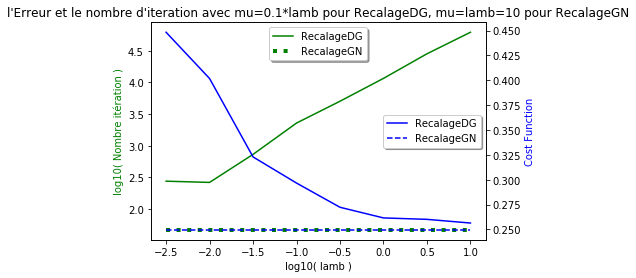

In [16]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(lamb, np.log10(nb_iter[:,0]), 'g-', label="RecalageDG")
ax1.plot(lamb, np.log10(nb_iter[:,1]), 'g:', label="RecalageGN", linewidth=4)

ax2.plot(lamb, cost_function[:,0], 'b-', label="RecalageDG")
ax2.plot(lamb, cost_function[:,1], 'b--', label="RecalageGN")

ax1.set_xlabel('log10( lamb )')
ax1.set_ylabel('log10( Nombre itération )', color='g')
ax2.set_ylabel('Cost Function', color='b')

ax1.legend(loc='upper center', shadow=True)
ax2.legend(loc='center right', shadow=True)
           
plt.title("l'Erreur et le nombre d'iteration avec mu=0.1*lamb pour RecalageDG, mu=lamb=10 pour RecalageGN")

plt.show()

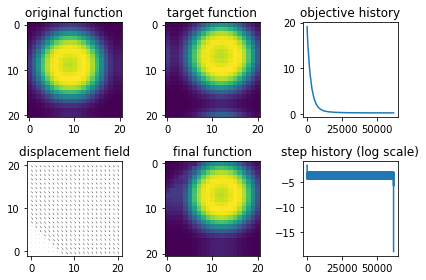

In [17]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

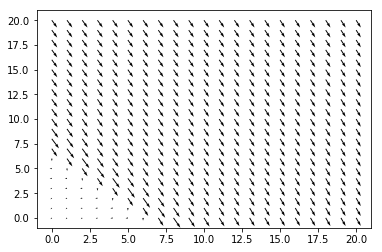

In [18]:
plt.quiver(ux, uy)
plt.show()

5. Jeu des différences
======================

Maintenant que vous avez implémenté et testé les deux algorithmes sur l'image-jouet proposée, voyons que cela donne sur une image IRM d'un cerveau. Saurez-vous détecter les différences entre les deux images ?


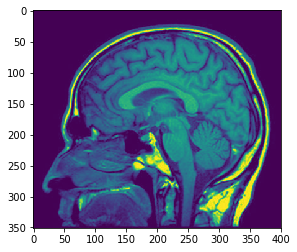

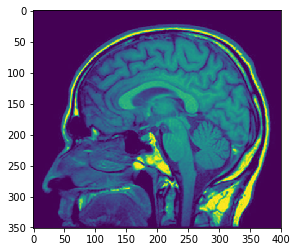

In [20]:
im1=Image.open('IRM1.png')
im2=Image.open("IRM2.png")
plt.imshow(plt.imread('IRM1.png'))
plt.show()
plt.imshow(plt.imread('IRM2.png'))
plt.show()

In [21]:
[n,m]=im1.size
sigma=0.3
[X,Y]=np.meshgrid(np.linspace(-1,1,n),np.linspace(-1,1,m), indexing='xy')
Z=np.sqrt(X*X+Y*Y)
G=np.fft.fftshift(np.exp(-(X**2+Y**2)/sigma**2))
f=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im1)))
g=np.real(np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(im2))) 
f=f/np.max(f)
g=g/np.max(g)

In [110]:
epsi=0.1
stepini = 0.1
nitermax = 1000
mu = 0.01
lamb = 0.001
ux,uy,CF,step=RecalageGN(f,g,lamb,mu,nitermax,stepini,epsi)

iteration : 1  cost function : 0.0354289760434 step : 0.2
iteration : 2  cost function : 0.035425990222 step : 0.4
iteration : 3  cost function : 0.0354200202475 step : 0.8
iteration : 4  cost function : 0.0354080868582 step : 1.6
iteration : 5  cost function : 0.0353842455436 step : 3.2
iteration : 6  cost function : 0.0353366602614 step : 6.4
iteration : 7  cost function : 0.0352418594476 step : 12.8
iteration : 8  cost function : 0.0350536794959 step : 25.6
iteration : 9  cost function : 0.0346828485188 step : 51.2
iteration : 10  cost function : 0.0339627345447 step : 102.4
iteration : 11  cost function : 0.0326864263851 step : 6.4
iteration : 12  cost function : 0.0325566921077 step : 6.4
iteration : 13  cost function : 0.0324685314498 step : 6.4
iteration : 14  cost function : 0.032418243914 step : 3.2
iteration : 15  cost function : 0.0323459114837 step : 3.2
iteration : 16  cost function : 0.0322973997385 step : 6.4
iteration : 17  cost function : 0.0322602546451 step : 3.2
ite

iteration : 140  cost function : 0.0280777440619 step : 3.2
iteration : 141  cost function : 0.028049796953 step : 3.2
iteration : 142  cost function : 0.0280219182132 step : 3.2
iteration : 143  cost function : 0.0279941076019 step : 3.2
iteration : 144  cost function : 0.027966364876 step : 3.2
iteration : 145  cost function : 0.0279386897996 step : 3.2
iteration : 146  cost function : 0.0279110821374 step : 3.2
iteration : 147  cost function : 0.0278835416545 step : 3.2
iteration : 148  cost function : 0.0278560681166 step : 3.2
iteration : 149  cost function : 0.0278286612914 step : 3.2
iteration : 150  cost function : 0.0278013209471 step : 3.2
iteration : 151  cost function : 0.0277740468519 step : 3.2
iteration : 152  cost function : 0.0277468387771 step : 3.2
iteration : 153  cost function : 0.0277196964968 step : 3.2
iteration : 154  cost function : 0.0276926197843 step : 3.2
iteration : 155  cost function : 0.0276656084147 step : 3.2
iteration : 156  cost function : 0.0276386

iteration : 277  cost function : 0.0247999840525 step : 3.2
iteration : 278  cost function : 0.024779585505 step : 3.2
iteration : 279  cost function : 0.0247592310488 step : 3.2
iteration : 280  cost function : 0.0247389205478 step : 3.2
iteration : 281  cost function : 0.0247186538762 step : 3.2
iteration : 282  cost function : 0.0246984309053 step : 3.2
iteration : 283  cost function : 0.024678251503 step : 3.2
iteration : 284  cost function : 0.0246581155461 step : 3.2
iteration : 285  cost function : 0.0246380229047 step : 3.2
iteration : 286  cost function : 0.0246179734474 step : 3.2
iteration : 287  cost function : 0.0245979670557 step : 3.2
iteration : 288  cost function : 0.0245780035934 step : 3.2
iteration : 289  cost function : 0.0245580829409 step : 3.2
iteration : 290  cost function : 0.024538204974 step : 3.2
iteration : 291  cost function : 0.0245183695585 step : 3.2
iteration : 292  cost function : 0.0244985765816 step : 3.2
iteration : 293  cost function : 0.02447882

iteration : 414  cost function : 0.0223679128567 step : 3.2
iteration : 415  cost function : 0.0223525282966 step : 3.2
iteration : 416  cost function : 0.0223371739795 step : 3.2
iteration : 417  cost function : 0.0223218498693 step : 3.2
iteration : 418  cost function : 0.0223065558493 step : 3.2
iteration : 419  cost function : 0.0222912918895 step : 3.2
iteration : 420  cost function : 0.0222760578652 step : 3.2
iteration : 421  cost function : 0.0222608537465 step : 3.2
iteration : 422  cost function : 0.0222456794278 step : 3.2
iteration : 423  cost function : 0.0222305348679 step : 3.2
iteration : 424  cost function : 0.0222154199618 step : 3.2
iteration : 425  cost function : 0.0222003346656 step : 3.2
iteration : 426  cost function : 0.0221852788749 step : 3.2
iteration : 427  cost function : 0.0221702525528 step : 3.2
iteration : 428  cost function : 0.0221552555966 step : 3.2
iteration : 429  cost function : 0.022140287964 step : 3.2
iteration : 430  cost function : 0.022125

iteration : 551  cost function : 0.0205150432425 step : 3.2
iteration : 552  cost function : 0.020503235494 step : 3.2
iteration : 553  cost function : 0.0204914506235 step : 3.2
iteration : 554  cost function : 0.0204796885912 step : 3.2
iteration : 555  cost function : 0.0204679493731 step : 3.2
iteration : 556  cost function : 0.02045623293 step : 3.2
iteration : 557  cost function : 0.0204445392384 step : 3.2
iteration : 558  cost function : 0.0204328682595 step : 3.2
iteration : 559  cost function : 0.0204212199686 step : 3.2
iteration : 560  cost function : 0.0204095943256 step : 3.2
iteration : 561  cost function : 0.0203979913135 step : 3.2
iteration : 562  cost function : 0.0203864108949 step : 3.2
iteration : 563  cost function : 0.0203748530488 step : 3.2
iteration : 564  cost function : 0.0203633177385 step : 3.2
iteration : 565  cost function : 0.0203518049321 step : 3.2
iteration : 566  cost function : 0.0203403146064 step : 3.2
iteration : 567  cost function : 0.02032884

iteration : 688  cost function : 0.0191023688572 step : 3.2
iteration : 689  cost function : 0.0190935618388 step : 3.2
iteration : 690  cost function : 0.0190847772521 step : 3.2
iteration : 691  cost function : 0.019076015127 step : 3.2
iteration : 692  cost function : 0.0190672755016 step : 3.2
iteration : 693  cost function : 0.0190585583997 step : 3.2
iteration : 694  cost function : 0.0190498638664 step : 3.2
iteration : 695  cost function : 0.0190411919435 step : 3.2
iteration : 696  cost function : 0.0190325426664 step : 3.2
iteration : 697  cost function : 0.0190239160856 step : 3.2
iteration : 698  cost function : 0.0190153122315 step : 3.2
iteration : 699  cost function : 0.0190067311558 step : 3.2
iteration : 700  cost function : 0.0189981728901 step : 3.2
iteration : 701  cost function : 0.018989637488 step : 3.2
iteration : 702  cost function : 0.0189811249825 step : 3.2
iteration : 703  cost function : 0.018972635429 step : 3.2
iteration : 704  cost function : 0.01896416

iteration : 825  cost function : 0.0181329258078 step : 3.2
iteration : 826  cost function : 0.0181279484598 step : 3.2
iteration : 827  cost function : 0.0181230090623 step : 3.2
iteration : 828  cost function : 0.0181181078318 step : 3.2
iteration : 829  cost function : 0.0181132450485 step : 3.2
iteration : 830  cost function : 0.0181084208875 step : 3.2
iteration : 831  cost function : 0.0181036356528 step : 3.2
iteration : 832  cost function : 0.0180988895368 step : 3.2
iteration : 833  cost function : 0.0180941828189 step : 3.2
iteration : 834  cost function : 0.018089515731 step : 3.2
iteration : 835  cost function : 0.0180848885228 step : 3.2
iteration : 836  cost function : 0.0180803014604 step : 3.2
iteration : 837  cost function : 0.0180757547801 step : 3.2
iteration : 838  cost function : 0.0180712487569 step : 3.2
iteration : 839  cost function : 0.0180667836485 step : 3.2
iteration : 840  cost function : 0.0180623597105 step : 3.2
iteration : 841  cost function : 0.018057

iteration : 962  cost function : 0.0167891889344 step : 3.2
iteration : 963  cost function : 0.0167826635242 step : 3.2
iteration : 964  cost function : 0.0167761467249 step : 3.2
iteration : 965  cost function : 0.0167696385115 step : 3.2
iteration : 966  cost function : 0.016763138877 step : 3.2
iteration : 967  cost function : 0.0167566477973 step : 3.2
iteration : 968  cost function : 0.016750165278 step : 3.2
iteration : 969  cost function : 0.0167436912933 step : 3.2
iteration : 970  cost function : 0.016737225843 step : 3.2
iteration : 971  cost function : 0.0167307689016 step : 3.2
iteration : 972  cost function : 0.0167243204693 step : 3.2
iteration : 973  cost function : 0.0167178805204 step : 3.2
iteration : 974  cost function : 0.016711449055 step : 3.2
iteration : 975  cost function : 0.0167050260476 step : 3.2
iteration : 976  cost function : 0.0166986114971 step : 3.2
iteration : 977  cost function : 0.0166922053821 step : 3.2
iteration : 978  cost function : 0.016685807

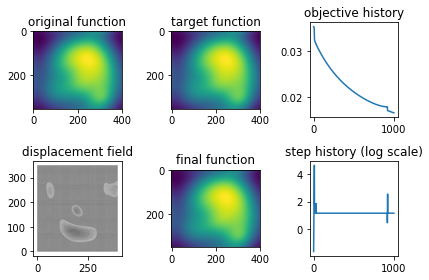

In [112]:
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(f)
ax[0,0].set_title('original function')
ax[0,1].imshow(g)
ax[0,1].set_title('target function')
ax[1,0].quiver(ux,uy)
ax[1,0].set_title('displacement field')
ax[1,1].imshow(interpol(f,ux,uy))
ax[1,1].set_title('final function')
ax[0,2].plot(CF)
ax[0,2].set_title('objective history')
ax[1,2].plot(np.log(step))
ax[1,2].set_title('step history (log scale)')

plt.tight_layout()
plt.show()

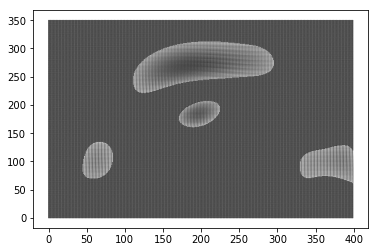

In [121]:
plt.quiver(np.flip(ux,0), np.flip(uy,0))
plt.show()